# Task 1

## CuPy GPU Acceleration (Creative Point)

Since numpy does not have GPU acceleration, it is extremely slow to run our code on Colab. Therefore, we replace numpy with CuPy, which is a NumPy/SciPy-compatible array library for GPU-accelerated computing with Python.

In [ ]:
!pip install cupy-cuda11x

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Global Variables

In [ ]:
# Constants
FASHION_MNIST_N_CLASSES = 10
HIDDEN_SIZE = 128
MLP_LR = 0.005
MLP_BATCH_SIZE = 100
MLP_EPOCHS = 200
XAVIER_GAIN = 0.1

## Download Fashion-MNIST dataset

In [ ]:
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
import cupy as np

(x_train_original, y_train), (x_test_original, y_test) = fashion_mnist.load_data()
x_train_original, x_val_original, y_train, y_val = train_test_split(x_train_original, y_train, test_size=0.3)

x_train_original = np.asarray(x_train_original)
x_val_original = np.asarray(x_val_original)
x_test_original = np.asarray(x_test_original)

y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

print("Train original:")
print(x_train_original.shape)
print(y_train.shape)
print("Validation original:")
print(x_val_original.shape)
print(y_val.shape)
print("Test original:")
print(x_test_original.shape)
print(y_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
Train original:
(42000, 28, 28)
(42000,)
Validation original:
(18000, 28, 28)
(18000,)
Test original:
(10000, 28, 28)
(10000,)


## Analyse Dataset

Class distributions

(70000,)
[0 1 2 3 4 5 6 7 8 9]
[7000 7000 7000 7000 7000 7000 7000 7000 7000 7000]


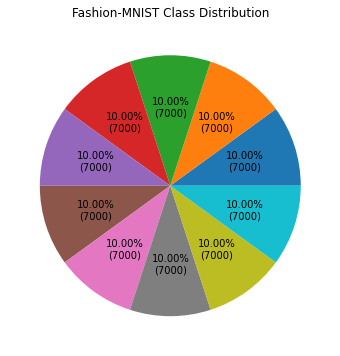

In [ ]:
import matplotlib.pyplot as plt

total_y = np.concatenate((y_train, y_val, y_test), axis=0)
print(total_y.shape)

unique, counts = np.unique(total_y, return_counts=True)
print(unique)
print(counts)

auto_pct_func = lambda x: '{:.2f}%\n({:.0f})'.format(x, len(total_y) * x / 100)

plt.figure(figsize=(6, 6))
plt.title("Fashion-MNIST Class Distribution")
plt.pie(counts.get(), autopct=auto_pct_func)
plt.show()

## Flatten and vectorize data

In [ ]:
x_train = x_train_original.reshape(x_train_original.shape[0], -1)
x_val = x_val_original.reshape(x_val_original.shape[0], -1)
x_test = x_test_original.reshape(x_test_original.shape[0], -1)

print("Train flattened: {}".format(x_train.shape))
print("Validation flattened: {}".format(x_val.shape))
print("Test flattened: {}".format(x_test.shape))

Train flattened: (42000, 784)
Validation flattened: (18000, 784)
Test flattened: (10000, 784)


## Normalize data

In [ ]:
import cupy as np

def standardize(input):

    # (x - mean) / std
    mean = np.mean(input, axis=0)
    std = np.std(input, axis=0)

    return np.divide((input - mean), std)

Save unnormalized copies of the data (to be used in Task 3).

In [ ]:
x_train_unnormalized = np.copy(x_train)
x_val_unnormalized = np.copy(x_val)
x_test_unnormalized = np.copy(x_test)

In [ ]:
x_train = standardize(x_train)
x_val = standardize(x_val)
x_test = standardize(x_test)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(42000, 784)
(18000, 784)
(10000, 784)


## One-hot Encoded Labels

In [ ]:
y_train = np.eye(FASHION_MNIST_N_CLASSES)[y_train.get()]
y_val = np.eye(FASHION_MNIST_N_CLASSES)[y_val.get()]
y_test = np.eye(FASHION_MNIST_N_CLASSES)[y_test.get()]

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(42000, 10)
(18000, 10)
(10000, 10)


# Task 2

## Evaluation Utility

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd


class EvaluationUtils:

    """ Utility class to evaluate models """

    @staticmethod
    def calculate_multi_accuracy(y_pred, y_true):
      accuracy = sum(y_pred.argmax(axis=1) == y_true.argmax(axis=1))
      accuracy = accuracy / y_true.shape[0]
      return accuracy

    @staticmethod
    def calculate_binary_accuracy(y_pred, y_true):
        return np.mean(np.abs(y_pred - y_true) < 1e-10)

    @staticmethod
    def calculate_bce_loss(y_probs, y_true):
        return np.mean(-1 * (y_true * np.log(y_probs + 1e-10) + (1 - y_true) * np.log(1 - y_probs + 1e-10)))

    @staticmethod
    def calculate_ce_loss(y_probs, y_true):
        return -1 * np.sum( y_true * np.log(y_probs + 1e-10) ) / len(y_true)

    @staticmethod
    def calculate_roc_auc(y_probs, y_true):
        return roc_auc_score(y_true, y_probs)

    @staticmethod
    def calculate_pr_auc(y_probs, y_true):
        precision, recall, _ = precision_recall_curve(y_true, y_probs)
        return auc(recall, precision)

    @staticmethod
    def plot_confusion_matrix(y_pred, y_true):
        mat = confusion_matrix(y_true, y_pred)
        df_cm = pd.DataFrame(mat)
        plt.title("Confusion Matrix")
        sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
    
    @staticmethod
    def plot_roc_curve(y_probs, y_true):

        no_skill = [0 for _ in range(len(y_true))]
        ns_fpr, ns_tpr, _ = roc_curve(y_true, no_skill)
        lr_fpr, lr_tpr, _ = roc_curve(y_true, y_probs)

        ns_auc = roc_auc_score(y_true, no_skill)
        lr_auc = roc_auc_score(y_true, y_probs)

        plt.title("ROC")
        plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
        plt.plot(lr_fpr, lr_tpr, marker='.', label='Proposed Model')
        plt.grid(linewidth=0.5)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.legend()
        plt.show()

    @staticmethod
    def plot_pr_curve(y_probs, y_true):

        precision, recall, _ = precision_recall_curve(y_true, y_probs)

        plt.title("PR")
        plt.plot(recall, precision, marker='.', label='Proposed Model')
        plt.grid(linewidth=0.5)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.show()

## Model Layer

In [ ]:
class BaseLayer:

    def __init__(self):
        self.gradient = None
        self.parameters = None
        
    def forward(self, x):
        raise NotImplementedError()

    def backward(self, gradient):
        raise NotImplementedError()

### Linear (Creative point: Xavier Initialization)

In [ ]:
from scipy.optimize import check_grad
import uuid

class LinearLayer(BaseLayer):

    def __init__(self, input_size, output_size, l2_lambda=0, xavier_gain=XAVIER_GAIN):
        super().__init__()
        self.id = uuid.uuid4()
        self.ni = input_size
        self.no = output_size
        self.w = np.random.normal(loc=0.0, scale=xavier_gain*np.sqrt(2/(input_size + output_size)), size=(output_size, input_size))
        self.b = np.random.normal(loc=0.0, scale=xavier_gain*np.sqrt(2/(input_size + output_size)), size=(output_size))
        self.cur_input = None
        self.parameters = [self.w, self.b]
        self.l2_lambda = l2_lambda

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        #dw = gradient.dot(self.cur_input)()
        # print((gradient[:, :, None]).shape)
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        dw += self.l2_lambda * self.w
        db = gradient
        self.gradient = [dw, db] # Used in optimizer step() function
        return gradient.dot(self.w)

    def set_params(self, params):
        self.parameters = params
        self.w = params[0]
        self.b = params[1]

### ReLU

In [ ]:
class ReLULayer(BaseLayer):

    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

### Tanh

In [ ]:
class TanhLayer(BaseLayer):

    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = 1 - np.square(np.tanh(x))
        return np.tanh(x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

### Leaky-ReLU

In [ ]:
class LeakyReLULayer(BaseLayer):

    def __init__(self):
        super().__init__()
        
    def forward(self, x, alpha=0.1):
        self.gradient = np.where(x > 0, 1.0, alpha)
        return np.maximum(0, x) + alpha * np.minimum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

### Softmax

$$
\nabla_x\mathsf{CrossEntropyLoss}(\mathsf{Softmax}(x), y) = \mathsf{Softmax}(x) - y
$$

In [ ]:
class SoftmaxOutputLayer(BaseLayer):

    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        exps = np.exp(x)
        probs = exps / np.sum(exps, axis=-1)[:, None]
        self.cur_probs = probs
        return probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target # Softmax - y

## Optimizer

In [ ]:
class Optimizer:

    def __init__(self, net):
        self.net = net

    def step(self, epoch):

        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer, epoch)

    def update(self, layer, epoch):
        raise NotImplementedError()

### SGD

In [ ]:
class GradientDescentOptimizer(Optimizer):

    def __init__(self, net, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, layer, epoch):
        for (p, g) in zip(layer.parameters, layer.gradient):
            p -= self.lr * g.mean(axis=0)

### Adam (Creative Point)

In [ ]:
import copy

class AdamOptimizer(Optimizer):
    
    def __init__(self, net, lr: float, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(net)
        self.momentum = {}
        self.rmsprop = {}
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.eta = lr
        
    def update(self, layer, epoch):

        t = epoch + 1

        w, b = layer.parameters[0], layer.parameters[1]
        dw, db = layer.gradient[0], layer.gradient[1]

        dw = dw.mean(axis=0)
        db = db.mean(axis=0)

        m_dw, m_db = np.zeros(dw.shape), np.zeros(db.shape)
        m_parameters = self.momentum.get(layer.id)
        if m_parameters is not None:
            m_dw, m_db = m_parameters[0], m_parameters[1]
        
        v_dw, v_db = np.zeros(dw.shape), np.zeros(db.shape)
        v_parameters = self.rmsprop.get(layer.id)
        if v_parameters is not None:
            v_dw, v_db = v_parameters[0], v_parameters[1]

        ## momentum beta 1
        # *** weights *** #
        m_dw = self.beta1*m_dw + (1-self.beta1)*dw
        # *** biases *** #
        m_db = self.beta1*m_db + (1-self.beta1)*db

        ## rms beta 2
        # *** weights *** #
        v_dw = self.beta2*v_dw + (1-self.beta2)*(dw**2)
        # *** biases *** #
        v_db = self.beta2*v_db + (1-self.beta2)*(db**2)

        ## bias correction
        m_dw_corr = m_dw/(1-self.beta1**t)
        m_db_corr = m_db/(1-self.beta1**t)
        v_dw_corr = v_dw/(1-self.beta2**t)
        v_db_corr = v_db/(1-self.beta2**t)

        ## update weights and biases
        w = w - self.eta*(m_dw_corr/(np.sqrt(v_dw_corr)+self.epsilon))
        b = b - self.eta*(m_db_corr/(np.sqrt(v_db_corr)+self.epsilon))

        layer.set_params([w, b])
        self.momentum[layer.id] = [m_dw, m_db]
        self.rmsprop[layer.id] = [v_dw, v_db]

## MLP (with mini-batch)

In [ ]:
from tqdm import tqdm
from typing import List
import copy

class MLP:

    def __init__(self, *args: List[BaseLayer]):
        self.layers = args
        self.best_layers = args

    def forward(self, x, is_test=False):
        layers = self.best_layers if is_test else self.layers
        for layer in layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)

    def fit(self, optimizer: Optimizer, 
            x_train, y_train, x_val, y_val, 
            batch_size=30, epochs=100):

        train_loss_list = []
        val_loss_list = []

        train_acc_list = []
        val_acc_list = []

        # Mini batch
        N = len(y_train)
        batch_count = int(N / batch_size)
        tot_batch_x = np.split(x_train, batch_count)
        tot_batch_y = np.split(y_train, batch_count)

        best_val_loss = float("inf")
        
        for epoch in tqdm(range(epochs)):

            # Train
            batch_train_loss_list = []
            batch_train_acc_list = []

            for b in range(batch_count):

                # Mini batch gradient descent
                batch_x = tot_batch_x[b]
                batch_y = tot_batch_y[b]

                y_train_probs = self.predict(batch_x)
                batch_loss_train = EvaluationUtils.calculate_ce_loss(y_train_probs, batch_y)
                batch_acc_train = EvaluationUtils.calculate_multi_accuracy(y_train_probs, batch_y)

                self.backward(batch_y)
                optimizer.step(epoch)

                batch_train_loss_list.append(batch_loss_train)
                batch_train_acc_list.append(batch_acc_train)

            train_loss = sum(batch_train_loss_list) / len(batch_train_loss_list)
            train_loss_list.append(train_loss.get())

            train_acc = sum(batch_train_acc_list) / len(batch_train_acc_list)
            train_acc_list.append(train_acc.get())

            # Validation
            y_val_probs = self.predict(x_val)

            val_loss = EvaluationUtils.calculate_ce_loss(y_val_probs, y_val)
            val_loss_list.append(val_loss.get())
            
            val_acc = EvaluationUtils.calculate_multi_accuracy(y_val_probs, y_val)
            val_acc_list.append(val_acc.get())

            # Select model with best validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self.best_layers = copy.deepcopy(self.layers)

            print("Epoch: {}, train loss: {}, train acc: {}, val loss: {}, val acc: {}".format(epoch+1, train_loss, train_acc, val_loss, val_acc))

        return train_loss_list, val_loss_list, train_acc_list, val_acc_list

    def predict(self, x, is_test=False):
        return self.forward(x, is_test)

    def check_grad(self, optimizer: Optimizer, 
                   x_train, y_train) -> list:
        
        result = []
        
        # Mock forward pass and backpropagation to get derived gradients
        self.forward(x_train)
        self.backward(y_train)

        for layer_to_pertube in self.layers:

            if not isinstance(layer_to_pertube, LinearLayer):
                continue

            D = layer_to_pertube.ni
            C = layer_to_pertube.no

            diff = np.zeros((C, D))

            for i in range(C):
                for j in range(D):
                    
                    """ Calculate numerical gradients """
                    epsilon = np.zeros((C, D))
                    epsilon[i, j] = np.random.rand() * 1e-4

                    # w + epsilon
                    layer_to_pertube.w += epsilon
                    y_probs = self.forward(x_train)
                    layer_to_pertube.w -= epsilon # Reset w
                    J1 = EvaluationUtils.calculate_ce_loss(y_probs, y_train)
                    
                    # w - epsilon
                    layer_to_pertube.w -= epsilon
                    y_probs = self.forward(x_train)
                    layer_to_pertube.w += epsilon # Reset w
                    J2 = EvaluationUtils.calculate_ce_loss(y_probs, y_train)
                    
                    numeric_grad = (J1 - J2) / (2 * epsilon[i, j]) # (L(w + dw) - L(w - dw)) / (2 * dw)
                    
                    """ Calculate derived gradients """
                    real_dw = layer_to_pertube.gradient[0]
                    averaged_grad = np.mean(real_dw, axis=0) # Overall gradient is the expected gradient over each training examples
                    derived_grad = averaged_grad[i, j]

                    diff_grad = np.square(derived_grad - numeric_grad).sum() / \
                                np.square(derived_grad + numeric_grad).sum()
                    diff[i, j] = diff_grad

            layer_diff = diff.sum()
            print("Layer diff: {}".format(layer_diff))

            result.append(layer_diff)

        return result

# Task 3

## Unit Test to Check Gradients

In [ ]:
n_features = x_train.shape[-1]

In [ ]:
import unittest
from unittest import TestCase

class TestCheckGradients(TestCase):

    def test_check_gradients(self):

        # GIVEN MLP with one linear layer
        mock_mlp = MLP(
            LinearLayer(n_features, FASHION_MNIST_N_CLASSES),
            SoftmaxOutputLayer()
        )

        # WHEN check gradients
        mock_opt = GradientDescentOptimizer(mock_mlp, MLP_LR)
        grad_diffs = mock_mlp.check_grad(mock_opt, x_train[:10], y_train[:10])

        # THEN the difference between numerical gradients and derived gradients should be small enough
        is_diff_small = True
        for diff in grad_diffs:
            if diff > 1e-3:
                is_diff_small = False

        self.assertTrue(is_diff_small)

In [ ]:
suite = unittest.TestSuite()
suite.addTest(TestCheckGradients('test_check_gradients'))

runner = unittest.TextTestRunner()
runner.run(suite)

Layer diff: 1.002550807533008e-10


.
----------------------------------------------------------------------
Ran 1 test in 16.750s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [ ]:
print(x_val)

[[-0.01217251 -0.02213455 -0.04410661 ... -0.15771846 -0.08379332
  -0.03037677]
 [-0.01217251 -0.02213455 -0.04410661 ... -0.15771846 -0.08379332
  -0.03037677]
 [-0.01217251 -0.02213455 -0.04410661 ... -0.15771846 -0.08379332
  -0.03037677]
 ...
 [-0.01217251 -0.02213455 -0.04410661 ... -0.15771846 -0.08379332
  -0.03037677]
 [-0.01217251 -0.02213455 -0.04410661 ...  3.7530586  -0.08379332
  -0.03037677]
 [-0.01217251 -0.02213455 -0.04410661 ... -0.15771846 -0.08379332
  -0.03037677]]


## Sub-task 1:

### MLP with no hidden layer

#### MLP with no hidden layer and learning rate of 0.05

In [ ]:
mlp_no_hidden = MLP(
    LinearLayer(n_features, FASHION_MNIST_N_CLASSES),
    SoftmaxOutputLayer()
)

opt_no_hidden = GradientDescentOptimizer(mlp_no_hidden, MLP_LR)
train_loss_list, val_loss_list, train_acc_list, val_acc_list = mlp_no_hidden.fit(opt_no_hidden, x_train, y_train, x_val, y_val, 
                                                                                 batch_size=MLP_BATCH_SIZE, epochs=MLP_EPOCHS)

  0%|          | 1/200 [00:09<33:03,  9.97s/it]

Epoch: 1, train loss: 0.7551288361515552, train acc: 0.7629761904761899, val loss: 0.5981344849230228, val acc: 0.8016666666666666


  1%|          | 2/200 [00:11<16:44,  5.07s/it]

Epoch: 2, train loss: 0.545311954502351, train acc: 0.8191428571428578, val loss: 0.5385497414390683, val acc: 0.8199444444444445


  2%|▏         | 3/200 [00:13<11:11,  3.41s/it]

Epoch: 3, train loss: 0.5038375854333567, train acc: 0.8308095238095251, val loss: 0.5123765930396564, val acc: 0.8292222222222222


  2%|▏         | 4/200 [00:14<08:32,  2.62s/it]

Epoch: 4, train loss: 0.4820159489739984, train acc: 0.8378095238095238, val loss: 0.49690415465046833, val acc: 0.8345555555555556


  2%|▎         | 5/200 [00:15<07:06,  2.19s/it]

Epoch: 5, train loss: 0.4677686911556317, train acc: 0.8417619047619043, val loss: 0.4864039526028638, val acc: 0.8392222222222222


  3%|▎         | 6/200 [00:17<06:13,  1.93s/it]

Epoch: 6, train loss: 0.45741355615410495, train acc: 0.8446904761904764, val loss: 0.47869679383286196, val acc: 0.8415


  4%|▎         | 7/200 [00:18<05:39,  1.76s/it]

Epoch: 7, train loss: 0.4493923997302179, train acc: 0.8473095238095242, val loss: 0.47274830207429336, val acc: 0.8434444444444444


  4%|▍         | 8/200 [00:20<05:15,  1.64s/it]

Epoch: 8, train loss: 0.4429114304755817, train acc: 0.8497142857142862, val loss: 0.46799322682683236, val acc: 0.845


  4%|▍         | 9/200 [00:21<04:59,  1.57s/it]

Epoch: 9, train loss: 0.4375145219935917, train acc: 0.851309523809525, val loss: 0.4640916847401813, val acc: 0.8458333333333333


  5%|▌         | 10/200 [00:22<04:47,  1.51s/it]

Epoch: 10, train loss: 0.4329166658676893, train acc: 0.8527619047619055, val loss: 0.46082517440548104, val acc: 0.8463888888888889


  6%|▌         | 11/200 [00:24<04:37,  1.47s/it]

Epoch: 11, train loss: 0.4289286484790719, train acc: 0.8543571428571439, val loss: 0.4580461407334547, val acc: 0.8473333333333334


  6%|▌         | 12/200 [00:25<04:30,  1.44s/it]

Epoch: 12, train loss: 0.4254190433276727, train acc: 0.8556904761904767, val loss: 0.4556509459609556, val acc: 0.8484444444444444


  6%|▋         | 13/200 [00:27<04:26,  1.42s/it]

Epoch: 13, train loss: 0.42229329365631807, train acc: 0.8566904761904764, val loss: 0.4535643519287421, val acc: 0.8488888888888889


  7%|▋         | 14/200 [00:28<04:22,  1.41s/it]

Epoch: 14, train loss: 0.41948139593080064, train acc: 0.857476190476191, val loss: 0.45173018851641644, val acc: 0.8493333333333334


  8%|▊         | 15/200 [00:29<04:20,  1.41s/it]

Epoch: 15, train loss: 0.4169302647096858, train acc: 0.8581428571428574, val loss: 0.4501055253222229, val acc: 0.8502777777777778


  8%|▊         | 16/200 [00:31<04:20,  1.41s/it]

Epoch: 16, train loss: 0.4145988065119971, train acc: 0.8591190476190477, val loss: 0.4486568977069347, val acc: 0.8505555555555555


  8%|▊         | 17/200 [00:32<04:18,  1.41s/it]

Epoch: 17, train loss: 0.41245463670170684, train acc: 0.8595238095238098, val loss: 0.4473577789364038, val acc: 0.8509444444444444


  9%|▉         | 18/200 [00:34<04:17,  1.42s/it]

Epoch: 18, train loss: 0.41047183045773006, train acc: 0.859857142857143, val loss: 0.44618683551781224, val acc: 0.8511666666666666


 10%|▉         | 19/200 [00:35<04:15,  1.41s/it]

Epoch: 19, train loss: 0.4086293448109399, train acc: 0.8603571428571429, val loss: 0.4451266919517112, val acc: 0.8511666666666666


 10%|█         | 20/200 [00:36<04:13,  1.41s/it]

Epoch: 20, train loss: 0.40690988781702825, train acc: 0.8606666666666666, val loss: 0.4441630370537491, val acc: 0.8515


 10%|█         | 21/200 [00:38<04:10,  1.40s/it]

Epoch: 21, train loss: 0.40529909270086867, train acc: 0.8610000000000001, val loss: 0.44328396530243563, val acc: 0.8518333333333333


 11%|█         | 22/200 [00:39<04:07,  1.39s/it]

Epoch: 22, train loss: 0.4037849044067831, train acc: 0.8616904761904762, val loss: 0.4424794834769746, val acc: 0.852


 12%|█▏        | 23/200 [00:41<04:07,  1.40s/it]

Epoch: 23, train loss: 0.4023571168944589, train acc: 0.862166666666667, val loss: 0.4417411357437998, val acc: 0.8522222222222222


 12%|█▏        | 24/200 [00:42<04:05,  1.40s/it]

Epoch: 24, train loss: 0.4010070192483317, train acc: 0.86252380952381, val loss: 0.44106171503433594, val acc: 0.8523888888888889


 12%|█▎        | 25/200 [00:43<04:04,  1.40s/it]

Epoch: 25, train loss: 0.3997271215455626, train acc: 0.8627619047619048, val loss: 0.44043503821572244, val acc: 0.8521666666666666


 13%|█▎        | 26/200 [00:45<04:02,  1.39s/it]

Epoch: 26, train loss: 0.39851094001087656, train acc: 0.863047619047619, val loss: 0.4398557690432303, val acc: 0.8519444444444444


 14%|█▎        | 27/200 [00:46<04:01,  1.40s/it]

Epoch: 27, train loss: 0.39735282681979067, train acc: 0.8636190476190473, val loss: 0.4393192773174887, val acc: 0.8518333333333333


 14%|█▍        | 28/200 [00:48<04:01,  1.40s/it]

Epoch: 28, train loss: 0.3962478339460632, train acc: 0.8642857142857139, val loss: 0.43882152575221234, val acc: 0.8521111111111112


 14%|█▍        | 29/200 [00:49<04:14,  1.49s/it]

Epoch: 29, train loss: 0.39519160328021036, train acc: 0.8644999999999998, val loss: 0.43835897824011993, val acc: 0.852


 15%|█▌        | 30/200 [00:52<05:05,  1.80s/it]

Epoch: 30, train loss: 0.39418027725376886, train acc: 0.8648095238095236, val loss: 0.43792852478119526, val acc: 0.8519444444444444


 16%|█▌        | 31/200 [00:53<04:51,  1.73s/it]

Epoch: 31, train loss: 0.3932104256376256, train acc: 0.8649999999999998, val loss: 0.4375274195004086, val acc: 0.8524444444444444


 16%|█▌        | 32/200 [00:55<04:37,  1.65s/it]

Epoch: 32, train loss: 0.3922789852118431, train acc: 0.8651666666666669, val loss: 0.4371532290534957, val acc: 0.8523888888888889


 16%|█▋        | 33/200 [00:56<04:25,  1.59s/it]

Epoch: 33, train loss: 0.39138320974956936, train acc: 0.8654761904761905, val loss: 0.4368037893752541, val acc: 0.8526666666666667


 17%|█▋        | 34/200 [00:58<04:14,  1.54s/it]

Epoch: 34, train loss: 0.39052062830667367, train acc: 0.8658571428571428, val loss: 0.4364771692138686, val acc: 0.8528888888888889


 18%|█▊        | 35/200 [00:59<04:07,  1.50s/it]

Epoch: 35, train loss: 0.3896890102243888, train acc: 0.8661666666666664, val loss: 0.4361716392527572, val acc: 0.8530555555555556


 18%|█▊        | 36/200 [01:00<04:02,  1.48s/it]

Epoch: 36, train loss: 0.3888863355765352, train acc: 0.8664047619047621, val loss: 0.43588564587892953, val acc: 0.8529444444444444


 18%|█▊        | 37/200 [01:02<03:59,  1.47s/it]

Epoch: 37, train loss: 0.3881107700516419, train acc: 0.866666666666667, val loss: 0.4356177888414603, val acc: 0.8532777777777778


 19%|█▉        | 38/200 [01:03<03:54,  1.45s/it]

Epoch: 38, train loss: 0.38736064346844445, train acc: 0.867071428571429, val loss: 0.4353668021788564, val acc: 0.8534444444444444


 20%|█▉        | 39/200 [01:05<03:49,  1.43s/it]

Epoch: 39, train loss: 0.386634431289627, train acc: 0.867214285714286, val loss: 0.43513153789759873, val acc: 0.8535


 20%|██        | 40/200 [01:06<03:46,  1.42s/it]

Epoch: 40, train loss: 0.38593073862997873, train acc: 0.8674523809523812, val loss: 0.43491095196764945, val acc: 0.8536111111111111


 20%|██        | 41/200 [01:07<03:44,  1.41s/it]

Epoch: 41, train loss: 0.38524828635720115, train acc: 0.867476190476191, val loss: 0.43470409227083634, val acc: 0.8533333333333334


 21%|██        | 42/200 [01:09<03:41,  1.40s/it]

Epoch: 42, train loss: 0.3845858989621873, train acc: 0.8674761904761908, val loss: 0.43451008819795073, val acc: 0.8536666666666667


 22%|██▏       | 43/200 [01:10<03:40,  1.40s/it]

Epoch: 43, train loss: 0.3839424939359541, train acc: 0.8677142857142859, val loss: 0.43432814164154177, val acc: 0.8537222222222223


 22%|██▏       | 44/200 [01:12<03:40,  1.41s/it]

Epoch: 44, train loss: 0.38331707243699653, train acc: 0.8680000000000001, val loss: 0.43415751917447526, val acc: 0.8536666666666667


 22%|██▎       | 45/200 [01:13<03:39,  1.41s/it]

Epoch: 45, train loss: 0.3827087110692395, train acc: 0.8680000000000003, val loss: 0.4339975452400412, val acc: 0.8538888888888889


 23%|██▎       | 46/200 [01:15<03:36,  1.41s/it]

Epoch: 46, train loss: 0.382116554619654, train acc: 0.868214285714286, val loss: 0.43384759620852564, val acc: 0.8541666666666666


 24%|██▎       | 47/200 [01:16<03:36,  1.41s/it]

Epoch: 47, train loss: 0.38153980962785217, train acc: 0.868357142857143, val loss: 0.4337070951786858, val acc: 0.8543888888888889


 24%|██▍       | 48/200 [01:17<03:35,  1.42s/it]

Epoch: 48, train loss: 0.3809777386790521, train acc: 0.8685952380952384, val loss: 0.4335755074214569, val acc: 0.8545


 24%|██▍       | 49/200 [01:19<03:36,  1.43s/it]

Epoch: 49, train loss: 0.38042965532757783, train acc: 0.8686666666666669, val loss: 0.43345233637844566, val acc: 0.8545555555555555


 25%|██▌       | 50/200 [01:20<03:32,  1.42s/it]

Epoch: 50, train loss: 0.3798949195712545, train acc: 0.8688809523809526, val loss: 0.4333371201401553, val acc: 0.8548888888888889


 26%|██▌       | 51/200 [01:22<03:30,  1.41s/it]

Epoch: 51, train loss: 0.3793729338081945, train acc: 0.8691666666666669, val loss: 0.433229428339152, val acc: 0.8548888888888889


 26%|██▌       | 52/200 [01:23<03:28,  1.41s/it]

Epoch: 52, train loss: 0.37886313921688497, train acc: 0.8694047619047621, val loss: 0.43312885940203216, val acc: 0.8548333333333333


 26%|██▋       | 53/200 [01:24<03:25,  1.40s/it]

Epoch: 53, train loss: 0.3783650125085106, train acc: 0.869547619047619, val loss: 0.4330350381115019, val acc: 0.8548333333333333


 27%|██▋       | 54/200 [01:26<03:22,  1.39s/it]

Epoch: 54, train loss: 0.377878063007275, train acc: 0.8696428571428574, val loss: 0.4329476134363846, val acc: 0.8547222222222223


 28%|██▊       | 55/200 [01:27<03:19,  1.38s/it]

Epoch: 55, train loss: 0.377401830020338, train acc: 0.8699047619047622, val loss: 0.432866256593113, val acc: 0.8547222222222223


 28%|██▊       | 56/200 [01:28<03:18,  1.38s/it]

Epoch: 56, train loss: 0.3769358804639847, train acc: 0.8699761904761906, val loss: 0.4327906593073542, val acc: 0.8546666666666667


 28%|██▊       | 57/200 [01:30<03:21,  1.41s/it]

Epoch: 57, train loss: 0.37647980671696124, train acc: 0.8700714285714288, val loss: 0.43272053224891766, val acc: 0.8547777777777777


 29%|██▉       | 58/200 [01:31<03:18,  1.40s/it]

Epoch: 58, train loss: 0.3760332246755806, train acc: 0.8702857142857143, val loss: 0.43265560361706923, val acc: 0.8546666666666667


 30%|██▉       | 59/200 [01:33<03:18,  1.41s/it]

Epoch: 59, train loss: 0.3755957719884312, train acc: 0.8703333333333334, val loss: 0.4325956178568523, val acc: 0.8546111111111111


 30%|███       | 60/200 [01:34<03:15,  1.40s/it]

Epoch: 60, train loss: 0.3751671064512289, train acc: 0.8703809523809525, val loss: 0.43254033449003587, val acc: 0.8546666666666667


 30%|███       | 61/200 [01:36<03:13,  1.39s/it]

Epoch: 61, train loss: 0.37474690454478454, train acc: 0.870690476190476, val loss: 0.43248952704692095, val acc: 0.8548333333333333


 31%|███       | 62/200 [01:37<03:12,  1.40s/it]

Epoch: 62, train loss: 0.37433486010107236, train acc: 0.8707380952380949, val loss: 0.43244298208747467, val acc: 0.8547777777777777


 32%|███▏      | 63/200 [01:38<03:11,  1.39s/it]

Epoch: 63, train loss: 0.37393068308425303, train acc: 0.8708571428571426, val loss: 0.4324004983021692, val acc: 0.8547777777777777


 32%|███▏      | 64/200 [01:40<03:10,  1.40s/it]

Epoch: 64, train loss: 0.3735340984749978, train acc: 0.8708571428571423, val loss: 0.432361885684524, val acc: 0.8547222222222223


 32%|███▎      | 65/200 [01:41<03:09,  1.40s/it]

Epoch: 65, train loss: 0.3731448452479216, train acc: 0.871071428571428, val loss: 0.43232696476870525, val acc: 0.8547777777777777


 33%|███▎      | 66/200 [01:43<03:08,  1.40s/it]

Epoch: 66, train loss: 0.37276267543306385, train acc: 0.8713095238095236, val loss: 0.4322955659266554, val acc: 0.8547777777777777


 34%|███▎      | 67/200 [01:44<03:05,  1.40s/it]

Epoch: 67, train loss: 0.37238735325346606, train acc: 0.8714761904761903, val loss: 0.43226752872011626, val acc: 0.8548333333333333


 34%|███▍      | 68/200 [01:45<03:04,  1.40s/it]

Epoch: 68, train loss: 0.37201865433180303, train acc: 0.8717380952380949, val loss: 0.4322427013035735, val acc: 0.8547777777777777


 34%|███▍      | 69/200 [01:47<03:02,  1.39s/it]

Epoch: 69, train loss: 0.37165636495982346, train acc: 0.871833333333333, val loss: 0.4322209398746075, val acc: 0.8549444444444444


 35%|███▌      | 70/200 [01:48<03:01,  1.40s/it]

Epoch: 70, train loss: 0.371300281425077, train acc: 0.8718095238095236, val loss: 0.4322021081683807, val acc: 0.8550555555555556


 36%|███▌      | 71/200 [01:50<03:16,  1.52s/it]

Epoch: 71, train loss: 0.37095020938997186, train acc: 0.8720238095238092, val loss: 0.43218607699306605, val acc: 0.8551111111111112


 36%|███▌      | 72/200 [01:52<03:44,  1.75s/it]

Epoch: 72, train loss: 0.37060596331872747, train acc: 0.8721666666666664, val loss: 0.43217272380296, val acc: 0.8551111111111112


 36%|███▋      | 73/200 [01:54<03:35,  1.70s/it]

Epoch: 73, train loss: 0.3702673659481896, train acc: 0.8721666666666664, val loss: 0.43216193230589506, val acc: 0.8550555555555556


 37%|███▋      | 74/200 [01:55<03:21,  1.60s/it]

Epoch: 74, train loss: 0.3699342477988301, train acc: 0.872333333333333, val loss: 0.43215359210143556, val acc: 0.8548333333333333


 38%|███▊      | 75/200 [01:57<03:12,  1.54s/it]

Epoch: 75, train loss: 0.3696064467225197, train acc: 0.8723809523809519, val loss: 0.4321475983462875, val acc: 0.8548333333333333


 38%|███▊      | 76/200 [01:58<03:06,  1.50s/it]

Epoch: 76, train loss: 0.3692838074839475, train acc: 0.8725238095238094, val loss: 0.4321438514434259, val acc: 0.8548888888888889


 38%|███▊      | 77/200 [01:59<03:01,  1.47s/it]

Epoch: 77, train loss: 0.3689661813727381, train acc: 0.8726666666666665, val loss: 0.4321422567516762, val acc: 0.8548333333333333


 39%|███▉      | 78/200 [02:01<02:55,  1.44s/it]

Epoch: 78, train loss: 0.3686534258435711, train acc: 0.872690476190476, val loss: 0.43214272431287254, val acc: 0.8548333333333333


 40%|███▉      | 79/200 [02:02<02:53,  1.44s/it]

Epoch: 79, train loss: 0.36834540418178535, train acc: 0.872738095238095, val loss: 0.43214516859421054, val acc: 0.8547777777777777


 40%|████      | 80/200 [02:04<02:51,  1.43s/it]

Epoch: 80, train loss: 0.3680419851921977, train acc: 0.8727857142857143, val loss: 0.43214950824397463, val acc: 0.8545555555555555


 40%|████      | 81/200 [02:05<02:48,  1.42s/it]

Epoch: 81, train loss: 0.36774304290903614, train acc: 0.8728095238095238, val loss: 0.43215566585935566, val acc: 0.8546666666666667


 41%|████      | 82/200 [02:06<02:46,  1.41s/it]

Epoch: 82, train loss: 0.36744845632514145, train acc: 0.8729523809523809, val loss: 0.4321635677655534, val acc: 0.8546666666666667


 42%|████▏     | 83/200 [02:08<02:44,  1.41s/it]

Epoch: 83, train loss: 0.367158109138755, train acc: 0.8730238095238094, val loss: 0.43217314380571964, val acc: 0.8546111111111111


 42%|████▏     | 84/200 [02:09<02:42,  1.40s/it]

Epoch: 84, train loss: 0.3668718895164258, train acc: 0.8730714285714286, val loss: 0.43218432714153154, val acc: 0.8547777777777777


 42%|████▎     | 85/200 [02:11<02:40,  1.39s/it]

Epoch: 85, train loss: 0.366589689870706, train acc: 0.8731190476190477, val loss: 0.4321970540643075, val acc: 0.8548888888888889


 43%|████▎     | 86/200 [02:12<02:39,  1.40s/it]

Epoch: 86, train loss: 0.3663114066514888, train acc: 0.8732142857142858, val loss: 0.432211263816583, val acc: 0.8547777777777777


 44%|████▎     | 87/200 [02:13<02:37,  1.40s/it]

Epoch: 87, train loss: 0.3660369401499364, train acc: 0.8732857142857143, val loss: 0.4322268984240249, val acc: 0.8547222222222223


 44%|████▍     | 88/200 [02:15<02:36,  1.39s/it]

Epoch: 88, train loss: 0.3657661943140683, train acc: 0.8733095238095239, val loss: 0.43224390253745953, val acc: 0.8546111111111111


 44%|████▍     | 89/200 [02:16<02:34,  1.39s/it]

Epoch: 89, train loss: 0.36549907657518976, train acc: 0.8734761904761907, val loss: 0.43226222328469693, val acc: 0.8545555555555555


 45%|████▌     | 90/200 [02:17<02:32,  1.38s/it]

Epoch: 90, train loss: 0.3652354976843744, train acc: 0.8735714285714289, val loss: 0.432281810131737, val acc: 0.8546111111111111


 46%|████▌     | 91/200 [02:19<02:30,  1.38s/it]

Epoch: 91, train loss: 0.3649753715583316, train acc: 0.8736428571428574, val loss: 0.4323026147528696, val acc: 0.8545555555555555


 46%|████▌     | 92/200 [02:20<02:28,  1.38s/it]

Epoch: 92, train loss: 0.36471861513401516, train acc: 0.8739047619047621, val loss: 0.4323245909091364, val acc: 0.8545


 46%|████▋     | 93/200 [02:22<02:27,  1.38s/it]

Epoch: 93, train loss: 0.36446514823138615, train acc: 0.8740714285714287, val loss: 0.4323476943345963, val acc: 0.8544444444444445


 47%|████▋     | 94/200 [02:23<02:25,  1.37s/it]

Epoch: 94, train loss: 0.36421489342380925, train acc: 0.8742380952380954, val loss: 0.4323718826298398, val acc: 0.8542222222222222


 48%|████▊     | 95/200 [02:24<02:24,  1.38s/it]

Epoch: 95, train loss: 0.3639677759155569, train acc: 0.8744523809523811, val loss: 0.43239711516220947, val acc: 0.8542777777777778


 48%|████▊     | 96/200 [02:26<02:22,  1.37s/it]

Epoch: 96, train loss: 0.3637237234259927, train acc: 0.874547619047619, val loss: 0.43242335297222273, val acc: 0.8542222222222222


 48%|████▊     | 97/200 [02:27<02:20,  1.36s/it]

Epoch: 97, train loss: 0.36348266607998425, train acc: 0.8746190476190477, val loss: 0.4324505586857164, val acc: 0.8541666666666666


 49%|████▉     | 98/200 [02:28<02:19,  1.37s/it]

Epoch: 98, train loss: 0.36324453630416037, train acc: 0.8747380952380953, val loss: 0.4324786964312851, val acc: 0.8541666666666666


 50%|████▉     | 99/200 [02:30<02:18,  1.38s/it]

Epoch: 99, train loss: 0.3630092687286421, train acc: 0.8747142857142859, val loss: 0.43250773176261825, val acc: 0.8540555555555556


 50%|█████     | 100/200 [02:31<02:17,  1.38s/it]

Epoch: 100, train loss: 0.36277680009391006, train acc: 0.8748809523809523, val loss: 0.43253763158538283, val acc: 0.8541666666666666


 50%|█████     | 101/200 [02:33<02:16,  1.38s/it]

Epoch: 101, train loss: 0.3625470691624829, train acc: 0.8749523809523808, val loss: 0.43256836408833454, val acc: 0.8542222222222222


 51%|█████     | 102/200 [02:34<02:15,  1.38s/it]

Epoch: 102, train loss: 0.36232001663512176, train acc: 0.8749523809523808, val loss: 0.43259989867837406, val acc: 0.8543333333333333


 52%|█████▏    | 103/200 [02:35<02:15,  1.40s/it]

Epoch: 103, train loss: 0.36209558507128564, train acc: 0.8749999999999999, val loss: 0.43263220591929125, val acc: 0.8542777777777778


 52%|█████▏    | 104/200 [02:37<02:14,  1.40s/it]

Epoch: 104, train loss: 0.3618737188135719, train acc: 0.8751190476190475, val loss: 0.4326652574739717, val acc: 0.8543888888888889


 52%|█████▎    | 105/200 [02:38<02:11,  1.39s/it]

Epoch: 105, train loss: 0.361654363915923, train acc: 0.8750476190476192, val loss: 0.4326990260498575, val acc: 0.8541666666666666


 53%|█████▎    | 106/200 [02:40<02:10,  1.39s/it]

Epoch: 106, train loss: 0.36143746807535937, train acc: 0.8751190476190478, val loss: 0.4327334853474755, val acc: 0.8540555555555556


 54%|█████▎    | 107/200 [02:41<02:09,  1.39s/it]

Epoch: 107, train loss: 0.3612229805670522, train acc: 0.8753333333333334, val loss: 0.43276861001186734, val acc: 0.8540555555555556


 54%|█████▍    | 108/200 [02:42<02:07,  1.39s/it]

Epoch: 108, train loss: 0.36101085218252327, train acc: 0.8754285714285714, val loss: 0.43280437558676305, val acc: 0.8540555555555556


 55%|█████▍    | 109/200 [02:44<02:05,  1.38s/it]

Epoch: 109, train loss: 0.36080103517081136, train acc: 0.8754761904761904, val loss: 0.4328407584713634, val acc: 0.8539444444444444


 55%|█████▌    | 110/200 [02:45<02:04,  1.39s/it]

Epoch: 110, train loss: 0.36059348318242423, train acc: 0.8755714285714286, val loss: 0.4328777358795977, val acc: 0.8540555555555556


 56%|█████▌    | 111/200 [02:47<02:04,  1.40s/it]

Epoch: 111, train loss: 0.36038815121593304, train acc: 0.8756190476190477, val loss: 0.4329152858017437, val acc: 0.8540555555555556


 56%|█████▌    | 112/200 [02:48<02:02,  1.40s/it]

Epoch: 112, train loss: 0.360184995567046, train acc: 0.8756904761904764, val loss: 0.43295338696829805, val acc: 0.8542777777777778


 56%|█████▋    | 113/200 [02:49<02:00,  1.39s/it]

Epoch: 113, train loss: 0.35998397378004016, train acc: 0.8756904761904762, val loss: 0.43299201881600036, val acc: 0.8543333333333333


 57%|█████▋    | 114/200 [02:51<01:59,  1.39s/it]

Epoch: 114, train loss: 0.3597850446014145, train acc: 0.8756666666666667, val loss: 0.43303116145591636, val acc: 0.8542222222222222


 57%|█████▊    | 115/200 [02:52<01:58,  1.39s/it]

Epoch: 115, train loss: 0.35958816793564724, train acc: 0.8757142857142858, val loss: 0.4330707956434968, val acc: 0.8541666666666666


 58%|█████▊    | 116/200 [02:53<01:57,  1.40s/it]

Epoch: 116, train loss: 0.3593933048029434, train acc: 0.8757380952380952, val loss: 0.43311090275053127, val acc: 0.8540555555555556


 58%|█████▊    | 117/200 [02:55<01:56,  1.40s/it]

Epoch: 117, train loss: 0.359200417298864, train acc: 0.8758095238095237, val loss: 0.4331514647389236, val acc: 0.854


 59%|█████▉    | 118/200 [02:56<01:54,  1.39s/it]

Epoch: 118, train loss: 0.35900946855574706, train acc: 0.8756904761904761, val loss: 0.43319246413621887, val acc: 0.8541111111111112


 60%|█████▉    | 119/200 [02:58<01:53,  1.40s/it]

Epoch: 119, train loss: 0.35882042270581516, train acc: 0.8757619047619046, val loss: 0.43323388401281704, val acc: 0.8541111111111112


 60%|██████    | 120/200 [02:59<01:52,  1.41s/it]

Epoch: 120, train loss: 0.3586332448458865, train acc: 0.8758095238095236, val loss: 0.43327570796080944, val acc: 0.8541666666666666


 60%|██████    | 121/200 [03:01<01:51,  1.41s/it]

Epoch: 121, train loss: 0.35844790100361257, train acc: 0.8757380952380951, val loss: 0.4333179200743797, val acc: 0.8541666666666666


 61%|██████    | 122/200 [03:02<01:48,  1.40s/it]

Epoch: 122, train loss: 0.35826435810515256, train acc: 0.8758095238095236, val loss: 0.43336050493171, val acc: 0.8542777777777778


 62%|██████▏   | 123/200 [03:03<01:48,  1.41s/it]

Epoch: 123, train loss: 0.3580825839442231, train acc: 0.875880952380952, val loss: 0.43340344757833654, val acc: 0.8543333333333333


 62%|██████▏   | 124/200 [03:05<01:46,  1.40s/it]

Epoch: 124, train loss: 0.3579025471524446, train acc: 0.8758095238095236, val loss: 0.43344673351189705, val acc: 0.8542777777777778


 62%|██████▎   | 125/200 [03:06<01:44,  1.40s/it]

Epoch: 125, train loss: 0.3577242171709278, train acc: 0.8757619047619043, val loss: 0.4334903486682161, val acc: 0.8542222222222222


 63%|██████▎   | 126/200 [03:07<01:42,  1.39s/it]

Epoch: 126, train loss: 0.3575475642230302, train acc: 0.875785714285714, val loss: 0.4335342794086693, val acc: 0.8541666666666666


 64%|██████▎   | 127/200 [03:09<01:41,  1.38s/it]

Epoch: 127, train loss: 0.35737255928823275, train acc: 0.8758571428571427, val loss: 0.43357851250877005, val acc: 0.8543333333333333


 64%|██████▍   | 128/200 [03:10<01:40,  1.39s/it]

Epoch: 128, train loss: 0.35719917407707535, train acc: 0.8758571428571427, val loss: 0.4336230351479195, val acc: 0.8541666666666666


 64%|██████▍   | 129/200 [03:12<01:38,  1.39s/it]

Epoch: 129, train loss: 0.3570273810071034, train acc: 0.8758809523809521, val loss: 0.4336678349002571, val acc: 0.8541111111111112


 65%|██████▌   | 130/200 [03:13<01:37,  1.39s/it]

Epoch: 130, train loss: 0.3568571531797791, train acc: 0.8759761904761902, val loss: 0.4337128997265483, val acc: 0.8541111111111112


 66%|██████▌   | 131/200 [03:14<01:35,  1.39s/it]

Epoch: 131, train loss: 0.3566884643583026, train acc: 0.8760238095238093, val loss: 0.43375821796704156, val acc: 0.8542222222222222


 66%|██████▌   | 132/200 [03:16<01:34,  1.39s/it]

Epoch: 132, train loss: 0.35652128894631424, train acc: 0.8760476190476187, val loss: 0.4338037783352247, val acc: 0.8542777777777778


 66%|██████▋   | 133/200 [03:17<01:33,  1.39s/it]

Epoch: 133, train loss: 0.3563556019674201, train acc: 0.876095238095238, val loss: 0.4338495699124034, val acc: 0.8543333333333333


 67%|██████▋   | 134/200 [03:19<01:31,  1.39s/it]

Epoch: 134, train loss: 0.3561913790455174, train acc: 0.876142857142857, val loss: 0.43389558214302565, val acc: 0.8543333333333333


 68%|██████▊   | 135/200 [03:20<01:30,  1.39s/it]

Epoch: 135, train loss: 0.35602859638587725, train acc: 0.8762619047619048, val loss: 0.4339418048306653, val acc: 0.8543333333333333


 68%|██████▊   | 136/200 [03:21<01:27,  1.37s/it]

Epoch: 136, train loss: 0.3558672307569483, train acc: 0.8763333333333335, val loss: 0.43398822813457716, val acc: 0.8543333333333333


 68%|██████▊   | 137/200 [03:23<01:26,  1.38s/it]

Epoch: 137, train loss: 0.3557072594728559, train acc: 0.8763333333333335, val loss: 0.4340348425667312, val acc: 0.8542777777777778


 69%|██████▉   | 138/200 [03:24<01:25,  1.38s/it]

Epoch: 138, train loss: 0.3555486603765607, train acc: 0.8763809523809526, val loss: 0.4340816389892239, val acc: 0.8541666666666666


 70%|██████▉   | 139/200 [03:25<01:24,  1.38s/it]

Epoch: 139, train loss: 0.3553914118236519, train acc: 0.8764761904761909, val loss: 0.4341286086119671, val acc: 0.8542777777777778


 70%|███████   | 140/200 [03:27<01:23,  1.39s/it]

Epoch: 140, train loss: 0.3552354926667477, train acc: 0.8764761904761909, val loss: 0.43417574299054396, val acc: 0.8542222222222222


 70%|███████   | 141/200 [03:28<01:21,  1.38s/it]

Epoch: 141, train loss: 0.35508088224047707, train acc: 0.8765476190476196, val loss: 0.43422303402412343, val acc: 0.8542222222222222


 71%|███████   | 142/200 [03:30<01:19,  1.38s/it]

Epoch: 142, train loss: 0.35492756034701883, train acc: 0.8767142857142863, val loss: 0.4342704739533178, val acc: 0.8542222222222222


 72%|███████▏  | 143/200 [03:31<01:18,  1.38s/it]

Epoch: 143, train loss: 0.3547755072421775, train acc: 0.8767619047619053, val loss: 0.43431805535787155, val acc: 0.8543333333333333


 72%|███████▏  | 144/200 [03:32<01:17,  1.39s/it]

Epoch: 144, train loss: 0.3546247036219722, train acc: 0.8767857142857148, val loss: 0.43436577115406544, val acc: 0.8542777777777778


 72%|███████▎  | 145/200 [03:34<01:17,  1.40s/it]

Epoch: 145, train loss: 0.35447513060971747, train acc: 0.8768571428571433, val loss: 0.43441361459172734, val acc: 0.8543333333333333


 73%|███████▎  | 146/200 [03:35<01:15,  1.40s/it]

Epoch: 146, train loss: 0.3543267697435811, train acc: 0.8768333333333338, val loss: 0.4344615792507424, val acc: 0.8543333333333333


 74%|███████▎  | 147/200 [03:37<01:14,  1.40s/it]

Epoch: 147, train loss: 0.35417960296459605, train acc: 0.8768333333333338, val loss: 0.4345096590369659, val acc: 0.8543333333333333


 74%|███████▍  | 148/200 [03:38<01:12,  1.40s/it]

Epoch: 148, train loss: 0.35403361260510574, train acc: 0.8768571428571433, val loss: 0.43455784817744963, val acc: 0.8543333333333333


 74%|███████▍  | 149/200 [03:39<01:11,  1.40s/it]

Epoch: 149, train loss: 0.3538887813776345, train acc: 0.8768809523809529, val loss: 0.43460614121490665, val acc: 0.8542222222222222


 75%|███████▌  | 150/200 [03:41<01:09,  1.39s/it]

Epoch: 150, train loss: 0.35374509236415697, train acc: 0.876928571428572, val loss: 0.4346545330013561, val acc: 0.8542222222222222


 76%|███████▌  | 151/200 [03:42<01:08,  1.39s/it]

Epoch: 151, train loss: 0.3536025290057526, train acc: 0.87702380952381, val loss: 0.4347030186909037, val acc: 0.8541666666666666


 76%|███████▌  | 152/200 [03:44<01:07,  1.40s/it]

Epoch: 152, train loss: 0.35346107509263475, train acc: 0.8771666666666673, val loss: 0.43475159373163663, val acc: 0.8541666666666666


 76%|███████▋  | 153/200 [03:45<01:05,  1.40s/it]

Epoch: 153, train loss: 0.3533207147545284, train acc: 0.8772380952380958, val loss: 0.43480025385662907, val acc: 0.8541666666666666


 77%|███████▋  | 154/200 [03:46<01:04,  1.41s/it]

Epoch: 154, train loss: 0.35318143245139044, train acc: 0.8772619047619052, val loss: 0.4348489950740783, val acc: 0.8541666666666666


 78%|███████▊  | 155/200 [03:48<01:03,  1.41s/it]

Epoch: 155, train loss: 0.353043212964453, train acc: 0.8772619047619055, val loss: 0.4348978136566115, val acc: 0.8542777777777778


 78%|███████▊  | 156/200 [03:49<01:01,  1.40s/it]

Epoch: 156, train loss: 0.35290604138757836, train acc: 0.8773095238095245, val loss: 0.4349467061298229, val acc: 0.8543333333333333


 78%|███████▊  | 157/200 [03:51<00:59,  1.39s/it]

Epoch: 157, train loss: 0.3527699031189077, train acc: 0.8773095238095244, val loss: 0.43499566926012195, val acc: 0.8543888888888889


 79%|███████▉  | 158/200 [03:52<00:58,  1.39s/it]

Epoch: 158, train loss: 0.35263478385279295, train acc: 0.877333333333334, val loss: 0.4350447000419879, val acc: 0.8543333333333333


 80%|███████▉  | 159/200 [03:53<00:57,  1.40s/it]

Epoch: 159, train loss: 0.35250066957200116, train acc: 0.8774047619047626, val loss: 0.43509379568474077, val acc: 0.8543888888888889


 80%|████████  | 160/200 [03:55<00:56,  1.41s/it]

Epoch: 160, train loss: 0.352367546540175, train acc: 0.8774285714285721, val loss: 0.43514295359895067, val acc: 0.8544444444444445


 80%|████████  | 161/200 [03:56<00:54,  1.41s/it]

Epoch: 161, train loss: 0.3522354012945362, train acc: 0.8774523809523816, val loss: 0.43519217138261085, val acc: 0.8545


 81%|████████  | 162/200 [03:58<00:53,  1.42s/it]

Epoch: 162, train loss: 0.3521042206388328, train acc: 0.8774761904761912, val loss: 0.43524144680720855, val acc: 0.8545


 82%|████████▏ | 163/200 [03:59<00:52,  1.41s/it]

Epoch: 163, train loss: 0.35197399163650334, train acc: 0.8775000000000007, val loss: 0.43529077780382286, val acc: 0.8546111111111111


 82%|████████▏ | 164/200 [04:00<00:50,  1.40s/it]

Epoch: 164, train loss: 0.351844701604058, train acc: 0.8775000000000007, val loss: 0.4353401624493764, val acc: 0.8546111111111111


 82%|████████▎ | 165/200 [04:02<00:48,  1.40s/it]

Epoch: 165, train loss: 0.3517163381046694, train acc: 0.8775714285714292, val loss: 0.4353895989531642, val acc: 0.8545


 83%|████████▎ | 166/200 [04:03<00:47,  1.40s/it]

Epoch: 166, train loss: 0.3515888889419567, train acc: 0.8776428571428577, val loss: 0.4354390856437671, val acc: 0.8545555555555555


 84%|████████▎ | 167/200 [04:05<00:46,  1.40s/it]

Epoch: 167, train loss: 0.35146234215396294, train acc: 0.8776428571428577, val loss: 0.4354886209564517, val acc: 0.8545555555555555


 84%|████████▍ | 168/200 [04:06<00:45,  1.41s/it]

Epoch: 168, train loss: 0.3513366860073115, train acc: 0.8776904761904767, val loss: 0.43553820342114086, val acc: 0.8545


 84%|████████▍ | 169/200 [04:07<00:43,  1.42s/it]

Epoch: 169, train loss: 0.3512119089915377, train acc: 0.8777380952380958, val loss: 0.4355878316510281, val acc: 0.8545555555555555


 85%|████████▌ | 170/200 [04:09<00:42,  1.40s/it]

Epoch: 170, train loss: 0.3510879998135934, train acc: 0.8778333333333337, val loss: 0.43563750433188964, val acc: 0.8545


 86%|████████▌ | 171/200 [04:10<00:40,  1.40s/it]

Epoch: 171, train loss: 0.3509649473925094, train acc: 0.8778095238095243, val loss: 0.435687220212139, val acc: 0.8545555555555555


 86%|████████▌ | 172/200 [04:12<00:39,  1.40s/it]

Epoch: 172, train loss: 0.3508427408542178, train acc: 0.8778095238095243, val loss: 0.43573697809364864, val acc: 0.8545


 86%|████████▋ | 173/200 [04:13<00:37,  1.40s/it]

Epoch: 173, train loss: 0.3507213695265221, train acc: 0.8778571428571432, val loss: 0.4357867768233527, val acc: 0.8544444444444445


 87%|████████▋ | 174/200 [04:14<00:36,  1.41s/it]

Epoch: 174, train loss: 0.3506008229342193, train acc: 0.8779047619047624, val loss: 0.4358366152856325, val acc: 0.8543333333333333


 88%|████████▊ | 175/200 [04:16<00:35,  1.40s/it]

Epoch: 175, train loss: 0.35048109079436013, train acc: 0.8779523809523814, val loss: 0.43588649239547383, val acc: 0.8542777777777778


 88%|████████▊ | 176/200 [04:17<00:33,  1.41s/it]

Epoch: 176, train loss: 0.3503621630116429, train acc: 0.8779761904761909, val loss: 0.43593640709237613, val acc: 0.8543333333333333


 88%|████████▊ | 177/200 [04:19<00:32,  1.40s/it]

Epoch: 177, train loss: 0.35024402967394874, train acc: 0.8781666666666673, val loss: 0.43598635833498517, val acc: 0.8543333333333333


 89%|████████▉ | 178/200 [04:20<00:30,  1.40s/it]

Epoch: 178, train loss: 0.3501266810479955, train acc: 0.8781428571428578, val loss: 0.43603634509641603, val acc: 0.8542777777777778


 90%|████████▉ | 179/200 [04:21<00:29,  1.40s/it]

Epoch: 179, train loss: 0.35001010757512185, train acc: 0.8781904761904769, val loss: 0.4360863663602239, val acc: 0.8543333333333333


 90%|█████████ | 180/200 [04:23<00:27,  1.39s/it]

Epoch: 180, train loss: 0.349894299867191, train acc: 0.8782380952380958, val loss: 0.4361364211169828, val acc: 0.8543333333333333


 90%|█████████ | 181/200 [04:24<00:26,  1.40s/it]

Epoch: 181, train loss: 0.34977924870260685, train acc: 0.8783571428571435, val loss: 0.4361865083614226, val acc: 0.8543333333333333


 91%|█████████ | 182/200 [04:26<00:25,  1.39s/it]

Epoch: 182, train loss: 0.34966494502244744, train acc: 0.8784047619047625, val loss: 0.43623662709008054, val acc: 0.8542777777777778


 92%|█████████▏| 183/200 [04:27<00:23,  1.39s/it]

Epoch: 183, train loss: 0.34955137992670604, train acc: 0.8783333333333339, val loss: 0.4362867762994186, val acc: 0.8542222222222222


 92%|█████████▏| 184/200 [04:28<00:22,  1.40s/it]

Epoch: 184, train loss: 0.3494385446706373, train acc: 0.8784047619047624, val loss: 0.4363369549843596, val acc: 0.8541111111111112


 92%|█████████▎| 185/200 [04:30<00:20,  1.39s/it]

Epoch: 185, train loss: 0.3493264306612058, train acc: 0.8784523809523813, val loss: 0.4363871621371981, val acc: 0.8542222222222222


 93%|█████████▎| 186/200 [04:31<00:19,  1.38s/it]

Epoch: 186, train loss: 0.34921502945363564, train acc: 0.8785238095238098, val loss: 0.43643739674684184, val acc: 0.8542777777777778


 94%|█████████▎| 187/200 [04:33<00:18,  1.39s/it]

Epoch: 187, train loss: 0.3491043327480539, train acc: 0.8785238095238098, val loss: 0.4364876577983421, val acc: 0.8541666666666666


 94%|█████████▍| 188/200 [04:34<00:16,  1.40s/it]

Epoch: 188, train loss: 0.34899433238622746, train acc: 0.8785476190476194, val loss: 0.4365379442726764, val acc: 0.8541666666666666


 94%|█████████▍| 189/200 [04:35<00:15,  1.40s/it]

Epoch: 189, train loss: 0.34888502034839064, train acc: 0.8785238095238098, val loss: 0.43658825514674493, val acc: 0.8541111111111112


 95%|█████████▌| 190/200 [04:37<00:14,  1.41s/it]

Epoch: 190, train loss: 0.3487763887501622, train acc: 0.8785952380952384, val loss: 0.43663858939355055, val acc: 0.8541111111111112


 96%|█████████▌| 191/200 [04:38<00:12,  1.40s/it]

Epoch: 191, train loss: 0.34866842983953894, train acc: 0.8786428571428576, val loss: 0.43668894598253016, val acc: 0.8541666666666666


 96%|█████████▌| 192/200 [04:40<00:11,  1.40s/it]

Epoch: 192, train loss: 0.3485611359939837, train acc: 0.8787142857142862, val loss: 0.43673932388001263, val acc: 0.8541666666666666


 96%|█████████▋| 193/200 [04:41<00:09,  1.39s/it]

Epoch: 193, train loss: 0.34845449971757797, train acc: 0.8788095238095243, val loss: 0.4367897220497758, val acc: 0.8541666666666666


 97%|█████████▋| 194/200 [04:42<00:08,  1.40s/it]

Epoch: 194, train loss: 0.3483485136382638, train acc: 0.8788333333333338, val loss: 0.4368401394536843, val acc: 0.8540555555555556


 98%|█████████▊| 195/200 [04:44<00:07,  1.41s/it]

Epoch: 195, train loss: 0.34824317050515347, train acc: 0.8789761904761908, val loss: 0.43689057505238715, val acc: 0.8541111111111112


 98%|█████████▊| 196/200 [04:45<00:05,  1.41s/it]

Epoch: 196, train loss: 0.3481384631859109, train acc: 0.8791904761904764, val loss: 0.43694102780605787, val acc: 0.854


 98%|█████████▊| 197/200 [04:47<00:04,  1.40s/it]

Epoch: 197, train loss: 0.34803438466420716, train acc: 0.8792857142857146, val loss: 0.4369914966751647, val acc: 0.8538888888888889


 99%|█████████▉| 198/200 [04:48<00:02,  1.42s/it]

Epoch: 198, train loss: 0.34793092803723713, train acc: 0.8793571428571432, val loss: 0.4370419806212559, val acc: 0.8538333333333333


100%|█████████▉| 199/200 [04:49<00:01,  1.42s/it]

Epoch: 199, train loss: 0.3478280865133068, train acc: 0.8794047619047622, val loss: 0.4370924786077512, val acc: 0.8539444444444444


100%|██████████| 200/200 [04:51<00:00,  1.46s/it]

Epoch: 200, train loss: 0.3477258534094824, train acc: 0.8793809523809527, val loss: 0.4371429896007291, val acc: 0.8539444444444444


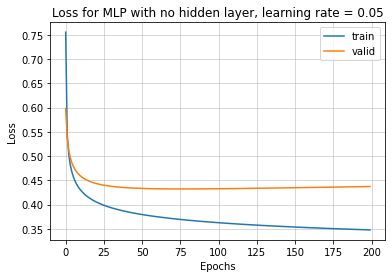

In [ ]:
plt.clf()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss for MLP with no hidden layer, learning rate = 0.05")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

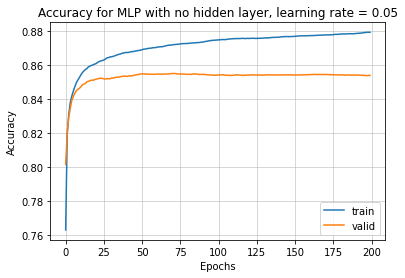

In [ ]:
plt.clf()
plt.plot(train_acc_list, label='train')
plt.plot(val_acc_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy for MLP with no hidden layer, learning rate = 0.05")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
y_test_probs = mlp_no_hidden.predict(x_test, is_test=True)

test_loss = EvaluationUtils.calculate_ce_loss(y_test_probs, y_test)
test_acc = EvaluationUtils.calculate_multi_accuracy(y_test_probs, y_test)

print("Test loss: {}".format(test_loss))
print("Test accuracy: {}".format(test_acc))

Test loss: 0.45165302136052904
Test accuracy: 0.8435


#### MLP with no hidden layer and learning rate of 0.1

In [ ]:
mlp_no_hidden_01 = MLP(
    LinearLayer(n_features, FASHION_MNIST_N_CLASSES),
    SoftmaxOutputLayer()
)

opt_no_hidden_01 = GradientDescentOptimizer(mlp_no_hidden_01, 0.1)
train_loss_list, val_loss_list, train_acc_list, val_acc_list = mlp_no_hidden_01.fit(opt_no_hidden_01, x_train, y_train, x_val, y_val, 
                                                                                 batch_size=MLP_BATCH_SIZE, epochs=MLP_EPOCHS)

  0%|          | 1/200 [00:01<04:53,  1.47s/it]

Epoch: 1, train loss: 0.5291857555821147, train acc: 0.8184047619047625, val loss: 0.5823751524109703, val acc: 0.7997777777777778


  1%|          | 2/200 [00:02<04:46,  1.45s/it]

Epoch: 2, train loss: 0.4521195714008668, train acc: 0.8455952380952384, val loss: 0.5550941334282206, val acc: 0.8129444444444445


  2%|▏         | 3/200 [00:04<04:40,  1.43s/it]

Epoch: 3, train loss: 0.43494349973007324, train acc: 0.8511190476190474, val loss: 0.5452246682557876, val acc: 0.8170555555555555


  2%|▏         | 4/200 [00:05<04:38,  1.42s/it]

Epoch: 4, train loss: 0.4246665013472571, train acc: 0.8543333333333327, val loss: 0.5403328271405066, val acc: 0.82


  2%|▎         | 5/200 [00:07<04:36,  1.42s/it]

Epoch: 5, train loss: 0.4176953555877208, train acc: 0.8564047619047622, val loss: 0.5381091967963583, val acc: 0.821


  3%|▎         | 6/200 [00:08<04:35,  1.42s/it]

Epoch: 6, train loss: 0.4126541828265271, train acc: 0.8584285714285711, val loss: 0.5365989595606417, val acc: 0.8223888888888888


  4%|▎         | 7/200 [00:09<04:32,  1.41s/it]

Epoch: 7, train loss: 0.4083304234372424, train acc: 0.8595476190476193, val loss: 0.5370447676991265, val acc: 0.8218333333333333


  4%|▍         | 8/200 [00:11<04:29,  1.41s/it]

Epoch: 8, train loss: 0.40381657660408715, train acc: 0.8609047619047622, val loss: 0.5377083831420999, val acc: 0.8226111111111111


  4%|▍         | 9/200 [00:12<04:27,  1.40s/it]

Epoch: 9, train loss: 0.40162113824152484, train acc: 0.8616190476190481, val loss: 0.5367901983750796, val acc: 0.8242222222222222


  5%|▌         | 10/200 [00:14<04:26,  1.40s/it]

Epoch: 10, train loss: 0.39780523173562926, train acc: 0.8626190476190481, val loss: 0.5393161091191951, val acc: 0.8237777777777778


  6%|▌         | 11/200 [00:15<04:23,  1.39s/it]

Epoch: 11, train loss: 0.39537563059498926, train acc: 0.8637857142857152, val loss: 0.5398368121015418, val acc: 0.8238888888888889


  6%|▌         | 12/200 [00:16<04:22,  1.40s/it]

Epoch: 12, train loss: 0.3938171516563374, train acc: 0.8643095238095243, val loss: 0.5387714705389798, val acc: 0.8246111111111111


  6%|▋         | 13/200 [00:18<04:20,  1.39s/it]

Epoch: 13, train loss: 0.3912871414072625, train acc: 0.8646428571428573, val loss: 0.5413980785991982, val acc: 0.8237777777777778


  7%|▋         | 14/200 [00:19<04:18,  1.39s/it]

Epoch: 14, train loss: 0.3899716844425362, train acc: 0.8652142857142855, val loss: 0.5414074135208522, val acc: 0.8243333333333334


  8%|▊         | 15/200 [00:21<04:16,  1.39s/it]

Epoch: 15, train loss: 0.38793559568885017, train acc: 0.8659047619047617, val loss: 0.5427230826267296, val acc: 0.8240555555555555


  8%|▊         | 16/200 [00:22<04:13,  1.38s/it]

Epoch: 16, train loss: 0.3871301953411186, train acc: 0.8659999999999997, val loss: 0.5417108425822417, val acc: 0.8251111111111111


  8%|▊         | 17/200 [00:23<04:14,  1.39s/it]

Epoch: 17, train loss: 0.3854600946102547, train acc: 0.8664523809523809, val loss: 0.5438005443463, val acc: 0.8241666666666667


  9%|▉         | 18/200 [00:25<04:14,  1.40s/it]

Epoch: 18, train loss: 0.3837613008990712, train acc: 0.8668809523809523, val loss: 0.5440395632204322, val acc: 0.8238888888888889


 10%|▉         | 19/200 [00:26<04:13,  1.40s/it]

Epoch: 19, train loss: 0.38302389486738836, train acc: 0.8674285714285711, val loss: 0.5435060346681124, val acc: 0.8247777777777778


 10%|█         | 20/200 [00:28<04:11,  1.40s/it]

Epoch: 20, train loss: 0.3817387903742967, train acc: 0.8670952380952375, val loss: 0.5465010051220724, val acc: 0.8243888888888888


 10%|█         | 21/200 [00:29<04:10,  1.40s/it]

Epoch: 21, train loss: 0.38027309031408246, train acc: 0.8676190476190475, val loss: 0.5468476747362274, val acc: 0.8239444444444445


 11%|█         | 22/200 [00:30<04:08,  1.40s/it]

Epoch: 22, train loss: 0.37989252453393646, train acc: 0.8678809523809523, val loss: 0.5458869548066165, val acc: 0.825


 12%|█▏        | 23/200 [00:32<04:06,  1.40s/it]

Epoch: 23, train loss: 0.37867764804035703, train acc: 0.8681904761904762, val loss: 0.548395460195038, val acc: 0.824


 12%|█▏        | 24/200 [00:33<04:03,  1.38s/it]

Epoch: 24, train loss: 0.37771152148717263, train acc: 0.8684761904761901, val loss: 0.5485662433870768, val acc: 0.8238333333333333


 12%|█▎        | 25/200 [00:34<04:00,  1.37s/it]

Epoch: 25, train loss: 0.3766286854111918, train acc: 0.868928571428571, val loss: 0.5492845486655404, val acc: 0.8235555555555556


 13%|█▎        | 26/200 [00:36<03:58,  1.37s/it]

Epoch: 26, train loss: 0.3767744450681847, train acc: 0.8687142857142861, val loss: 0.5480466348115066, val acc: 0.8241666666666667


 14%|█▎        | 27/200 [00:37<03:56,  1.37s/it]

Epoch: 27, train loss: 0.3755957542017472, train acc: 0.8695952380952385, val loss: 0.5502914805295263, val acc: 0.8235555555555556


 14%|█▍        | 28/200 [00:39<03:56,  1.38s/it]

Epoch: 28, train loss: 0.37408558777310014, train acc: 0.8700000000000004, val loss: 0.551103981526653, val acc: 0.8235


 14%|█▍        | 29/200 [00:40<03:55,  1.38s/it]

Epoch: 29, train loss: 0.3739957039871743, train acc: 0.8700714285714288, val loss: 0.5495323681802329, val acc: 0.8248888888888889


 15%|█▌        | 30/200 [00:41<03:53,  1.38s/it]

Epoch: 30, train loss: 0.37295989098387367, train acc: 0.8705952380952383, val loss: 0.552652859156059, val acc: 0.8233888888888888


 16%|█▌        | 31/200 [00:43<03:52,  1.38s/it]

Epoch: 31, train loss: 0.3727206555819314, train acc: 0.8709285714285717, val loss: 0.5526754813284461, val acc: 0.8233888888888888


 16%|█▌        | 32/200 [00:44<03:52,  1.38s/it]

Epoch: 32, train loss: 0.37170257483600927, train acc: 0.8710476190476191, val loss: 0.553092852282284, val acc: 0.8228333333333333


 16%|█▋        | 33/200 [00:45<03:51,  1.39s/it]

Epoch: 33, train loss: 0.37186035251163796, train acc: 0.8709285714285717, val loss: 0.5523315805878896, val acc: 0.8245


 17%|█▋        | 34/200 [00:47<03:50,  1.39s/it]

Epoch: 34, train loss: 0.37085787467882775, train acc: 0.8715000000000005, val loss: 0.554686412887902, val acc: 0.8235555555555556


 18%|█▊        | 35/200 [00:48<03:48,  1.39s/it]

Epoch: 35, train loss: 0.37000059320646056, train acc: 0.8712142857142856, val loss: 0.5551510463686251, val acc: 0.8232222222222222


 18%|█▊        | 36/200 [00:50<03:55,  1.44s/it]

Epoch: 36, train loss: 0.37020047750772317, train acc: 0.8715714285714287, val loss: 0.5527629267629549, val acc: 0.8243888888888888


 18%|█▊        | 37/200 [00:51<03:50,  1.41s/it]

Epoch: 37, train loss: 0.3695043197696848, train acc: 0.8721190476190485, val loss: 0.5561786925213879, val acc: 0.8230555555555555


 19%|█▉        | 38/200 [00:53<03:47,  1.41s/it]

Epoch: 38, train loss: 0.36821088321014406, train acc: 0.8720476190476195, val loss: 0.5563251648135114, val acc: 0.823


 20%|█▉        | 39/200 [00:54<03:44,  1.39s/it]

Epoch: 39, train loss: 0.36828237329551483, train acc: 0.8723809523809527, val loss: 0.5560593115241632, val acc: 0.8239444444444445


 20%|██        | 40/200 [00:55<03:42,  1.39s/it]

Epoch: 40, train loss: 0.3675217560081942, train acc: 0.8724047619047625, val loss: 0.5582464617820924, val acc: 0.8232222222222222


 20%|██        | 41/200 [00:57<03:39,  1.38s/it]

Epoch: 41, train loss: 0.3672916608360455, train acc: 0.8722857142857142, val loss: 0.5581878688303976, val acc: 0.8231111111111111


 21%|██        | 42/200 [00:58<03:37,  1.38s/it]

Epoch: 42, train loss: 0.36645899867047127, train acc: 0.8724523809523815, val loss: 0.5585705955214819, val acc: 0.8227777777777778


 22%|██▏       | 43/200 [00:59<03:35,  1.38s/it]

Epoch: 43, train loss: 0.36695444935826654, train acc: 0.8723095238095241, val loss: 0.557790164604092, val acc: 0.8240555555555555


 22%|██▏       | 44/200 [01:01<03:34,  1.37s/it]

Epoch: 44, train loss: 0.3657029142321572, train acc: 0.8729285714285723, val loss: 0.5599118497265381, val acc: 0.823


 22%|██▎       | 45/200 [01:02<03:33,  1.38s/it]

Epoch: 45, train loss: 0.365493548187869, train acc: 0.8728095238095241, val loss: 0.5605146951990182, val acc: 0.8223333333333334


 23%|██▎       | 46/200 [01:04<03:31,  1.38s/it]

Epoch: 46, train loss: 0.36551744365305155, train acc: 0.8732142857142862, val loss: 0.5588863164254672, val acc: 0.8243333333333334


 24%|██▎       | 47/200 [01:05<03:30,  1.38s/it]

Epoch: 47, train loss: 0.36456973345056, train acc: 0.8732380952380954, val loss: 0.5616178457474622, val acc: 0.8228333333333333


 24%|██▍       | 48/200 [01:06<03:29,  1.38s/it]

Epoch: 48, train loss: 0.3645232356010198, train acc: 0.8735238095238099, val loss: 0.5615768359204965, val acc: 0.8233333333333334


 24%|██▍       | 49/200 [01:08<03:29,  1.39s/it]

Epoch: 49, train loss: 0.36406629692308745, train acc: 0.87352380952381, val loss: 0.5622262818935526, val acc: 0.8228888888888889


 25%|██▌       | 50/200 [01:09<03:26,  1.38s/it]

Epoch: 50, train loss: 0.3640866827362705, train acc: 0.8735952380952385, val loss: 0.560423516405156, val acc: 0.8241666666666667


 26%|██▌       | 51/200 [01:10<03:26,  1.38s/it]

Epoch: 51, train loss: 0.3632883154831508, train acc: 0.8738809523809528, val loss: 0.5632665442560014, val acc: 0.8225555555555556


 26%|██▌       | 52/200 [01:12<03:24,  1.38s/it]

Epoch: 52, train loss: 0.36265352503028375, train acc: 0.8739285714285718, val loss: 0.5632201065756967, val acc: 0.8228333333333333


 26%|██▋       | 53/200 [01:13<03:24,  1.39s/it]

Epoch: 53, train loss: 0.36292184261009247, train acc: 0.8740000000000006, val loss: 0.5631842348037958, val acc: 0.8232777777777778


 27%|██▋       | 54/200 [01:15<03:23,  1.39s/it]

Epoch: 54, train loss: 0.36214817085921325, train acc: 0.8743333333333331, val loss: 0.564449071165611, val acc: 0.823


 28%|██▊       | 55/200 [01:16<03:20,  1.38s/it]

Epoch: 55, train loss: 0.3623498721913916, train acc: 0.8741428571428579, val loss: 0.5649871540010131, val acc: 0.8226666666666667


 28%|██▊       | 56/200 [01:17<03:18,  1.38s/it]

Epoch: 56, train loss: 0.3618080651029473, train acc: 0.8741190476190478, val loss: 0.5649712356616339, val acc: 0.8228888888888889


 28%|██▊       | 57/200 [01:19<03:16,  1.37s/it]

Epoch: 57, train loss: 0.3620066231379548, train acc: 0.8742142857142857, val loss: 0.5637900526860522, val acc: 0.8237777777777778


 29%|██▉       | 58/200 [01:20<03:14,  1.37s/it]

Epoch: 58, train loss: 0.3611017923666806, train acc: 0.8745476190476187, val loss: 0.5656206462666864, val acc: 0.8232777777777778


 30%|██▉       | 59/200 [01:21<03:13,  1.37s/it]

Epoch: 59, train loss: 0.36064958913457384, train acc: 0.8744761904761905, val loss: 0.5665552395326157, val acc: 0.8226666666666667


 30%|███       | 60/200 [01:23<03:10,  1.36s/it]

Epoch: 60, train loss: 0.36059050210163784, train acc: 0.8745238095238091, val loss: 0.5652934587476856, val acc: 0.8238888888888889


 30%|███       | 61/200 [01:24<03:09,  1.36s/it]

Epoch: 61, train loss: 0.3605908068434196, train acc: 0.8745000000000005, val loss: 0.5678897606427497, val acc: 0.8225


 31%|███       | 62/200 [01:26<03:08,  1.37s/it]

Epoch: 62, train loss: 0.3599579918802587, train acc: 0.8749285714285711, val loss: 0.5673679387286077, val acc: 0.8231111111111111


 32%|███▏      | 63/200 [01:27<03:07,  1.37s/it]

Epoch: 63, train loss: 0.35960739911046546, train acc: 0.8749761904761905, val loss: 0.5681299070964608, val acc: 0.823


 32%|███▏      | 64/200 [01:28<03:05,  1.37s/it]

Epoch: 64, train loss: 0.35996737844778415, train acc: 0.8744761904761904, val loss: 0.5674500042497532, val acc: 0.8234444444444444


 32%|███▎      | 65/200 [01:30<03:05,  1.37s/it]

Epoch: 65, train loss: 0.3593983036346002, train acc: 0.8748571428571429, val loss: 0.5690489571387142, val acc: 0.8230555555555555


 33%|███▎      | 66/200 [01:31<03:07,  1.40s/it]

Epoch: 66, train loss: 0.35924257128145715, train acc: 0.8748809523809521, val loss: 0.5691694045661819, val acc: 0.8231666666666667


 34%|███▎      | 67/200 [01:33<03:06,  1.40s/it]

Epoch: 67, train loss: 0.35851785812831727, train acc: 0.8749523809523813, val loss: 0.5691178182906054, val acc: 0.823


 34%|███▍      | 68/200 [01:34<03:03,  1.39s/it]

Epoch: 68, train loss: 0.3591340151659753, train acc: 0.8747142857142859, val loss: 0.5687280044124653, val acc: 0.8236111111111111


 34%|███▍      | 69/200 [01:35<03:00,  1.38s/it]

Epoch: 69, train loss: 0.3581972000669778, train acc: 0.8753571428571427, val loss: 0.5700919657032528, val acc: 0.8233333333333334


 35%|███▌      | 70/200 [01:37<03:00,  1.39s/it]

Epoch: 70, train loss: 0.3578026378836141, train acc: 0.8755476190476188, val loss: 0.571181774545764, val acc: 0.8229444444444445


 36%|███▌      | 71/200 [01:38<02:57,  1.38s/it]

Epoch: 71, train loss: 0.35810137678592646, train acc: 0.8751428571428569, val loss: 0.5712294323308101, val acc: 0.8233888888888888


 36%|███▌      | 72/200 [01:39<02:55,  1.37s/it]

Epoch: 72, train loss: 0.35782662304453644, train acc: 0.8755952380952375, val loss: 0.5713489201887243, val acc: 0.8235


 36%|███▋      | 73/200 [01:41<02:55,  1.38s/it]

Epoch: 73, train loss: 0.3578734437361277, train acc: 0.8751190476190475, val loss: 0.5718530416175515, val acc: 0.8231666666666667


 37%|███▋      | 74/200 [01:42<02:55,  1.39s/it]

Epoch: 74, train loss: 0.3574741617595948, train acc: 0.8753095238095235, val loss: 0.5713279352599605, val acc: 0.8232222222222222


 38%|███▊      | 75/200 [01:44<02:53,  1.39s/it]

Epoch: 75, train loss: 0.3573262545527829, train acc: 0.8753809523809521, val loss: 0.5703397580177192, val acc: 0.8245


 38%|███▊      | 76/200 [01:45<02:53,  1.40s/it]

Epoch: 76, train loss: 0.3568772448591917, train acc: 0.8757142857142856, val loss: 0.5732385485749903, val acc: 0.8227222222222222


 38%|███▊      | 77/200 [01:46<02:51,  1.40s/it]

Epoch: 77, train loss: 0.35648766710498814, train acc: 0.8757142857142853, val loss: 0.573058867359968, val acc: 0.8232777777777778


 39%|███▉      | 78/200 [01:48<02:49,  1.39s/it]

Epoch: 78, train loss: 0.3568736188265331, train acc: 0.8757380952380954, val loss: 0.5724911548393151, val acc: 0.8236111111111111


 40%|███▉      | 79/200 [01:49<02:48,  1.39s/it]

Epoch: 79, train loss: 0.35597633402360535, train acc: 0.8760714285714283, val loss: 0.5734878886804696, val acc: 0.8228888888888889


 40%|████      | 80/200 [01:51<02:46,  1.39s/it]

Epoch: 80, train loss: 0.35605221351748606, train acc: 0.8761190476190471, val loss: 0.5741336914628935, val acc: 0.8230555555555555


 40%|████      | 81/200 [01:52<02:45,  1.39s/it]

Epoch: 81, train loss: 0.35606570397519083, train acc: 0.8759047619047613, val loss: 0.5747289119946019, val acc: 0.8228888888888889


 41%|████      | 82/200 [01:53<02:43,  1.38s/it]

Epoch: 82, train loss: 0.35573507873928456, train acc: 0.8761190476190472, val loss: 0.5744933882315806, val acc: 0.8230555555555555


 42%|████▏     | 83/200 [01:55<02:41,  1.38s/it]

Epoch: 83, train loss: 0.3551685433027842, train acc: 0.8764285714285714, val loss: 0.5755245860821735, val acc: 0.823


 42%|████▏     | 84/200 [01:56<02:41,  1.39s/it]

Epoch: 84, train loss: 0.3556508668311076, train acc: 0.8759047619047616, val loss: 0.5753991963469469, val acc: 0.8230555555555555


 42%|████▎     | 85/200 [01:57<02:39,  1.39s/it]

Epoch: 85, train loss: 0.35525366651338613, train acc: 0.8762619047619046, val loss: 0.5759154949456111, val acc: 0.8229444444444445


 43%|████▎     | 86/200 [01:59<02:37,  1.38s/it]

Epoch: 86, train loss: 0.35533299563730947, train acc: 0.8763333333333335, val loss: 0.5769810150709054, val acc: 0.8227222222222222


 44%|████▎     | 87/200 [02:00<02:36,  1.38s/it]

Epoch: 87, train loss: 0.35486379396358647, train acc: 0.876190476190476, val loss: 0.5764007912792423, val acc: 0.8227222222222222


 44%|████▍     | 88/200 [02:02<02:36,  1.40s/it]

Epoch: 88, train loss: 0.35517091497597914, train acc: 0.8760476190476187, val loss: 0.5754382830569085, val acc: 0.8235


 44%|████▍     | 89/200 [02:03<02:35,  1.40s/it]

Epoch: 89, train loss: 0.35485661615576397, train acc: 0.8763571428571427, val loss: 0.5775909219399454, val acc: 0.8226111111111111


 45%|████▌     | 90/200 [02:04<02:34,  1.40s/it]

Epoch: 90, train loss: 0.35425898352305707, train acc: 0.8764999999999996, val loss: 0.5772783611907663, val acc: 0.8225555555555556


 46%|████▌     | 91/200 [02:06<02:32,  1.40s/it]

Epoch: 91, train loss: 0.3540557720292512, train acc: 0.8763571428571427, val loss: 0.5773917287299308, val acc: 0.8226666666666667


 46%|████▌     | 92/200 [02:07<02:30,  1.40s/it]

Epoch: 92, train loss: 0.3536886581086746, train acc: 0.8766904761904756, val loss: 0.5786069792202924, val acc: 0.8223333333333334


 46%|████▋     | 93/200 [02:09<02:28,  1.39s/it]

Epoch: 93, train loss: 0.3542439553313247, train acc: 0.8762142857142854, val loss: 0.5788255208214294, val acc: 0.8226111111111111


 47%|████▋     | 94/200 [02:10<02:27,  1.39s/it]

Epoch: 94, train loss: 0.35382448102231273, train acc: 0.8764523809523804, val loss: 0.5787534903435106, val acc: 0.8227222222222222


 48%|████▊     | 95/200 [02:11<02:25,  1.39s/it]

Epoch: 95, train loss: 0.35381212649481125, train acc: 0.8766666666666666, val loss: 0.5773183120974549, val acc: 0.8233333333333334


 48%|████▊     | 96/200 [02:13<02:24,  1.39s/it]

Epoch: 96, train loss: 0.3532951398824606, train acc: 0.8766666666666663, val loss: 0.5801650606350639, val acc: 0.8225


 48%|████▊     | 97/200 [02:14<02:23,  1.39s/it]

Epoch: 97, train loss: 0.3533852256683214, train acc: 0.8764523809523808, val loss: 0.5798321393430235, val acc: 0.8226111111111111


 49%|████▉     | 98/200 [02:16<02:22,  1.39s/it]

Epoch: 98, train loss: 0.3534847076433202, train acc: 0.8768333333333335, val loss: 0.579505533364942, val acc: 0.8228888888888889


 50%|████▉     | 99/200 [02:17<02:20,  1.40s/it]

Epoch: 99, train loss: 0.35287145645856494, train acc: 0.8766904761904759, val loss: 0.5808403007612556, val acc: 0.8225555555555556


 50%|█████     | 100/200 [02:18<02:20,  1.40s/it]

Epoch: 100, train loss: 0.3532329483644539, train acc: 0.8765476190476187, val loss: 0.5790573577619309, val acc: 0.8233333333333334


 50%|█████     | 101/200 [02:20<02:19,  1.41s/it]

Epoch: 101, train loss: 0.3528407052004035, train acc: 0.8768095238095238, val loss: 0.5815702028409917, val acc: 0.8225


 51%|█████     | 102/200 [02:21<02:18,  1.41s/it]

Epoch: 102, train loss: 0.35250167378471015, train acc: 0.8767142857142857, val loss: 0.5816373253024202, val acc: 0.8226666666666667


 52%|█████▏    | 103/200 [02:23<02:36,  1.62s/it]

Epoch: 103, train loss: 0.35251685880822936, train acc: 0.8771666666666664, val loss: 0.5815736678475494, val acc: 0.8231666666666667


 52%|█████▏    | 104/200 [02:26<02:53,  1.81s/it]

Epoch: 104, train loss: 0.35232907518283096, train acc: 0.8770952380952379, val loss: 0.5822792535757451, val acc: 0.8227222222222222


 52%|█████▎    | 105/200 [02:27<02:40,  1.69s/it]

Epoch: 105, train loss: 0.3523039633815135, train acc: 0.8769999999999992, val loss: 0.5814599433189237, val acc: 0.8235


 53%|█████▎    | 106/200 [02:28<02:29,  1.59s/it]

Epoch: 106, train loss: 0.35187642089667753, train acc: 0.8773333333333332, val loss: 0.5827968775342747, val acc: 0.8228333333333333


 54%|█████▎    | 107/200 [02:30<02:22,  1.54s/it]

Epoch: 107, train loss: 0.3525172055296153, train acc: 0.877047619047619, val loss: 0.5827380347003228, val acc: 0.8231111111111111


 54%|█████▍    | 108/200 [02:31<02:17,  1.49s/it]

Epoch: 108, train loss: 0.3521978856029062, train acc: 0.8768333333333328, val loss: 0.582588425941395, val acc: 0.823


 55%|█████▍    | 109/200 [02:33<02:13,  1.47s/it]

Epoch: 109, train loss: 0.35205091958347473, train acc: 0.8769761904761904, val loss: 0.5828728084137289, val acc: 0.8230555555555555


 55%|█████▌    | 110/200 [02:34<02:10,  1.45s/it]

Epoch: 110, train loss: 0.3515813580958641, train acc: 0.8770952380952376, val loss: 0.5838228931384808, val acc: 0.8228333333333333


 56%|█████▌    | 111/200 [02:35<02:06,  1.43s/it]

Epoch: 111, train loss: 0.35147776915377044, train acc: 0.8774285714285711, val loss: 0.5840099812238022, val acc: 0.8229444444444445


 56%|█████▌    | 112/200 [02:37<02:04,  1.41s/it]

Epoch: 112, train loss: 0.3509948354069825, train acc: 0.8775476190476188, val loss: 0.5839651144481101, val acc: 0.8227222222222222


 56%|█████▋    | 113/200 [02:38<02:01,  1.40s/it]

Epoch: 113, train loss: 0.3513796342919678, train acc: 0.8775952380952375, val loss: 0.5830318433039924, val acc: 0.8236666666666667


 57%|█████▋    | 114/200 [02:40<02:00,  1.40s/it]

Epoch: 114, train loss: 0.35109508528911915, train acc: 0.8771666666666663, val loss: 0.5854042102327099, val acc: 0.8227777777777778


 57%|█████▊    | 115/200 [02:41<01:58,  1.40s/it]

Epoch: 115, train loss: 0.3510967659059727, train acc: 0.8774523809523803, val loss: 0.5851916644839623, val acc: 0.8227777777777778


 58%|█████▊    | 116/200 [02:42<01:56,  1.39s/it]

Epoch: 116, train loss: 0.3507212160937834, train acc: 0.8773333333333329, val loss: 0.5858717035901201, val acc: 0.8226111111111111


 58%|█████▊    | 117/200 [02:44<01:56,  1.40s/it]

Epoch: 117, train loss: 0.35070907297944437, train acc: 0.8775952380952379, val loss: 0.5852275315825065, val acc: 0.8228888888888889


 59%|█████▉    | 118/200 [02:45<01:55,  1.40s/it]

Epoch: 118, train loss: 0.35042850669909203, train acc: 0.877428571428571, val loss: 0.5866021791191154, val acc: 0.8220555555555555


 60%|█████▉    | 119/200 [02:47<01:52,  1.39s/it]

Epoch: 119, train loss: 0.35043981767710597, train acc: 0.8774523809523808, val loss: 0.5863044731798596, val acc: 0.8221111111111111


 60%|██████    | 120/200 [02:48<01:51,  1.39s/it]

Epoch: 120, train loss: 0.35029696381308956, train acc: 0.8773809523809518, val loss: 0.5863890729212502, val acc: 0.8224444444444444


 60%|██████    | 121/200 [02:49<01:49,  1.39s/it]

Epoch: 121, train loss: 0.35089149001908376, train acc: 0.8777619047619046, val loss: 0.5874199703813113, val acc: 0.8220555555555555


 61%|██████    | 122/200 [02:51<01:47,  1.38s/it]

Epoch: 122, train loss: 0.35039258678223684, train acc: 0.8774523809523803, val loss: 0.5861342505103692, val acc: 0.8225555555555556


 62%|██████▏   | 123/200 [02:52<01:45,  1.38s/it]

Epoch: 123, train loss: 0.35058595442817375, train acc: 0.8779999999999993, val loss: 0.5858274802377471, val acc: 0.8231666666666667


 62%|██████▏   | 124/200 [02:53<01:44,  1.37s/it]

Epoch: 124, train loss: 0.3500219215358281, train acc: 0.8777142857142852, val loss: 0.5880871945504819, val acc: 0.8226111111111111


 62%|██████▎   | 125/200 [02:55<01:42,  1.37s/it]

Epoch: 125, train loss: 0.34982616734144223, train acc: 0.8778095238095234, val loss: 0.5881360045620353, val acc: 0.8224444444444444


 63%|██████▎   | 126/200 [02:56<01:41,  1.37s/it]

Epoch: 126, train loss: 0.34988111626281415, train acc: 0.8778095238095236, val loss: 0.588228984954957, val acc: 0.8226111111111111


 64%|██████▎   | 127/200 [02:57<01:39,  1.37s/it]

Epoch: 127, train loss: 0.3495608184972049, train acc: 0.8778333333333328, val loss: 0.5884640876827691, val acc: 0.8226666666666667


 64%|██████▍   | 128/200 [02:59<01:38,  1.36s/it]

Epoch: 128, train loss: 0.3498181921968088, train acc: 0.8776666666666662, val loss: 0.5878747893224633, val acc: 0.8228888888888889


 64%|██████▍   | 129/200 [03:00<01:36,  1.36s/it]

Epoch: 129, train loss: 0.3493318563319751, train acc: 0.8776904761904758, val loss: 0.5893170835041092, val acc: 0.8225


 65%|██████▌   | 130/200 [03:02<01:35,  1.37s/it]

Epoch: 130, train loss: 0.3491609021113191, train acc: 0.8779047619047614, val loss: 0.5895009200994703, val acc: 0.8221666666666667


 66%|██████▌   | 131/200 [03:03<01:34,  1.38s/it]

Epoch: 131, train loss: 0.34908217140466863, train acc: 0.8779285714285711, val loss: 0.5889981250791261, val acc: 0.8226666666666667


 66%|██████▌   | 132/200 [03:04<01:34,  1.39s/it]

Epoch: 132, train loss: 0.3490868604187018, train acc: 0.8780476190476189, val loss: 0.5898760949693428, val acc: 0.8222777777777778


 66%|██████▋   | 133/200 [03:06<01:32,  1.38s/it]

Epoch: 133, train loss: 0.3492246455675922, train acc: 0.8779761904761898, val loss: 0.5898850568876377, val acc: 0.8223888888888888


 67%|██████▋   | 134/200 [03:07<01:31,  1.38s/it]

Epoch: 134, train loss: 0.349021139001422, train acc: 0.8779999999999994, val loss: 0.5901980990873601, val acc: 0.8227222222222222


 68%|██████▊   | 135/200 [03:08<01:30,  1.39s/it]

Epoch: 135, train loss: 0.348903448485536, train acc: 0.8780476190476183, val loss: 0.5903779850626439, val acc: 0.8223888888888888


 68%|██████▊   | 136/200 [03:10<01:28,  1.38s/it]

Epoch: 136, train loss: 0.34860624457657396, train acc: 0.8779523809523806, val loss: 0.5909625369566871, val acc: 0.8223888888888888


 68%|██████▊   | 137/200 [03:11<01:26,  1.37s/it]

Epoch: 137, train loss: 0.3487247638144051, train acc: 0.878166666666666, val loss: 0.5907542134041697, val acc: 0.8226111111111111


 69%|██████▉   | 138/200 [03:13<01:25,  1.37s/it]

Epoch: 138, train loss: 0.3486654274538481, train acc: 0.8783809523809517, val loss: 0.591512441719015, val acc: 0.8217777777777778


 70%|██████▉   | 139/200 [03:14<01:23,  1.37s/it]

Epoch: 139, train loss: 0.34867307686250176, train acc: 0.878166666666666, val loss: 0.5911324473477505, val acc: 0.8225555555555556


 70%|███████   | 140/200 [03:15<01:22,  1.38s/it]

Epoch: 140, train loss: 0.348536516641459, train acc: 0.8783333333333325, val loss: 0.5919179624736269, val acc: 0.8222222222222222


 70%|███████   | 141/200 [03:17<01:21,  1.38s/it]

Epoch: 141, train loss: 0.3482709046201764, train acc: 0.8784285714285708, val loss: 0.5920450940507624, val acc: 0.8224444444444444


 71%|███████   | 142/200 [03:18<01:19,  1.37s/it]

Epoch: 142, train loss: 0.3484732087240565, train acc: 0.8785238095238093, val loss: 0.591767241024391, val acc: 0.8226111111111111


 72%|███████▏  | 143/200 [03:19<01:18,  1.38s/it]

Epoch: 143, train loss: 0.34824542879567155, train acc: 0.8783571428571426, val loss: 0.592716368613622, val acc: 0.8218333333333333


 72%|███████▏  | 144/200 [03:21<01:17,  1.38s/it]

Epoch: 144, train loss: 0.34843500923499604, train acc: 0.8787142857142852, val loss: 0.5922793876915055, val acc: 0.8221666666666667


 72%|███████▎  | 145/200 [03:22<01:15,  1.38s/it]

Epoch: 145, train loss: 0.3480420211900092, train acc: 0.8787380952380943, val loss: 0.5931360178898836, val acc: 0.8217777777777778


 73%|███████▎  | 146/200 [03:24<01:14,  1.37s/it]

Epoch: 146, train loss: 0.34801547631484414, train acc: 0.8787142857142852, val loss: 0.592686089116198, val acc: 0.8222777777777778


 74%|███████▎  | 147/200 [03:25<01:13,  1.38s/it]

Epoch: 147, train loss: 0.3476563063118158, train acc: 0.8786190476190464, val loss: 0.5939146627479897, val acc: 0.8219444444444445


 74%|███████▍  | 148/200 [03:26<01:11,  1.38s/it]

Epoch: 148, train loss: 0.3479821075630366, train acc: 0.878428571428571, val loss: 0.5940382899795789, val acc: 0.8215555555555556


 74%|███████▍  | 149/200 [03:28<01:10,  1.38s/it]

Epoch: 149, train loss: 0.3478809124078556, train acc: 0.8785714285714277, val loss: 0.5934906498437569, val acc: 0.8221111111111111


 75%|███████▌  | 150/200 [03:29<01:09,  1.39s/it]

Epoch: 150, train loss: 0.3478107249807987, train acc: 0.8789285714285707, val loss: 0.5942589888342987, val acc: 0.8217222222222222


 76%|███████▌  | 151/200 [03:31<01:07,  1.38s/it]

Epoch: 151, train loss: 0.34738308922023775, train acc: 0.8789285714285707, val loss: 0.5942995795493766, val acc: 0.8223888888888888


 76%|███████▌  | 152/200 [03:32<01:06,  1.38s/it]

Epoch: 152, train loss: 0.347575965940943, train acc: 0.8789285714285708, val loss: 0.593491070008697, val acc: 0.823


 76%|███████▋  | 153/200 [03:33<01:04,  1.37s/it]

Epoch: 153, train loss: 0.34730066323327435, train acc: 0.8787380952380947, val loss: 0.5951608399734892, val acc: 0.8221666666666667


 77%|███████▋  | 154/200 [03:35<01:02,  1.37s/it]

Epoch: 154, train loss: 0.3474882933027687, train acc: 0.8788333333333328, val loss: 0.5951364736782047, val acc: 0.8221111111111111


 78%|███████▊  | 155/200 [03:36<01:01,  1.37s/it]

Epoch: 155, train loss: 0.3471262426316107, train acc: 0.8789761904761895, val loss: 0.5960645375950185, val acc: 0.8221666666666667


 78%|███████▊  | 156/200 [03:37<01:00,  1.37s/it]

Epoch: 156, train loss: 0.3471122066226822, train acc: 0.879166666666666, val loss: 0.5946488637142683, val acc: 0.8227222222222222


 78%|███████▊  | 157/200 [03:39<00:58,  1.37s/it]

Epoch: 157, train loss: 0.3473310345859308, train acc: 0.8788333333333321, val loss: 0.59563962682694, val acc: 0.8218888888888889


 79%|███████▉  | 158/200 [03:40<00:57,  1.36s/it]

Epoch: 158, train loss: 0.3469029117380382, train acc: 0.8789999999999988, val loss: 0.5952701345340712, val acc: 0.8225


 80%|███████▉  | 159/200 [03:41<00:56,  1.37s/it]

Epoch: 159, train loss: 0.3469305838300683, train acc: 0.8790952380952374, val loss: 0.596423678237144, val acc: 0.822


 80%|████████  | 160/200 [03:43<00:54,  1.37s/it]

Epoch: 160, train loss: 0.34667949709675044, train acc: 0.8792619047619037, val loss: 0.5961206901486334, val acc: 0.8221666666666667


 80%|████████  | 161/200 [03:44<00:53,  1.38s/it]

Epoch: 161, train loss: 0.34702104139182427, train acc: 0.879166666666666, val loss: 0.5963386231327201, val acc: 0.8220555555555555


 81%|████████  | 162/200 [03:46<00:52,  1.38s/it]

Epoch: 162, train loss: 0.34673148951032934, train acc: 0.879119047619047, val loss: 0.5971951140367423, val acc: 0.8221111111111111


 82%|████████▏ | 163/200 [03:47<00:51,  1.38s/it]

Epoch: 163, train loss: 0.3466305161816462, train acc: 0.8791190476190468, val loss: 0.5971539108909308, val acc: 0.822


 82%|████████▏ | 164/200 [03:48<00:49,  1.38s/it]

Epoch: 164, train loss: 0.34624588537812306, train acc: 0.8793571428571421, val loss: 0.5978588630670623, val acc: 0.8217222222222222


 82%|████████▎ | 165/200 [03:50<00:48,  1.38s/it]

Epoch: 165, train loss: 0.34663640380731875, train acc: 0.8790714285714283, val loss: 0.5980209071985565, val acc: 0.8217222222222222


 83%|████████▎ | 166/200 [03:51<00:46,  1.38s/it]

Epoch: 166, train loss: 0.34652217458725587, train acc: 0.8788571428571419, val loss: 0.5975676337300859, val acc: 0.8221666666666667


 84%|████████▎ | 167/200 [03:53<00:45,  1.38s/it]

Epoch: 167, train loss: 0.34668241182490717, train acc: 0.8792142857142846, val loss: 0.5973092604931036, val acc: 0.8222777777777778


 84%|████████▍ | 168/200 [03:54<00:43,  1.37s/it]

Epoch: 168, train loss: 0.3461126436436634, train acc: 0.8794523809523801, val loss: 0.5984356088631402, val acc: 0.8221666666666667


 84%|████████▍ | 169/200 [03:55<00:42,  1.38s/it]

Epoch: 169, train loss: 0.34647353277022147, train acc: 0.8792142857142847, val loss: 0.5984152289487115, val acc: 0.8219444444444445


 85%|████████▌ | 170/200 [03:57<00:41,  1.38s/it]

Epoch: 170, train loss: 0.3461201968874091, train acc: 0.8794285714285706, val loss: 0.5987128901462929, val acc: 0.8218888888888889


 86%|████████▌ | 171/200 [03:58<00:40,  1.38s/it]

Epoch: 171, train loss: 0.3462342329901146, train acc: 0.8794285714285707, val loss: 0.5985628278567872, val acc: 0.8222777777777778


 86%|████████▌ | 172/200 [03:59<00:38,  1.38s/it]

Epoch: 172, train loss: 0.3458352826333361, train acc: 0.8792142857142847, val loss: 0.5990583826144866, val acc: 0.8219444444444445


 86%|████████▋ | 173/200 [04:01<00:37,  1.37s/it]

Epoch: 173, train loss: 0.34609533161611566, train acc: 0.8795476190476181, val loss: 0.5994532720114161, val acc: 0.8218888888888889


 87%|████████▋ | 174/200 [04:02<00:35,  1.38s/it]

Epoch: 174, train loss: 0.345775335065829, train acc: 0.8794523809523803, val loss: 0.6000482868978804, val acc: 0.8217222222222222


 88%|████████▊ | 175/200 [04:04<00:34,  1.38s/it]

Epoch: 175, train loss: 0.34588680521843956, train acc: 0.8792619047619037, val loss: 0.5999221776546025, val acc: 0.8217777777777778


 88%|████████▊ | 176/200 [04:05<00:33,  1.38s/it]

Epoch: 176, train loss: 0.34543569562940174, train acc: 0.8795476190476182, val loss: 0.5999157878716928, val acc: 0.8221666666666667


 88%|████████▊ | 177/200 [04:06<00:31,  1.38s/it]

Epoch: 177, train loss: 0.3456682396374995, train acc: 0.8796428571428566, val loss: 0.600039039429034, val acc: 0.822


 89%|████████▉ | 178/200 [04:08<00:30,  1.38s/it]

Epoch: 178, train loss: 0.34566698255839, train acc: 0.8795952380952374, val loss: 0.6007604319101341, val acc: 0.8222222222222222


 90%|████████▉ | 179/200 [04:09<00:28,  1.38s/it]

Epoch: 179, train loss: 0.3457496760018026, train acc: 0.8792380952380945, val loss: 0.6012176867847494, val acc: 0.8218888888888889


 90%|█████████ | 180/200 [04:10<00:27,  1.38s/it]

Epoch: 180, train loss: 0.34538891800830085, train acc: 0.8797619047619041, val loss: 0.6009681094918592, val acc: 0.8218888888888889


 90%|█████████ | 181/200 [04:12<00:26,  1.39s/it]

Epoch: 181, train loss: 0.3454331169988706, train acc: 0.8797142857142853, val loss: 0.6015678351667662, val acc: 0.8211111111111111


 91%|█████████ | 182/200 [04:13<00:24,  1.39s/it]

Epoch: 182, train loss: 0.34533050713683555, train acc: 0.8798809523809512, val loss: 0.6012547044077335, val acc: 0.8217222222222222


 92%|█████████▏| 183/200 [04:15<00:23,  1.39s/it]

Epoch: 183, train loss: 0.3453774634226845, train acc: 0.8800238095238091, val loss: 0.6016370099868349, val acc: 0.8213888888888888


 92%|█████████▏| 184/200 [04:16<00:22,  1.39s/it]

Epoch: 184, train loss: 0.34506162545755015, train acc: 0.8800952380952372, val loss: 0.6014357476122297, val acc: 0.8219444444444445


 92%|█████████▎| 185/200 [04:17<00:20,  1.39s/it]

Epoch: 185, train loss: 0.3454973946574818, train acc: 0.8799285714285708, val loss: 0.6016028262792988, val acc: 0.8217222222222222


 93%|█████████▎| 186/200 [04:19<00:19,  1.39s/it]

Epoch: 186, train loss: 0.3452714847855429, train acc: 0.8797857142857137, val loss: 0.6022633236448265, val acc: 0.8219444444444445


 94%|█████████▎| 187/200 [04:20<00:18,  1.39s/it]

Epoch: 187, train loss: 0.34533373865391886, train acc: 0.8799761904761896, val loss: 0.6019465320888259, val acc: 0.8223333333333334


 94%|█████████▍| 188/200 [04:22<00:16,  1.40s/it]

Epoch: 188, train loss: 0.34481149653841175, train acc: 0.8801904761904749, val loss: 0.6031649828554082, val acc: 0.8217777777777778


 94%|█████████▍| 189/200 [04:23<00:15,  1.40s/it]

Epoch: 189, train loss: 0.3447917339220829, train acc: 0.8800952380952378, val loss: 0.6033412185743801, val acc: 0.8213333333333334


 95%|█████████▌| 190/200 [04:24<00:13,  1.39s/it]

Epoch: 190, train loss: 0.3448396927499869, train acc: 0.8798571428571421, val loss: 0.6026554612438947, val acc: 0.8218888888888889


 96%|█████████▌| 191/200 [04:26<00:12,  1.40s/it]

Epoch: 191, train loss: 0.3447168871345637, train acc: 0.8799999999999993, val loss: 0.6032162747769162, val acc: 0.8216666666666667


 96%|█████████▌| 192/200 [04:27<00:11,  1.39s/it]

Epoch: 192, train loss: 0.34471663544262215, train acc: 0.8801666666666663, val loss: 0.603069166954757, val acc: 0.8218888888888889


 96%|█████████▋| 193/200 [04:29<00:09,  1.39s/it]

Epoch: 193, train loss: 0.3446473002999707, train acc: 0.8799999999999991, val loss: 0.6034824713426263, val acc: 0.8221111111111111


 97%|█████████▋| 194/200 [04:30<00:08,  1.40s/it]

Epoch: 194, train loss: 0.3446368032711965, train acc: 0.8802380952380943, val loss: 0.6031265706362202, val acc: 0.8218333333333333


 98%|█████████▊| 195/200 [04:31<00:06,  1.39s/it]

Epoch: 195, train loss: 0.34459252576889093, train acc: 0.8800476190476186, val loss: 0.6034184017502832, val acc: 0.8218888888888889


 98%|█████████▊| 196/200 [04:33<00:05,  1.39s/it]

Epoch: 196, train loss: 0.344566342633961, train acc: 0.8800714285714277, val loss: 0.6043509969280817, val acc: 0.8218888888888889


 98%|█████████▊| 197/200 [04:34<00:04,  1.38s/it]

Epoch: 197, train loss: 0.3443360958584789, train acc: 0.8802619047619035, val loss: 0.6043999087092281, val acc: 0.8216111111111111


 99%|█████████▉| 198/200 [04:35<00:02,  1.37s/it]

Epoch: 198, train loss: 0.34438003078502305, train acc: 0.8803809523809517, val loss: 0.6044267645669446, val acc: 0.8215555555555556


100%|█████████▉| 199/200 [04:37<00:01,  1.37s/it]

Epoch: 199, train loss: 0.34443503305375056, train acc: 0.8800476190476183, val loss: 0.6055098712549288, val acc: 0.8210555555555555


100%|██████████| 200/200 [04:38<00:00,  1.39s/it]

Epoch: 200, train loss: 0.34439671384801496, train acc: 0.8800714285714278, val loss: 0.6048605181553971, val acc: 0.8217222222222222


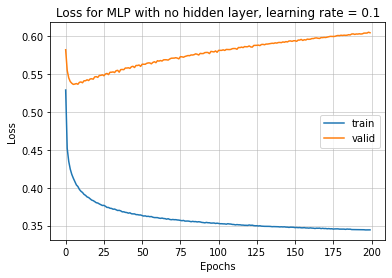

In [ ]:
plt.clf()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss for MLP with no hidden layer, learning rate = 0.1")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

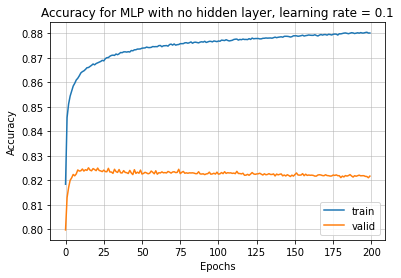

In [ ]:
plt.clf()
plt.plot(train_acc_list, label='train')
plt.plot(val_acc_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy for MLP with no hidden layer, learning rate = 0.1")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
y_test_probs = mlp_no_hidden_01.predict(x_test, is_test=True)

test_loss = EvaluationUtils.calculate_ce_loss(y_test_probs, y_test)
test_acc = EvaluationUtils.calculate_multi_accuracy(y_test_probs, y_test)

print("Test loss: {}".format(test_loss))
print("Test accuracy: {}".format(test_acc))

Test loss: 0.5604806285724233
Test accuracy: 0.8102


#### MLP with no hidden layer and learning rate of 0.5

In [ ]:
mlp_no_hidden_05 = MLP(
    LinearLayer(n_features, FASHION_MNIST_N_CLASSES),
    SoftmaxOutputLayer()
)

opt_no_hidden_05 = GradientDescentOptimizer(mlp_no_hidden_05, 0.5)
train_loss_list, val_loss_list, train_acc_list, val_acc_list = mlp_no_hidden_05.fit(opt_no_hidden_05, x_train, y_train, x_val, y_val, 
                                                                                 batch_size=MLP_BATCH_SIZE, epochs=MLP_EPOCHS)

  0%|          | 1/200 [00:01<04:35,  1.38s/it]

Epoch: 1, train loss: 1.5158779634392303, train acc: 0.771261904761905, val loss: 1.9062507312477053, val acc: 0.7283888888888889


  1%|          | 2/200 [00:02<04:36,  1.40s/it]

Epoch: 2, train loss: 1.2270316258328224, train acc: 0.8038333333333337, val loss: 2.487665998465036, val acc: 0.7124444444444444


  2%|▏         | 3/200 [00:04<04:34,  1.39s/it]

Epoch: 3, train loss: 1.1692408344250242, train acc: 0.8096904761904762, val loss: 1.7847745865797484, val acc: 0.7441111111111111


  2%|▏         | 4/200 [00:05<04:35,  1.41s/it]

Epoch: 4, train loss: 1.1447067764595584, train acc: 0.8141190476190472, val loss: 1.6695496692612628, val acc: 0.748


  2%|▎         | 5/200 [00:07<04:34,  1.41s/it]

Epoch: 5, train loss: 1.1104493288444366, train acc: 0.8171666666666667, val loss: 1.7328706084504484, val acc: 0.7408333333333333


  3%|▎         | 6/200 [00:08<04:33,  1.41s/it]

Epoch: 6, train loss: 1.0970046081984397, train acc: 0.8176904761904767, val loss: 2.1058892106375753, val acc: 0.7226111111111111


  4%|▎         | 7/200 [00:09<04:33,  1.42s/it]

Epoch: 7, train loss: 1.0695676047577476, train acc: 0.8216666666666668, val loss: 1.7507941866030252, val acc: 0.7442222222222222


  4%|▍         | 8/200 [00:11<04:29,  1.40s/it]

Epoch: 8, train loss: 1.0548646937052868, train acc: 0.8221666666666676, val loss: 1.6710191147260638, val acc: 0.7491666666666666


  4%|▍         | 9/200 [00:12<04:28,  1.41s/it]

Epoch: 9, train loss: 1.045268456788826, train acc: 0.8236666666666667, val loss: 1.717330012416023, val acc: 0.7482222222222222


  5%|▌         | 10/200 [00:14<04:29,  1.42s/it]

Epoch: 10, train loss: 1.0334347793373826, train acc: 0.8255000000000001, val loss: 1.7280289027611404, val acc: 0.7491111111111111


  6%|▌         | 11/200 [00:15<04:27,  1.41s/it]

Epoch: 11, train loss: 1.0333516499119169, train acc: 0.8264523809523802, val loss: 1.7176306367856151, val acc: 0.7495555555555555


  6%|▌         | 12/200 [00:16<04:26,  1.42s/it]

Epoch: 12, train loss: 1.0067562518094504, train acc: 0.8280476190476187, val loss: 1.690908621143831, val acc: 0.7510555555555556


  6%|▋         | 13/200 [00:18<04:24,  1.41s/it]

Epoch: 13, train loss: 1.0180782606673782, train acc: 0.8279285714285716, val loss: 2.0264301272366807, val acc: 0.7262222222222222


  7%|▋         | 14/200 [00:19<04:21,  1.41s/it]

Epoch: 14, train loss: 0.9936094817296505, train acc: 0.8278809523809528, val loss: 1.6944325003368568, val acc: 0.7521111111111111


  8%|▊         | 15/200 [00:21<04:20,  1.41s/it]

Epoch: 15, train loss: 0.9904691152506692, train acc: 0.829238095238095, val loss: 1.6589438426792076, val acc: 0.7536666666666667


  8%|▊         | 16/200 [00:22<04:19,  1.41s/it]

Epoch: 16, train loss: 0.9916816245266707, train acc: 0.8300000000000006, val loss: 1.5922154754723463, val acc: 0.7630555555555556


  8%|▊         | 17/200 [00:23<04:18,  1.41s/it]

Epoch: 17, train loss: 0.9807946426597947, train acc: 0.8306428571428576, val loss: 1.6755145202871906, val acc: 0.7491111111111111


  9%|▉         | 18/200 [00:25<04:16,  1.41s/it]

Epoch: 18, train loss: 0.9738517056915342, train acc: 0.8308571428571425, val loss: 1.456992483370715, val acc: 0.7773888888888889


 10%|▉         | 19/200 [00:26<04:14,  1.41s/it]

Epoch: 19, train loss: 0.9679270866815063, train acc: 0.8328571428571441, val loss: 1.6332242365592573, val acc: 0.7572222222222222


 10%|█         | 20/200 [00:28<04:15,  1.42s/it]

Epoch: 20, train loss: 0.9665149288584348, train acc: 0.8305476190476191, val loss: 1.7372747584454284, val acc: 0.7494444444444445


 10%|█         | 21/200 [00:29<04:16,  1.43s/it]

Epoch: 21, train loss: 0.9624292458012542, train acc: 0.8331428571428573, val loss: 1.6310653905420185, val acc: 0.76


 11%|█         | 22/200 [00:31<04:16,  1.44s/it]

Epoch: 22, train loss: 0.9672639752093151, train acc: 0.833833333333333, val loss: 1.7421497418717635, val acc: 0.7632777777777778


 12%|█▏        | 23/200 [00:32<04:17,  1.45s/it]

Epoch: 23, train loss: 0.9422221878380451, train acc: 0.8339761904761909, val loss: 1.4800394710982443, val acc: 0.7715555555555556


 12%|█▏        | 24/200 [00:34<04:14,  1.45s/it]

Epoch: 24, train loss: 0.9480892303779105, train acc: 0.8337619047619048, val loss: 1.700479228874408, val acc: 0.7536111111111111


 12%|█▎        | 25/200 [00:35<04:11,  1.44s/it]

Epoch: 25, train loss: 0.9532850742947627, train acc: 0.8346904761904761, val loss: 1.8784201914478076, val acc: 0.754


 13%|█▎        | 26/200 [00:36<04:07,  1.42s/it]

Epoch: 26, train loss: 0.9548278130022766, train acc: 0.8345714285714284, val loss: 1.5062101181731098, val acc: 0.7751666666666667


 14%|█▎        | 27/200 [00:38<04:05,  1.42s/it]

Epoch: 27, train loss: 0.9547642963147124, train acc: 0.8338333333333333, val loss: 1.4392093957075505, val acc: 0.7872222222222223


 14%|█▍        | 28/200 [00:39<04:06,  1.43s/it]

Epoch: 28, train loss: 0.9479434995313242, train acc: 0.835119047619048, val loss: 2.0065384381186355, val acc: 0.7413333333333333


 14%|█▍        | 29/200 [00:41<04:06,  1.44s/it]

Epoch: 29, train loss: 0.9446722624490581, train acc: 0.8356428571428574, val loss: 2.1274068077229744, val acc: 0.7367777777777778


 15%|█▌        | 30/200 [00:42<04:04,  1.44s/it]

Epoch: 30, train loss: 0.9321785705859245, train acc: 0.8361904761904759, val loss: 1.3166788673009477, val acc: 0.7940555555555555


 16%|█▌        | 31/200 [00:44<04:00,  1.42s/it]

Epoch: 31, train loss: 0.9447101220425124, train acc: 0.8358809523809523, val loss: 1.6528396531754304, val acc: 0.7628888888888888


 16%|█▌        | 32/200 [00:45<03:57,  1.42s/it]

Epoch: 32, train loss: 0.931072188648905, train acc: 0.8370000000000004, val loss: 1.398820113190129, val acc: 0.785


 16%|█▋        | 33/200 [00:46<03:54,  1.41s/it]

Epoch: 33, train loss: 0.9299981913257468, train acc: 0.8365238095238096, val loss: 1.5110501876271394, val acc: 0.7813333333333333


 17%|█▋        | 34/200 [00:48<03:52,  1.40s/it]

Epoch: 34, train loss: 0.9302810577101419, train acc: 0.8366904761904771, val loss: 1.3569679952861757, val acc: 0.7943888888888889


 18%|█▊        | 35/200 [00:49<03:51,  1.40s/it]

Epoch: 35, train loss: 0.931768391544518, train acc: 0.8373333333333337, val loss: 1.513008714716492, val acc: 0.7778333333333334


 18%|█▊        | 36/200 [00:50<03:49,  1.40s/it]

Epoch: 36, train loss: 0.9232417577556069, train acc: 0.8385476190476188, val loss: 1.4095849760008092, val acc: 0.7886666666666666


 18%|█▊        | 37/200 [00:52<03:48,  1.40s/it]

Epoch: 37, train loss: 0.9375085130900701, train acc: 0.8375000000000001, val loss: 2.169199517587906, val acc: 0.7402222222222222


 19%|█▉        | 38/200 [00:53<03:48,  1.41s/it]

Epoch: 38, train loss: 0.9082720065309146, train acc: 0.8385476190476191, val loss: 1.7698489854110657, val acc: 0.7522222222222222


 20%|█▉        | 39/200 [00:55<03:45,  1.40s/it]

Epoch: 39, train loss: 0.9345186335935644, train acc: 0.8362619047619047, val loss: 1.5029320901358187, val acc: 0.7795


 20%|██        | 40/200 [00:56<03:44,  1.40s/it]

Epoch: 40, train loss: 0.9279003711333341, train acc: 0.8363333333333332, val loss: 1.8334913123959575, val acc: 0.7552222222222222


 20%|██        | 41/200 [00:58<03:43,  1.40s/it]

Epoch: 41, train loss: 0.9344853499321466, train acc: 0.8369523809523804, val loss: 1.6307928637909688, val acc: 0.7651666666666667


 21%|██        | 42/200 [00:59<03:41,  1.40s/it]

Epoch: 42, train loss: 0.9203854717738685, train acc: 0.839428571428572, val loss: 1.652340536697623, val acc: 0.7670555555555556


 22%|██▏       | 43/200 [01:00<03:39,  1.40s/it]

Epoch: 43, train loss: 0.9240792387725708, train acc: 0.8380714285714294, val loss: 1.6793548443623543, val acc: 0.7665555555555555


 22%|██▏       | 44/200 [01:02<03:38,  1.40s/it]

Epoch: 44, train loss: 0.9245695401242727, train acc: 0.8391190476190473, val loss: 1.4515024063188475, val acc: 0.7823333333333333


 22%|██▎       | 45/200 [01:03<03:36,  1.40s/it]

Epoch: 45, train loss: 0.913641170897036, train acc: 0.8394761904761906, val loss: 1.5975530216116163, val acc: 0.767


 23%|██▎       | 46/200 [01:04<03:34,  1.39s/it]

Epoch: 46, train loss: 0.9049423350124053, train acc: 0.8395238095238096, val loss: 1.4302168713630343, val acc: 0.7869444444444444


 24%|██▎       | 47/200 [01:06<03:32,  1.39s/it]

Epoch: 47, train loss: 0.9237630571552256, train acc: 0.8376666666666666, val loss: 1.770175736766057, val acc: 0.7585


 24%|██▍       | 48/200 [01:07<03:31,  1.39s/it]

Epoch: 48, train loss: 0.9245448485070039, train acc: 0.8390714285714284, val loss: 1.6545504245069402, val acc: 0.7691111111111111


 24%|██▍       | 49/200 [01:09<03:30,  1.39s/it]

Epoch: 49, train loss: 0.9271401384830726, train acc: 0.838833333333333, val loss: 1.4232589078325129, val acc: 0.7869444444444444


 25%|██▌       | 50/200 [01:10<03:28,  1.39s/it]

Epoch: 50, train loss: 0.9248637456782866, train acc: 0.8391428571428579, val loss: 1.672719495419166, val acc: 0.7627222222222222


 26%|██▌       | 51/200 [01:11<03:27,  1.39s/it]

Epoch: 51, train loss: 0.9237959172327039, train acc: 0.8395952380952377, val loss: 1.5538751763982248, val acc: 0.7770555555555556


 26%|██▌       | 52/200 [01:13<03:24,  1.38s/it]

Epoch: 52, train loss: 0.9107063748686854, train acc: 0.8403571428571422, val loss: 2.0279331371450597, val acc: 0.7465555555555555


 26%|██▋       | 53/200 [01:14<03:22,  1.38s/it]

Epoch: 53, train loss: 0.9262092048095172, train acc: 0.8400238095238088, val loss: 1.2907724043654007, val acc: 0.8


 27%|██▋       | 54/200 [01:16<03:20,  1.37s/it]

Epoch: 54, train loss: 0.90323234139191, train acc: 0.8404285714285706, val loss: 1.8098551198696191, val acc: 0.7588888888888888


 28%|██▊       | 55/200 [01:17<03:18,  1.37s/it]

Epoch: 55, train loss: 0.9053033517898053, train acc: 0.8408095238095232, val loss: 1.5533909946862974, val acc: 0.7761111111111111


 28%|██▊       | 56/200 [01:18<03:16,  1.37s/it]

Epoch: 56, train loss: 0.8995913873239912, train acc: 0.8411428571428571, val loss: 1.3600887835558804, val acc: 0.7924444444444444


 28%|██▊       | 57/200 [01:20<03:15,  1.37s/it]

Epoch: 57, train loss: 0.8937901292657077, train acc: 0.8432142857142855, val loss: 1.527702145444001, val acc: 0.7774444444444445


 29%|██▉       | 58/200 [01:21<03:14,  1.37s/it]

Epoch: 58, train loss: 0.9141722744411025, train acc: 0.8396904761904769, val loss: 1.5283712008911907, val acc: 0.7777222222222222


 30%|██▉       | 59/200 [01:22<03:14,  1.38s/it]

Epoch: 59, train loss: 0.9106135469820963, train acc: 0.8410238095238101, val loss: 1.8434330655029614, val acc: 0.7559444444444444


 30%|███       | 60/200 [01:24<03:12,  1.38s/it]

Epoch: 60, train loss: 0.9140544393258937, train acc: 0.8399761904761904, val loss: 1.7840286833761088, val acc: 0.7616111111111111


 30%|███       | 61/200 [01:25<03:11,  1.38s/it]

Epoch: 61, train loss: 0.9032823178002534, train acc: 0.8407142857142857, val loss: 1.9990963693973633, val acc: 0.7489444444444444


 31%|███       | 62/200 [01:27<03:11,  1.38s/it]

Epoch: 62, train loss: 0.9205041771204935, train acc: 0.8405714285714283, val loss: 1.921948567395391, val acc: 0.7503888888888889


 32%|███▏      | 63/200 [01:28<03:10,  1.39s/it]

Epoch: 63, train loss: 0.9020112460556707, train acc: 0.8411190476190479, val loss: 1.5360342722411648, val acc: 0.7779444444444444


 32%|███▏      | 64/200 [01:29<03:10,  1.40s/it]

Epoch: 64, train loss: 0.90263824938416, train acc: 0.8391904761904758, val loss: 1.8718130404703237, val acc: 0.755


 32%|███▎      | 65/200 [01:31<03:09,  1.40s/it]

Epoch: 65, train loss: 0.9073895087289634, train acc: 0.8409523809523799, val loss: 2.035432877156258, val acc: 0.7497222222222222


 33%|███▎      | 66/200 [01:32<03:07,  1.40s/it]

Epoch: 66, train loss: 0.907724117116662, train acc: 0.8419047619047612, val loss: 1.6942596306255908, val acc: 0.7646666666666667


 34%|███▎      | 67/200 [01:34<03:05,  1.39s/it]

Epoch: 67, train loss: 0.8938375153441805, train acc: 0.8410476190476195, val loss: 2.252362225341033, val acc: 0.735


 34%|███▍      | 68/200 [01:35<03:02,  1.38s/it]

Epoch: 68, train loss: 0.8971699667862323, train acc: 0.8419761904761902, val loss: 1.4733596874941965, val acc: 0.7839444444444444


 34%|███▍      | 69/200 [01:36<03:00,  1.38s/it]

Epoch: 69, train loss: 0.8964887333311715, train acc: 0.8416190476190484, val loss: 1.8686011034180139, val acc: 0.7578333333333334


 35%|███▌      | 70/200 [01:38<02:58,  1.37s/it]

Epoch: 70, train loss: 0.8888121585533305, train acc: 0.8423095238095243, val loss: 2.0222715299027145, val acc: 0.7478333333333333


 36%|███▌      | 71/200 [01:39<02:56,  1.37s/it]

Epoch: 71, train loss: 0.8964703634077944, train acc: 0.8429047619047623, val loss: 1.3057876645768944, val acc: 0.8016666666666666


 36%|███▌      | 72/200 [01:40<02:55,  1.37s/it]

Epoch: 72, train loss: 0.8933143998900496, train acc: 0.8415476190476192, val loss: 1.7064811097862926, val acc: 0.7654444444444445


 36%|███▋      | 73/200 [01:42<02:54,  1.38s/it]

Epoch: 73, train loss: 0.9118991630268487, train acc: 0.8410476190476192, val loss: 1.433662658872348, val acc: 0.7901666666666667


 37%|███▋      | 74/200 [01:43<02:54,  1.39s/it]

Epoch: 74, train loss: 0.9058230467312681, train acc: 0.8419999999999999, val loss: 1.5424688317868118, val acc: 0.7831666666666667


 38%|███▊      | 75/200 [01:45<02:52,  1.38s/it]

Epoch: 75, train loss: 0.9047100317187893, train acc: 0.8415952380952382, val loss: 1.773960440182261, val acc: 0.7614444444444445


 38%|███▊      | 76/200 [01:46<02:51,  1.39s/it]

Epoch: 76, train loss: 0.9111008669913532, train acc: 0.840095238095238, val loss: 1.6927659083461413, val acc: 0.7680555555555556


 38%|███▊      | 77/200 [01:47<02:49,  1.38s/it]

Epoch: 77, train loss: 0.8994809746292395, train acc: 0.842261904761905, val loss: 1.8834349299760247, val acc: 0.7546111111111111


 39%|███▉      | 78/200 [01:49<02:48,  1.38s/it]

Epoch: 78, train loss: 0.9038854187220522, train acc: 0.841428571428572, val loss: 1.3033405322378344, val acc: 0.8039444444444445


 40%|███▉      | 79/200 [01:50<02:48,  1.39s/it]

Epoch: 79, train loss: 0.9045064202036383, train acc: 0.8423571428571429, val loss: 1.9978405286167016, val acc: 0.7494444444444445


 40%|████      | 80/200 [01:51<02:46,  1.39s/it]

Epoch: 80, train loss: 0.9020026261460002, train acc: 0.8425952380952376, val loss: 1.7670037497339748, val acc: 0.7632222222222222


 40%|████      | 81/200 [01:53<02:46,  1.40s/it]

Epoch: 81, train loss: 0.9137247271106785, train acc: 0.8416904761904764, val loss: 1.6396857184086957, val acc: 0.7762222222222223


 41%|████      | 82/200 [01:54<02:44,  1.39s/it]

Epoch: 82, train loss: 0.8859838956456998, train acc: 0.8448571428571433, val loss: 1.645647067502024, val acc: 0.772


 42%|████▏     | 83/200 [01:56<02:42,  1.39s/it]

Epoch: 83, train loss: 0.88643851137242, train acc: 0.8442142857142861, val loss: 1.2828215033702413, val acc: 0.8089444444444445


 42%|████▏     | 84/200 [01:57<02:40,  1.39s/it]

Epoch: 84, train loss: 0.8989144490544273, train acc: 0.8427619047619054, val loss: 1.8290467390675382, val acc: 0.7603333333333333


 42%|████▎     | 85/200 [01:58<02:40,  1.39s/it]

Epoch: 85, train loss: 0.8875697070490124, train acc: 0.8428333333333331, val loss: 1.4102362361925425, val acc: 0.7907222222222222


 43%|████▎     | 86/200 [02:00<02:38,  1.39s/it]

Epoch: 86, train loss: 0.9072191883611908, train acc: 0.8416190476190474, val loss: 1.997473866466964, val acc: 0.7505


 44%|████▎     | 87/200 [02:01<02:37,  1.39s/it]

Epoch: 87, train loss: 0.905324019899401, train acc: 0.8415238095238087, val loss: 1.4240637250725998, val acc: 0.7956111111111112


 44%|████▍     | 88/200 [02:03<02:35,  1.39s/it]

Epoch: 88, train loss: 0.898981382275989, train acc: 0.8426666666666663, val loss: 2.1528564797383027, val acc: 0.7442222222222222


 44%|████▍     | 89/200 [02:04<02:34,  1.39s/it]

Epoch: 89, train loss: 0.873495710929513, train acc: 0.8443095238095241, val loss: 1.4537758734712536, val acc: 0.793


 45%|████▌     | 90/200 [02:05<02:33,  1.40s/it]

Epoch: 90, train loss: 0.904732377964284, train acc: 0.8421904761904762, val loss: 1.6697523311355993, val acc: 0.7699444444444444


 46%|████▌     | 91/200 [02:07<02:31,  1.39s/it]

Epoch: 91, train loss: 0.8926373046657298, train acc: 0.8430952380952382, val loss: 1.970435149417378, val acc: 0.7542777777777778


 46%|████▌     | 92/200 [02:08<02:31,  1.40s/it]

Epoch: 92, train loss: 0.898609639081314, train acc: 0.8440952380952373, val loss: 1.6042950705131003, val acc: 0.775


 46%|████▋     | 93/200 [02:10<02:29,  1.40s/it]

Epoch: 93, train loss: 0.8736126066498036, train acc: 0.8450714285714279, val loss: 1.446550582206329, val acc: 0.786


 47%|████▋     | 94/200 [02:11<02:29,  1.41s/it]

Epoch: 94, train loss: 0.8784596010350681, train acc: 0.8436428571428565, val loss: 2.361871025784869, val acc: 0.7363333333333333


 48%|████▊     | 95/200 [02:12<02:26,  1.40s/it]

Epoch: 95, train loss: 0.8850706127380985, train acc: 0.8440952380952378, val loss: 1.328623197678247, val acc: 0.8013888888888889


 48%|████▊     | 96/200 [02:14<02:30,  1.44s/it]

Epoch: 96, train loss: 0.8961838458821305, train acc: 0.8430476190476196, val loss: 1.4577077503387483, val acc: 0.7916666666666666


 48%|████▊     | 97/200 [02:15<02:26,  1.42s/it]

Epoch: 97, train loss: 0.8929253267260143, train acc: 0.8426428571428575, val loss: 1.813835716780075, val acc: 0.7664444444444445


 49%|████▉     | 98/200 [02:17<02:23,  1.41s/it]

Epoch: 98, train loss: 0.8970084734101681, train acc: 0.844119047619048, val loss: 2.021071826207653, val acc: 0.7540555555555556


 50%|████▉     | 99/200 [02:18<02:21,  1.40s/it]

Epoch: 99, train loss: 0.869000949608847, train acc: 0.8451428571428566, val loss: 1.544382107784156, val acc: 0.7791111111111111


 50%|█████     | 100/200 [02:19<02:19,  1.39s/it]

Epoch: 100, train loss: 0.8927122041800531, train acc: 0.8416666666666666, val loss: 1.5167522235093294, val acc: 0.7884444444444444


 50%|█████     | 101/200 [02:21<02:17,  1.39s/it]

Epoch: 101, train loss: 0.8898935267969252, train acc: 0.843285714285715, val loss: 1.8241357702292011, val acc: 0.7635


 51%|█████     | 102/200 [02:22<02:16,  1.39s/it]

Epoch: 102, train loss: 0.8787984430156379, train acc: 0.8453333333333335, val loss: 1.8346236998400645, val acc: 0.7658888888888888


 52%|█████▏    | 103/200 [02:24<02:15,  1.40s/it]

Epoch: 103, train loss: 0.8767622283061041, train acc: 0.8447142857142858, val loss: 2.1489029438565606, val acc: 0.7422777777777778


 52%|█████▏    | 104/200 [02:25<02:13,  1.39s/it]

Epoch: 104, train loss: 0.8913405294333416, train acc: 0.8441904761904765, val loss: 1.387834871795094, val acc: 0.7999444444444445


 52%|█████▎    | 105/200 [02:26<02:12,  1.40s/it]

Epoch: 105, train loss: 0.8813678452782796, train acc: 0.8452380952380951, val loss: 1.6225315403136702, val acc: 0.7763333333333333


 53%|█████▎    | 106/200 [02:28<02:10,  1.39s/it]

Epoch: 106, train loss: 0.9011341801563418, train acc: 0.8435476190476179, val loss: 2.128644416710491, val acc: 0.7448333333333333


 54%|█████▎    | 107/200 [02:29<02:10,  1.40s/it]

Epoch: 107, train loss: 0.8852668586073762, train acc: 0.8439285714285714, val loss: 1.4245157821001047, val acc: 0.7962777777777778


 54%|█████▍    | 108/200 [02:31<02:08,  1.40s/it]

Epoch: 108, train loss: 0.8924193481271003, train acc: 0.8445238095238101, val loss: 1.470686762796329, val acc: 0.7915555555555556


 55%|█████▍    | 109/200 [02:32<02:08,  1.41s/it]

Epoch: 109, train loss: 0.8834385258843992, train acc: 0.8433095238095242, val loss: 2.1316817930287297, val acc: 0.7463333333333333


 55%|█████▌    | 110/200 [02:33<02:06,  1.40s/it]

Epoch: 110, train loss: 0.8814197963722112, train acc: 0.8436190476190469, val loss: 1.830206822895132, val acc: 0.76


 56%|█████▌    | 111/200 [02:35<02:04,  1.40s/it]

Epoch: 111, train loss: 0.892300083322652, train acc: 0.8446190476190468, val loss: 1.2989769424803241, val acc: 0.8046111111111112


 56%|█████▌    | 112/200 [02:36<02:03,  1.40s/it]

Epoch: 112, train loss: 0.8749630488166296, train acc: 0.844619047619047, val loss: 2.3504498657480513, val acc: 0.7329444444444444


 56%|█████▋    | 113/200 [02:38<02:01,  1.40s/it]

Epoch: 113, train loss: 0.8910556521111023, train acc: 0.8446190476190485, val loss: 1.6650880574470677, val acc: 0.7726666666666666


 57%|█████▋    | 114/200 [02:39<02:00,  1.40s/it]

Epoch: 114, train loss: 0.8883052903351965, train acc: 0.8445714285714281, val loss: 2.1350799368626143, val acc: 0.7490555555555556


 57%|█████▊    | 115/200 [02:40<01:58,  1.40s/it]

Epoch: 115, train loss: 0.8786180518040339, train acc: 0.8442142857142853, val loss: 1.9340235798534269, val acc: 0.7551666666666667


 58%|█████▊    | 116/200 [02:42<01:57,  1.40s/it]

Epoch: 116, train loss: 0.9089077855091091, train acc: 0.8420714285714295, val loss: 1.3810594150520374, val acc: 0.8008888888888889


 58%|█████▊    | 117/200 [02:43<01:55,  1.39s/it]

Epoch: 117, train loss: 0.8880127827370011, train acc: 0.8443333333333329, val loss: 1.9867220864818822, val acc: 0.7527777777777778


 59%|█████▉    | 118/200 [02:45<01:54,  1.39s/it]

Epoch: 118, train loss: 0.8884398570899874, train acc: 0.8445476190476188, val loss: 1.6363720252196052, val acc: 0.7771666666666667


 60%|█████▉    | 119/200 [02:46<01:53,  1.40s/it]

Epoch: 119, train loss: 0.8752490703879813, train acc: 0.845785714285714, val loss: 2.008020497917821, val acc: 0.7592222222222222


 60%|██████    | 120/200 [02:47<01:51,  1.39s/it]

Epoch: 120, train loss: 0.8877447326166902, train acc: 0.8445952380952388, val loss: 1.507843856767333, val acc: 0.7828888888888889


 60%|██████    | 121/200 [02:49<01:49,  1.39s/it]

Epoch: 121, train loss: 0.8893688861327728, train acc: 0.8443809523809526, val loss: 1.375113617221935, val acc: 0.7988888888888889


 61%|██████    | 122/200 [02:50<01:49,  1.40s/it]

Epoch: 122, train loss: 0.875472126767853, train acc: 0.8449761904761918, val loss: 2.1439513425723113, val acc: 0.7447777777777778


 62%|██████▏   | 123/200 [02:52<01:47,  1.40s/it]

Epoch: 123, train loss: 0.8692846794811772, train acc: 0.8446904761904764, val loss: 1.7647604330826763, val acc: 0.7645


 62%|██████▏   | 124/200 [02:53<01:46,  1.40s/it]

Epoch: 124, train loss: 0.8855430156181014, train acc: 0.8452380952380958, val loss: 1.4627360890671974, val acc: 0.791


 62%|██████▎   | 125/200 [02:54<01:45,  1.40s/it]

Epoch: 125, train loss: 0.8836246265202106, train acc: 0.8446666666666665, val loss: 1.9595459225035092, val acc: 0.7556111111111111


 63%|██████▎   | 126/200 [02:56<01:44,  1.41s/it]

Epoch: 126, train loss: 0.8698710606476489, train acc: 0.8464285714285712, val loss: 1.5490813211407404, val acc: 0.7801111111111111


 64%|██████▎   | 127/200 [02:57<01:43,  1.42s/it]

Epoch: 127, train loss: 0.8769896290251168, train acc: 0.8452142857142863, val loss: 2.032798223942358, val acc: 0.7517222222222222


 64%|██████▍   | 128/200 [02:59<01:40,  1.40s/it]

Epoch: 128, train loss: 0.8979956241977775, train acc: 0.8446428571428566, val loss: 1.7432767492218466, val acc: 0.7656666666666667


 64%|██████▍   | 129/200 [03:00<01:39,  1.40s/it]

Epoch: 129, train loss: 0.8519839136466164, train acc: 0.8470238095238088, val loss: 2.110663519934552, val acc: 0.7457222222222222


 65%|██████▌   | 130/200 [03:01<01:38,  1.40s/it]

Epoch: 130, train loss: 0.8871170287073249, train acc: 0.8434523809523812, val loss: 1.5690631671070165, val acc: 0.7831666666666667


 66%|██████▌   | 131/200 [03:03<01:36,  1.40s/it]

Epoch: 131, train loss: 0.8917942465307435, train acc: 0.8451190476190474, val loss: 1.9190377594893746, val acc: 0.755


 66%|██████▌   | 132/200 [03:04<01:35,  1.41s/it]

Epoch: 132, train loss: 0.8717592948159547, train acc: 0.8462380952380952, val loss: 1.5268206005534481, val acc: 0.7867777777777778


 66%|██████▋   | 133/200 [03:06<01:34,  1.41s/it]

Epoch: 133, train loss: 0.8772125290941655, train acc: 0.8454523809523808, val loss: 1.546488271364879, val acc: 0.7811666666666667


 67%|██████▋   | 134/200 [03:07<01:32,  1.41s/it]

Epoch: 134, train loss: 0.8875825440751304, train acc: 0.84497619047619, val loss: 2.0619291292873667, val acc: 0.7485


 68%|██████▊   | 135/200 [03:08<01:30,  1.40s/it]

Epoch: 135, train loss: 0.8760454829149426, train acc: 0.8458095238095236, val loss: 1.9438408693977496, val acc: 0.7545555555555555


 68%|██████▊   | 136/200 [03:10<01:29,  1.40s/it]

Epoch: 136, train loss: 0.8746900252657603, train acc: 0.8453333333333336, val loss: 1.7767757832001434, val acc: 0.7648333333333334


 68%|██████▊   | 137/200 [03:12<01:47,  1.71s/it]

Epoch: 137, train loss: 0.8833282764068171, train acc: 0.8438809523809528, val loss: 2.1592440092653398, val acc: 0.7500555555555556


 69%|██████▉   | 138/200 [03:14<01:50,  1.79s/it]

Epoch: 138, train loss: 0.8770080011704775, train acc: 0.8449761904761905, val loss: 1.4252775862946352, val acc: 0.7955


 70%|██████▉   | 139/200 [03:16<01:42,  1.67s/it]

Epoch: 139, train loss: 0.8921339112135127, train acc: 0.8444761904761909, val loss: 1.755607411022858, val acc: 0.7662777777777777


 70%|███████   | 140/200 [03:17<01:34,  1.58s/it]

Epoch: 140, train loss: 0.8684094315012505, train acc: 0.8469285714285709, val loss: 2.1614941478598686, val acc: 0.7451666666666666


 70%|███████   | 141/200 [03:18<01:29,  1.52s/it]

Epoch: 141, train loss: 0.8724720169353244, train acc: 0.8450000000000002, val loss: 1.5592933628494368, val acc: 0.7877222222222222


 71%|███████   | 142/200 [03:20<01:25,  1.47s/it]

Epoch: 142, train loss: 0.8723411083130869, train acc: 0.8461904761904765, val loss: 1.9837416044217138, val acc: 0.7541666666666667


 72%|███████▏  | 143/200 [03:21<01:22,  1.45s/it]

Epoch: 143, train loss: 0.8854024522522584, train acc: 0.8453333333333333, val loss: 2.066241604585493, val acc: 0.7497222222222222


 72%|███████▏  | 144/200 [03:23<01:20,  1.43s/it]

Epoch: 144, train loss: 0.8735710111693376, train acc: 0.8473095238095237, val loss: 1.5473597136246116, val acc: 0.7867222222222222


 72%|███████▎  | 145/200 [03:24<01:17,  1.41s/it]

Epoch: 145, train loss: 0.8785769054333032, train acc: 0.8457619047619044, val loss: 1.7616728771862191, val acc: 0.7678888888888888


 73%|███████▎  | 146/200 [03:25<01:15,  1.40s/it]

Epoch: 146, train loss: 0.8776265438401578, train acc: 0.845, val loss: 1.861366219549785, val acc: 0.7611666666666667


 74%|███████▎  | 147/200 [03:27<01:13,  1.40s/it]

Epoch: 147, train loss: 0.8787030708941097, train acc: 0.8454999999999999, val loss: 1.7423953318516057, val acc: 0.7743333333333333


 74%|███████▍  | 148/200 [03:28<01:12,  1.40s/it]

Epoch: 148, train loss: 0.8789565462067225, train acc: 0.8465238095238106, val loss: 1.7402829378112923, val acc: 0.7693333333333333


 74%|███████▍  | 149/200 [03:29<01:11,  1.40s/it]

Epoch: 149, train loss: 0.8594162184028487, train acc: 0.846285714285714, val loss: 1.900618873476905, val acc: 0.7576666666666667


 75%|███████▌  | 150/200 [03:31<01:09,  1.40s/it]

Epoch: 150, train loss: 0.8750414367421198, train acc: 0.8464761904761902, val loss: 1.3914152789367311, val acc: 0.8026666666666666


 76%|███████▌  | 151/200 [03:32<01:08,  1.40s/it]

Epoch: 151, train loss: 0.882860555210117, train acc: 0.8454761904761909, val loss: 1.6545278032716817, val acc: 0.7774444444444445


 76%|███████▌  | 152/200 [03:34<01:06,  1.39s/it]

Epoch: 152, train loss: 0.8857996337527678, train acc: 0.8451904761904763, val loss: 1.727640629612307, val acc: 0.7698888888888888


 76%|███████▋  | 153/200 [03:35<01:05,  1.39s/it]

Epoch: 153, train loss: 0.881415325790697, train acc: 0.8457380952380953, val loss: 1.6250482982140873, val acc: 0.7755


 77%|███████▋  | 154/200 [03:36<01:03,  1.38s/it]

Epoch: 154, train loss: 0.8781726025103176, train acc: 0.8461904761904769, val loss: 2.0970503854580507, val acc: 0.7528888888888889


 78%|███████▊  | 155/200 [03:38<01:02,  1.38s/it]

Epoch: 155, train loss: 0.8806053107061794, train acc: 0.8460238095238097, val loss: 2.1546102236439966, val acc: 0.7480555555555556


 78%|███████▊  | 156/200 [03:39<01:00,  1.39s/it]

Epoch: 156, train loss: 0.8730873832173731, train acc: 0.8474523809523801, val loss: 1.852606511382334, val acc: 0.7623333333333333


 78%|███████▊  | 157/200 [03:41<00:59,  1.38s/it]

Epoch: 157, train loss: 0.8746178666153154, train acc: 0.8472380952380955, val loss: 2.014683306547817, val acc: 0.7543888888888889


 79%|███████▉  | 158/200 [03:42<00:58,  1.39s/it]

Epoch: 158, train loss: 0.8727602367418372, train acc: 0.8464285714285721, val loss: 1.8694634077568384, val acc: 0.7619444444444444


 80%|███████▉  | 159/200 [03:43<00:57,  1.40s/it]

Epoch: 159, train loss: 0.8743462416255798, train acc: 0.8465476190476198, val loss: 1.3901863635397325, val acc: 0.7991111111111111


 80%|████████  | 160/200 [03:45<00:56,  1.41s/it]

Epoch: 160, train loss: 0.8755829185843127, train acc: 0.8470238095238096, val loss: 2.0005126950644043, val acc: 0.754


 80%|████████  | 161/200 [03:46<00:54,  1.40s/it]

Epoch: 161, train loss: 0.8827542262329082, train acc: 0.8454285714285723, val loss: 2.2955952868598866, val acc: 0.7425555555555555


 81%|████████  | 162/200 [03:48<00:53,  1.40s/it]

Epoch: 162, train loss: 0.8692304776200184, train acc: 0.8477142857142846, val loss: 1.5027751753976966, val acc: 0.7905555555555556


 82%|████████▏ | 163/200 [03:49<00:51,  1.39s/it]

Epoch: 163, train loss: 0.8833428033958899, train acc: 0.8446666666666675, val loss: 1.996650933132292, val acc: 0.7527777777777778


 82%|████████▏ | 164/200 [03:50<00:49,  1.38s/it]

Epoch: 164, train loss: 0.8686804915158727, train acc: 0.846833333333334, val loss: 1.594822915863986, val acc: 0.7788333333333334


 82%|████████▎ | 165/200 [03:52<00:48,  1.38s/it]

Epoch: 165, train loss: 0.8566112089925587, train acc: 0.8464047619047624, val loss: 1.8785762767694987, val acc: 0.7621666666666667


 83%|████████▎ | 166/200 [03:53<00:47,  1.39s/it]

Epoch: 166, train loss: 0.8752003618446184, train acc: 0.8467380952380945, val loss: 1.4108306033786149, val acc: 0.8013333333333333


 84%|████████▎ | 167/200 [03:54<00:45,  1.38s/it]

Epoch: 167, train loss: 0.8884146675107425, train acc: 0.8451904761904759, val loss: 2.124802052311368, val acc: 0.7546111111111111


 84%|████████▍ | 168/200 [03:56<00:44,  1.38s/it]

Epoch: 168, train loss: 0.861272897243193, train acc: 0.8468095238095237, val loss: 1.279548522113307, val acc: 0.8125


 84%|████████▍ | 169/200 [03:57<00:42,  1.38s/it]

Epoch: 169, train loss: 0.8812475587628016, train acc: 0.8448809523809523, val loss: 1.7786133589410202, val acc: 0.768


 85%|████████▌ | 170/200 [03:59<00:41,  1.38s/it]

Epoch: 170, train loss: 0.8746176469519873, train acc: 0.8469523809523801, val loss: 1.5321548680994246, val acc: 0.7895555555555556


 86%|████████▌ | 171/200 [04:00<00:39,  1.36s/it]

Epoch: 171, train loss: 0.8834999083651187, train acc: 0.8448333333333333, val loss: 1.705294561175733, val acc: 0.7738888888888888


 86%|████████▌ | 172/200 [04:01<00:38,  1.37s/it]

Epoch: 172, train loss: 0.8741950716051737, train acc: 0.8466428571428573, val loss: 1.5457510005969615, val acc: 0.7878888888888889


 86%|████████▋ | 173/200 [04:03<00:37,  1.38s/it]

Epoch: 173, train loss: 0.8783897049300051, train acc: 0.8462380952380957, val loss: 2.298899564987002, val acc: 0.7402777777777778


 87%|████████▋ | 174/200 [04:04<00:36,  1.39s/it]

Epoch: 174, train loss: 0.8750167900502352, train acc: 0.8465238095238098, val loss: 1.746906623377222, val acc: 0.7717222222222222


 88%|████████▊ | 175/200 [04:06<00:34,  1.39s/it]

Epoch: 175, train loss: 0.8792347913890821, train acc: 0.8470476190476193, val loss: 2.083432025735836, val acc: 0.7482222222222222


 88%|████████▊ | 176/200 [04:07<00:33,  1.39s/it]

Epoch: 176, train loss: 0.8874548434418401, train acc: 0.8462142857142855, val loss: 1.384050212478192, val acc: 0.804


 88%|████████▊ | 177/200 [04:08<00:32,  1.39s/it]

Epoch: 177, train loss: 0.8727743674399117, train acc: 0.8464523809523811, val loss: 1.8027293369912998, val acc: 0.7655555555555555


 89%|████████▉ | 178/200 [04:10<00:30,  1.39s/it]

Epoch: 178, train loss: 0.8529737365568061, train acc: 0.8466666666666665, val loss: 1.9223665700030033, val acc: 0.7578888888888888


 90%|████████▉ | 179/200 [04:11<00:29,  1.39s/it]

Epoch: 179, train loss: 0.8732606432258904, train acc: 0.8475476190476194, val loss: 1.4595067574418104, val acc: 0.7956666666666666


 90%|█████████ | 180/200 [04:13<00:27,  1.40s/it]

Epoch: 180, train loss: 0.8742744512807424, train acc: 0.8461666666666667, val loss: 2.1348230367898537, val acc: 0.7468333333333333


 90%|█████████ | 181/200 [04:14<00:26,  1.40s/it]

Epoch: 181, train loss: 0.8629363455448379, train acc: 0.8484285714285718, val loss: 1.6109981101037472, val acc: 0.7792222222222223


 91%|█████████ | 182/200 [04:15<00:25,  1.39s/it]

Epoch: 182, train loss: 0.8612556753936512, train acc: 0.8477142857142861, val loss: 1.7772067854867306, val acc: 0.771


 92%|█████████▏| 183/200 [04:17<00:23,  1.40s/it]

Epoch: 183, train loss: 0.8841530097788106, train acc: 0.8462857142857143, val loss: 1.5714138208616772, val acc: 0.7867777777777778


 92%|█████████▏| 184/200 [04:18<00:22,  1.39s/it]

Epoch: 184, train loss: 0.8622477499971778, train acc: 0.8489523809523805, val loss: 2.159578492989578, val acc: 0.7488333333333334


 92%|█████████▎| 185/200 [04:19<00:20,  1.38s/it]

Epoch: 185, train loss: 0.8740913342300929, train acc: 0.8467857142857146, val loss: 1.7022326236380996, val acc: 0.7751666666666667


 93%|█████████▎| 186/200 [04:21<00:19,  1.38s/it]

Epoch: 186, train loss: 0.8732837480415088, train acc: 0.8470714285714293, val loss: 1.7866300401925266, val acc: 0.7695


 94%|█████████▎| 187/200 [04:22<00:18,  1.39s/it]

Epoch: 187, train loss: 0.8577971716141892, train acc: 0.8478333333333335, val loss: 1.6086488375864034, val acc: 0.7795555555555556


 94%|█████████▍| 188/200 [04:24<00:16,  1.39s/it]

Epoch: 188, train loss: 0.8680591053971105, train acc: 0.846880952380953, val loss: 2.0643357759495515, val acc: 0.7491111111111111


 94%|█████████▍| 189/200 [04:25<00:15,  1.39s/it]

Epoch: 189, train loss: 0.878015989524181, train acc: 0.8471190476190478, val loss: 1.5413054843207117, val acc: 0.7847222222222222


 95%|█████████▌| 190/200 [04:26<00:13,  1.39s/it]

Epoch: 190, train loss: 0.8722138884943562, train acc: 0.8466904761904767, val loss: 1.461762021511167, val acc: 0.796


 96%|█████████▌| 191/200 [04:28<00:12,  1.38s/it]

Epoch: 191, train loss: 0.8617852195351019, train acc: 0.8482142857142846, val loss: 1.3095562674199455, val acc: 0.8167777777777778


 96%|█████████▌| 192/200 [04:29<00:11,  1.39s/it]

Epoch: 192, train loss: 0.8801064523006156, train acc: 0.84654761904762, val loss: 1.9291740270576088, val acc: 0.7576666666666667


 96%|█████████▋| 193/200 [04:30<00:09,  1.37s/it]

Epoch: 193, train loss: 0.8802490835575387, train acc: 0.8472380952380949, val loss: 1.81885511173066, val acc: 0.7681111111111111


 97%|█████████▋| 194/200 [04:32<00:08,  1.37s/it]

Epoch: 194, train loss: 0.8755102638261438, train acc: 0.8480476190476184, val loss: 1.7493670703004705, val acc: 0.771


 98%|█████████▊| 195/200 [04:33<00:06,  1.38s/it]

Epoch: 195, train loss: 0.8691299094789233, train acc: 0.8480238095238098, val loss: 1.810314853565755, val acc: 0.7670555555555556


 98%|█████████▊| 196/200 [04:35<00:05,  1.39s/it]

Epoch: 196, train loss: 0.8722354844019747, train acc: 0.8482619047619052, val loss: 1.7827188544404489, val acc: 0.7683333333333333


 98%|█████████▊| 197/200 [04:36<00:04,  1.39s/it]

Epoch: 197, train loss: 0.8622022135733095, train acc: 0.8481666666666664, val loss: 1.6421052159192349, val acc: 0.7781666666666667


 99%|█████████▉| 198/200 [04:37<00:02,  1.39s/it]

Epoch: 198, train loss: 0.8670903267975477, train acc: 0.8488095238095243, val loss: 1.6034733060738966, val acc: 0.7797777777777778


100%|█████████▉| 199/200 [04:39<00:01,  1.40s/it]

Epoch: 199, train loss: 0.8631025262962352, train acc: 0.8481904761904754, val loss: 2.102622051690527, val acc: 0.7488333333333334


100%|██████████| 200/200 [04:40<00:00,  1.40s/it]

Epoch: 200, train loss: 0.8705246587574876, train acc: 0.8473571428571424, val loss: 2.3043716654813835, val acc: 0.7443333333333333


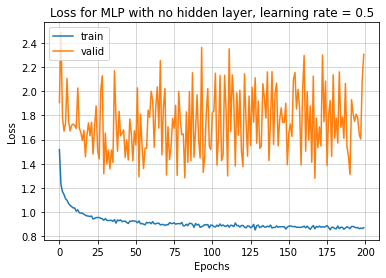

In [ ]:
plt.clf()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss for MLP with no hidden layer, learning rate = 0.5")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

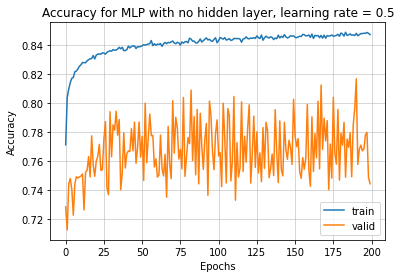

In [ ]:
plt.clf()
plt.plot(train_acc_list, label='train')
plt.plot(val_acc_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy for MLP with no hidden layer, learning rate = 0.5")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
y_test_probs = mlp_no_hidden_05.predict(x_test, is_test=True)

test_loss = EvaluationUtils.calculate_ce_loss(y_test_probs, y_test)
test_acc = EvaluationUtils.calculate_multi_accuracy(y_test_probs, y_test)

print("Test loss: {}".format(test_loss))
print("Test accuracy: {}".format(test_acc))

Test loss: 1.3967623067411514
Test accuracy: 0.8045


### MLP with one hidden layer (128 units) and ReLU activations

In [ ]:
mlp_one_hidden = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, FASHION_MNIST_N_CLASSES),
    SoftmaxOutputLayer()
)

opt_one_hidden = GradientDescentOptimizer(mlp_one_hidden, MLP_LR)
train_loss_list, val_loss_list, train_acc_list, val_acc_list = mlp_one_hidden.fit(opt_one_hidden, x_train, y_train, x_val, y_val,
                                                                                  batch_size=MLP_BATCH_SIZE, epochs=MLP_EPOCHS)

  0%|          | 1/200 [00:02<08:45,  2.64s/it]

Epoch: 1, train loss: 1.7775669953480984, train acc: 0.5121428571428579, val loss: 1.1319751334869528, val acc: 0.6699444444444445


  1%|          | 2/200 [00:04<06:52,  2.08s/it]

Epoch: 2, train loss: 0.9012023128761841, train acc: 0.7145, val loss: 0.763841883305742, val acc: 0.7365


  2%|▏         | 3/200 [00:06<06:17,  1.91s/it]

Epoch: 3, train loss: 0.6842910389998674, train acc: 0.7575238095238102, val loss: 0.6475269170823695, val acc: 0.7635


  2%|▏         | 4/200 [00:07<05:55,  1.82s/it]

Epoch: 4, train loss: 0.6006459480042082, train acc: 0.7805476190476193, val loss: 0.5895128809937487, val acc: 0.7851111111111111


  2%|▎         | 5/200 [00:09<05:47,  1.78s/it]

Epoch: 5, train loss: 0.5507021717353029, train acc: 0.8000714285714288, val loss: 0.55015677369204, val acc: 0.8007222222222222


  3%|▎         | 6/200 [00:11<05:38,  1.74s/it]

Epoch: 6, train loss: 0.5150912655131266, train acc: 0.8150952380952392, val loss: 0.521583255007804, val acc: 0.8131111111111111


  4%|▎         | 7/200 [00:12<05:31,  1.72s/it]

Epoch: 7, train loss: 0.4885540976820189, train acc: 0.8254285714285721, val loss: 0.500085187858609, val acc: 0.8228333333333333


  4%|▍         | 8/200 [00:14<05:24,  1.69s/it]

Epoch: 8, train loss: 0.46823685343603383, train acc: 0.8330476190476195, val loss: 0.4834571869128739, val acc: 0.8288888888888889


  4%|▍         | 9/200 [00:16<05:21,  1.68s/it]

Epoch: 9, train loss: 0.4522675246881124, train acc: 0.8390000000000005, val loss: 0.47028055199591573, val acc: 0.8336111111111111


  5%|▌         | 10/200 [00:17<05:19,  1.68s/it]

Epoch: 10, train loss: 0.4394256908309933, train acc: 0.8431666666666671, val loss: 0.4596576511851565, val acc: 0.8385


  6%|▌         | 11/200 [00:19<05:17,  1.68s/it]

Epoch: 11, train loss: 0.42881927530235114, train acc: 0.8465476190476192, val loss: 0.45087987668120233, val acc: 0.8425555555555555


  6%|▌         | 12/200 [00:21<05:13,  1.67s/it]

Epoch: 12, train loss: 0.4198635440541232, train acc: 0.8498809523809525, val loss: 0.4434547912612168, val acc: 0.8445555555555555


  6%|▋         | 13/200 [00:22<05:10,  1.66s/it]

Epoch: 13, train loss: 0.4121119351607283, train acc: 0.8528333333333338, val loss: 0.4370517671996192, val acc: 0.8457777777777777


  7%|▋         | 14/200 [00:24<05:08,  1.66s/it]

Epoch: 14, train loss: 0.4052785588776624, train acc: 0.8555952380952384, val loss: 0.4314249162603735, val acc: 0.8479444444444444


  8%|▊         | 15/200 [00:26<05:09,  1.67s/it]

Epoch: 15, train loss: 0.39915141455483155, train acc: 0.8579047619047622, val loss: 0.42639822819298046, val acc: 0.8497777777777777


  8%|▊         | 16/200 [00:27<05:08,  1.68s/it]

Epoch: 16, train loss: 0.3936275677401424, train acc: 0.8595952380952381, val loss: 0.42188703763192315, val acc: 0.8517222222222223


  8%|▊         | 17/200 [00:29<05:07,  1.68s/it]

Epoch: 17, train loss: 0.38857130638181764, train acc: 0.8613333333333333, val loss: 0.41777838624805785, val acc: 0.8531666666666666


  9%|▉         | 18/200 [00:31<05:04,  1.67s/it]

Epoch: 18, train loss: 0.38389649955341937, train acc: 0.8629047619047621, val loss: 0.41400645178190415, val acc: 0.8548888888888889


 10%|▉         | 19/200 [00:32<05:06,  1.69s/it]

Epoch: 19, train loss: 0.3795385460061892, train acc: 0.8640476190476193, val loss: 0.41053430674782776, val acc: 0.856


 10%|█         | 20/200 [00:34<05:03,  1.69s/it]

Epoch: 20, train loss: 0.375475817230063, train acc: 0.865547619047619, val loss: 0.40731290583802005, val acc: 0.8571111111111112


 10%|█         | 21/200 [00:36<05:01,  1.69s/it]

Epoch: 21, train loss: 0.3716686361175162, train acc: 0.8673571428571432, val loss: 0.4043261737445212, val acc: 0.8578333333333333


 11%|█         | 22/200 [00:37<04:58,  1.68s/it]

Epoch: 22, train loss: 0.3680825073415269, train acc: 0.8681904761904762, val loss: 0.4015435162938789, val acc: 0.859


 12%|█▏        | 23/200 [00:39<04:58,  1.68s/it]

Epoch: 23, train loss: 0.36467881932068785, train acc: 0.8691190476190472, val loss: 0.3989585472882385, val acc: 0.8598888888888889


 12%|█▏        | 24/200 [00:41<04:56,  1.68s/it]

Epoch: 24, train loss: 0.3614339290279719, train acc: 0.8700238095238092, val loss: 0.39649063574458826, val acc: 0.8607777777777778


 12%|█▎        | 25/200 [00:42<04:55,  1.69s/it]

Epoch: 25, train loss: 0.3583270460002187, train acc: 0.8710952380952383, val loss: 0.3941420655981526, val acc: 0.8610555555555556


 13%|█▎        | 26/200 [00:44<04:53,  1.69s/it]

Epoch: 26, train loss: 0.3553336777693796, train acc: 0.8718809523809521, val loss: 0.391908729433021, val acc: 0.8622222222222222


 14%|█▎        | 27/200 [00:46<04:51,  1.68s/it]

Epoch: 27, train loss: 0.35245577642702985, train acc: 0.8729523809523808, val loss: 0.3897923787513714, val acc: 0.8630555555555556


 14%|█▍        | 28/200 [00:48<04:50,  1.69s/it]

Epoch: 28, train loss: 0.34968795165428285, train acc: 0.8740714285714286, val loss: 0.3877932218543857, val acc: 0.8642222222222222


 14%|█▍        | 29/200 [00:49<04:48,  1.69s/it]

Epoch: 29, train loss: 0.34701173095382376, train acc: 0.8751428571428569, val loss: 0.38587857314158946, val acc: 0.8650555555555556


 15%|█▌        | 30/200 [00:51<04:49,  1.70s/it]

Epoch: 30, train loss: 0.34442182215903555, train acc: 0.8760952380952379, val loss: 0.38404391949759925, val acc: 0.8661111111111112


 16%|█▌        | 31/200 [00:53<04:46,  1.69s/it]

Epoch: 31, train loss: 0.3419154242151322, train acc: 0.877047619047619, val loss: 0.3823117391653296, val acc: 0.8674444444444445


 16%|█▌        | 32/200 [00:54<04:43,  1.69s/it]

Epoch: 32, train loss: 0.3394828063932654, train acc: 0.878095238095238, val loss: 0.38065731331749636, val acc: 0.8678888888888889


 16%|█▋        | 33/200 [00:56<04:42,  1.69s/it]

Epoch: 33, train loss: 0.33711846269700624, train acc: 0.8787857142857144, val loss: 0.3790504328757826, val acc: 0.8684444444444445


 17%|█▋        | 34/200 [00:58<04:42,  1.70s/it]

Epoch: 34, train loss: 0.33480940564721917, train acc: 0.8797619047619045, val loss: 0.37750228697277965, val acc: 0.8686111111111111


 18%|█▊        | 35/200 [00:59<04:37,  1.68s/it]

Epoch: 35, train loss: 0.33256215561153796, train acc: 0.8806190476190475, val loss: 0.3760369229903414, val acc: 0.8691111111111111


 18%|█▊        | 36/200 [01:01<04:37,  1.69s/it]

Epoch: 36, train loss: 0.33036210684218614, train acc: 0.8816904761904759, val loss: 0.37459523832319996, val acc: 0.8699444444444444


 18%|█▊        | 37/200 [01:03<04:36,  1.70s/it]

Epoch: 37, train loss: 0.3281984969947354, train acc: 0.8827619047619043, val loss: 0.373226808794546, val acc: 0.8702777777777778


 19%|█▉        | 38/200 [01:04<04:33,  1.69s/it]

Epoch: 38, train loss: 0.32608972791115626, train acc: 0.8836190476190475, val loss: 0.37190141257338927, val acc: 0.8701666666666666


 20%|█▉        | 39/200 [01:06<04:30,  1.68s/it]

Epoch: 39, train loss: 0.3240329961129886, train acc: 0.8845238095238097, val loss: 0.37063481558838446, val acc: 0.8707222222222222


 20%|██        | 40/200 [01:08<04:27,  1.67s/it]

Epoch: 40, train loss: 0.3220036928709369, train acc: 0.8852857142857145, val loss: 0.36939876840492364, val acc: 0.8712222222222222


 20%|██        | 41/200 [01:09<04:27,  1.68s/it]

Epoch: 41, train loss: 0.32002099647938936, train acc: 0.885904761904762, val loss: 0.36817960694052554, val acc: 0.8717222222222222


 21%|██        | 42/200 [01:11<04:24,  1.68s/it]

Epoch: 42, train loss: 0.3180817749546684, train acc: 0.8869047619047623, val loss: 0.3670333834072024, val acc: 0.8718333333333333


 22%|██▏       | 43/200 [01:13<04:22,  1.67s/it]

Epoch: 43, train loss: 0.3161904298244726, train acc: 0.887666666666667, val loss: 0.3659545682086972, val acc: 0.8721666666666666


 22%|██▏       | 44/200 [01:14<04:19,  1.66s/it]

Epoch: 44, train loss: 0.31434511066809906, train acc: 0.8884285714285717, val loss: 0.36491604129502886, val acc: 0.8722222222222222


 22%|██▎       | 45/200 [01:16<04:17,  1.66s/it]

Epoch: 45, train loss: 0.3125341787472576, train acc: 0.8891190476190479, val loss: 0.3639070566549981, val acc: 0.8724444444444445


 23%|██▎       | 46/200 [01:18<04:16,  1.67s/it]

Epoch: 46, train loss: 0.3107619170947861, train acc: 0.8897380952380957, val loss: 0.3629484054436611, val acc: 0.8728888888888889


 24%|██▎       | 47/200 [01:19<04:14,  1.67s/it]

Epoch: 47, train loss: 0.30902373233835084, train acc: 0.8903095238095238, val loss: 0.3620346075480854, val acc: 0.8733888888888889


 24%|██▍       | 48/200 [01:21<04:13,  1.66s/it]

Epoch: 48, train loss: 0.3073132348714062, train acc: 0.8909047619047619, val loss: 0.3611388320245044, val acc: 0.8740555555555556


 24%|██▍       | 49/200 [01:23<04:12,  1.68s/it]

Epoch: 49, train loss: 0.3056332640884743, train acc: 0.8913571428571432, val loss: 0.3602752812463634, val acc: 0.8743888888888889


 25%|██▌       | 50/200 [01:24<04:10,  1.67s/it]

Epoch: 50, train loss: 0.3039807638308708, train acc: 0.8920000000000001, val loss: 0.35943625038968025, val acc: 0.8742777777777778


 26%|██▌       | 51/200 [01:26<04:09,  1.67s/it]

Epoch: 51, train loss: 0.30235650668432124, train acc: 0.8924761904761905, val loss: 0.35860432141891485, val acc: 0.8745555555555555


 26%|██▌       | 52/200 [01:28<04:09,  1.68s/it]

Epoch: 52, train loss: 0.30075375808124044, train acc: 0.893190476190476, val loss: 0.3578321031358523, val acc: 0.8747222222222222


 26%|██▋       | 53/200 [01:29<04:06,  1.68s/it]

Epoch: 53, train loss: 0.2991772310538237, train acc: 0.893785714285714, val loss: 0.3570592005413475, val acc: 0.8750555555555556


 27%|██▋       | 54/200 [01:31<04:05,  1.68s/it]

Epoch: 54, train loss: 0.2976220584022729, train acc: 0.8943571428571424, val loss: 0.35627864387312475, val acc: 0.8750555555555556


 28%|██▊       | 55/200 [01:33<04:04,  1.69s/it]

Epoch: 55, train loss: 0.2960830251670936, train acc: 0.8951428571428567, val loss: 0.35552481427313576, val acc: 0.8752222222222222


 28%|██▊       | 56/200 [01:35<04:01,  1.68s/it]

Epoch: 56, train loss: 0.2945646778953138, train acc: 0.8958809523809519, val loss: 0.3548054804779432, val acc: 0.8754444444444445


 28%|██▊       | 57/200 [01:36<03:59,  1.67s/it]

Epoch: 57, train loss: 0.29306199373350855, train acc: 0.8964285714285711, val loss: 0.35409150170149045, val acc: 0.8760555555555556


 29%|██▉       | 58/200 [01:38<03:56,  1.67s/it]

Epoch: 58, train loss: 0.29158967881430375, train acc: 0.8969285714285713, val loss: 0.3534195564896652, val acc: 0.8760555555555556


 30%|██▉       | 59/200 [01:39<03:54,  1.66s/it]

Epoch: 59, train loss: 0.29012731908020106, train acc: 0.8972619047619047, val loss: 0.35274158275498263, val acc: 0.8761666666666666


 30%|███       | 60/200 [01:41<03:54,  1.67s/it]

Epoch: 60, train loss: 0.2886814925636939, train acc: 0.8977380952380949, val loss: 0.35209977194110037, val acc: 0.8765


 30%|███       | 61/200 [01:43<03:52,  1.67s/it]

Epoch: 61, train loss: 0.28726138127614026, train acc: 0.898238095238095, val loss: 0.3514624199294337, val acc: 0.8767777777777778


 31%|███       | 62/200 [01:45<03:51,  1.67s/it]

Epoch: 62, train loss: 0.2858555700067636, train acc: 0.8986428571428567, val loss: 0.35085448545063164, val acc: 0.8767222222222222


 32%|███▏      | 63/200 [01:46<03:51,  1.69s/it]

Epoch: 63, train loss: 0.2844638972558955, train acc: 0.899095238095238, val loss: 0.3502584083610443, val acc: 0.8768888888888889


 32%|███▏      | 64/200 [01:48<03:51,  1.70s/it]

Epoch: 64, train loss: 0.2830907441816277, train acc: 0.899309523809524, val loss: 0.3496574668522016, val acc: 0.8769444444444444


 32%|███▎      | 65/200 [01:50<03:48,  1.69s/it]

Epoch: 65, train loss: 0.28171650198372183, train acc: 0.8998095238095242, val loss: 0.3490783627620406, val acc: 0.8772777777777778


 33%|███▎      | 66/200 [01:51<03:46,  1.69s/it]

Epoch: 66, train loss: 0.28036018646445937, train acc: 0.9001904761904765, val loss: 0.34851791069310156, val acc: 0.8775555555555555


 34%|███▎      | 67/200 [01:53<03:43,  1.68s/it]

Epoch: 67, train loss: 0.27901513176945647, train acc: 0.9005000000000002, val loss: 0.3479728127503335, val acc: 0.878


 34%|███▍      | 68/200 [01:55<03:39,  1.67s/it]

Epoch: 68, train loss: 0.27768290077766117, train acc: 0.9010714285714286, val loss: 0.3474372039362853, val acc: 0.8781111111111111


 34%|███▍      | 69/200 [01:56<03:37,  1.66s/it]

Epoch: 69, train loss: 0.27635620116925824, train acc: 0.901428571428572, val loss: 0.3469325609960734, val acc: 0.8783333333333333


 35%|███▌      | 70/200 [01:58<03:35,  1.66s/it]

Epoch: 70, train loss: 0.2750494563255476, train acc: 0.9019523809523812, val loss: 0.3464283305150076, val acc: 0.8784444444444445


 36%|███▌      | 71/200 [02:00<03:33,  1.66s/it]

Epoch: 71, train loss: 0.2737458015756986, train acc: 0.9025238095238098, val loss: 0.3459817277033598, val acc: 0.8786111111111111


 36%|███▌      | 72/200 [02:01<03:31,  1.65s/it]

Epoch: 72, train loss: 0.2724505145454218, train acc: 0.9027619047619049, val loss: 0.3455536494866142, val acc: 0.8788333333333334


 36%|███▋      | 73/200 [02:03<03:30,  1.66s/it]

Epoch: 73, train loss: 0.27118434758402254, train acc: 0.903404761904762, val loss: 0.34509677804961025, val acc: 0.8790555555555556


 37%|███▋      | 74/200 [02:05<03:30,  1.67s/it]

Epoch: 74, train loss: 0.26991950890726624, train acc: 0.9037380952380955, val loss: 0.3447057413198019, val acc: 0.8794444444444445


 38%|███▊      | 75/200 [02:06<03:28,  1.66s/it]

Epoch: 75, train loss: 0.26867673047289653, train acc: 0.9045952380952386, val loss: 0.344281499878599, val acc: 0.8795555555555555


 38%|███▊      | 76/200 [02:08<03:25,  1.66s/it]

Epoch: 76, train loss: 0.2674382864559154, train acc: 0.9049523809523816, val loss: 0.3438680322798463, val acc: 0.8795


 38%|███▊      | 77/200 [02:10<03:24,  1.67s/it]

Epoch: 77, train loss: 0.2662061516369288, train acc: 0.9053333333333339, val loss: 0.3434962207003767, val acc: 0.8796666666666667


 39%|███▉      | 78/200 [02:11<03:23,  1.67s/it]

Epoch: 78, train loss: 0.2649809867855041, train acc: 0.9057857142857145, val loss: 0.3431142479113082, val acc: 0.8800555555555556


 40%|███▉      | 79/200 [02:13<03:23,  1.68s/it]

Epoch: 79, train loss: 0.2637741498397495, train acc: 0.9062142857142856, val loss: 0.34274566302267345, val acc: 0.8801666666666667


 40%|████      | 80/200 [02:15<03:21,  1.68s/it]

Epoch: 80, train loss: 0.26257291577123243, train acc: 0.9068809523809523, val loss: 0.3424037069248237, val acc: 0.8804444444444445


 40%|████      | 81/200 [02:16<03:18,  1.67s/it]

Epoch: 81, train loss: 0.2613940375451676, train acc: 0.9072857142857143, val loss: 0.3420606770670519, val acc: 0.8807777777777778


 41%|████      | 82/200 [02:18<03:16,  1.66s/it]

Epoch: 82, train loss: 0.26021129688340994, train acc: 0.9075714285714287, val loss: 0.34175377660218986, val acc: 0.881


 42%|████▏     | 83/200 [02:20<03:14,  1.66s/it]

Epoch: 83, train loss: 0.2590412107740078, train acc: 0.9078333333333334, val loss: 0.3414116484603962, val acc: 0.8811666666666667


 42%|████▏     | 84/200 [02:21<03:11,  1.65s/it]

Epoch: 84, train loss: 0.25787777048256383, train acc: 0.9084523809523808, val loss: 0.34111319236377907, val acc: 0.8810555555555556


 42%|████▎     | 85/200 [02:23<03:10,  1.65s/it]

Epoch: 85, train loss: 0.25672100122844543, train acc: 0.9091190476190475, val loss: 0.3408081296702929, val acc: 0.881


 43%|████▎     | 86/200 [02:25<03:08,  1.66s/it]

Epoch: 86, train loss: 0.25557935773484075, train acc: 0.9095476190476186, val loss: 0.34052837573871997, val acc: 0.8813333333333333


 44%|████▎     | 87/200 [02:26<03:06,  1.65s/it]

Epoch: 87, train loss: 0.25443854450891223, train acc: 0.9101190476190474, val loss: 0.3402777784419118, val acc: 0.8814444444444445


 44%|████▍     | 88/200 [02:28<03:05,  1.66s/it]

Epoch: 88, train loss: 0.25331969193578574, train acc: 0.9106666666666663, val loss: 0.3399873335191832, val acc: 0.8816111111111111


 44%|████▍     | 89/200 [02:30<03:04,  1.66s/it]

Epoch: 89, train loss: 0.25220694444967745, train acc: 0.9111666666666662, val loss: 0.33971941826510105, val acc: 0.8817222222222222


 45%|████▌     | 90/200 [02:31<03:02,  1.66s/it]

Epoch: 90, train loss: 0.251093364387146, train acc: 0.9115714285714284, val loss: 0.3394657356759246, val acc: 0.8817777777777778


 46%|████▌     | 91/200 [02:33<02:59,  1.65s/it]

Epoch: 91, train loss: 0.24999209806170358, train acc: 0.9122142857142855, val loss: 0.3392129167782761, val acc: 0.8822222222222222


 46%|████▌     | 92/200 [02:34<02:58,  1.65s/it]

Epoch: 92, train loss: 0.24889548794394323, train acc: 0.9126666666666666, val loss: 0.3389535207193422, val acc: 0.8822777777777778


 46%|████▋     | 93/200 [02:36<02:56,  1.64s/it]

Epoch: 93, train loss: 0.24780947768433517, train acc: 0.9128333333333333, val loss: 0.3387024260805167, val acc: 0.8827222222222222


 47%|████▋     | 94/200 [02:38<02:54,  1.64s/it]

Epoch: 94, train loss: 0.24671999918806928, train acc: 0.9132857142857141, val loss: 0.3384505157041038, val acc: 0.8826666666666667


 48%|████▊     | 95/200 [02:39<02:51,  1.64s/it]

Epoch: 95, train loss: 0.24564422263578278, train acc: 0.9133809523809521, val loss: 0.3382265743910034, val acc: 0.8827777777777778


 48%|████▊     | 96/200 [02:41<02:50,  1.64s/it]

Epoch: 96, train loss: 0.24457208713250597, train acc: 0.9137857142857141, val loss: 0.3379942591531417, val acc: 0.8826111111111111


 48%|████▊     | 97/200 [02:43<02:49,  1.65s/it]

Epoch: 97, train loss: 0.2435029056749711, train acc: 0.9141190476190476, val loss: 0.33778951301010157, val acc: 0.8825555555555555


 49%|████▉     | 98/200 [02:44<02:48,  1.65s/it]

Epoch: 98, train loss: 0.24243899616545392, train acc: 0.9146190476190476, val loss: 0.3375846710909628, val acc: 0.8826666666666667


 50%|████▉     | 99/200 [02:46<02:46,  1.65s/it]

Epoch: 99, train loss: 0.2413834176506826, train acc: 0.9150238095238092, val loss: 0.3373842630621688, val acc: 0.8825


 50%|█████     | 100/200 [02:48<02:45,  1.66s/it]

Epoch: 100, train loss: 0.24034122700693458, train acc: 0.9151904761904759, val loss: 0.3371631932650334, val acc: 0.8827222222222222


 50%|█████     | 101/200 [02:49<02:44,  1.66s/it]

Epoch: 101, train loss: 0.23929485179059687, train acc: 0.9156904761904758, val loss: 0.33697594226838534, val acc: 0.8828333333333334


 51%|█████     | 102/200 [02:51<02:42,  1.66s/it]

Epoch: 102, train loss: 0.23826851147408729, train acc: 0.9159999999999998, val loss: 0.3367910464194152, val acc: 0.883


 52%|█████▏    | 103/200 [02:53<02:40,  1.66s/it]

Epoch: 103, train loss: 0.23723276255582432, train acc: 0.9163571428571424, val loss: 0.33663626334428004, val acc: 0.8833333333333333


 52%|█████▏    | 104/200 [02:54<02:39,  1.67s/it]

Epoch: 104, train loss: 0.2362234292758895, train acc: 0.9166666666666665, val loss: 0.33647277673216985, val acc: 0.8833333333333333


 52%|█████▎    | 105/200 [02:56<02:37,  1.66s/it]

Epoch: 105, train loss: 0.2352083599466128, train acc: 0.9171666666666666, val loss: 0.3363347532932141, val acc: 0.8835


 53%|█████▎    | 106/200 [02:58<02:36,  1.67s/it]

Epoch: 106, train loss: 0.2341929084309691, train acc: 0.9176666666666667, val loss: 0.3361902597022058, val acc: 0.8835


 54%|█████▎    | 107/200 [02:59<02:35,  1.67s/it]

Epoch: 107, train loss: 0.23318953594338554, train acc: 0.9181904761904766, val loss: 0.33604718270501666, val acc: 0.8835555555555555


 54%|█████▍    | 108/200 [03:01<02:34,  1.68s/it]

Epoch: 108, train loss: 0.23219523479344634, train acc: 0.9185000000000003, val loss: 0.3359344778684865, val acc: 0.8837777777777778


 55%|█████▍    | 109/200 [03:03<02:31,  1.67s/it]

Epoch: 109, train loss: 0.23119696889097444, train acc: 0.9190952380952382, val loss: 0.33580367273345596, val acc: 0.8836111111111111


 55%|█████▌    | 110/200 [03:04<02:31,  1.68s/it]

Epoch: 110, train loss: 0.23020359478211302, train acc: 0.9194761904761908, val loss: 0.33566916977860445, val acc: 0.8838333333333334


 56%|█████▌    | 111/200 [03:06<02:29,  1.68s/it]

Epoch: 111, train loss: 0.22922335877183192, train acc: 0.919857142857143, val loss: 0.33553120599531283, val acc: 0.8833888888888889


 56%|█████▌    | 112/200 [03:08<02:27,  1.67s/it]

Epoch: 112, train loss: 0.22824555375756744, train acc: 0.9203809523809524, val loss: 0.3354625774904218, val acc: 0.8836111111111111


 56%|█████▋    | 113/200 [03:09<02:25,  1.67s/it]

Epoch: 113, train loss: 0.22727028854128933, train acc: 0.9205714285714285, val loss: 0.335340081829675, val acc: 0.8836111111111111


 57%|█████▋    | 114/200 [03:11<02:23,  1.67s/it]

Epoch: 114, train loss: 0.2263013401303834, train acc: 0.9210238095238098, val loss: 0.33525576582068717, val acc: 0.8838888888888888


 57%|█████▊    | 115/200 [03:13<02:22,  1.68s/it]

Epoch: 115, train loss: 0.22533179349730542, train acc: 0.9214761904761907, val loss: 0.3351535491132272, val acc: 0.8838888888888888


 58%|█████▊    | 116/200 [03:15<02:25,  1.73s/it]

Epoch: 116, train loss: 0.22437193386289134, train acc: 0.9220000000000002, val loss: 0.335067104905947, val acc: 0.884


 58%|█████▊    | 117/200 [03:16<02:22,  1.72s/it]

Epoch: 117, train loss: 0.2234217993590456, train acc: 0.9223809523809524, val loss: 0.33501587030690655, val acc: 0.8841111111111111


 59%|█████▉    | 118/200 [03:18<02:19,  1.70s/it]

Epoch: 118, train loss: 0.22247458541454979, train acc: 0.9226904761904764, val loss: 0.3349120103963185, val acc: 0.8841666666666667


 60%|█████▉    | 119/200 [03:20<02:18,  1.71s/it]

Epoch: 119, train loss: 0.22154008535245176, train acc: 0.9231428571428572, val loss: 0.33484078167242043, val acc: 0.8841666666666667


 60%|██████    | 120/200 [03:21<02:16,  1.71s/it]

Epoch: 120, train loss: 0.22060328268507812, train acc: 0.9234285714285716, val loss: 0.334770185003938, val acc: 0.8841111111111111


 60%|██████    | 121/200 [03:23<02:15,  1.71s/it]

Epoch: 121, train loss: 0.21967392178270864, train acc: 0.9238095238095239, val loss: 0.33470102557171405, val acc: 0.884


 61%|██████    | 122/200 [03:25<02:13,  1.72s/it]

Epoch: 122, train loss: 0.21875719270373128, train acc: 0.924214285714286, val loss: 0.3346599410956275, val acc: 0.8842777777777778


 62%|██████▏   | 123/200 [03:27<02:12,  1.72s/it]

Epoch: 123, train loss: 0.21783368046386306, train acc: 0.9246190476190478, val loss: 0.33461370923200345, val acc: 0.8840555555555556


 62%|██████▏   | 124/200 [03:28<02:10,  1.71s/it]

Epoch: 124, train loss: 0.21692161645225938, train acc: 0.9249285714285715, val loss: 0.3345203561588765, val acc: 0.8841666666666667


 62%|██████▎   | 125/200 [03:30<02:07,  1.70s/it]

Epoch: 125, train loss: 0.21601581270534403, train acc: 0.9252857142857143, val loss: 0.3344849559775993, val acc: 0.8840555555555556


 63%|██████▎   | 126/200 [03:32<02:06,  1.70s/it]

Epoch: 126, train loss: 0.21512417628515618, train acc: 0.9254047619047622, val loss: 0.3344321445365813, val acc: 0.8841111111111111


 64%|██████▎   | 127/200 [03:33<02:03,  1.69s/it]

Epoch: 127, train loss: 0.21423584085948172, train acc: 0.9257857142857145, val loss: 0.33438648961807316, val acc: 0.8842222222222222


 64%|██████▍   | 128/200 [03:35<02:02,  1.70s/it]

Epoch: 128, train loss: 0.2133454101921661, train acc: 0.926119047619048, val loss: 0.33435498547735065, val acc: 0.8840555555555556


 64%|██████▍   | 129/200 [03:37<02:00,  1.69s/it]

Epoch: 129, train loss: 0.2124592697557669, train acc: 0.9266666666666671, val loss: 0.3343212178941631, val acc: 0.8844444444444445


 65%|██████▌   | 130/200 [03:38<01:58,  1.69s/it]

Epoch: 130, train loss: 0.2115658632250394, train acc: 0.9269523809523813, val loss: 0.33430483896495566, val acc: 0.8843333333333333


 66%|██████▌   | 131/200 [03:40<01:55,  1.68s/it]

Epoch: 131, train loss: 0.210691911453945, train acc: 0.9273333333333337, val loss: 0.3342802741909916, val acc: 0.8844444444444445


 66%|██████▌   | 132/200 [03:42<01:53,  1.67s/it]

Epoch: 132, train loss: 0.2098136130101168, train acc: 0.9277857142857144, val loss: 0.33425580755881146, val acc: 0.8846111111111111


 66%|██████▋   | 133/200 [03:43<01:51,  1.66s/it]

Epoch: 133, train loss: 0.2089477395711849, train acc: 0.9280714285714288, val loss: 0.3342618472138499, val acc: 0.8844444444444445


 67%|██████▋   | 134/200 [03:45<01:49,  1.65s/it]

Epoch: 134, train loss: 0.20808730551541096, train acc: 0.9282619047619051, val loss: 0.3342621609179471, val acc: 0.8845


 68%|██████▊   | 135/200 [03:47<01:47,  1.65s/it]

Epoch: 135, train loss: 0.207228612790433, train acc: 0.9285714285714288, val loss: 0.33427210927020523, val acc: 0.8842222222222222


 68%|██████▊   | 136/200 [03:48<01:45,  1.65s/it]

Epoch: 136, train loss: 0.20637838212134282, train acc: 0.928952380952381, val loss: 0.33427475378873034, val acc: 0.8841111111111111


 68%|██████▊   | 137/200 [03:50<01:44,  1.66s/it]

Epoch: 137, train loss: 0.20553195998317592, train acc: 0.9293809523809523, val loss: 0.3342674449607832, val acc: 0.8842777777777778


 69%|██████▉   | 138/200 [03:52<01:43,  1.67s/it]

Epoch: 138, train loss: 0.20468509005220958, train acc: 0.9300714285714285, val loss: 0.33426766732937335, val acc: 0.8845


 70%|██████▉   | 139/200 [03:53<01:41,  1.66s/it]

Epoch: 139, train loss: 0.20385007920216222, train acc: 0.9303809523809526, val loss: 0.3342835493276053, val acc: 0.8844444444444445


 70%|███████   | 140/200 [03:55<01:39,  1.66s/it]

Epoch: 140, train loss: 0.2030140471806275, train acc: 0.9305952380952381, val loss: 0.3342980955036728, val acc: 0.8843888888888889


 70%|███████   | 141/200 [03:58<02:00,  2.04s/it]

Epoch: 141, train loss: 0.20219077873946886, train acc: 0.9310476190476197, val loss: 0.3343160253983993, val acc: 0.8842777777777778


 71%|███████   | 142/200 [04:00<01:58,  2.04s/it]

Epoch: 142, train loss: 0.20135830391153986, train acc: 0.9312380952380956, val loss: 0.33433361990677535, val acc: 0.8842777777777778


 72%|███████▏  | 143/200 [04:02<01:49,  1.92s/it]

Epoch: 143, train loss: 0.20053688383419946, train acc: 0.931666666666667, val loss: 0.3343840738364431, val acc: 0.8842777777777778


 72%|███████▏  | 144/200 [04:03<01:42,  1.83s/it]

Epoch: 144, train loss: 0.19971596390375895, train acc: 0.9320238095238099, val loss: 0.3344029870329849, val acc: 0.8844444444444445


 72%|███████▎  | 145/200 [04:05<01:38,  1.79s/it]

Epoch: 145, train loss: 0.1989001734505157, train acc: 0.9324761904761907, val loss: 0.33445720576171084, val acc: 0.8843888888888889


 73%|███████▎  | 146/200 [04:06<01:34,  1.74s/it]

Epoch: 146, train loss: 0.19808169321337935, train acc: 0.932857142857143, val loss: 0.33450938177759193, val acc: 0.8845555555555555


 74%|███████▎  | 147/200 [04:08<01:30,  1.71s/it]

Epoch: 147, train loss: 0.1972796698648457, train acc: 0.9332142857142858, val loss: 0.33454786204920917, val acc: 0.8845555555555555


 74%|███████▍  | 148/200 [04:10<01:28,  1.69s/it]

Epoch: 148, train loss: 0.19647229478152922, train acc: 0.9335238095238093, val loss: 0.33462049912229685, val acc: 0.8846111111111111


 74%|███████▍  | 149/200 [04:11<01:25,  1.68s/it]

Epoch: 149, train loss: 0.19567993597476982, train acc: 0.9338809523809523, val loss: 0.33468100199644846, val acc: 0.8848333333333334


 75%|███████▌  | 150/200 [04:13<01:23,  1.66s/it]

Epoch: 150, train loss: 0.19488698776809094, train acc: 0.9341666666666665, val loss: 0.3347490961138101, val acc: 0.8848333333333334


 76%|███████▌  | 151/200 [04:15<01:20,  1.65s/it]

Epoch: 151, train loss: 0.19408987266181324, train acc: 0.9343571428571426, val loss: 0.3348080536759105, val acc: 0.8849444444444444


 76%|███████▌  | 152/200 [04:16<01:18,  1.64s/it]

Epoch: 152, train loss: 0.19329316299094476, train acc: 0.9346190476190473, val loss: 0.33490660942481115, val acc: 0.8850555555555556


 76%|███████▋  | 153/200 [04:18<01:16,  1.63s/it]

Epoch: 153, train loss: 0.1925130203367377, train acc: 0.9348571428571427, val loss: 0.3349694802208112, val acc: 0.8849444444444444


 77%|███████▋  | 154/200 [04:19<01:14,  1.63s/it]

Epoch: 154, train loss: 0.19173078323789056, train acc: 0.9352857142857143, val loss: 0.33504733651785157, val acc: 0.8851111111111111


 78%|███████▊  | 155/200 [04:21<01:13,  1.63s/it]

Epoch: 155, train loss: 0.19095253690581915, train acc: 0.9355952380952378, val loss: 0.33512424358179543, val acc: 0.8851111111111111


 78%|███████▊  | 156/200 [04:23<01:11,  1.64s/it]

Epoch: 156, train loss: 0.19017480103506149, train acc: 0.9358571428571426, val loss: 0.3352181681678725, val acc: 0.8854444444444445


 78%|███████▊  | 157/200 [04:24<01:10,  1.63s/it]

Epoch: 157, train loss: 0.18940467695104773, train acc: 0.9361190476190473, val loss: 0.3353168797922277, val acc: 0.8854444444444445


 79%|███████▉  | 158/200 [04:26<01:09,  1.65s/it]

Epoch: 158, train loss: 0.18864367908524043, train acc: 0.9364761904761904, val loss: 0.3353654268987965, val acc: 0.8855555555555555


 80%|███████▉  | 159/200 [04:28<01:07,  1.65s/it]

Epoch: 159, train loss: 0.1878728611576881, train acc: 0.9369523809523811, val loss: 0.33545362908659027, val acc: 0.8855


 80%|████████  | 160/200 [04:29<01:06,  1.65s/it]

Epoch: 160, train loss: 0.18710771490571482, train acc: 0.9372857142857145, val loss: 0.3355852423098747, val acc: 0.8854444444444445


 80%|████████  | 161/200 [04:31<01:04,  1.66s/it]

Epoch: 161, train loss: 0.18635216304843155, train acc: 0.9376428571428576, val loss: 0.3356718711182081, val acc: 0.8853888888888889


 81%|████████  | 162/200 [04:33<01:03,  1.66s/it]

Epoch: 162, train loss: 0.1856027834596274, train acc: 0.937976190476191, val loss: 0.3357683092627952, val acc: 0.8853888888888889


 82%|████████▏ | 163/200 [04:34<01:01,  1.66s/it]

Epoch: 163, train loss: 0.1848628013686994, train acc: 0.9381666666666671, val loss: 0.3358773326481522, val acc: 0.8853333333333333


 82%|████████▏ | 164/200 [04:36<00:59,  1.66s/it]

Epoch: 164, train loss: 0.18410864248084907, train acc: 0.9385000000000003, val loss: 0.3359622473594165, val acc: 0.8855


 82%|████████▎ | 165/200 [04:38<00:57,  1.66s/it]

Epoch: 165, train loss: 0.1833674100295345, train acc: 0.9388571428571433, val loss: 0.33602241966123936, val acc: 0.8855


 83%|████████▎ | 166/200 [04:39<00:56,  1.65s/it]

Epoch: 166, train loss: 0.18261806311879003, train acc: 0.9391428571428573, val loss: 0.33614970208453887, val acc: 0.8854444444444445


 84%|████████▎ | 167/200 [04:41<00:54,  1.65s/it]

Epoch: 167, train loss: 0.1818809719645406, train acc: 0.9395000000000002, val loss: 0.3362517532949467, val acc: 0.8855555555555555


 84%|████████▍ | 168/200 [04:43<00:52,  1.66s/it]

Epoch: 168, train loss: 0.18116191849505983, train acc: 0.9396904761904766, val loss: 0.33634753552702185, val acc: 0.8856111111111111


 84%|████████▍ | 169/200 [04:44<00:51,  1.66s/it]

Epoch: 169, train loss: 0.18042244574821434, train acc: 0.9400476190476195, val loss: 0.3364391777483381, val acc: 0.8856666666666667


 85%|████████▌ | 170/200 [04:46<00:50,  1.67s/it]

Epoch: 170, train loss: 0.17969581518976088, train acc: 0.9403095238095242, val loss: 0.3365649551084621, val acc: 0.8857222222222222


 86%|████████▌ | 171/200 [04:48<00:48,  1.68s/it]

Epoch: 171, train loss: 0.17897417645445507, train acc: 0.9406428571428577, val loss: 0.3366905448884797, val acc: 0.8855555555555555


 86%|████████▌ | 172/200 [04:49<00:47,  1.68s/it]

Epoch: 172, train loss: 0.17825915915017787, train acc: 0.9409285714285717, val loss: 0.33684535890092404, val acc: 0.8856666666666667


 86%|████████▋ | 173/200 [04:51<00:45,  1.69s/it]

Epoch: 173, train loss: 0.17753559759563492, train acc: 0.941214285714286, val loss: 0.3369435601207878, val acc: 0.8857777777777778


 87%|████████▋ | 174/200 [04:53<00:44,  1.70s/it]

Epoch: 174, train loss: 0.17681629925277825, train acc: 0.941404761904762, val loss: 0.33709378511734295, val acc: 0.8857777777777778


 88%|████████▊ | 175/200 [04:55<00:42,  1.69s/it]

Epoch: 175, train loss: 0.1761024169176447, train acc: 0.9417380952380955, val loss: 0.3372533561789753, val acc: 0.8857222222222222


 88%|████████▊ | 176/200 [04:56<00:40,  1.70s/it]

Epoch: 176, train loss: 0.17540857106473165, train acc: 0.9419523809523812, val loss: 0.33735202265455144, val acc: 0.8857777777777778


 88%|████████▊ | 177/200 [04:58<00:38,  1.69s/it]

Epoch: 177, train loss: 0.17470377448733015, train acc: 0.9422380952380952, val loss: 0.33750133623032597, val acc: 0.8857222222222222


 89%|████████▉ | 178/200 [05:00<00:36,  1.67s/it]

Epoch: 178, train loss: 0.17400501638411991, train acc: 0.9425, val loss: 0.33761409472603343, val acc: 0.8857222222222222


 90%|████████▉ | 179/200 [05:01<00:34,  1.66s/it]

Epoch: 179, train loss: 0.17330856472945486, train acc: 0.9428333333333335, val loss: 0.3377478952990447, val acc: 0.8857222222222222


 90%|█████████ | 180/200 [05:03<00:33,  1.65s/it]

Epoch: 180, train loss: 0.17261898859185693, train acc: 0.9430238095238096, val loss: 0.3378764802325808, val acc: 0.8856111111111111


 90%|█████████ | 181/200 [05:04<00:31,  1.65s/it]

Epoch: 181, train loss: 0.17193357037534826, train acc: 0.9433809523809523, val loss: 0.33802663496659324, val acc: 0.8857777777777778


 91%|█████████ | 182/200 [05:06<00:29,  1.66s/it]

Epoch: 182, train loss: 0.17123612257088075, train acc: 0.9438571428571427, val loss: 0.33813840698409425, val acc: 0.8857777777777778


 92%|█████████▏| 183/200 [05:08<00:28,  1.66s/it]

Epoch: 183, train loss: 0.17056144951931346, train acc: 0.9441904761904762, val loss: 0.3383241959246183, val acc: 0.8858333333333334


 92%|█████████▏| 184/200 [05:09<00:26,  1.66s/it]

Epoch: 184, train loss: 0.169870246235942, train acc: 0.9444523809523808, val loss: 0.3384254293204726, val acc: 0.8860555555555556


 92%|█████████▎| 185/200 [05:11<00:24,  1.65s/it]

Epoch: 185, train loss: 0.16920743642213326, train acc: 0.944642857142857, val loss: 0.3385703010055769, val acc: 0.886


 93%|█████████▎| 186/200 [05:13<00:23,  1.66s/it]

Epoch: 186, train loss: 0.16851732238251435, train acc: 0.9447380952380952, val loss: 0.33872840513969604, val acc: 0.8857777777777778


 94%|█████████▎| 187/200 [05:14<00:21,  1.68s/it]

Epoch: 187, train loss: 0.16784857416536136, train acc: 0.9450238095238093, val loss: 0.3388439769576709, val acc: 0.8859444444444444


 94%|█████████▍| 188/200 [05:16<00:20,  1.68s/it]

Epoch: 188, train loss: 0.16716598894614595, train acc: 0.9451904761904759, val loss: 0.33902569282541034, val acc: 0.8858888888888888


 94%|█████████▍| 189/200 [05:18<00:18,  1.68s/it]

Epoch: 189, train loss: 0.16649392749724978, train acc: 0.945380952380952, val loss: 0.3391909040468571, val acc: 0.886


 95%|█████████▌| 190/200 [05:19<00:16,  1.67s/it]

Epoch: 190, train loss: 0.16583312858530336, train acc: 0.9456904761904757, val loss: 0.33936343709341626, val acc: 0.8860555555555556


 96%|█████████▌| 191/200 [05:21<00:15,  1.68s/it]

Epoch: 191, train loss: 0.1651669460238149, train acc: 0.9459761904761902, val loss: 0.3395258511921422, val acc: 0.886


 96%|█████████▌| 192/200 [05:23<00:13,  1.68s/it]

Epoch: 192, train loss: 0.16450460625807428, train acc: 0.9462857142857142, val loss: 0.33969799448229715, val acc: 0.8858888888888888


 96%|█████████▋| 193/200 [05:25<00:11,  1.68s/it]

Epoch: 193, train loss: 0.16383679471804788, train acc: 0.9466666666666664, val loss: 0.3398869238232428, val acc: 0.8857777777777778


 97%|█████████▋| 194/200 [05:26<00:10,  1.67s/it]

Epoch: 194, train loss: 0.16318335725069363, train acc: 0.946738095238095, val loss: 0.3400444914141028, val acc: 0.8860555555555556


 98%|█████████▊| 195/200 [05:28<00:08,  1.67s/it]

Epoch: 195, train loss: 0.16253329004788516, train acc: 0.9471904761904759, val loss: 0.34026373321231185, val acc: 0.886


 98%|█████████▊| 196/200 [05:30<00:06,  1.67s/it]

Epoch: 196, train loss: 0.1618797906892359, train acc: 0.9475238095238093, val loss: 0.34040555081017787, val acc: 0.8858888888888888


 98%|█████████▊| 197/200 [05:31<00:05,  1.69s/it]

Epoch: 197, train loss: 0.16123151510367975, train acc: 0.9479285714285711, val loss: 0.34057610549315265, val acc: 0.8863888888888889


 99%|█████████▉| 198/200 [05:33<00:03,  1.67s/it]

Epoch: 198, train loss: 0.1605964285074192, train acc: 0.9482857142857138, val loss: 0.3407958700173054, val acc: 0.8862777777777778


100%|█████████▉| 199/200 [05:35<00:01,  1.67s/it]

Epoch: 199, train loss: 0.15994631724913952, train acc: 0.9485714285714285, val loss: 0.34099165892947814, val acc: 0.8863333333333333


100%|██████████| 200/200 [05:36<00:00,  1.68s/it]

Epoch: 200, train loss: 0.15930324563355233, train acc: 0.9488333333333331, val loss: 0.34114275387047854, val acc: 0.8862777777777778


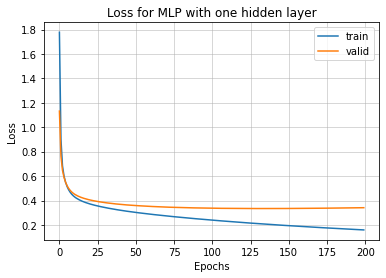

In [ ]:
plt.clf()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss for MLP with one hidden layer")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

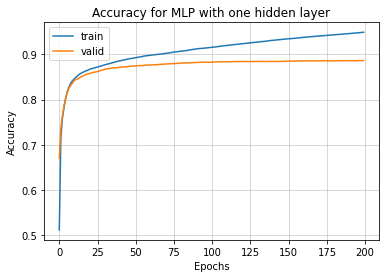

In [ ]:
plt.clf()
plt.plot(train_acc_list, label='train')
plt.plot(val_acc_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy for MLP with one hidden layer")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
y_test_probs = mlp_one_hidden.predict(x_test, is_test=True)

test_loss = EvaluationUtils.calculate_ce_loss(y_test_probs, y_test)
test_acc = EvaluationUtils.calculate_multi_accuracy(y_test_probs, y_test)

print("Test loss: {}".format(test_loss))
print("Test accuracy: {}".format(test_acc))

Test loss: 0.35621188092137906
Test accuracy: 0.8767


### MLP with two hidden layers (128 units) and ReLU activations

In [ ]:
mlp_two_hidden = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, FASHION_MNIST_N_CLASSES),
    SoftmaxOutputLayer()
)

opt_two_hidden = GradientDescentOptimizer(mlp_two_hidden, MLP_LR)
train_loss_list, val_loss_list, train_acc_list, val_acc_list = mlp_two_hidden.fit(opt_two_hidden, x_train, y_train, x_val, y_val,
                                                                                  batch_size=MLP_BATCH_SIZE, epochs=MLP_EPOCHS)

  0%|          | 1/200 [00:01<06:31,  1.96s/it]

Epoch: 1, train loss: 2.3016471476531564, train acc: 0.14054761904761898, val loss: 2.3004178632628194, val acc: 0.15983333333333333


  1%|          | 2/200 [00:03<06:26,  1.95s/it]

Epoch: 2, train loss: 2.2983629338668483, train acc: 0.21628571428571433, val loss: 2.2952354052722628, val acc: 0.2732222222222222


  2%|▏         | 3/200 [00:05<06:22,  1.94s/it]

Epoch: 3, train loss: 2.2840227161069806, train acc: 0.3105714285714283, val loss: 2.259059884884917, val acc: 0.344


  2%|▏         | 4/200 [00:07<06:15,  1.92s/it]

Epoch: 4, train loss: 2.128819076798268, train acc: 0.3918571428571429, val loss: 1.9959443772368444, val acc: 0.37933333333333336


  2%|▎         | 5/200 [00:09<06:15,  1.93s/it]

Epoch: 5, train loss: 1.8557040069607984, train acc: 0.3705952380952378, val loss: 1.6448639785705523, val acc: 0.4068888888888889


  3%|▎         | 6/200 [00:11<06:13,  1.93s/it]

Epoch: 6, train loss: 1.372347671377973, train acc: 0.4430238095238093, val loss: 1.1851657633513089, val acc: 0.49377777777777776


  4%|▎         | 7/200 [00:13<06:10,  1.92s/it]

Epoch: 7, train loss: 1.090177093714239, train acc: 0.5443571428571434, val loss: 1.0099088452457914, val acc: 0.6152222222222222


  4%|▍         | 8/200 [00:15<06:09,  1.92s/it]

Epoch: 8, train loss: 0.9364228785376241, train acc: 0.6363809523809519, val loss: 0.8737793745991269, val acc: 0.6868888888888889


  4%|▍         | 9/200 [00:17<06:08,  1.93s/it]

Epoch: 9, train loss: 0.8129413209768888, train acc: 0.6969523809523808, val loss: 0.7703930710611022, val acc: 0.7247777777777777


  5%|▌         | 10/200 [00:19<06:08,  1.94s/it]

Epoch: 10, train loss: 0.7206221370347775, train acc: 0.7364523809523803, val loss: 0.6964864132976838, val acc: 0.7412777777777778


  6%|▌         | 11/200 [00:21<06:03,  1.93s/it]

Epoch: 11, train loss: 0.6557875899882004, train acc: 0.7514285714285713, val loss: 0.6470301081351794, val acc: 0.7511666666666666


  6%|▌         | 12/200 [00:23<06:01,  1.93s/it]

Epoch: 12, train loss: 0.6127292210311689, train acc: 0.7622142857142852, val loss: 0.6144859514893067, val acc: 0.7614444444444445


  6%|▋         | 13/200 [00:25<06:00,  1.93s/it]

Epoch: 13, train loss: 0.5825233411372143, train acc: 0.7729047619047623, val loss: 0.5904710199376677, val acc: 0.7700555555555556


  7%|▋         | 14/200 [00:26<05:57,  1.92s/it]

Epoch: 14, train loss: 0.5592549243667281, train acc: 0.7818809523809522, val loss: 0.5717502475978128, val acc: 0.7769444444444444


  8%|▊         | 15/200 [00:28<05:57,  1.93s/it]

Epoch: 15, train loss: 0.540800761129522, train acc: 0.7881904761904759, val loss: 0.55673979849294, val acc: 0.7821666666666667


  8%|▊         | 16/200 [00:30<05:55,  1.93s/it]

Epoch: 16, train loss: 0.5256984822838037, train acc: 0.7943571428571431, val loss: 0.5441465416102504, val acc: 0.7861666666666667


  8%|▊         | 17/200 [00:32<05:53,  1.93s/it]

Epoch: 17, train loss: 0.5126984393506573, train acc: 0.8003809523809522, val loss: 0.5329424724272744, val acc: 0.7924444444444444


  9%|▉         | 18/200 [00:34<05:48,  1.92s/it]

Epoch: 18, train loss: 0.5009631218103631, train acc: 0.8060714285714283, val loss: 0.5225795071471017, val acc: 0.7990555555555555


 10%|▉         | 19/200 [00:36<05:47,  1.92s/it]

Epoch: 19, train loss: 0.48995932792156643, train acc: 0.812, val loss: 0.5126592661226774, val acc: 0.8045


 10%|█         | 20/200 [00:38<05:47,  1.93s/it]

Epoch: 20, train loss: 0.47938776357736196, train acc: 0.818809523809524, val loss: 0.5030366337451441, val acc: 0.8120555555555555


 10%|█         | 21/200 [00:40<05:44,  1.92s/it]

Epoch: 21, train loss: 0.4691040964815667, train acc: 0.8266190476190475, val loss: 0.49367075633093666, val acc: 0.8188333333333333


 11%|█         | 22/200 [00:42<05:40,  1.91s/it]

Epoch: 22, train loss: 0.4591483263255244, train acc: 0.83252380952381, val loss: 0.4846350741696425, val acc: 0.8242222222222222


 12%|█▏        | 23/200 [00:44<05:39,  1.92s/it]

Epoch: 23, train loss: 0.4496238683402001, train acc: 0.8369523809523808, val loss: 0.47604284099594285, val acc: 0.8287777777777777


 12%|█▏        | 24/200 [00:46<05:36,  1.91s/it]

Epoch: 24, train loss: 0.44060706912840053, train acc: 0.8410714285714292, val loss: 0.46797118882764255, val acc: 0.8323888888888888


 12%|█▎        | 25/200 [00:48<05:33,  1.91s/it]

Epoch: 25, train loss: 0.4321485991166267, train acc: 0.8440238095238101, val loss: 0.46039610159718836, val acc: 0.8346666666666667


 13%|█▎        | 26/200 [00:49<05:31,  1.90s/it]

Epoch: 26, train loss: 0.4242013556675719, train acc: 0.8467380952380954, val loss: 0.4532783558743297, val acc: 0.8370555555555556


 14%|█▎        | 27/200 [00:51<05:30,  1.91s/it]

Epoch: 27, train loss: 0.4167202603666871, train acc: 0.8498571428571431, val loss: 0.44661509151206014, val acc: 0.8406666666666667


 14%|█▍        | 28/200 [00:53<05:28,  1.91s/it]

Epoch: 28, train loss: 0.409680073308944, train acc: 0.8521904761904759, val loss: 0.4403398135058356, val acc: 0.8435


 14%|█▍        | 29/200 [00:55<05:25,  1.90s/it]

Epoch: 29, train loss: 0.40303579993492206, train acc: 0.8544523809523812, val loss: 0.43445718646911813, val acc: 0.8456111111111111


 15%|█▌        | 30/200 [00:57<05:21,  1.89s/it]

Epoch: 30, train loss: 0.39674078855721234, train acc: 0.8566666666666667, val loss: 0.4288796908718824, val acc: 0.8479444444444444


 16%|█▌        | 31/200 [00:59<05:19,  1.89s/it]

Epoch: 31, train loss: 0.3907423731060393, train acc: 0.8591190476190472, val loss: 0.4236728113199936, val acc: 0.8497222222222223


 16%|█▌        | 32/200 [01:01<05:16,  1.89s/it]

Epoch: 32, train loss: 0.3850682054419057, train acc: 0.8609285714285715, val loss: 0.41879614062751325, val acc: 0.8509444444444444


 16%|█▋        | 33/200 [01:03<05:21,  1.92s/it]

Epoch: 33, train loss: 0.3797130987818759, train acc: 0.8627857142857148, val loss: 0.414163362501096, val acc: 0.8523333333333334


 17%|█▋        | 34/200 [01:05<05:17,  1.91s/it]

Epoch: 34, train loss: 0.3746270605942652, train acc: 0.8645000000000002, val loss: 0.4098688762790055, val acc: 0.8550555555555556


 18%|█▊        | 35/200 [01:07<05:16,  1.92s/it]

Epoch: 35, train loss: 0.3698548115496325, train acc: 0.8663571428571433, val loss: 0.40587644358996533, val acc: 0.8563888888888889


 18%|█▊        | 36/200 [01:09<05:15,  1.93s/it]

Epoch: 36, train loss: 0.3653595817380189, train acc: 0.8678809523809528, val loss: 0.40215787150307086, val acc: 0.8582777777777778


 18%|█▊        | 37/200 [01:11<05:14,  1.93s/it]

Epoch: 37, train loss: 0.3611369903970814, train acc: 0.8695476190476186, val loss: 0.3987043191553336, val acc: 0.8598888888888889


 19%|█▉        | 38/200 [01:12<05:12,  1.93s/it]

Epoch: 38, train loss: 0.35714702356648714, train acc: 0.8709285714285712, val loss: 0.3954509440540169, val acc: 0.8606111111111111


 20%|█▉        | 39/200 [01:14<05:08,  1.92s/it]

Epoch: 39, train loss: 0.3533486227691775, train acc: 0.8722619047619045, val loss: 0.3923968335868286, val acc: 0.8616666666666667


 20%|██        | 40/200 [01:16<05:07,  1.92s/it]

Epoch: 40, train loss: 0.349743667985283, train acc: 0.8732380952380958, val loss: 0.3895560165978261, val acc: 0.8622777777777778


 20%|██        | 41/200 [01:18<05:03,  1.91s/it]

Epoch: 41, train loss: 0.3463075130065481, train acc: 0.874309523809524, val loss: 0.3869399388268503, val acc: 0.8631666666666666


 21%|██        | 42/200 [01:20<05:01,  1.91s/it]

Epoch: 42, train loss: 0.3430310932472124, train acc: 0.8761904761904763, val loss: 0.3844887515147307, val acc: 0.8645555555555555


 22%|██▏       | 43/200 [01:22<04:59,  1.91s/it]

Epoch: 43, train loss: 0.3398874348305083, train acc: 0.8773095238095237, val loss: 0.3821861852760625, val acc: 0.8657222222222222


 22%|██▏       | 44/200 [01:24<04:56,  1.90s/it]

Epoch: 44, train loss: 0.33685959887209777, train acc: 0.8780238095238094, val loss: 0.38000480079261567, val acc: 0.8669444444444444


 22%|██▎       | 45/200 [01:26<04:54,  1.90s/it]

Epoch: 45, train loss: 0.3339557100377837, train acc: 0.8792380952380952, val loss: 0.3779155299149301, val acc: 0.8679444444444444


 23%|██▎       | 46/200 [01:28<04:51,  1.90s/it]

Epoch: 46, train loss: 0.3311201045154057, train acc: 0.8802619047619048, val loss: 0.3759512372294644, val acc: 0.8685


 24%|██▎       | 47/200 [01:30<04:50,  1.90s/it]

Epoch: 47, train loss: 0.32837242510609593, train acc: 0.8812380952380954, val loss: 0.37405299822574206, val acc: 0.8692222222222222


 24%|██▍       | 48/200 [01:31<04:49,  1.91s/it]

Epoch: 48, train loss: 0.32569075176469786, train acc: 0.8822142857142858, val loss: 0.3722659012099846, val acc: 0.8698333333333333


 24%|██▍       | 49/200 [01:33<04:50,  1.92s/it]

Epoch: 49, train loss: 0.3230715108788292, train acc: 0.883071428571429, val loss: 0.37051719272125405, val acc: 0.8703333333333333


 25%|██▌       | 50/200 [01:35<04:46,  1.91s/it]

Epoch: 50, train loss: 0.32050759199335643, train acc: 0.8842857142857142, val loss: 0.36893918199170694, val acc: 0.8710555555555556


 26%|██▌       | 51/200 [01:37<04:45,  1.92s/it]

Epoch: 51, train loss: 0.3180178196217113, train acc: 0.8851428571428578, val loss: 0.36737950658746904, val acc: 0.8714444444444445


 26%|██▌       | 52/200 [01:39<04:43,  1.92s/it]

Epoch: 52, train loss: 0.31557925308300244, train acc: 0.8860476190476193, val loss: 0.36590101357923427, val acc: 0.8715555555555555


 26%|██▋       | 53/200 [01:41<04:42,  1.92s/it]

Epoch: 53, train loss: 0.3131844560058555, train acc: 0.8870000000000002, val loss: 0.36448431605822795, val acc: 0.8719444444444444


 27%|██▋       | 54/200 [01:43<04:40,  1.92s/it]

Epoch: 54, train loss: 0.3108341536888332, train acc: 0.8875714285714288, val loss: 0.3631780954465054, val acc: 0.8721111111111111


 28%|██▊       | 55/200 [01:45<04:38,  1.92s/it]

Epoch: 55, train loss: 0.3085395354415946, train acc: 0.888404761904762, val loss: 0.36191325764802795, val acc: 0.8730555555555556


 28%|██▊       | 56/200 [01:47<04:37,  1.93s/it]

Epoch: 56, train loss: 0.30628523344967384, train acc: 0.889142857142857, val loss: 0.3607187510016001, val acc: 0.8733888888888889


 28%|██▊       | 57/200 [01:49<04:35,  1.92s/it]

Epoch: 57, train loss: 0.30407462888913794, train acc: 0.8901428571428568, val loss: 0.35955283105486363, val acc: 0.874


 29%|██▉       | 58/200 [01:51<04:33,  1.93s/it]

Epoch: 58, train loss: 0.3018846453283686, train acc: 0.8909047619047618, val loss: 0.3584239290815998, val acc: 0.8743333333333333


 30%|██▉       | 59/200 [01:53<04:31,  1.93s/it]

Epoch: 59, train loss: 0.29973722938089165, train acc: 0.8918333333333331, val loss: 0.3573317762637604, val acc: 0.8745555555555555


 30%|███       | 60/200 [01:55<04:29,  1.92s/it]

Epoch: 60, train loss: 0.29762545744149355, train acc: 0.8924523809523806, val loss: 0.3562943731939736, val acc: 0.8751111111111111


 30%|███       | 61/200 [01:56<04:27,  1.92s/it]

Epoch: 61, train loss: 0.2955411488429688, train acc: 0.8929047619047618, val loss: 0.35528903893822894, val acc: 0.8755


 31%|███       | 62/200 [01:58<04:25,  1.92s/it]

Epoch: 62, train loss: 0.2934821232215638, train acc: 0.8935476190476184, val loss: 0.3543139540217679, val acc: 0.8758333333333334


 32%|███▏      | 63/200 [02:00<04:22,  1.92s/it]

Epoch: 63, train loss: 0.2914509046281675, train acc: 0.894309523809523, val loss: 0.35338830740816624, val acc: 0.8763333333333333


 32%|███▏      | 64/200 [02:02<04:19,  1.91s/it]

Epoch: 64, train loss: 0.2894507309546996, train acc: 0.8949285714285712, val loss: 0.3525166494569802, val acc: 0.8766111111111111


 32%|███▎      | 65/200 [02:04<04:17,  1.91s/it]

Epoch: 65, train loss: 0.28748282339626996, train acc: 0.8958095238095233, val loss: 0.351673491996106, val acc: 0.8770555555555556


 33%|███▎      | 66/200 [02:06<04:15,  1.91s/it]

Epoch: 66, train loss: 0.28554372052729415, train acc: 0.8964047619047613, val loss: 0.350879734790368, val acc: 0.8772777777777778


 34%|███▎      | 67/200 [02:08<04:13,  1.90s/it]

Epoch: 67, train loss: 0.2836336166094778, train acc: 0.8971904761904753, val loss: 0.35011876885603244, val acc: 0.8774444444444445


 34%|███▍      | 68/200 [02:10<04:10,  1.90s/it]

Epoch: 68, train loss: 0.2817471538507555, train acc: 0.8979047619047614, val loss: 0.34941436725710057, val acc: 0.8771666666666667


 34%|███▍      | 69/200 [02:12<04:10,  1.91s/it]

Epoch: 69, train loss: 0.27987872424807636, train acc: 0.8983095238095234, val loss: 0.3487265916374771, val acc: 0.8778333333333334


 35%|███▌      | 70/200 [02:14<04:08,  1.91s/it]

Epoch: 70, train loss: 0.2780396680139948, train acc: 0.8991904761904761, val loss: 0.3480601055928875, val acc: 0.8781111111111111


 36%|███▌      | 71/200 [02:16<04:05,  1.90s/it]

Epoch: 71, train loss: 0.2762169819197601, train acc: 0.8997857142857147, val loss: 0.3474736318866252, val acc: 0.8783333333333333


 36%|███▌      | 72/200 [02:17<04:04,  1.91s/it]

Epoch: 72, train loss: 0.2744254559771702, train acc: 0.9007619047619048, val loss: 0.3469018439285154, val acc: 0.8786111111111111


 36%|███▋      | 73/200 [02:19<04:00,  1.90s/it]

Epoch: 73, train loss: 0.2726463976425649, train acc: 0.9014285714285719, val loss: 0.34637701741358723, val acc: 0.8790555555555556


 37%|███▋      | 74/200 [02:21<03:58,  1.89s/it]

Epoch: 74, train loss: 0.2708817860233723, train acc: 0.9019047619047624, val loss: 0.34588643349692977, val acc: 0.8792777777777778


 38%|███▊      | 75/200 [02:23<03:55,  1.88s/it]

Epoch: 75, train loss: 0.26913298946821307, train acc: 0.9024523809523814, val loss: 0.3453804497789494, val acc: 0.8795


 38%|███▊      | 76/200 [02:25<03:51,  1.87s/it]

Epoch: 76, train loss: 0.2674045208729898, train acc: 0.9031666666666669, val loss: 0.34494148429023536, val acc: 0.8793888888888889


 38%|███▊      | 77/200 [02:27<03:50,  1.87s/it]

Epoch: 77, train loss: 0.2656842658881237, train acc: 0.9041190476190479, val loss: 0.34454057929056764, val acc: 0.8793333333333333


 39%|███▉      | 78/200 [02:29<03:48,  1.87s/it]

Epoch: 78, train loss: 0.26398958547516377, train acc: 0.9046428571428576, val loss: 0.34416574976378234, val acc: 0.8792222222222222


 40%|███▉      | 79/200 [02:31<03:46,  1.87s/it]

Epoch: 79, train loss: 0.2623069886731171, train acc: 0.9051666666666668, val loss: 0.34379628642152077, val acc: 0.8796666666666667


 40%|████      | 80/200 [02:32<03:45,  1.88s/it]

Epoch: 80, train loss: 0.2606355361402137, train acc: 0.9058095238095241, val loss: 0.34345611230792017, val acc: 0.8797777777777778


 40%|████      | 81/200 [02:34<03:45,  1.89s/it]

Epoch: 81, train loss: 0.2589762301262791, train acc: 0.9064285714285716, val loss: 0.34316259911570285, val acc: 0.8798333333333334


 41%|████      | 82/200 [02:36<03:43,  1.89s/it]

Epoch: 82, train loss: 0.2573343301100121, train acc: 0.9068809523809525, val loss: 0.34285000841094593, val acc: 0.8799444444444444


 42%|████▏     | 83/200 [02:38<03:40,  1.89s/it]

Epoch: 83, train loss: 0.25569988758203427, train acc: 0.9075238095238096, val loss: 0.3426063348355974, val acc: 0.8802222222222222


 42%|████▏     | 84/200 [02:40<03:38,  1.89s/it]

Epoch: 84, train loss: 0.25409624274287923, train acc: 0.9082380952380952, val loss: 0.3423671790889558, val acc: 0.8804444444444445


 42%|████▎     | 85/200 [02:42<03:36,  1.88s/it]

Epoch: 85, train loss: 0.25247746721676284, train acc: 0.9088809523809519, val loss: 0.34211488570175386, val acc: 0.8808333333333334


 43%|████▎     | 86/200 [02:44<03:33,  1.88s/it]

Epoch: 86, train loss: 0.25087504885256334, train acc: 0.9096428571428566, val loss: 0.34187977781966666, val acc: 0.8810555555555556


 44%|████▎     | 87/200 [02:46<03:33,  1.89s/it]

Epoch: 87, train loss: 0.2493010696607731, train acc: 0.9103333333333324, val loss: 0.341691161705391, val acc: 0.8818888888888889


 44%|████▍     | 88/200 [02:48<03:33,  1.90s/it]

Epoch: 88, train loss: 0.24774317276566135, train acc: 0.910880952380952, val loss: 0.34150852716813257, val acc: 0.8815555555555555


 44%|████▍     | 89/200 [02:49<03:31,  1.90s/it]

Epoch: 89, train loss: 0.24617036522479172, train acc: 0.9115476190476186, val loss: 0.3413736847680902, val acc: 0.8816666666666667


 45%|████▌     | 90/200 [02:51<03:28,  1.90s/it]

Epoch: 90, train loss: 0.2446334123934979, train acc: 0.9119523809523806, val loss: 0.3412529271125305, val acc: 0.8818333333333334


 46%|████▌     | 91/200 [02:53<03:27,  1.90s/it]

Epoch: 91, train loss: 0.24308449780111754, train acc: 0.9125238095238091, val loss: 0.3411582886233787, val acc: 0.8813888888888889


 46%|████▌     | 92/200 [02:55<03:24,  1.90s/it]

Epoch: 92, train loss: 0.2415708980646922, train acc: 0.9131904761904753, val loss: 0.34108736973273435, val acc: 0.8818888888888889


 46%|████▋     | 93/200 [02:57<03:22,  1.90s/it]

Epoch: 93, train loss: 0.24005773253603346, train acc: 0.9139047619047614, val loss: 0.34102720869571534, val acc: 0.8821111111111111


 47%|████▋     | 94/200 [02:59<03:21,  1.90s/it]

Epoch: 94, train loss: 0.2385435984001328, train acc: 0.9145238095238089, val loss: 0.3409672612409566, val acc: 0.8822222222222222


 48%|████▊     | 95/200 [03:01<03:20,  1.91s/it]

Epoch: 95, train loss: 0.237038117813978, train acc: 0.9149761904761896, val loss: 0.3409705318382851, val acc: 0.8823888888888889


 48%|████▊     | 96/200 [03:03<03:17,  1.90s/it]

Epoch: 96, train loss: 0.23554397339540223, train acc: 0.9154047619047613, val loss: 0.34092040834840764, val acc: 0.8821666666666667


 48%|████▊     | 97/200 [03:05<03:17,  1.92s/it]

Epoch: 97, train loss: 0.2340485073677778, train acc: 0.9159047619047613, val loss: 0.34088778641890505, val acc: 0.8827777777777778


 49%|████▉     | 98/200 [03:07<03:14,  1.91s/it]

Epoch: 98, train loss: 0.2325648446871863, train acc: 0.9165714285714283, val loss: 0.3409179353942779, val acc: 0.8830555555555556


 50%|████▉     | 99/200 [03:09<03:11,  1.90s/it]

Epoch: 99, train loss: 0.2311058158415905, train acc: 0.9174523809523801, val loss: 0.34092659111894297, val acc: 0.8831666666666667


 50%|█████     | 100/200 [03:10<03:10,  1.90s/it]

Epoch: 100, train loss: 0.22963952385210898, train acc: 0.9181904761904752, val loss: 0.3409680193306, val acc: 0.8832222222222222


 50%|█████     | 101/200 [03:12<03:09,  1.91s/it]

Epoch: 101, train loss: 0.2281877530486713, train acc: 0.9185476190476183, val loss: 0.34101415884594966, val acc: 0.8831666666666667


 51%|█████     | 102/200 [03:14<03:07,  1.92s/it]

Epoch: 102, train loss: 0.22674815778471769, train acc: 0.9189523809523804, val loss: 0.3411125820694174, val acc: 0.8833888888888889


 52%|█████▏    | 103/200 [03:16<03:06,  1.92s/it]

Epoch: 103, train loss: 0.22528965075843835, train acc: 0.9194285714285708, val loss: 0.3412056095266563, val acc: 0.8833333333333333


 52%|█████▏    | 104/200 [03:18<03:05,  1.93s/it]

Epoch: 104, train loss: 0.22386193132737456, train acc: 0.9199047619047612, val loss: 0.3413502775679234, val acc: 0.8831666666666667


 52%|█████▎    | 105/200 [03:20<03:02,  1.92s/it]

Epoch: 105, train loss: 0.22241652023738268, train acc: 0.92047619047619, val loss: 0.3414642617855698, val acc: 0.8831111111111111


 53%|█████▎    | 106/200 [03:22<03:02,  1.94s/it]

Epoch: 106, train loss: 0.22099771712916877, train acc: 0.921285714285714, val loss: 0.34160760883224306, val acc: 0.8835


 54%|█████▎    | 107/200 [03:24<02:59,  1.93s/it]

Epoch: 107, train loss: 0.21957359735964796, train acc: 0.9219047619047618, val loss: 0.3417645459343437, val acc: 0.8833333333333333


 54%|█████▍    | 108/200 [03:26<02:57,  1.92s/it]

Epoch: 108, train loss: 0.21814544093618463, train acc: 0.9223571428571427, val loss: 0.34195492902077784, val acc: 0.8836111111111111


 55%|█████▍    | 109/200 [03:28<02:55,  1.93s/it]

Epoch: 109, train loss: 0.21671963946916153, train acc: 0.9229761904761905, val loss: 0.34217759225702665, val acc: 0.8836666666666667


 55%|█████▌    | 110/200 [03:30<02:53,  1.93s/it]

Epoch: 110, train loss: 0.2153120324274595, train acc: 0.9235952380952382, val loss: 0.3423968756751933, val acc: 0.8834444444444445


 56%|█████▌    | 111/200 [03:32<02:50,  1.92s/it]

Epoch: 111, train loss: 0.21390050538361818, train acc: 0.9240952380952385, val loss: 0.34260928117906625, val acc: 0.8837777777777778


 56%|█████▌    | 112/200 [03:34<02:49,  1.93s/it]

Epoch: 112, train loss: 0.2124883512453079, train acc: 0.9247380952380954, val loss: 0.342840137978803, val acc: 0.8838888888888888


 56%|█████▋    | 113/200 [03:36<02:48,  1.94s/it]

Epoch: 113, train loss: 0.21108490296649088, train acc: 0.9253571428571432, val loss: 0.343104269498714, val acc: 0.8841111111111111


 57%|█████▋    | 114/200 [03:37<02:45,  1.93s/it]

Epoch: 114, train loss: 0.2096702111728456, train acc: 0.9258571428571429, val loss: 0.34339303453969233, val acc: 0.8839444444444444


 57%|█████▊    | 115/200 [03:39<02:45,  1.95s/it]

Epoch: 115, train loss: 0.20829432415046284, train acc: 0.9264047619047617, val loss: 0.34363547356693674, val acc: 0.8835555555555555


 58%|█████▊    | 116/200 [03:43<03:18,  2.37s/it]

Epoch: 116, train loss: 0.20691378015077, train acc: 0.9267619047619043, val loss: 0.3438956031031711, val acc: 0.8837222222222222


 58%|█████▊    | 117/200 [03:45<03:04,  2.23s/it]

Epoch: 117, train loss: 0.20553358294217197, train acc: 0.9274999999999999, val loss: 0.3443271767297294, val acc: 0.8839444444444444


 59%|█████▉    | 118/200 [03:47<02:54,  2.13s/it]

Epoch: 118, train loss: 0.20417661890808653, train acc: 0.9278809523809523, val loss: 0.34460088361234353, val acc: 0.8838888888888888


 60%|█████▉    | 119/200 [03:48<02:46,  2.05s/it]

Epoch: 119, train loss: 0.20279475458321214, train acc: 0.928452380952381, val loss: 0.3449960511541672, val acc: 0.8840555555555556


 60%|██████    | 120/200 [03:50<02:43,  2.04s/it]

Epoch: 120, train loss: 0.20143232523022914, train acc: 0.9290476190476191, val loss: 0.34542380391976346, val acc: 0.8840555555555556


 60%|██████    | 121/200 [03:52<02:38,  2.00s/it]

Epoch: 121, train loss: 0.2000648904827247, train acc: 0.929619047619048, val loss: 0.34567256976397265, val acc: 0.8838888888888888


 61%|██████    | 122/200 [03:54<02:33,  1.97s/it]

Epoch: 122, train loss: 0.19870596743382718, train acc: 0.9303095238095241, val loss: 0.34609886035606846, val acc: 0.884


 62%|██████▏   | 123/200 [03:56<02:31,  1.97s/it]

Epoch: 123, train loss: 0.1973358935288854, train acc: 0.9307619047619051, val loss: 0.34639511562196296, val acc: 0.8838888888888888


 62%|██████▏   | 124/200 [03:58<02:27,  1.94s/it]

Epoch: 124, train loss: 0.19598443178649574, train acc: 0.9313333333333338, val loss: 0.3469598617540468, val acc: 0.8839444444444444


 62%|██████▎   | 125/200 [04:00<02:23,  1.92s/it]

Epoch: 125, train loss: 0.19461859178737495, train acc: 0.9321904761904762, val loss: 0.34733063049303536, val acc: 0.8842222222222222


 63%|██████▎   | 126/200 [04:02<02:20,  1.91s/it]

Epoch: 126, train loss: 0.1932805441752704, train acc: 0.9330000000000004, val loss: 0.3477035294950385, val acc: 0.884


 64%|██████▎   | 127/200 [04:04<02:19,  1.90s/it]

Epoch: 127, train loss: 0.19193017586670766, train acc: 0.9335000000000001, val loss: 0.34820879582283004, val acc: 0.884


 64%|██████▍   | 128/200 [04:06<02:17,  1.91s/it]

Epoch: 128, train loss: 0.19061585646003454, train acc: 0.9338333333333337, val loss: 0.34859334596532504, val acc: 0.8838333333333334


 64%|██████▍   | 129/200 [04:08<02:15,  1.90s/it]

Epoch: 129, train loss: 0.18926939747508234, train acc: 0.934666666666667, val loss: 0.3490545095677474, val acc: 0.8840555555555556


 65%|██████▌   | 130/200 [04:09<02:13,  1.90s/it]

Epoch: 130, train loss: 0.18792349742427192, train acc: 0.9350476190476193, val loss: 0.349570120642325, val acc: 0.8842222222222222


 66%|██████▌   | 131/200 [04:11<02:11,  1.91s/it]

Epoch: 131, train loss: 0.18660095544862712, train acc: 0.935571428571429, val loss: 0.35004521043025155, val acc: 0.8843888888888889


 66%|██████▌   | 132/200 [04:13<02:09,  1.91s/it]

Epoch: 132, train loss: 0.18527190581148836, train acc: 0.9362857142857146, val loss: 0.35053750486849344, val acc: 0.8843333333333333


 66%|██████▋   | 133/200 [04:15<02:07,  1.90s/it]

Epoch: 133, train loss: 0.1839401451639979, train acc: 0.9366904761904764, val loss: 0.35110279878579864, val acc: 0.8842222222222222


 67%|██████▋   | 134/200 [04:17<02:04,  1.89s/it]

Epoch: 134, train loss: 0.18262606066618914, train acc: 0.9372380952380954, val loss: 0.35165578159803085, val acc: 0.8843888888888889


 68%|██████▊   | 135/200 [04:19<02:02,  1.88s/it]

Epoch: 135, train loss: 0.18132812327515885, train acc: 0.9376666666666668, val loss: 0.35227625781954364, val acc: 0.8842777777777778


 68%|██████▊   | 136/200 [04:21<02:01,  1.89s/it]

Epoch: 136, train loss: 0.18002059785559543, train acc: 0.9381428571428573, val loss: 0.35274471383722744, val acc: 0.8841666666666667


 68%|██████▊   | 137/200 [04:23<01:58,  1.88s/it]

Epoch: 137, train loss: 0.17871566413310128, train acc: 0.9386904761904764, val loss: 0.35341231477932455, val acc: 0.8841666666666667


 69%|██████▉   | 138/200 [04:25<01:56,  1.87s/it]

Epoch: 138, train loss: 0.17743474641646356, train acc: 0.9393809523809526, val loss: 0.3539595454051662, val acc: 0.8841111111111111


 70%|██████▉   | 139/200 [04:26<01:54,  1.87s/it]

Epoch: 139, train loss: 0.17613590688218567, train acc: 0.9397380952380956, val loss: 0.3544941279798946, val acc: 0.8837777777777778


 70%|███████   | 140/200 [04:28<01:52,  1.88s/it]

Epoch: 140, train loss: 0.17485366092756166, train acc: 0.9402142857142858, val loss: 0.3550266676047081, val acc: 0.8834444444444445


 70%|███████   | 141/200 [04:30<01:51,  1.89s/it]

Epoch: 141, train loss: 0.1735746708479586, train acc: 0.9407619047619045, val loss: 0.3556530293212759, val acc: 0.8835


 71%|███████   | 142/200 [04:32<01:50,  1.90s/it]

Epoch: 142, train loss: 0.17228734167791113, train acc: 0.9411666666666665, val loss: 0.3563646385879096, val acc: 0.8833888888888889


 72%|███████▏  | 143/200 [04:34<01:48,  1.90s/it]

Epoch: 143, train loss: 0.171028243592584, train acc: 0.9416904761904761, val loss: 0.35698324191837794, val acc: 0.8835


 72%|███████▏  | 144/200 [04:36<01:46,  1.90s/it]

Epoch: 144, train loss: 0.1697525520315811, train acc: 0.9420476190476191, val loss: 0.3575961889584192, val acc: 0.8835555555555555


 72%|███████▎  | 145/200 [04:38<01:44,  1.90s/it]

Epoch: 145, train loss: 0.16846375883623338, train acc: 0.9425714285714286, val loss: 0.35820615037290615, val acc: 0.8836111111111111


 73%|███████▎  | 146/200 [04:40<01:42,  1.89s/it]

Epoch: 146, train loss: 0.16722850510979334, train acc: 0.9432142857142861, val loss: 0.3587252013740984, val acc: 0.8836111111111111


 74%|███████▎  | 147/200 [04:42<01:41,  1.91s/it]

Epoch: 147, train loss: 0.16600548716352717, train acc: 0.9439047619047619, val loss: 0.359499707551304, val acc: 0.8833333333333333


 74%|███████▍  | 148/200 [04:44<01:39,  1.91s/it]

Epoch: 148, train loss: 0.1647684013158987, train acc: 0.9440952380952382, val loss: 0.3600805459377025, val acc: 0.8834444444444445


 74%|███████▍  | 149/200 [04:45<01:36,  1.90s/it]

Epoch: 149, train loss: 0.1635239447271827, train acc: 0.9448809523809528, val loss: 0.36075517130680157, val acc: 0.8832777777777778


 75%|███████▌  | 150/200 [04:47<01:35,  1.90s/it]

Epoch: 150, train loss: 0.16226797799713508, train acc: 0.9452142857142865, val loss: 0.36130229451696305, val acc: 0.8831111111111111


 76%|███████▌  | 151/200 [04:49<01:32,  1.89s/it]

Epoch: 151, train loss: 0.16106461385101328, train acc: 0.945928571428572, val loss: 0.36214814077518453, val acc: 0.8831666666666667


 76%|███████▌  | 152/200 [04:51<01:30,  1.89s/it]

Epoch: 152, train loss: 0.15984868659639484, train acc: 0.9463095238095242, val loss: 0.36292305042891654, val acc: 0.8831666666666667


 76%|███████▋  | 153/200 [04:53<01:28,  1.89s/it]

Epoch: 153, train loss: 0.15861339552172932, train acc: 0.9469047619047622, val loss: 0.3634958533611827, val acc: 0.8829444444444444


 77%|███████▋  | 154/200 [04:55<01:27,  1.90s/it]

Epoch: 154, train loss: 0.1573848427397339, train acc: 0.9471428571428574, val loss: 0.3642621143634442, val acc: 0.8830555555555556


 78%|███████▊  | 155/200 [04:57<01:26,  1.92s/it]

Epoch: 155, train loss: 0.15616493305602297, train acc: 0.9478809523809527, val loss: 0.365044231708324, val acc: 0.8829444444444444


 78%|███████▊  | 156/200 [04:59<01:23,  1.90s/it]

Epoch: 156, train loss: 0.15496598437006476, train acc: 0.9483571428571432, val loss: 0.36560574033933246, val acc: 0.8832777777777778


 78%|███████▊  | 157/200 [05:01<01:21,  1.90s/it]

Epoch: 157, train loss: 0.15376976295148337, train acc: 0.9485952380952384, val loss: 0.36639524497851533, val acc: 0.8833888888888889


 79%|███████▉  | 158/200 [05:02<01:19,  1.89s/it]

Epoch: 158, train loss: 0.15255086865716305, train acc: 0.9491666666666672, val loss: 0.36717631706639137, val acc: 0.8833333333333333


 80%|███████▉  | 159/200 [05:04<01:17,  1.90s/it]

Epoch: 159, train loss: 0.15136810075643112, train acc: 0.9497142857142864, val loss: 0.3678814610789779, val acc: 0.8831666666666667


 80%|████████  | 160/200 [05:06<01:16,  1.92s/it]

Epoch: 160, train loss: 0.15017712942234285, train acc: 0.9501666666666674, val loss: 0.3685874855846304, val acc: 0.8831666666666667


 80%|████████  | 161/200 [05:08<01:14,  1.91s/it]

Epoch: 161, train loss: 0.1489921381722054, train acc: 0.9506428571428579, val loss: 0.36946174397171844, val acc: 0.8832222222222222


 81%|████████  | 162/200 [05:10<01:12,  1.92s/it]

Epoch: 162, train loss: 0.1478241268220242, train acc: 0.9510476190476198, val loss: 0.37017438063067293, val acc: 0.8831666666666667


 82%|████████▏ | 163/200 [05:12<01:11,  1.93s/it]

Epoch: 163, train loss: 0.14663769452538958, train acc: 0.95154761904762, val loss: 0.37089173622782723, val acc: 0.8832777777777778


 82%|████████▏ | 164/200 [05:14<01:09,  1.93s/it]

Epoch: 164, train loss: 0.14545387420951725, train acc: 0.9520952380952384, val loss: 0.3717754519972983, val acc: 0.8833888888888889


 82%|████████▎ | 165/200 [05:16<01:07,  1.93s/it]

Epoch: 165, train loss: 0.14429600123221867, train acc: 0.952571428571429, val loss: 0.37271991157320494, val acc: 0.8833888888888889


 83%|████████▎ | 166/200 [05:18<01:05,  1.92s/it]

Epoch: 166, train loss: 0.14313878523205853, train acc: 0.9529761904761908, val loss: 0.37352407538928534, val acc: 0.8835555555555555


 84%|████████▎ | 167/200 [05:20<01:03,  1.93s/it]

Epoch: 167, train loss: 0.1420264262985725, train acc: 0.953619047619048, val loss: 0.37430654822385906, val acc: 0.8835


 84%|████████▍ | 168/200 [05:22<01:01,  1.93s/it]

Epoch: 168, train loss: 0.14088229396601162, train acc: 0.9542380952380953, val loss: 0.37532649996257667, val acc: 0.8833333333333333


 84%|████████▍ | 169/200 [05:24<00:59,  1.93s/it]

Epoch: 169, train loss: 0.13974002512808886, train acc: 0.9549047619047621, val loss: 0.37626283426311136, val acc: 0.8835


 85%|████████▌ | 170/200 [05:26<00:57,  1.92s/it]

Epoch: 170, train loss: 0.1385884168883916, train acc: 0.955571428571429, val loss: 0.3770691898228964, val acc: 0.8831111111111111


 86%|████████▌ | 171/200 [05:28<00:55,  1.92s/it]

Epoch: 171, train loss: 0.1374747173578819, train acc: 0.9559047619047623, val loss: 0.3780094083698934, val acc: 0.8835


 86%|████████▌ | 172/200 [05:29<00:53,  1.91s/it]

Epoch: 172, train loss: 0.13635482222833809, train acc: 0.9561904761904765, val loss: 0.37895210895461623, val acc: 0.8830555555555556


 86%|████████▋ | 173/200 [05:31<00:51,  1.91s/it]

Epoch: 173, train loss: 0.13521281764223433, train acc: 0.9569047619047621, val loss: 0.37998744042361293, val acc: 0.883


 87%|████████▋ | 174/200 [05:33<00:49,  1.92s/it]

Epoch: 174, train loss: 0.13410312863725474, train acc: 0.9570714285714288, val loss: 0.3807713664706419, val acc: 0.8832777777777778


 88%|████████▊ | 175/200 [05:35<00:47,  1.91s/it]

Epoch: 175, train loss: 0.13298237140383418, train acc: 0.957714285714286, val loss: 0.38183552393620895, val acc: 0.8830555555555556


 88%|████████▊ | 176/200 [05:37<00:45,  1.91s/it]

Epoch: 176, train loss: 0.1318749031878385, train acc: 0.9581428571428577, val loss: 0.3827785992423649, val acc: 0.8831111111111111


 88%|████████▊ | 177/200 [05:39<00:43,  1.90s/it]

Epoch: 177, train loss: 0.13078389604565013, train acc: 0.9585000000000002, val loss: 0.38388848268941844, val acc: 0.8831666666666667


 89%|████████▉ | 178/200 [05:41<00:41,  1.89s/it]

Epoch: 178, train loss: 0.12968787682520275, train acc: 0.9590000000000003, val loss: 0.3848849390008577, val acc: 0.8836666666666667


 90%|████████▉ | 179/200 [05:43<00:39,  1.88s/it]

Epoch: 179, train loss: 0.12860116502502894, train acc: 0.9593571428571431, val loss: 0.3859524828498061, val acc: 0.8836111111111111


 90%|█████████ | 180/200 [05:45<00:37,  1.88s/it]

Epoch: 180, train loss: 0.1275007931056114, train acc: 0.9596904761904768, val loss: 0.387083414489191, val acc: 0.8834444444444445


 90%|█████████ | 181/200 [05:46<00:35,  1.89s/it]

Epoch: 181, train loss: 0.1264230216890299, train acc: 0.9600952380952388, val loss: 0.38822080200015163, val acc: 0.8832222222222222


 91%|█████████ | 182/200 [05:48<00:34,  1.89s/it]

Epoch: 182, train loss: 0.12533930766906948, train acc: 0.9604047619047624, val loss: 0.3892123016507954, val acc: 0.8830555555555556


 92%|█████████▏| 183/200 [05:50<00:32,  1.90s/it]

Epoch: 183, train loss: 0.12429991310372096, train acc: 0.9609047619047628, val loss: 0.39020323734184764, val acc: 0.8828888888888888


 92%|█████████▏| 184/200 [05:52<00:30,  1.91s/it]

Epoch: 184, train loss: 0.12322419313933466, train acc: 0.9614047619047632, val loss: 0.39118607911879577, val acc: 0.8828888888888888


 92%|█████████▎| 185/200 [05:54<00:28,  1.90s/it]

Epoch: 185, train loss: 0.12219561495957505, train acc: 0.9620476190476204, val loss: 0.3923311681648913, val acc: 0.8827222222222222


 93%|█████████▎| 186/200 [05:56<00:26,  1.90s/it]

Epoch: 186, train loss: 0.1211358014012636, train acc: 0.9623333333333343, val loss: 0.3931325326820094, val acc: 0.8824444444444445


 94%|█████████▎| 187/200 [05:58<00:24,  1.91s/it]

Epoch: 187, train loss: 0.1200736265460871, train acc: 0.9627380952380963, val loss: 0.39438982699249514, val acc: 0.8823333333333333


 94%|█████████▍| 188/200 [06:00<00:22,  1.91s/it]

Epoch: 188, train loss: 0.1190676602033256, train acc: 0.9631190476190488, val loss: 0.39554217429815935, val acc: 0.8822222222222222


 94%|█████████▍| 189/200 [06:02<00:20,  1.91s/it]

Epoch: 189, train loss: 0.11799789619448409, train acc: 0.9635952380952392, val loss: 0.39663722563792536, val acc: 0.8821666666666667


 95%|█████████▌| 190/200 [06:04<00:19,  1.90s/it]

Epoch: 190, train loss: 0.11698600457951948, train acc: 0.9640000000000011, val loss: 0.3979329420323541, val acc: 0.8821666666666667


 96%|█████████▌| 191/200 [06:06<00:17,  1.89s/it]

Epoch: 191, train loss: 0.11596021405787683, train acc: 0.9643571428571439, val loss: 0.3988992949103036, val acc: 0.8826666666666667


 96%|█████████▌| 192/200 [06:07<00:15,  1.90s/it]

Epoch: 192, train loss: 0.11497478097337054, train acc: 0.9646428571428586, val loss: 0.40010232060421796, val acc: 0.8829444444444444


 96%|█████████▋| 193/200 [06:09<00:13,  1.89s/it]

Epoch: 193, train loss: 0.1139673780707173, train acc: 0.96507142857143, val loss: 0.40106628819431744, val acc: 0.8826111111111111


 97%|█████████▋| 194/200 [06:11<00:11,  1.90s/it]

Epoch: 194, train loss: 0.11296891567223319, train acc: 0.9655476190476207, val loss: 0.4022115668474833, val acc: 0.8825555555555555


 98%|█████████▊| 195/200 [06:13<00:09,  1.90s/it]

Epoch: 195, train loss: 0.11196832530451091, train acc: 0.9658809523809537, val loss: 0.40344223403083845, val acc: 0.8826111111111111


 98%|█████████▊| 196/200 [06:15<00:07,  1.89s/it]

Epoch: 196, train loss: 0.11097293018463021, train acc: 0.9664285714285726, val loss: 0.40445249622403157, val acc: 0.883


 98%|█████████▊| 197/200 [06:17<00:05,  1.88s/it]

Epoch: 197, train loss: 0.11002354685252388, train acc: 0.966714285714287, val loss: 0.4055710506673795, val acc: 0.8828888888888888


 99%|█████████▉| 198/200 [06:19<00:03,  1.89s/it]

Epoch: 198, train loss: 0.10900134151761982, train acc: 0.9672380952380969, val loss: 0.40683282258313197, val acc: 0.8828333333333334


100%|█████████▉| 199/200 [06:21<00:01,  1.90s/it]

Epoch: 199, train loss: 0.10804966959767487, train acc: 0.9676666666666685, val loss: 0.40800089470450246, val acc: 0.8831666666666667


100%|██████████| 200/200 [06:23<00:00,  1.92s/it]

Epoch: 200, train loss: 0.10707452276443757, train acc: 0.9679523809523829, val loss: 0.40944161541643675, val acc: 0.8828333333333334


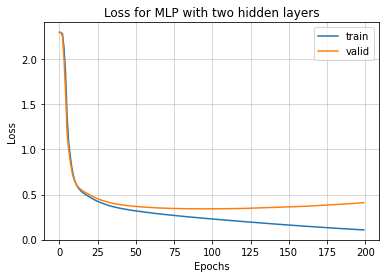

In [ ]:
plt.clf()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss for MLP with two hidden layers")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

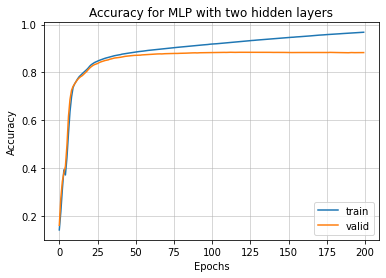

In [ ]:
plt.clf()
plt.plot(train_acc_list, label='train')
plt.plot(val_acc_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy for MLP with two hidden layers")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
y_test_probs = mlp_two_hidden.predict(x_test, is_test=True)

test_loss = EvaluationUtils.calculate_ce_loss(y_test_probs, y_test)
test_acc = EvaluationUtils.calculate_multi_accuracy(y_test_probs, y_test)

print("Test loss: {}".format(test_loss))
print("Test accuracy: {}".format(test_acc))

Test loss: 0.3670706942786288
Test accuracy: 0.8724


## Sub-task 2:

### MLP with two hidden layers (128 units) and tanh activations

In [ ]:
mlp_two_hidden_tanh = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    TanhLayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    TanhLayer(),
    LinearLayer(HIDDEN_SIZE, FASHION_MNIST_N_CLASSES),
    SoftmaxOutputLayer()
)

opt_two_hidden_tanh = GradientDescentOptimizer(mlp_two_hidden_tanh, MLP_LR)
train_loss_list, val_loss_list, train_acc_list, val_acc_list = mlp_two_hidden_tanh.fit(opt_two_hidden_tanh, x_train, y_train, x_val, y_val,
                                                                                  batch_size=MLP_BATCH_SIZE, epochs=MLP_EPOCHS)

  0%|          | 1/200 [00:02<08:22,  2.53s/it]

Epoch: 1, train loss: 2.293638576218366, train acc: 0.26990476190476187, val loss: 2.2744603670018555, val acc: 0.46294444444444444


  1%|          | 2/200 [00:04<07:04,  2.15s/it]

Epoch: 2, train loss: 2.0959594141817135, train acc: 0.378833333333334, val loss: 1.792994890134482, val acc: 0.3537222222222222


  2%|▏         | 3/200 [00:06<06:37,  2.02s/it]

Epoch: 3, train loss: 1.5872720612731657, train acc: 0.396261904761905, val loss: 1.395489333466515, val acc: 0.47688888888888886


  2%|▏         | 4/200 [00:08<06:25,  1.97s/it]

Epoch: 4, train loss: 1.2682942711544665, train acc: 0.5087857142857145, val loss: 1.1658661576206921, val acc: 0.5421111111111111


  2%|▎         | 5/200 [00:09<06:14,  1.92s/it]

Epoch: 5, train loss: 1.0916521206199878, train acc: 0.5610714285714291, val loss: 1.0334493201809363, val acc: 0.5890555555555556


  3%|▎         | 6/200 [00:11<06:08,  1.90s/it]

Epoch: 6, train loss: 0.9718827928029906, train acc: 0.6283095238095239, val loss: 0.9252636237832513, val acc: 0.6763888888888889


  4%|▎         | 7/200 [00:13<06:05,  1.89s/it]

Epoch: 7, train loss: 0.8608257262293998, train acc: 0.7012857142857141, val loss: 0.8190965542364609, val acc: 0.7178333333333333


  4%|▍         | 8/200 [00:15<06:00,  1.88s/it]

Epoch: 8, train loss: 0.7600915592495734, train acc: 0.7380476190476187, val loss: 0.7345608687547561, val acc: 0.7388333333333333


  4%|▍         | 9/200 [00:17<05:56,  1.87s/it]

Epoch: 9, train loss: 0.6867449318869292, train acc: 0.7547619047619049, val loss: 0.6766929593466009, val acc: 0.7551666666666667


  5%|▌         | 10/200 [00:19<05:55,  1.87s/it]

Epoch: 10, train loss: 0.6354316548649899, train acc: 0.7701666666666668, val loss: 0.6351335878325953, val acc: 0.7690555555555556


  6%|▌         | 11/200 [00:21<05:52,  1.86s/it]

Epoch: 11, train loss: 0.5972537874688734, train acc: 0.7842619047619054, val loss: 0.6033482774539787, val acc: 0.7807777777777778


  6%|▌         | 12/200 [00:23<05:51,  1.87s/it]

Epoch: 12, train loss: 0.5676488984289602, train acc: 0.796547619047619, val loss: 0.5783727018619083, val acc: 0.7921111111111111


  6%|▋         | 13/200 [00:24<05:49,  1.87s/it]

Epoch: 13, train loss: 0.5442026953881764, train acc: 0.8049761904761907, val loss: 0.5584068499473225, val acc: 0.8000555555555555


  7%|▋         | 14/200 [00:26<05:46,  1.86s/it]

Epoch: 14, train loss: 0.5251811961755962, train acc: 0.8129523809523805, val loss: 0.5420665489215685, val acc: 0.8058333333333333


  8%|▊         | 15/200 [00:28<05:45,  1.87s/it]

Epoch: 15, train loss: 0.5093350905541831, train acc: 0.8191428571428572, val loss: 0.5284003379895897, val acc: 0.8123333333333334


  8%|▊         | 16/200 [00:30<05:44,  1.87s/it]

Epoch: 16, train loss: 0.4958714045027049, train acc: 0.8241190476190486, val loss: 0.5167979389955504, val acc: 0.8165


  8%|▊         | 17/200 [00:32<05:44,  1.88s/it]

Epoch: 17, train loss: 0.4842665115506786, train acc: 0.8285476190476199, val loss: 0.5068186097962727, val acc: 0.8211111111111111


  9%|▉         | 18/200 [00:34<05:43,  1.89s/it]

Epoch: 18, train loss: 0.4741215916833774, train acc: 0.8330238095238097, val loss: 0.4981068589305764, val acc: 0.8246666666666667


 10%|▉         | 19/200 [00:36<05:41,  1.88s/it]

Epoch: 19, train loss: 0.46511686604151914, train acc: 0.8365952380952377, val loss: 0.4903770961071549, val acc: 0.8275


 10%|█         | 20/200 [00:38<05:37,  1.87s/it]

Epoch: 20, train loss: 0.45700280311656194, train acc: 0.8396428571428568, val loss: 0.4834124346336535, val acc: 0.8305


 10%|█         | 21/200 [00:39<05:36,  1.88s/it]

Epoch: 21, train loss: 0.44959301983084193, train acc: 0.8421904761904768, val loss: 0.4770562169451355, val acc: 0.8326111111111111


 11%|█         | 22/200 [00:41<05:35,  1.88s/it]

Epoch: 22, train loss: 0.4427523574098286, train acc: 0.8441428571428577, val loss: 0.471197391495895, val acc: 0.8337222222222223


 12%|█▏        | 23/200 [00:43<05:33,  1.89s/it]

Epoch: 23, train loss: 0.436383282808565, train acc: 0.8463333333333339, val loss: 0.46575632071031403, val acc: 0.8355


 12%|█▏        | 24/200 [00:45<05:31,  1.88s/it]

Epoch: 24, train loss: 0.430414127386215, train acc: 0.8484761904761912, val loss: 0.4606740061618968, val acc: 0.8377777777777777


 12%|█▎        | 25/200 [00:47<05:29,  1.88s/it]

Epoch: 25, train loss: 0.4247902893508143, train acc: 0.850166666666667, val loss: 0.4559048830149493, val acc: 0.84


 13%|█▎        | 26/200 [00:49<05:29,  1.90s/it]

Epoch: 26, train loss: 0.41946827429626105, train acc: 0.8522857142857144, val loss: 0.45141238051418237, val acc: 0.8417222222222223


 14%|█▎        | 27/200 [00:51<05:28,  1.90s/it]

Epoch: 27, train loss: 0.41441209383482064, train acc: 0.854214285714286, val loss: 0.4471663216124312, val acc: 0.8436111111111111


 14%|█▍        | 28/200 [00:53<05:26,  1.90s/it]

Epoch: 28, train loss: 0.40959134166414, train acc: 0.8561904761904768, val loss: 0.44314135801320587, val acc: 0.8450555555555556


 14%|█▍        | 29/200 [00:55<05:23,  1.89s/it]

Epoch: 29, train loss: 0.40498018206471054, train acc: 0.8577142857142858, val loss: 0.4393158678255283, val acc: 0.8466111111111111


 15%|█▌        | 30/200 [00:56<05:20,  1.88s/it]

Epoch: 30, train loss: 0.4005565839566549, train acc: 0.8593809523809529, val loss: 0.4356710446267299, val acc: 0.8473333333333334


 16%|█▌        | 31/200 [00:58<05:18,  1.88s/it]

Epoch: 31, train loss: 0.3963015142459517, train acc: 0.8608095238095244, val loss: 0.4321902039569383, val acc: 0.8488888888888889


 16%|█▌        | 32/200 [01:00<05:17,  1.89s/it]

Epoch: 32, train loss: 0.3921982193555323, train acc: 0.862428571428572, val loss: 0.4288584020439713, val acc: 0.8505


 16%|█▋        | 33/200 [01:02<05:13,  1.88s/it]

Epoch: 33, train loss: 0.3882317699653274, train acc: 0.8634523809523812, val loss: 0.4256622849982285, val acc: 0.8517777777777777


 17%|█▋        | 34/200 [01:04<05:11,  1.87s/it]

Epoch: 34, train loss: 0.38438883408969876, train acc: 0.8645476190476189, val loss: 0.42258999033912387, val acc: 0.8529444444444444


 18%|█▊        | 35/200 [01:06<05:07,  1.87s/it]

Epoch: 35, train loss: 0.38065754672502733, train acc: 0.866238095238096, val loss: 0.4196310136645979, val acc: 0.8542222222222222


 18%|█▊        | 36/200 [01:08<05:04,  1.86s/it]

Epoch: 36, train loss: 0.37702740315451155, train acc: 0.8675238095238103, val loss: 0.41677606027023395, val acc: 0.8549444444444444


 18%|█▊        | 37/200 [01:10<05:03,  1.86s/it]

Epoch: 37, train loss: 0.3734891786390084, train acc: 0.8686666666666678, val loss: 0.41401694159432156, val acc: 0.8557777777777777


 19%|█▉        | 38/200 [01:11<05:03,  1.87s/it]

Epoch: 38, train loss: 0.3700349295465, train acc: 0.8696666666666676, val loss: 0.41134655604070214, val acc: 0.8572777777777778


 20%|█▉        | 39/200 [01:13<05:02,  1.88s/it]

Epoch: 39, train loss: 0.36665808818409856, train acc: 0.8708095238095249, val loss: 0.40875885460785877, val acc: 0.8581666666666666


 20%|██        | 40/200 [01:15<05:02,  1.89s/it]

Epoch: 40, train loss: 0.3633533817219049, train acc: 0.8715000000000013, val loss: 0.4062486151113069, val acc: 0.8588888888888889


 20%|██        | 41/200 [01:17<04:58,  1.88s/it]

Epoch: 41, train loss: 0.3601163697407897, train acc: 0.8725714285714294, val loss: 0.403811226780357, val acc: 0.86


 21%|██        | 42/200 [01:19<04:55,  1.87s/it]

Epoch: 42, train loss: 0.3569430898209256, train acc: 0.8737380952380953, val loss: 0.4014427108362494, val acc: 0.8604444444444445


 22%|██▏       | 43/200 [01:21<04:52,  1.86s/it]

Epoch: 43, train loss: 0.3538300425932871, train acc: 0.8748333333333334, val loss: 0.3991397739460564, val acc: 0.8611666666666666


 22%|██▏       | 44/200 [01:23<04:50,  1.86s/it]

Epoch: 44, train loss: 0.3507742193187724, train acc: 0.8760238095238095, val loss: 0.39689976913103336, val acc: 0.8623888888888889


 22%|██▎       | 45/200 [01:24<04:45,  1.84s/it]

Epoch: 45, train loss: 0.3477730603690451, train acc: 0.8771904761904761, val loss: 0.3947205993247475, val acc: 0.8628888888888889


 23%|██▎       | 46/200 [01:26<04:45,  1.85s/it]

Epoch: 46, train loss: 0.344824386151791, train acc: 0.87802380952381, val loss: 0.39260060809934516, val acc: 0.8631666666666666


 24%|██▎       | 47/200 [01:28<04:43,  1.85s/it]

Epoch: 47, train loss: 0.3419263331294524, train acc: 0.8791428571428571, val loss: 0.3905384750808833, val acc: 0.8636111111111111


 24%|██▍       | 48/200 [01:30<04:42,  1.86s/it]

Epoch: 48, train loss: 0.3390772969430089, train acc: 0.8802857142857142, val loss: 0.388533114909274, val acc: 0.8638333333333333


 24%|██▍       | 49/200 [01:32<04:41,  1.86s/it]

Epoch: 49, train loss: 0.33627586676414734, train acc: 0.8813571428571432, val loss: 0.38658359101205164, val acc: 0.8645


 25%|██▌       | 50/200 [01:34<04:39,  1.86s/it]

Epoch: 50, train loss: 0.3335207557246952, train acc: 0.8820714285714286, val loss: 0.3846890720653756, val acc: 0.8651111111111112


 26%|██▌       | 51/200 [01:36<04:37,  1.86s/it]

Epoch: 51, train loss: 0.33081077351900373, train acc: 0.8831428571428573, val loss: 0.3828488193510174, val acc: 0.866


 26%|██▌       | 52/200 [01:37<04:35,  1.86s/it]

Epoch: 52, train loss: 0.32814485785246555, train acc: 0.8839523809523805, val loss: 0.3810621546970335, val acc: 0.8666111111111111


 26%|██▋       | 53/200 [01:39<04:33,  1.86s/it]

Epoch: 53, train loss: 0.3255220964158824, train acc: 0.8847857142857137, val loss: 0.37932839834057175, val acc: 0.8677222222222222


 27%|██▋       | 54/200 [01:41<04:31,  1.86s/it]

Epoch: 54, train loss: 0.32294166191287205, train acc: 0.8860952380952375, val loss: 0.3776468129188618, val acc: 0.8682777777777778


 28%|██▊       | 55/200 [01:43<04:29,  1.86s/it]

Epoch: 55, train loss: 0.32040268807740807, train acc: 0.8869999999999993, val loss: 0.3760165804251953, val acc: 0.8688333333333333


 28%|██▊       | 56/200 [01:45<04:29,  1.87s/it]

Epoch: 56, train loss: 0.31790418868844567, train acc: 0.8878333333333331, val loss: 0.37443680658730055, val acc: 0.8693888888888889


 28%|██▊       | 57/200 [01:47<04:26,  1.87s/it]

Epoch: 57, train loss: 0.3154450531830879, train acc: 0.8883333333333332, val loss: 0.37290653554232095, val acc: 0.8699444444444444


 29%|██▉       | 58/200 [01:49<04:25,  1.87s/it]

Epoch: 58, train loss: 0.31302407979248287, train acc: 0.8889999999999997, val loss: 0.37142476385764017, val acc: 0.8703888888888889


 30%|██▉       | 59/200 [01:51<04:24,  1.88s/it]

Epoch: 59, train loss: 0.31064001137796615, train acc: 0.8899999999999995, val loss: 0.36999045090739563, val acc: 0.8707777777777778


 30%|███       | 60/200 [01:52<04:22,  1.88s/it]

Epoch: 60, train loss: 0.3082915623355883, train acc: 0.8909761904761903, val loss: 0.3686025261568563, val acc: 0.8707777777777778


 30%|███       | 61/200 [01:54<04:19,  1.87s/it]

Epoch: 61, train loss: 0.3059774364632756, train acc: 0.8922619047619045, val loss: 0.3672598938768217, val acc: 0.8715


 31%|███       | 62/200 [01:56<04:16,  1.86s/it]

Epoch: 62, train loss: 0.3036963384459608, train acc: 0.8931190476190473, val loss: 0.3659614351125362, val acc: 0.872


 32%|███▏      | 63/200 [01:58<04:14,  1.85s/it]

Epoch: 63, train loss: 0.30144698123712116, train acc: 0.8938809523809527, val loss: 0.3647060068412194, val acc: 0.8722222222222222


 32%|███▏      | 64/200 [02:00<04:12,  1.86s/it]

Epoch: 64, train loss: 0.2992280908897142, train acc: 0.8948333333333335, val loss: 0.363492439322234, val acc: 0.8727777777777778


 32%|███▎      | 65/200 [02:02<04:09,  1.85s/it]

Epoch: 65, train loss: 0.2970384099461598, train acc: 0.8957857142857142, val loss: 0.36231953390178034, val acc: 0.8732777777777778


 33%|███▎      | 66/200 [02:04<04:09,  1.86s/it]

Epoch: 66, train loss: 0.2948767000453713, train acc: 0.8965714285714286, val loss: 0.36118606381610296, val acc: 0.874


 34%|███▎      | 67/200 [02:05<04:07,  1.86s/it]

Epoch: 67, train loss: 0.2927417438177935, train acc: 0.8972857142857146, val loss: 0.36009077946622836, val acc: 0.8742222222222222


 34%|███▍      | 68/200 [02:07<04:05,  1.86s/it]

Epoch: 68, train loss: 0.29063234581989844, train acc: 0.8977619047619048, val loss: 0.3590324180084032, val acc: 0.8742777777777778


 34%|███▍      | 69/200 [02:09<04:03,  1.86s/it]

Epoch: 69, train loss: 0.2885473325284498, train acc: 0.898690476190476, val loss: 0.3580097159275566, val acc: 0.8745555555555555


 35%|███▌      | 70/200 [02:11<04:02,  1.87s/it]

Epoch: 70, train loss: 0.28648555193328473, train acc: 0.8995476190476188, val loss: 0.3570214228974824, val acc: 0.8748333333333334


 36%|███▌      | 71/200 [02:13<04:01,  1.87s/it]

Epoch: 71, train loss: 0.2844458734391859, train acc: 0.9000952380952383, val loss: 0.35606631546267525, val acc: 0.8752222222222222


 36%|███▌      | 72/200 [02:15<03:59,  1.87s/it]

Epoch: 72, train loss: 0.2824271884837861, train acc: 0.9010714285714289, val loss: 0.35514320953143813, val acc: 0.8755


 36%|███▋      | 73/200 [02:17<03:58,  1.88s/it]

Epoch: 73, train loss: 0.28042841186723905, train acc: 0.9017619047619047, val loss: 0.35425097108287423, val acc: 0.8758333333333334


 37%|███▋      | 74/200 [02:19<03:55,  1.87s/it]

Epoch: 74, train loss: 0.2784484836164258, train acc: 0.9023095238095235, val loss: 0.3533885247687313, val acc: 0.8761666666666666


 38%|███▊      | 75/200 [02:20<03:53,  1.87s/it]

Epoch: 75, train loss: 0.27648637128098963, train acc: 0.9032380952380948, val loss: 0.3525548602775759, val acc: 0.8765555555555555


 38%|███▊      | 76/200 [02:22<03:52,  1.87s/it]

Epoch: 76, train loss: 0.2745410726776944, train acc: 0.9038809523809518, val loss: 0.35174903652991374, val acc: 0.8767777777777778


 38%|███▊      | 77/200 [02:24<03:49,  1.86s/it]

Epoch: 77, train loss: 0.27261161910200254, train acc: 0.9048809523809513, val loss: 0.3509701840798827, val acc: 0.8773333333333333


 39%|███▉      | 78/200 [02:26<03:50,  1.89s/it]

Epoch: 78, train loss: 0.27069707890250483, train acc: 0.9056190476190463, val loss: 0.3502175064938125, val acc: 0.8776111111111111


 40%|███▉      | 79/200 [02:29<04:23,  2.18s/it]

Epoch: 79, train loss: 0.2687965611703385, train acc: 0.9063333333333322, val loss: 0.3494902817434798, val acc: 0.8786111111111111


 40%|████      | 80/200 [02:31<04:21,  2.18s/it]

Epoch: 80, train loss: 0.266909219249724, train acc: 0.9070714285714275, val loss: 0.3487878644286155, val acc: 0.879


 40%|████      | 81/200 [02:33<04:08,  2.09s/it]

Epoch: 81, train loss: 0.26503425384729623, train acc: 0.907785714285713, val loss: 0.34810968873040876, val acc: 0.8793888888888889


 41%|████      | 82/200 [02:35<03:59,  2.03s/it]

Epoch: 82, train loss: 0.2631709155942557, train acc: 0.9084761904761892, val loss: 0.34745527075470184, val acc: 0.8798888888888889


 42%|████▏     | 83/200 [02:37<03:51,  1.98s/it]

Epoch: 83, train loss: 0.2613185068734996, train acc: 0.9093333333333323, val loss: 0.3468242081944925, val acc: 0.8801666666666667


 42%|████▏     | 84/200 [02:39<03:45,  1.94s/it]

Epoch: 84, train loss: 0.25947638260565675, train acc: 0.9099761904761894, val loss: 0.34621617564884494, val acc: 0.8807222222222222


 42%|████▎     | 85/200 [02:40<03:39,  1.91s/it]

Epoch: 85, train loss: 0.25764394968015725, train acc: 0.9105476190476183, val loss: 0.3456309152797055, val acc: 0.8806666666666667


 43%|████▎     | 86/200 [02:42<03:34,  1.88s/it]

Epoch: 86, train loss: 0.25582066493252203, train acc: 0.9110952380952371, val loss: 0.3450682239742823, val acc: 0.8807222222222222


 44%|████▎     | 87/200 [02:44<03:31,  1.87s/it]

Epoch: 87, train loss: 0.25400603191403115, train acc: 0.9117619047619038, val loss: 0.34452793912177965, val acc: 0.8806111111111111


 44%|████▍     | 88/200 [02:46<03:29,  1.87s/it]

Epoch: 88, train loss: 0.252199596977537, train acc: 0.9124285714285708, val loss: 0.3440099253116426, val acc: 0.8811111111111111


 44%|████▍     | 89/200 [02:48<03:28,  1.88s/it]

Epoch: 89, train loss: 0.25040094528382817, train acc: 0.9130714285714279, val loss: 0.3435140638883892, val acc: 0.8811666666666667


 45%|████▌     | 90/200 [02:50<03:27,  1.89s/it]

Epoch: 90, train loss: 0.24860969722106077, train acc: 0.9136666666666662, val loss: 0.34304024662596566, val acc: 0.8812222222222222


 46%|████▌     | 91/200 [02:52<03:24,  1.88s/it]

Epoch: 91, train loss: 0.24682550552527535, train acc: 0.9143571428571426, val loss: 0.342588374007491, val acc: 0.8812777777777778


 46%|████▌     | 92/200 [02:53<03:22,  1.88s/it]

Epoch: 92, train loss: 0.2450480532479285, train acc: 0.915285714285714, val loss: 0.34215835776833553, val acc: 0.8819444444444444


 46%|████▋     | 93/200 [02:55<03:20,  1.87s/it]

Epoch: 93, train loss: 0.2432770528800115, train acc: 0.9158571428571426, val loss: 0.3417501263494929, val acc: 0.8820555555555556


 47%|████▋     | 94/200 [02:57<03:18,  1.87s/it]

Epoch: 94, train loss: 0.24151224780232716, train acc: 0.916452380952381, val loss: 0.3413636302426124, val acc: 0.8824444444444445


 48%|████▊     | 95/200 [02:59<03:15,  1.86s/it]

Epoch: 95, train loss: 0.23975341912767656, train acc: 0.9170714285714286, val loss: 0.34099884075100173, val acc: 0.8825555555555555


 48%|████▊     | 96/200 [03:01<03:13,  1.86s/it]

Epoch: 96, train loss: 0.23800040299287567, train acc: 0.9177380952380954, val loss: 0.34065572909004427, val acc: 0.8824444444444445


 48%|████▊     | 97/200 [03:03<03:11,  1.86s/it]

Epoch: 97, train loss: 0.23625311988054873, train acc: 0.9185714285714284, val loss: 0.3403342069474032, val acc: 0.8823888888888889


 49%|████▉     | 98/200 [03:05<03:09,  1.86s/it]

Epoch: 98, train loss: 0.23451159781145944, train acc: 0.9192857142857139, val loss: 0.3400340274569996, val acc: 0.8826666666666667


 50%|████▉     | 99/200 [03:06<03:07,  1.86s/it]

Epoch: 99, train loss: 0.2327759450390371, train acc: 0.9201190476190471, val loss: 0.3397547135520517, val acc: 0.8829444444444444


 50%|█████     | 100/200 [03:08<03:05,  1.86s/it]

Epoch: 100, train loss: 0.23104626007193552, train acc: 0.9207142857142853, val loss: 0.3394956219018931, val acc: 0.8830555555555556


 50%|█████     | 101/200 [03:10<03:03,  1.86s/it]

Epoch: 101, train loss: 0.22932255819633365, train acc: 0.9215714285714282, val loss: 0.3392561197548723, val acc: 0.8832777777777778


 51%|█████     | 102/200 [03:12<03:01,  1.85s/it]

Epoch: 102, train loss: 0.22760477828801098, train acc: 0.9221190476190472, val loss: 0.33903571170735863, val acc: 0.8833333333333333


 52%|█████▏    | 103/200 [03:14<03:00,  1.86s/it]

Epoch: 103, train loss: 0.2258928270981067, train acc: 0.9226428571428571, val loss: 0.3388340486500906, val acc: 0.8837777777777778


 52%|█████▏    | 104/200 [03:16<02:57,  1.85s/it]

Epoch: 104, train loss: 0.2241866083885613, train acc: 0.9231904761904761, val loss: 0.3386508815518688, val acc: 0.8836111111111111


 52%|█████▎    | 105/200 [03:18<02:54,  1.84s/it]

Epoch: 105, train loss: 0.22248603197634303, train acc: 0.9238809523809524, val loss: 0.3384860189789749, val acc: 0.8837222222222222


 53%|█████▎    | 106/200 [03:19<02:54,  1.86s/it]

Epoch: 106, train loss: 0.22079101389696776, train acc: 0.9243333333333331, val loss: 0.33833930277431884, val acc: 0.8838888888888888


 54%|█████▎    | 107/200 [03:21<02:52,  1.86s/it]

Epoch: 107, train loss: 0.21910147460470702, train acc: 0.925, val loss: 0.3382105966325913, val acc: 0.8841111111111111


 54%|█████▍    | 108/200 [03:23<02:50,  1.85s/it]

Epoch: 108, train loss: 0.21741733759378518, train acc: 0.9257619047619049, val loss: 0.33809978068878654, val acc: 0.884


 55%|█████▍    | 109/200 [03:25<02:47,  1.85s/it]

Epoch: 109, train loss: 0.21573852888876957, train acc: 0.9264999999999999, val loss: 0.3380067481688606, val acc: 0.8841111111111111


 55%|█████▌    | 110/200 [03:27<02:45,  1.84s/it]

Epoch: 110, train loss: 0.21406497723926107, train acc: 0.9273809523809519, val loss: 0.3379314026752183, val acc: 0.8845


 56%|█████▌    | 111/200 [03:29<02:44,  1.84s/it]

Epoch: 111, train loss: 0.2123966147885907, train acc: 0.9279999999999993, val loss: 0.33787365599106134, val acc: 0.8847222222222222


 56%|█████▌    | 112/200 [03:31<02:42,  1.85s/it]

Epoch: 112, train loss: 0.21073337811451615, train acc: 0.9284761904761899, val loss: 0.33783342665933525, val acc: 0.8848333333333334


 56%|█████▋    | 113/200 [03:32<02:41,  1.86s/it]

Epoch: 113, train loss: 0.20907520963451387, train acc: 0.9291190476190468, val loss: 0.33781063947617707, val acc: 0.885


 57%|█████▋    | 114/200 [03:34<02:40,  1.87s/it]

Epoch: 114, train loss: 0.20742205931731725, train acc: 0.9297857142857135, val loss: 0.33780522581627503, val acc: 0.8850555555555556


 57%|█████▊    | 115/200 [03:36<02:39,  1.87s/it]

Epoch: 115, train loss: 0.20577388647811085, train acc: 0.9302380952380948, val loss: 0.3378171245675496, val acc: 0.8852777777777778


 58%|█████▊    | 116/200 [03:38<02:36,  1.87s/it]

Epoch: 116, train loss: 0.2041306612698209, train acc: 0.9308333333333327, val loss: 0.3378462833984774, val acc: 0.8854444444444445


 58%|█████▊    | 117/200 [03:40<02:35,  1.87s/it]

Epoch: 117, train loss: 0.2024923654262862, train acc: 0.931523809523809, val loss: 0.337892660045147, val acc: 0.8852777777777778


 59%|█████▉    | 118/200 [03:42<02:33,  1.87s/it]

Epoch: 118, train loss: 0.2008589919449462, train acc: 0.932380952380952, val loss: 0.3379562232598106, val acc: 0.8851111111111111


 60%|█████▉    | 119/200 [03:44<02:30,  1.86s/it]

Epoch: 119, train loss: 0.19923054374012414, train acc: 0.9331666666666666, val loss: 0.3380369530589378, val acc: 0.8853333333333333


 60%|██████    | 120/200 [03:46<02:31,  1.89s/it]

Epoch: 120, train loss: 0.19760703173312374, train acc: 0.9335238095238098, val loss: 0.3381348400250781, val acc: 0.8854444444444445


 60%|██████    | 121/200 [03:47<02:29,  1.89s/it]

Epoch: 121, train loss: 0.19598847309861986, train acc: 0.9341904761904763, val loss: 0.33824988366123226, val acc: 0.8857777777777778


 61%|██████    | 122/200 [03:49<02:27,  1.90s/it]

Epoch: 122, train loss: 0.19437489024573132, train acc: 0.9348571428571429, val loss: 0.3383820900597312, val acc: 0.8854444444444445


 62%|██████▏   | 123/200 [03:51<02:25,  1.89s/it]

Epoch: 123, train loss: 0.19276631067398503, train acc: 0.9353333333333335, val loss: 0.338531469285495, val acc: 0.8853888888888889


 62%|██████▏   | 124/200 [03:53<02:23,  1.89s/it]

Epoch: 124, train loss: 0.1911627674396138, train acc: 0.9359523809523814, val loss: 0.33869803283537625, val acc: 0.8856111111111111


 62%|██████▎   | 125/200 [03:55<02:20,  1.88s/it]

Epoch: 125, train loss: 0.18956429982873774, train acc: 0.9366904761904763, val loss: 0.33888179138828745, val acc: 0.8856666666666667


 63%|██████▎   | 126/200 [03:57<02:18,  1.87s/it]

Epoch: 126, train loss: 0.1879709539320971, train acc: 0.9373571428571429, val loss: 0.33908275290532336, val acc: 0.8861111111111111


 64%|██████▎   | 127/200 [03:59<02:16,  1.86s/it]

Epoch: 127, train loss: 0.18638278298924954, train acc: 0.9380238095238096, val loss: 0.33930092103351056, val acc: 0.8864444444444445


 64%|██████▍   | 128/200 [04:01<02:13,  1.85s/it]

Epoch: 128, train loss: 0.18479984749913878, train acc: 0.9386666666666666, val loss: 0.3395362937197922, val acc: 0.8863333333333333


 64%|██████▍   | 129/200 [04:02<02:11,  1.85s/it]

Epoch: 129, train loss: 0.1832222151500177, train acc: 0.9392619047619045, val loss: 0.33978886193837754, val acc: 0.8865


 65%|██████▌   | 130/200 [04:04<02:09,  1.84s/it]

Epoch: 130, train loss: 0.1816499606266527, train acc: 0.9397857142857141, val loss: 0.3400586084563812, val acc: 0.8863888888888889


 66%|██████▌   | 131/200 [04:06<02:07,  1.84s/it]

Epoch: 131, train loss: 0.1800831653349659, train acc: 0.9402619047619045, val loss: 0.34034550659527285, val acc: 0.8863333333333333


 66%|██████▌   | 132/200 [04:08<02:05,  1.84s/it]

Epoch: 132, train loss: 0.1785219170616144, train acc: 0.9408571428571425, val loss: 0.340649518979193, val acc: 0.8861666666666667


 66%|██████▋   | 133/200 [04:10<02:03,  1.84s/it]

Epoch: 133, train loss: 0.17696630956620538, train acc: 0.941523809523809, val loss: 0.3409705962898279, val acc: 0.8863888888888889


 67%|██████▋   | 134/200 [04:12<02:01,  1.84s/it]

Epoch: 134, train loss: 0.1754164420893488, train acc: 0.942023809523809, val loss: 0.3413086760686921, val acc: 0.8864444444444445


 68%|██████▊   | 135/200 [04:13<01:59,  1.83s/it]

Epoch: 135, train loss: 0.17387241875132023, train acc: 0.9426428571428567, val loss: 0.34166368162095223, val acc: 0.8868333333333334


 68%|██████▊   | 136/200 [04:15<01:58,  1.85s/it]

Epoch: 136, train loss: 0.17233434781442292, train acc: 0.9433333333333325, val loss: 0.3420355210811236, val acc: 0.8874444444444445


 68%|██████▊   | 137/200 [04:17<01:56,  1.85s/it]

Epoch: 137, train loss: 0.1708023407876849, train acc: 0.9438333333333327, val loss: 0.34242408670123503, val acc: 0.8873888888888889


 69%|██████▉   | 138/200 [04:19<01:54,  1.85s/it]

Epoch: 138, train loss: 0.1692765113654096, train acc: 0.9443333333333327, val loss: 0.3428292544175854, val acc: 0.8877777777777778


 70%|██████▉   | 139/200 [04:21<01:53,  1.86s/it]

Epoch: 139, train loss: 0.16775697421009092, train acc: 0.9448571428571424, val loss: 0.34325088374408513, val acc: 0.8876111111111111


 70%|███████   | 140/200 [04:23<01:50,  1.85s/it]

Epoch: 140, train loss: 0.16624384361266323, train acc: 0.9454761904761906, val loss: 0.3436888180293014, val acc: 0.8877222222222222


 70%|███████   | 141/200 [04:24<01:48,  1.84s/it]

Epoch: 141, train loss: 0.16473723208477106, train acc: 0.9461904761904764, val loss: 0.34414288510136026, val acc: 0.8878333333333334


 71%|███████   | 142/200 [04:26<01:46,  1.83s/it]

Epoch: 142, train loss: 0.16323724895406572, train acc: 0.9467142857142856, val loss: 0.344612898310134, val acc: 0.8877222222222222


 72%|███████▏  | 143/200 [04:28<01:45,  1.84s/it]

Epoch: 143, train loss: 0.16174399904046688, train acc: 0.9473809523809522, val loss: 0.34509865795975236, val acc: 0.8876666666666667


 72%|███████▏  | 144/200 [04:30<01:43,  1.84s/it]

Epoch: 144, train loss: 0.1602575814870368, train acc: 0.9481190476190473, val loss: 0.3455999531066758, val acc: 0.8873888888888889


 72%|███████▎  | 145/200 [04:32<01:41,  1.85s/it]

Epoch: 145, train loss: 0.15877808880447583, train acc: 0.9490238095238092, val loss: 0.346116563680075, val acc: 0.8871666666666667


 73%|███████▎  | 146/200 [04:34<01:40,  1.86s/it]

Epoch: 146, train loss: 0.15730560616658987, train acc: 0.9497142857142856, val loss: 0.3466482628634748, val acc: 0.8870555555555556


 74%|███████▎  | 147/200 [04:36<01:38,  1.85s/it]

Epoch: 147, train loss: 0.15584021097011094, train acc: 0.9503809523809524, val loss: 0.3471948196613463, val acc: 0.8870555555555556


 74%|███████▍  | 148/200 [04:37<01:35,  1.85s/it]

Epoch: 148, train loss: 0.15438197265057918, train acc: 0.9510476190476191, val loss: 0.3477560015631689, val acc: 0.887


 74%|███████▍  | 149/200 [04:39<01:34,  1.84s/it]

Epoch: 149, train loss: 0.15293095273005927, train acc: 0.9516428571428576, val loss: 0.34833157721128577, val acc: 0.8871666666666667


 75%|███████▌  | 150/200 [04:41<01:32,  1.85s/it]

Epoch: 150, train loss: 0.1514872050638775, train acc: 0.9520714285714289, val loss: 0.3489213189774115, val acc: 0.8871111111111111


 76%|███████▌  | 151/200 [04:43<01:30,  1.84s/it]

Epoch: 151, train loss: 0.15005077625213614, train acc: 0.9528571428571434, val loss: 0.34952500535495334, val acc: 0.8871666666666667


 76%|███████▌  | 152/200 [04:45<01:28,  1.85s/it]

Epoch: 152, train loss: 0.1486217061857854, train acc: 0.9534047619047623, val loss: 0.35014242307932425, val acc: 0.8870555555555556


 76%|███████▋  | 153/200 [04:47<01:26,  1.84s/it]

Epoch: 153, train loss: 0.14720002870378807, train acc: 0.9540476190476196, val loss: 0.3507733688959317, val acc: 0.8868333333333334


 77%|███████▋  | 154/200 [04:49<01:25,  1.85s/it]

Epoch: 154, train loss: 0.14578577234401152, train acc: 0.9548095238095242, val loss: 0.35141765090689636, val acc: 0.8867222222222222


 78%|███████▊  | 155/200 [04:50<01:24,  1.87s/it]

Epoch: 155, train loss: 0.1443789611724405, train acc: 0.9551666666666669, val loss: 0.3520750894460102, val acc: 0.8864444444444445


 78%|███████▊  | 156/200 [04:52<01:22,  1.86s/it]

Epoch: 156, train loss: 0.1429796156703503, train acc: 0.9556904761904766, val loss: 0.3527455174612372, val acc: 0.8861666666666667


 78%|███████▊  | 157/200 [04:54<01:20,  1.87s/it]

Epoch: 157, train loss: 0.1415877536466821, train acc: 0.9563571428571435, val loss: 0.3534287804280365, val acc: 0.8860555555555556


 79%|███████▉  | 158/200 [04:56<01:18,  1.87s/it]

Epoch: 158, train loss: 0.14020339112649705, train acc: 0.956928571428572, val loss: 0.35412473587236526, val acc: 0.8861111111111111


 80%|███████▉  | 159/200 [04:58<01:16,  1.87s/it]

Epoch: 159, train loss: 0.13882654315434967, train acc: 0.9576666666666674, val loss: 0.35483325263779414, val acc: 0.8862777777777778


 80%|████████  | 160/200 [05:00<01:15,  1.88s/it]

Epoch: 160, train loss: 0.13745722445427852, train acc: 0.9583571428571439, val loss: 0.3555542100665045, val acc: 0.8861666666666667


 80%|████████  | 161/200 [05:02<01:12,  1.87s/it]

Epoch: 161, train loss: 0.13609544991240627, train acc: 0.9588809523809535, val loss: 0.3562874972582604, val acc: 0.8857777777777778


 81%|████████  | 162/200 [05:03<01:10,  1.86s/it]

Epoch: 162, train loss: 0.13474123488922646, train acc: 0.9593333333333345, val loss: 0.357033012516853, val acc: 0.8857777777777778


 82%|████████▏ | 163/200 [05:05<01:08,  1.86s/it]

Epoch: 163, train loss: 0.13339459540972534, train acc: 0.960023809523811, val loss: 0.3577906630049481, val acc: 0.8857777777777778


 82%|████████▏ | 164/200 [05:07<01:06,  1.86s/it]

Epoch: 164, train loss: 0.1320555483005043, train acc: 0.9605952380952396, val loss: 0.3585603645393742, val acc: 0.8856666666666667


 82%|████████▎ | 165/200 [05:09<01:04,  1.86s/it]

Epoch: 165, train loss: 0.1307241113341621, train acc: 0.9609523809523827, val loss: 0.3593420414040727, val acc: 0.8856666666666667


 83%|████████▎ | 166/200 [05:11<01:03,  1.86s/it]

Epoch: 166, train loss: 0.12940030340945982, train acc: 0.961476190476192, val loss: 0.3601356260535153, val acc: 0.8853888888888889


 84%|████████▎ | 167/200 [05:13<01:01,  1.85s/it]

Epoch: 167, train loss: 0.12808414475917296, train acc: 0.9620476190476208, val loss: 0.3609410586179844, val acc: 0.8852222222222222


 84%|████████▍ | 168/200 [05:15<00:59,  1.85s/it]

Epoch: 168, train loss: 0.12677565715257788, train acc: 0.962642857142859, val loss: 0.3617582861816959, val acc: 0.8847777777777778


 84%|████████▍ | 169/200 [05:16<00:57,  1.84s/it]

Epoch: 169, train loss: 0.12547486405290909, train acc: 0.9630238095238114, val loss: 0.3625872618624755, val acc: 0.8848888888888888


 85%|████████▌ | 170/200 [05:18<00:55,  1.84s/it]

Epoch: 170, train loss: 0.1241817906989216, train acc: 0.9635952380952404, val loss: 0.3634279437624536, val acc: 0.8848888888888888


 86%|████████▌ | 171/200 [05:20<00:53,  1.85s/it]

Epoch: 171, train loss: 0.12289646409635123, train acc: 0.9640952380952401, val loss: 0.36428029387709476, val acc: 0.8848888888888888


 86%|████████▌ | 172/200 [05:22<00:51,  1.84s/it]

Epoch: 172, train loss: 0.12161891292243948, train acc: 0.9645476190476211, val loss: 0.3651442770456128, val acc: 0.8848333333333334


 86%|████████▋ | 173/200 [05:24<00:49,  1.84s/it]

Epoch: 173, train loss: 0.12034916736016754, train acc: 0.9649523809523832, val loss: 0.36601986000425835, val acc: 0.8848333333333334


 87%|████████▋ | 174/200 [05:26<00:48,  1.85s/it]

Epoch: 174, train loss: 0.11908725888649935, train acc: 0.9654523809523833, val loss: 0.3669070105719482, val acc: 0.8846666666666667


 88%|████████▊ | 175/200 [05:27<00:46,  1.85s/it]

Epoch: 175, train loss: 0.11783322004065763, train acc: 0.9656666666666689, val loss: 0.36780569696279247, val acc: 0.8843888888888889


 88%|████████▊ | 176/200 [05:29<00:44,  1.85s/it]

Epoch: 176, train loss: 0.11658708419521818, train acc: 0.9661428571428595, val loss: 0.36871588718932796, val acc: 0.8840555555555556


 88%|████████▊ | 177/200 [05:31<00:42,  1.84s/it]

Epoch: 177, train loss: 0.11534888534620785, train acc: 0.966666666666669, val loss: 0.3696375484992046, val acc: 0.8841111111111111


 89%|████████▉ | 178/200 [05:33<00:40,  1.84s/it]

Epoch: 178, train loss: 0.11411865793014254, train acc: 0.9671190476190503, val loss: 0.37057064678001767, val acc: 0.884


 90%|████████▉ | 179/200 [05:35<00:38,  1.84s/it]

Epoch: 179, train loss: 0.11289643666781092, train acc: 0.9675714285714314, val loss: 0.37151514587293494, val acc: 0.8838888888888888


 90%|█████████ | 180/200 [05:37<00:36,  1.84s/it]

Epoch: 180, train loss: 0.11168225642802614, train acc: 0.9682619047619077, val loss: 0.3724710067546731, val acc: 0.8837777777777778


 90%|█████████ | 181/200 [05:39<00:34,  1.84s/it]

Epoch: 181, train loss: 0.11047615210062087, train acc: 0.9685238095238125, val loss: 0.373438186576527, val acc: 0.8836111111111111


 91%|█████████ | 182/200 [05:40<00:33,  1.83s/it]

Epoch: 182, train loss: 0.10927815846715383, train acc: 0.9689285714285745, val loss: 0.37441663758441296, val acc: 0.8835555555555555


 92%|█████████▏| 183/200 [05:42<00:31,  1.83s/it]

Epoch: 183, train loss: 0.10808831006017097, train acc: 0.9692857142857173, val loss: 0.37540630597972935, val acc: 0.8833888888888889


 92%|█████████▏| 184/200 [05:44<00:29,  1.83s/it]

Epoch: 184, train loss: 0.10690664100683309, train acc: 0.969690476190479, val loss: 0.37640713081059374, val acc: 0.8833333333333333


 92%|█████████▎| 185/200 [05:46<00:27,  1.83s/it]

Epoch: 185, train loss: 0.10573318485916788, train acc: 0.97014285714286, val loss: 0.3774190429995685, val acc: 0.8833333333333333


 93%|█████████▎| 186/200 [05:48<00:25,  1.83s/it]

Epoch: 186, train loss: 0.10456797441968664, train acc: 0.9705476190476219, val loss: 0.37844196461139373, val acc: 0.8831111111111111


 94%|█████████▎| 187/200 [05:49<00:23,  1.83s/it]

Epoch: 187, train loss: 0.10341104157599695, train acc: 0.9710952380952407, val loss: 0.3794758084398948, val acc: 0.8829444444444444


 94%|█████████▍| 188/200 [05:51<00:22,  1.85s/it]

Epoch: 188, train loss: 0.10226241716006888, train acc: 0.9714761904761928, val loss: 0.3805204779496582, val acc: 0.8829444444444444


 94%|█████████▍| 189/200 [05:53<00:20,  1.84s/it]

Epoch: 189, train loss: 0.10112213084633749, train acc: 0.971833333333336, val loss: 0.381575867553471, val acc: 0.8828888888888888


 95%|█████████▌| 190/200 [05:55<00:18,  1.84s/it]

Epoch: 190, train loss: 0.09999021109808726, train acc: 0.9720714285714311, val loss: 0.38264186315300763, val acc: 0.8828888888888888


 96%|█████████▌| 191/200 [05:57<00:16,  1.83s/it]

Epoch: 191, train loss: 0.09886668516467045, train acc: 0.9723809523809551, val loss: 0.3837183428303828, val acc: 0.8827222222222222


 96%|█████████▌| 192/200 [05:59<00:14,  1.83s/it]

Epoch: 192, train loss: 0.09775157912458986, train acc: 0.972738095238098, val loss: 0.38480517756098714, val acc: 0.883


 96%|█████████▋| 193/200 [06:01<00:12,  1.83s/it]

Epoch: 193, train loss: 0.0966449179628474, train acc: 0.9730952380952409, val loss: 0.38590223182623784, val acc: 0.8829444444444444


 97%|█████████▋| 194/200 [06:02<00:11,  1.85s/it]

Epoch: 194, train loss: 0.09554672566632026, train acc: 0.9736666666666695, val loss: 0.3870093640346928, val acc: 0.8828333333333334


 98%|█████████▊| 195/200 [06:04<00:09,  1.85s/it]

Epoch: 195, train loss: 0.09445702531870437, train acc: 0.9739761904761932, val loss: 0.3881264267029509, val acc: 0.8826666666666667


 98%|█████████▊| 196/200 [06:06<00:07,  1.84s/it]

Epoch: 196, train loss: 0.09337583917667135, train acc: 0.9743809523809551, val loss: 0.389253266393953, val acc: 0.8826666666666667


 98%|█████████▊| 197/200 [06:08<00:05,  1.85s/it]

Epoch: 197, train loss: 0.09230318871093508, train acc: 0.9748333333333361, val loss: 0.3903897234511168, val acc: 0.8826111111111111


 99%|█████████▉| 198/200 [06:10<00:03,  1.84s/it]

Epoch: 198, train loss: 0.09123909459949019, train acc: 0.9754285714285742, val loss: 0.3915356315966339, val acc: 0.8826666666666667


100%|█████████▉| 199/200 [06:12<00:01,  1.84s/it]

Epoch: 199, train loss: 0.09018357666508259, train acc: 0.9759761904761932, val loss: 0.3926908174790404, val acc: 0.8826666666666667


100%|██████████| 200/200 [06:13<00:00,  1.87s/it]

Epoch: 200, train loss: 0.08913665375482732, train acc: 0.9763809523809552, val loss: 0.3938551002592956, val acc: 0.8826666666666667


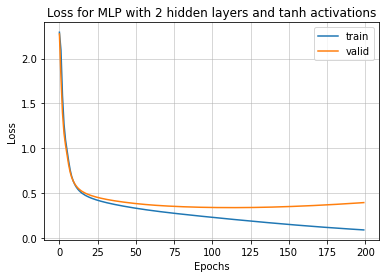

In [ ]:
plt.clf()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss for MLP with 2 hidden layers and tanh activations")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

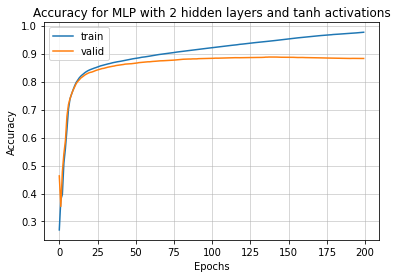

In [ ]:
plt.clf()
plt.plot(train_acc_list, label='train')
plt.plot(val_acc_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy for MLP with 2 hidden layers and tanh activations")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
y_test_probs = mlp_two_hidden_tanh.predict(x_test, is_test=True)

test_loss = EvaluationUtils.calculate_ce_loss(y_test_probs, y_test)
test_acc = EvaluationUtils.calculate_multi_accuracy(y_test_probs, y_test)

print("Test loss: {}".format(test_loss))
print("Test accuracy: {}".format(test_acc))

Test loss: 0.3577656365153893
Test accuracy: 0.8728


### MLP with two hidden layers (128 uinits) and Leaky-ReLU activations

In [ ]:
mlp_two_hidden_leakyrelu = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    LeakyReLULayer(),
    LinearLayer(HIDDEN_SIZE, FASHION_MNIST_N_CLASSES),
    SoftmaxOutputLayer()
)

opt_two_hidden_leakyrelu = GradientDescentOptimizer(mlp_two_hidden_leakyrelu, MLP_LR)
train_loss_list, val_loss_list, train_acc_list, val_acc_list = mlp_two_hidden_leakyrelu.fit(opt_two_hidden_leakyrelu, x_train, y_train, x_val, y_val,
                                                                                  batch_size=MLP_BATCH_SIZE, epochs=MLP_EPOCHS)

  0%|          | 1/200 [00:02<07:25,  2.24s/it]

Epoch: 1, train loss: 2.3013326999214563, train acc: 0.1476190476190475, val loss: 2.2998464258136373, val acc: 0.19094444444444444


  1%|          | 2/200 [00:04<06:54,  2.09s/it]

Epoch: 2, train loss: 2.2967462999084116, train acc: 0.2421666666666666, val loss: 2.2921467508900863, val acc: 0.2871666666666667


  2%|▏         | 3/200 [00:06<06:42,  2.04s/it]

Epoch: 3, train loss: 2.2742348734601063, train acc: 0.37450000000000006, val loss: 2.2314699479744475, val acc: 0.34205555555555556


  2%|▏         | 4/200 [00:08<06:36,  2.02s/it]

Epoch: 4, train loss: 2.03749851935023, train acc: 0.3730000000000004, val loss: 1.8377555042051292, val acc: 0.382


  2%|▎         | 5/200 [00:10<06:31,  2.01s/it]

Epoch: 5, train loss: 1.569434103351023, train acc: 0.3962857142857143, val loss: 1.3221566400122955, val acc: 0.45555555555555555


  3%|▎         | 6/200 [00:12<06:24,  1.98s/it]

Epoch: 6, train loss: 1.1949343729167163, train acc: 0.4919999999999998, val loss: 1.0980053977635595, val acc: 0.5154444444444445


  4%|▎         | 7/200 [00:14<06:21,  1.97s/it]

Epoch: 7, train loss: 1.0266779589561619, train acc: 0.55002380952381, val loss: 0.9622112904783336, val acc: 0.5953888888888889


  4%|▍         | 8/200 [00:16<06:17,  1.96s/it]

Epoch: 8, train loss: 0.8991458294028257, train acc: 0.6379523809523804, val loss: 0.8506175684079772, val acc: 0.6918333333333333


  4%|▍         | 9/200 [00:18<06:16,  1.97s/it]

Epoch: 9, train loss: 0.7932675406651868, train acc: 0.7069999999999999, val loss: 0.7572357207981643, val acc: 0.7271111111111112


  5%|▌         | 10/200 [00:20<06:16,  1.98s/it]

Epoch: 10, train loss: 0.70867264471796, train acc: 0.7387619047619044, val loss: 0.6900582653064011, val acc: 0.741


  6%|▌         | 11/200 [00:21<06:11,  1.96s/it]

Epoch: 11, train loss: 0.6507085631739619, train acc: 0.7533095238095243, val loss: 0.6460114672572318, val acc: 0.7504444444444445


  6%|▌         | 12/200 [00:23<06:09,  1.96s/it]

Epoch: 12, train loss: 0.6115423524583421, train acc: 0.7632380952380955, val loss: 0.6158929123167537, val acc: 0.7593888888888889


  6%|▋         | 13/200 [00:25<06:07,  1.97s/it]

Epoch: 13, train loss: 0.5830644268055805, train acc: 0.7717619047619054, val loss: 0.5933171833427756, val acc: 0.7672222222222222


  7%|▋         | 14/200 [00:27<06:05,  1.97s/it]

Epoch: 14, train loss: 0.5607417309914415, train acc: 0.7801428571428576, val loss: 0.5753068193126356, val acc: 0.7750555555555556


  8%|▊         | 15/200 [00:29<06:02,  1.96s/it]

Epoch: 15, train loss: 0.5425120092769479, train acc: 0.7871904761904762, val loss: 0.5603142913437036, val acc: 0.7796666666666666


  8%|▊         | 16/200 [00:31<05:59,  1.95s/it]

Epoch: 16, train loss: 0.5270656209919539, train acc: 0.7935476190476195, val loss: 0.5472648538611994, val acc: 0.7871111111111111


  8%|▊         | 17/200 [00:33<05:57,  1.95s/it]

Epoch: 17, train loss: 0.5134572357966692, train acc: 0.8020476190476193, val loss: 0.535462758391654, val acc: 0.7956111111111112


  9%|▉         | 18/200 [00:35<05:57,  1.97s/it]

Epoch: 18, train loss: 0.5010608489068932, train acc: 0.8097857142857142, val loss: 0.5244949196532378, val acc: 0.8030555555555555


 10%|▉         | 19/200 [00:37<05:57,  1.97s/it]

Epoch: 19, train loss: 0.4895316139750672, train acc: 0.8176190476190481, val loss: 0.5141928012194079, val acc: 0.8105


 10%|█         | 20/200 [00:39<05:55,  1.98s/it]

Epoch: 20, train loss: 0.4787514257703896, train acc: 0.8251428571428581, val loss: 0.504525148281104, val acc: 0.8173333333333334


 10%|█         | 21/200 [00:41<05:54,  1.98s/it]

Epoch: 21, train loss: 0.4687136437680612, train acc: 0.8296190476190485, val loss: 0.4954871736752179, val acc: 0.8214444444444444


 11%|█         | 22/200 [00:43<05:51,  1.98s/it]

Epoch: 22, train loss: 0.4594339344323488, train acc: 0.833452380952382, val loss: 0.4871527812911107, val acc: 0.8251666666666667


 12%|█▏        | 23/200 [00:45<05:47,  1.96s/it]

Epoch: 23, train loss: 0.4509002320786673, train acc: 0.8372619047619055, val loss: 0.47944861672257166, val acc: 0.8288888888888889


 12%|█▏        | 24/200 [00:47<05:45,  1.96s/it]

Epoch: 24, train loss: 0.44304359614222316, train acc: 0.8400000000000007, val loss: 0.4723011198386339, val acc: 0.8311111111111111


 12%|█▎        | 25/200 [00:49<05:42,  1.95s/it]

Epoch: 25, train loss: 0.43575320863549166, train acc: 0.8431428571428573, val loss: 0.4656581570032694, val acc: 0.8333333333333334


 13%|█▎        | 26/200 [00:51<05:40,  1.96s/it]

Epoch: 26, train loss: 0.4289368838030379, train acc: 0.8458571428571435, val loss: 0.45946199901562707, val acc: 0.8356111111111111


 14%|█▎        | 27/200 [00:53<05:39,  1.96s/it]

Epoch: 27, train loss: 0.42250342222441123, train acc: 0.8480952380952383, val loss: 0.4536376536054786, val acc: 0.8367777777777777


 14%|█▍        | 28/200 [00:55<05:36,  1.96s/it]

Epoch: 28, train loss: 0.41640827782498957, train acc: 0.8502619047619048, val loss: 0.4481950617306124, val acc: 0.8400555555555556


 14%|█▍        | 29/200 [00:57<05:34,  1.96s/it]

Epoch: 29, train loss: 0.41060977036498586, train acc: 0.8522619047619053, val loss: 0.4430319305546207, val acc: 0.842


 15%|█▌        | 30/200 [00:59<05:31,  1.95s/it]

Epoch: 30, train loss: 0.4050766974130956, train acc: 0.8542857142857148, val loss: 0.4381536752681786, val acc: 0.8438888888888889


 16%|█▌        | 31/200 [01:01<05:30,  1.95s/it]

Epoch: 31, train loss: 0.3998046048538082, train acc: 0.8563809523809528, val loss: 0.4335883508050468, val acc: 0.8450555555555556


 16%|█▌        | 32/200 [01:03<05:27,  1.95s/it]

Epoch: 32, train loss: 0.3947899545006323, train acc: 0.857809523809524, val loss: 0.4292832764656511, val acc: 0.8471111111111111


 16%|█▋        | 33/200 [01:05<05:26,  1.96s/it]

Epoch: 33, train loss: 0.39002914037013664, train acc: 0.8593571428571432, val loss: 0.4252285392835017, val acc: 0.8483888888888889


 17%|█▋        | 34/200 [01:07<05:24,  1.95s/it]

Epoch: 34, train loss: 0.385506258227712, train acc: 0.8609285714285713, val loss: 0.4213977160617631, val acc: 0.8493888888888889


 18%|█▊        | 35/200 [01:08<05:22,  1.95s/it]

Epoch: 35, train loss: 0.3812063205141797, train acc: 0.8627619047619045, val loss: 0.41776747880693815, val acc: 0.851


 18%|█▊        | 36/200 [01:10<05:19,  1.95s/it]

Epoch: 36, train loss: 0.3771173977142034, train acc: 0.8643809523809525, val loss: 0.41433877238316785, val acc: 0.853


 18%|█▊        | 37/200 [01:12<05:16,  1.94s/it]

Epoch: 37, train loss: 0.373207615465531, train acc: 0.865904761904762, val loss: 0.41110234103969645, val acc: 0.8545555555555555


 19%|█▉        | 38/200 [01:14<05:15,  1.95s/it]

Epoch: 38, train loss: 0.3694473428682777, train acc: 0.8669285714285713, val loss: 0.4079891052046325, val acc: 0.8557777777777777


 20%|█▉        | 39/200 [01:16<05:14,  1.96s/it]

Epoch: 39, train loss: 0.36582434553829457, train acc: 0.8680238095238094, val loss: 0.40499740893369984, val acc: 0.8565555555555555


 20%|██        | 40/200 [01:18<05:13,  1.96s/it]

Epoch: 40, train loss: 0.36233742126129415, train acc: 0.869, val loss: 0.40214656712348307, val acc: 0.8575555555555555


 20%|██        | 41/200 [01:20<05:11,  1.96s/it]

Epoch: 41, train loss: 0.3589644019800721, train acc: 0.87, val loss: 0.39942440265838375, val acc: 0.8586666666666667


 21%|██        | 42/200 [01:22<05:10,  1.96s/it]

Epoch: 42, train loss: 0.355715449663533, train acc: 0.8712142857142856, val loss: 0.396826078148724, val acc: 0.8593333333333333


 22%|██▏       | 43/200 [01:24<05:08,  1.97s/it]

Epoch: 43, train loss: 0.3525934439951498, train acc: 0.8723095238095241, val loss: 0.39436168648535264, val acc: 0.8605


 22%|██▏       | 44/200 [01:27<05:46,  2.22s/it]

Epoch: 44, train loss: 0.34956877236953815, train acc: 0.8734285714285713, val loss: 0.39198871007583624, val acc: 0.8616666666666667


 22%|██▎       | 45/200 [01:29<05:54,  2.29s/it]

Epoch: 45, train loss: 0.3466185962988197, train acc: 0.874523809523809, val loss: 0.38973258551595, val acc: 0.8626111111111111


 23%|██▎       | 46/200 [01:31<05:35,  2.18s/it]

Epoch: 46, train loss: 0.3437520299711653, train acc: 0.8754047619047611, val loss: 0.3875822263468002, val acc: 0.8631111111111112


 24%|██▎       | 47/200 [01:33<05:23,  2.11s/it]

Epoch: 47, train loss: 0.34098353093082373, train acc: 0.8766190476190467, val loss: 0.38552527288388705, val acc: 0.8642777777777778


 24%|██▍       | 48/200 [01:35<05:14,  2.07s/it]

Epoch: 48, train loss: 0.33826903720742374, train acc: 0.8774285714285709, val loss: 0.3835570859083848, val acc: 0.8656666666666667


 24%|██▍       | 49/200 [01:37<05:08,  2.04s/it]

Epoch: 49, train loss: 0.33563019233725466, train acc: 0.8784285714285708, val loss: 0.38169597647075404, val acc: 0.8662777777777778


 25%|██▌       | 50/200 [01:39<05:04,  2.03s/it]

Epoch: 50, train loss: 0.333071594341952, train acc: 0.8791666666666658, val loss: 0.3798925517868579, val acc: 0.8665555555555555


 26%|██▌       | 51/200 [01:41<04:59,  2.01s/it]

Epoch: 51, train loss: 0.3305787851033541, train acc: 0.880357142857142, val loss: 0.37817301086703514, val acc: 0.8671111111111112


 26%|██▌       | 52/200 [01:43<04:55,  2.00s/it]

Epoch: 52, train loss: 0.32815051063851325, train acc: 0.8814999999999988, val loss: 0.3765477868640368, val acc: 0.8680555555555556


 26%|██▋       | 53/200 [01:45<04:52,  1.99s/it]

Epoch: 53, train loss: 0.32577990813529106, train acc: 0.8823571428571423, val loss: 0.37499056597261865, val acc: 0.8687222222222222


 27%|██▋       | 54/200 [01:47<04:47,  1.97s/it]

Epoch: 54, train loss: 0.3234694496606838, train acc: 0.8833571428571427, val loss: 0.3735154376798875, val acc: 0.8692222222222222


 28%|██▊       | 55/200 [01:49<04:44,  1.96s/it]

Epoch: 55, train loss: 0.3212082753218522, train acc: 0.8839523809523805, val loss: 0.37210241700716545, val acc: 0.87


 28%|██▊       | 56/200 [01:51<04:40,  1.95s/it]

Epoch: 56, train loss: 0.31898899547910187, train acc: 0.8845476190476188, val loss: 0.37077105823489287, val acc: 0.8703333333333333


 28%|██▊       | 57/200 [01:53<04:40,  1.96s/it]

Epoch: 57, train loss: 0.31682884906532016, train acc: 0.8852857142857139, val loss: 0.3695321685939292, val acc: 0.8703333333333333


 29%|██▉       | 58/200 [01:55<04:37,  1.96s/it]

Epoch: 58, train loss: 0.3147077834106958, train acc: 0.8861904761904753, val loss: 0.36831019298352774, val acc: 0.8708333333333333


 30%|██▉       | 59/200 [01:57<04:36,  1.96s/it]

Epoch: 59, train loss: 0.31262490763239326, train acc: 0.8866904761904755, val loss: 0.36716263105070457, val acc: 0.8713888888888889


 30%|███       | 60/200 [01:59<04:32,  1.95s/it]

Epoch: 60, train loss: 0.31057181472270984, train acc: 0.8875952380952372, val loss: 0.36604342145348445, val acc: 0.8717777777777778


 30%|███       | 61/200 [02:01<04:30,  1.95s/it]

Epoch: 61, train loss: 0.3085547168014137, train acc: 0.8883809523809518, val loss: 0.36501058028326433, val acc: 0.8722777777777778


 31%|███       | 62/200 [02:03<04:27,  1.94s/it]

Epoch: 62, train loss: 0.3065760080664535, train acc: 0.888857142857142, val loss: 0.3639918707247131, val acc: 0.8724444444444445


 32%|███▏      | 63/200 [02:05<04:24,  1.93s/it]

Epoch: 63, train loss: 0.3046150390289793, train acc: 0.8895476190476181, val loss: 0.36302383116856424, val acc: 0.8728888888888889


 32%|███▏      | 64/200 [02:06<04:22,  1.93s/it]

Epoch: 64, train loss: 0.3026841465136306, train acc: 0.8902380952380944, val loss: 0.36207602879549755, val acc: 0.8732777777777778


 32%|███▎      | 65/200 [02:08<04:22,  1.94s/it]

Epoch: 65, train loss: 0.30077940360096556, train acc: 0.8908809523809514, val loss: 0.3612112023781664, val acc: 0.8733333333333333


 33%|███▎      | 66/200 [02:10<04:20,  1.94s/it]

Epoch: 66, train loss: 0.29891393653569154, train acc: 0.8913333333333323, val loss: 0.3603499687708224, val acc: 0.8743333333333333


 34%|███▎      | 67/200 [02:12<04:17,  1.94s/it]

Epoch: 67, train loss: 0.29707877692858686, train acc: 0.8923333333333324, val loss: 0.35953649380644637, val acc: 0.875


 34%|███▍      | 68/200 [02:14<04:15,  1.94s/it]

Epoch: 68, train loss: 0.29527936028817203, train acc: 0.8931666666666656, val loss: 0.3587582642351302, val acc: 0.8753333333333333


 34%|███▍      | 69/200 [02:16<04:13,  1.94s/it]

Epoch: 69, train loss: 0.2934969599309734, train acc: 0.8935952380952373, val loss: 0.3579945892611248, val acc: 0.8756666666666667


 35%|███▌      | 70/200 [02:18<04:10,  1.93s/it]

Epoch: 70, train loss: 0.2917392271356273, train acc: 0.894166666666666, val loss: 0.3572634449844848, val acc: 0.8755


 36%|███▌      | 71/200 [02:20<04:08,  1.93s/it]

Epoch: 71, train loss: 0.29000597894299995, train acc: 0.894714285714285, val loss: 0.3565653487413436, val acc: 0.8756111111111111


 36%|███▌      | 72/200 [02:22<04:07,  1.93s/it]

Epoch: 72, train loss: 0.2882990114685781, train acc: 0.895333333333333, val loss: 0.3558537636882137, val acc: 0.8754444444444445


 36%|███▋      | 73/200 [02:24<04:05,  1.93s/it]

Epoch: 73, train loss: 0.286611665370022, train acc: 0.8958571428571426, val loss: 0.3552019785541961, val acc: 0.8754444444444445


 37%|███▋      | 74/200 [02:26<04:04,  1.94s/it]

Epoch: 74, train loss: 0.28494705579477847, train acc: 0.89647619047619, val loss: 0.3545737987732388, val acc: 0.8760555555555556


 38%|███▊      | 75/200 [02:28<04:03,  1.94s/it]

Epoch: 75, train loss: 0.28329055504075407, train acc: 0.8969523809523807, val loss: 0.3539172418086722, val acc: 0.8762222222222222


 38%|███▊      | 76/200 [02:30<04:01,  1.95s/it]

Epoch: 76, train loss: 0.2816484944340747, train acc: 0.897595238095238, val loss: 0.3533419610217089, val acc: 0.8762222222222222


 38%|███▊      | 77/200 [02:32<03:59,  1.95s/it]

Epoch: 77, train loss: 0.28001736216043216, train acc: 0.8981666666666667, val loss: 0.3527784970709848, val acc: 0.8771666666666667


 39%|███▉      | 78/200 [02:34<03:57,  1.95s/it]

Epoch: 78, train loss: 0.27840647909006266, train acc: 0.8986190476190477, val loss: 0.3522583003531909, val acc: 0.8778333333333334


 40%|███▉      | 79/200 [02:36<03:57,  1.96s/it]

Epoch: 79, train loss: 0.2768119807780812, train acc: 0.8990238095238098, val loss: 0.3517252274009223, val acc: 0.8782777777777778


 40%|████      | 80/200 [02:38<03:55,  1.96s/it]

Epoch: 80, train loss: 0.27523775776851267, train acc: 0.8995000000000001, val loss: 0.3512653165766158, val acc: 0.8783888888888889


 40%|████      | 81/200 [02:40<03:54,  1.97s/it]

Epoch: 81, train loss: 0.273681492526289, train acc: 0.899857142857143, val loss: 0.350838097639711, val acc: 0.8784444444444445


 41%|████      | 82/200 [02:42<03:52,  1.97s/it]

Epoch: 82, train loss: 0.27214215907783434, train acc: 0.9005476190476195, val loss: 0.3503929586545526, val acc: 0.8787222222222222


 42%|████▏     | 83/200 [02:44<03:50,  1.97s/it]

Epoch: 83, train loss: 0.2706175622506555, train acc: 0.9011904761904769, val loss: 0.34996649361132415, val acc: 0.8789444444444444


 42%|████▏     | 84/200 [02:45<03:48,  1.97s/it]

Epoch: 84, train loss: 0.2691084852029275, train acc: 0.9019047619047623, val loss: 0.34954723648202873, val acc: 0.8788333333333334


 42%|████▎     | 85/200 [02:47<03:46,  1.97s/it]

Epoch: 85, train loss: 0.2676146189676492, train acc: 0.9024285714285715, val loss: 0.3491834518446737, val acc: 0.8791666666666667


 43%|████▎     | 86/200 [02:49<03:44,  1.97s/it]

Epoch: 86, train loss: 0.26612139766509535, train acc: 0.902904761904762, val loss: 0.34882250448236685, val acc: 0.8797222222222222


 44%|████▎     | 87/200 [02:51<03:43,  1.98s/it]

Epoch: 87, train loss: 0.26463986814488094, train acc: 0.9037619047619049, val loss: 0.3484903928572491, val acc: 0.8799444444444444


 44%|████▍     | 88/200 [02:53<03:40,  1.97s/it]

Epoch: 88, train loss: 0.26317216327895865, train acc: 0.904404761904762, val loss: 0.3481735650290427, val acc: 0.8802222222222222


 44%|████▍     | 89/200 [02:55<03:38,  1.97s/it]

Epoch: 89, train loss: 0.26171910587263975, train acc: 0.9046190476190478, val loss: 0.3478679162594373, val acc: 0.8799444444444444


 45%|████▌     | 90/200 [02:57<03:35,  1.96s/it]

Epoch: 90, train loss: 0.2602643234701665, train acc: 0.9052857142857148, val loss: 0.3476157885180252, val acc: 0.8799444444444444


 46%|████▌     | 91/200 [02:59<03:33,  1.96s/it]

Epoch: 91, train loss: 0.25883445999929844, train acc: 0.9059047619047623, val loss: 0.3473067126189616, val acc: 0.8803333333333333


 46%|████▌     | 92/200 [03:01<03:30,  1.95s/it]

Epoch: 92, train loss: 0.2574052753590262, train acc: 0.9065952380952387, val loss: 0.3470429617568438, val acc: 0.8804444444444445


 46%|████▋     | 93/200 [03:03<03:28,  1.95s/it]

Epoch: 93, train loss: 0.2559798761038506, train acc: 0.9070714285714292, val loss: 0.3468433203612811, val acc: 0.8803333333333333


 47%|████▋     | 94/200 [03:05<03:26,  1.95s/it]

Epoch: 94, train loss: 0.2545684882288593, train acc: 0.9076428571428581, val loss: 0.3466823209023891, val acc: 0.8806111111111111


 48%|████▊     | 95/200 [03:07<03:24,  1.95s/it]

Epoch: 95, train loss: 0.253161577623628, train acc: 0.908142857142858, val loss: 0.346457188390551, val acc: 0.8808888888888889


 48%|████▊     | 96/200 [03:09<03:24,  1.96s/it]

Epoch: 96, train loss: 0.2517705220946873, train acc: 0.908785714285715, val loss: 0.34631336827137627, val acc: 0.8809444444444444


 48%|████▊     | 97/200 [03:11<03:21,  1.95s/it]

Epoch: 97, train loss: 0.25037333247668314, train acc: 0.90952380952381, val loss: 0.3461257614936191, val acc: 0.8810555555555556


 49%|████▉     | 98/200 [03:13<03:18,  1.94s/it]

Epoch: 98, train loss: 0.24900142373106482, train acc: 0.9098809523809529, val loss: 0.3460021231166887, val acc: 0.8811111111111111


 50%|████▉     | 99/200 [03:15<03:15,  1.94s/it]

Epoch: 99, train loss: 0.24764360364671006, train acc: 0.9103095238095241, val loss: 0.34587106978750876, val acc: 0.8808888888888889


 50%|█████     | 100/200 [03:17<03:13,  1.94s/it]

Epoch: 100, train loss: 0.24626428324474317, train acc: 0.9107142857142858, val loss: 0.3457744864280707, val acc: 0.8808888888888889


 50%|█████     | 101/200 [03:19<03:12,  1.94s/it]

Epoch: 101, train loss: 0.24490631654838443, train acc: 0.9114285714285716, val loss: 0.3456960970545428, val acc: 0.8806666666666667


 51%|█████     | 102/200 [03:21<03:10,  1.94s/it]

Epoch: 102, train loss: 0.24356047619942484, train acc: 0.9120714285714285, val loss: 0.34564081935261176, val acc: 0.8808888888888889


 52%|█████▏    | 103/200 [03:23<03:07,  1.94s/it]

Epoch: 103, train loss: 0.24221652731323054, train acc: 0.9126666666666666, val loss: 0.34555481148643946, val acc: 0.8811111111111111


 52%|█████▏    | 104/200 [03:24<03:05,  1.93s/it]

Epoch: 104, train loss: 0.24087465741071293, train acc: 0.9133809523809524, val loss: 0.34545901603051415, val acc: 0.8806111111111111


 52%|█████▎    | 105/200 [03:26<03:03,  1.93s/it]

Epoch: 105, train loss: 0.23954185597210156, train acc: 0.9136904761904762, val loss: 0.34544850113893966, val acc: 0.8807222222222222


 53%|█████▎    | 106/200 [03:28<03:01,  1.93s/it]

Epoch: 106, train loss: 0.2382176157134197, train acc: 0.9143333333333336, val loss: 0.3454428918934888, val acc: 0.8803888888888889


 54%|█████▎    | 107/200 [03:30<02:59,  1.93s/it]

Epoch: 107, train loss: 0.2368926821505505, train acc: 0.9150000000000001, val loss: 0.34544068876989303, val acc: 0.8803333333333333


 54%|█████▍    | 108/200 [03:32<02:56,  1.92s/it]

Epoch: 108, train loss: 0.23559480931256466, train acc: 0.9155714285714287, val loss: 0.3454251104779387, val acc: 0.8806111111111111


 55%|█████▍    | 109/200 [03:34<02:56,  1.94s/it]

Epoch: 109, train loss: 0.23428252851181464, train acc: 0.9161190476190474, val loss: 0.34546782964354245, val acc: 0.8806666666666667


 55%|█████▌    | 110/200 [03:36<02:53,  1.93s/it]

Epoch: 110, train loss: 0.23298519668730827, train acc: 0.916690476190476, val loss: 0.34551776948394153, val acc: 0.8807222222222222


 56%|█████▌    | 111/200 [03:38<02:51,  1.93s/it]

Epoch: 111, train loss: 0.2316954589004725, train acc: 0.9170714285714284, val loss: 0.34561770000047676, val acc: 0.8812777777777778


 56%|█████▌    | 112/200 [03:40<02:51,  1.95s/it]

Epoch: 112, train loss: 0.23039854460291093, train acc: 0.9174523809523802, val loss: 0.34570302253486107, val acc: 0.8816666666666667


 56%|█████▋    | 113/200 [03:42<02:49,  1.94s/it]

Epoch: 113, train loss: 0.2291083457048041, train acc: 0.9178571428571423, val loss: 0.3457480297384196, val acc: 0.8821666666666667


 57%|█████▋    | 114/200 [03:44<02:47,  1.95s/it]

Epoch: 114, train loss: 0.22781302335613263, train acc: 0.9182857142857135, val loss: 0.34583802433238353, val acc: 0.8821666666666667


 57%|█████▊    | 115/200 [03:46<02:45,  1.94s/it]

Epoch: 115, train loss: 0.22653074313436175, train acc: 0.9186904761904751, val loss: 0.3459867513125224, val acc: 0.882


 58%|█████▊    | 116/200 [03:48<02:42,  1.93s/it]

Epoch: 116, train loss: 0.22525614594707258, train acc: 0.9191190476190467, val loss: 0.34604501117835024, val acc: 0.8816666666666667


 58%|█████▊    | 117/200 [03:50<02:40,  1.93s/it]

Epoch: 117, train loss: 0.22396413832576204, train acc: 0.9197142857142847, val loss: 0.3462482107680371, val acc: 0.8816111111111111


 59%|█████▉    | 118/200 [03:52<02:37,  1.92s/it]

Epoch: 118, train loss: 0.22270920163083185, train acc: 0.920261904761904, val loss: 0.3463883242387354, val acc: 0.8814444444444445


 60%|█████▉    | 119/200 [03:53<02:35,  1.92s/it]

Epoch: 119, train loss: 0.2214426152892354, train acc: 0.9207857142857134, val loss: 0.34653961394424593, val acc: 0.8812777777777778


 60%|██████    | 120/200 [03:56<02:37,  1.97s/it]

Epoch: 120, train loss: 0.22019197432032953, train acc: 0.9213571428571415, val loss: 0.3467296798483227, val acc: 0.8814444444444445


 60%|██████    | 121/200 [03:57<02:34,  1.96s/it]

Epoch: 121, train loss: 0.21893137297664517, train acc: 0.9217857142857131, val loss: 0.3469900838548865, val acc: 0.8817777777777778


 61%|██████    | 122/200 [03:59<02:31,  1.94s/it]

Epoch: 122, train loss: 0.2176886445251546, train acc: 0.9223333333333323, val loss: 0.3471880780299475, val acc: 0.8818888888888889


 62%|██████▏   | 123/200 [04:01<02:29,  1.94s/it]

Epoch: 123, train loss: 0.21644142827553875, train acc: 0.9229999999999989, val loss: 0.34738156395092, val acc: 0.8821111111111111


 62%|██████▏   | 124/200 [04:03<02:27,  1.94s/it]

Epoch: 124, train loss: 0.21518990748670858, train acc: 0.9233809523809513, val loss: 0.3476872290553627, val acc: 0.8821111111111111


 62%|██████▎   | 125/200 [04:05<02:25,  1.93s/it]

Epoch: 125, train loss: 0.21395102933575894, train acc: 0.9237857142857132, val loss: 0.3478331139723285, val acc: 0.8825555555555555


 63%|██████▎   | 126/200 [04:07<02:23,  1.94s/it]

Epoch: 126, train loss: 0.21273024005513003, train acc: 0.9243333333333325, val loss: 0.3481290291135925, val acc: 0.8826111111111111


 64%|██████▎   | 127/200 [04:09<02:22,  1.95s/it]

Epoch: 127, train loss: 0.21149747632313184, train acc: 0.9249523809523799, val loss: 0.3484184936184936, val acc: 0.883


 64%|██████▍   | 128/200 [04:11<02:19,  1.94s/it]

Epoch: 128, train loss: 0.21027009077872924, train acc: 0.9254285714285705, val loss: 0.34863655958756323, val acc: 0.8828888888888888


 64%|██████▍   | 129/200 [04:13<02:17,  1.93s/it]

Epoch: 129, train loss: 0.20904610754645217, train acc: 0.9259047619047611, val loss: 0.34892269824469785, val acc: 0.8828888888888888


 65%|██████▌   | 130/200 [04:15<02:14,  1.92s/it]

Epoch: 130, train loss: 0.207828767003078, train acc: 0.9263095238095229, val loss: 0.34915243139634966, val acc: 0.8825555555555555


 66%|██████▌   | 131/200 [04:17<02:12,  1.92s/it]

Epoch: 131, train loss: 0.20660013690295076, train acc: 0.9269285714285707, val loss: 0.3493364452898512, val acc: 0.8825555555555555


 66%|██████▌   | 132/200 [04:19<02:10,  1.92s/it]

Epoch: 132, train loss: 0.20538669599876594, train acc: 0.9272857142857134, val loss: 0.34963048730504315, val acc: 0.8826111111111111


 66%|██████▋   | 133/200 [04:21<02:09,  1.93s/it]

Epoch: 133, train loss: 0.20416568943448357, train acc: 0.9277142857142848, val loss: 0.34997008925425716, val acc: 0.8825555555555555


 67%|██████▋   | 134/200 [04:22<02:07,  1.93s/it]

Epoch: 134, train loss: 0.20296322689036753, train acc: 0.9282619047619041, val loss: 0.35029484453560356, val acc: 0.8823333333333333


 68%|██████▊   | 135/200 [04:24<02:05,  1.93s/it]

Epoch: 135, train loss: 0.20176313196642576, train acc: 0.9289999999999994, val loss: 0.3507205451010226, val acc: 0.8823888888888889


 68%|██████▊   | 136/200 [04:26<02:03,  1.93s/it]

Epoch: 136, train loss: 0.20054613469053972, train acc: 0.9294523809523801, val loss: 0.35113879380579577, val acc: 0.8825


 68%|██████▊   | 137/200 [04:28<02:01,  1.92s/it]

Epoch: 137, train loss: 0.19935585842699585, train acc: 0.9299285714285708, val loss: 0.3514504773460632, val acc: 0.8822777777777778


 69%|██████▉   | 138/200 [04:30<01:58,  1.92s/it]

Epoch: 138, train loss: 0.19816040295347268, train acc: 0.9304999999999994, val loss: 0.35184183032952676, val acc: 0.8825


 70%|██████▉   | 139/200 [04:32<01:57,  1.92s/it]

Epoch: 139, train loss: 0.19695427209255909, train acc: 0.931023809523809, val loss: 0.3519552012010389, val acc: 0.8825


 70%|███████   | 140/200 [04:34<01:56,  1.94s/it]

Epoch: 140, train loss: 0.1957608727522257, train acc: 0.9314999999999996, val loss: 0.35239703715092974, val acc: 0.8824444444444445


 70%|███████   | 141/200 [04:36<01:54,  1.94s/it]

Epoch: 141, train loss: 0.19455281482137016, train acc: 0.9321428571428566, val loss: 0.35288080915437264, val acc: 0.8828333333333334


 71%|███████   | 142/200 [04:38<01:52,  1.94s/it]

Epoch: 142, train loss: 0.1933776922915528, train acc: 0.9328809523809523, val loss: 0.35331562760550234, val acc: 0.883


 72%|███████▏  | 143/200 [04:40<01:51,  1.95s/it]

Epoch: 143, train loss: 0.1921909944675437, train acc: 0.9335238095238098, val loss: 0.3537955189068595, val acc: 0.8831111111111111


 72%|███████▏  | 144/200 [04:42<01:48,  1.94s/it]

Epoch: 144, train loss: 0.19101885631942267, train acc: 0.9337857142857146, val loss: 0.3541291125149897, val acc: 0.8826666666666667


 72%|███████▎  | 145/200 [04:44<01:47,  1.95s/it]

Epoch: 145, train loss: 0.18983273155580355, train acc: 0.9342857142857146, val loss: 0.3545541638064976, val acc: 0.8826666666666667


 73%|███████▎  | 146/200 [04:46<01:45,  1.95s/it]

Epoch: 146, train loss: 0.18865898577760964, train acc: 0.9349047619047623, val loss: 0.3549468138855613, val acc: 0.8829444444444444


 74%|███████▎  | 147/200 [04:48<01:42,  1.94s/it]

Epoch: 147, train loss: 0.18748631752101858, train acc: 0.9355714285714289, val loss: 0.35550561165473, val acc: 0.8831111111111111


 74%|███████▍  | 148/200 [04:50<01:40,  1.93s/it]

Epoch: 148, train loss: 0.1863176817084749, train acc: 0.9358095238095241, val loss: 0.355979123937401, val acc: 0.8829444444444444


 74%|███████▍  | 149/200 [04:52<01:38,  1.93s/it]

Epoch: 149, train loss: 0.18514620106136304, train acc: 0.9360952380952389, val loss: 0.3565003712222119, val acc: 0.883


 75%|███████▌  | 150/200 [04:53<01:36,  1.92s/it]

Epoch: 150, train loss: 0.18397953780221643, train acc: 0.9366904761904767, val loss: 0.3570646955159609, val acc: 0.8826111111111111


 76%|███████▌  | 151/200 [04:55<01:34,  1.92s/it]

Epoch: 151, train loss: 0.18281907426203733, train acc: 0.9374761904761915, val loss: 0.3576118822811682, val acc: 0.8827222222222222


 76%|███████▌  | 152/200 [04:57<01:32,  1.93s/it]

Epoch: 152, train loss: 0.18167758422155456, train acc: 0.9377380952380963, val loss: 0.3580669501845564, val acc: 0.8825


 76%|███████▋  | 153/200 [04:59<01:30,  1.92s/it]

Epoch: 153, train loss: 0.18053290303527478, train acc: 0.9381428571428579, val loss: 0.35859338993270806, val acc: 0.8827222222222222


 77%|███████▋  | 154/200 [05:01<01:28,  1.92s/it]

Epoch: 154, train loss: 0.17937349571134448, train acc: 0.9385714285714294, val loss: 0.35909909345477403, val acc: 0.8829444444444444


 78%|███████▊  | 155/200 [05:03<01:26,  1.92s/it]

Epoch: 155, train loss: 0.17822492521111294, train acc: 0.9392380952380961, val loss: 0.3596117414172393, val acc: 0.8827222222222222


 78%|███████▊  | 156/200 [05:05<01:24,  1.92s/it]

Epoch: 156, train loss: 0.17708229791642896, train acc: 0.9396666666666676, val loss: 0.3602790571424878, val acc: 0.8827777777777778


 78%|███████▊  | 157/200 [05:07<01:22,  1.92s/it]

Epoch: 157, train loss: 0.1759294699082344, train acc: 0.9401666666666676, val loss: 0.36081393745916274, val acc: 0.8830555555555556


 79%|███████▉  | 158/200 [05:09<01:21,  1.95s/it]

Epoch: 158, train loss: 0.17479783833111298, train acc: 0.9404761904761916, val loss: 0.36135616238090584, val acc: 0.883


 80%|███████▉  | 159/200 [05:11<01:20,  1.96s/it]

Epoch: 159, train loss: 0.17366348189325237, train acc: 0.9408333333333344, val loss: 0.36212550771464785, val acc: 0.883


 80%|████████  | 160/200 [05:13<01:17,  1.95s/it]

Epoch: 160, train loss: 0.17252953236780996, train acc: 0.9414761904761915, val loss: 0.36270736595883624, val acc: 0.8832222222222222


 80%|████████  | 161/200 [05:15<01:15,  1.94s/it]

Epoch: 161, train loss: 0.17139133354564312, train acc: 0.9418571428571441, val loss: 0.3635463823310388, val acc: 0.8832222222222222


 81%|████████  | 162/200 [05:17<01:13,  1.93s/it]

Epoch: 162, train loss: 0.1702925695648592, train acc: 0.942404761904763, val loss: 0.3639801344167744, val acc: 0.8836111111111111


 82%|████████▏ | 163/200 [05:19<01:11,  1.93s/it]

Epoch: 163, train loss: 0.16915239418307915, train acc: 0.9426666666666677, val loss: 0.3646322466613737, val acc: 0.8837777777777778


 82%|████████▏ | 164/200 [05:21<01:09,  1.94s/it]

Epoch: 164, train loss: 0.16804724693070705, train acc: 0.9431666666666674, val loss: 0.36534859107894324, val acc: 0.8831111111111111


 82%|████████▎ | 165/200 [05:22<01:07,  1.94s/it]

Epoch: 165, train loss: 0.1669213602966228, train acc: 0.9437619047619058, val loss: 0.3661596148551188, val acc: 0.8836111111111111


 83%|████████▎ | 166/200 [05:24<01:05,  1.94s/it]

Epoch: 166, train loss: 0.16581492759587788, train acc: 0.9441666666666674, val loss: 0.3668069040682818, val acc: 0.8836111111111111


 84%|████████▎ | 167/200 [05:26<01:04,  1.94s/it]

Epoch: 167, train loss: 0.16470281571244522, train acc: 0.9446428571428581, val loss: 0.3674513588679839, val acc: 0.8836666666666667


 84%|████████▍ | 168/200 [05:28<01:02,  1.94s/it]

Epoch: 168, train loss: 0.16359134186525576, train acc: 0.9450476190476198, val loss: 0.36826895585900304, val acc: 0.8832777777777778


 84%|████████▍ | 169/200 [05:30<01:00,  1.94s/it]

Epoch: 169, train loss: 0.16252547631099615, train acc: 0.9456428571428577, val loss: 0.36902847479377243, val acc: 0.8831666666666667


 85%|████████▌ | 170/200 [05:32<00:58,  1.94s/it]

Epoch: 170, train loss: 0.16143088812771209, train acc: 0.945976190476191, val loss: 0.3696142747624823, val acc: 0.8831111111111111


 86%|████████▌ | 171/200 [05:34<00:56,  1.95s/it]

Epoch: 171, train loss: 0.1603401514695079, train acc: 0.9463333333333338, val loss: 0.3703614280874849, val acc: 0.8832222222222222


 86%|████████▌ | 172/200 [05:36<00:54,  1.95s/it]

Epoch: 172, train loss: 0.1592435661528854, train acc: 0.9466428571428578, val loss: 0.37110769636603125, val acc: 0.8827222222222222


 86%|████████▋ | 173/200 [05:38<00:52,  1.95s/it]

Epoch: 173, train loss: 0.15817945843373699, train acc: 0.946976190476191, val loss: 0.3717894838878739, val acc: 0.8827222222222222


 87%|████████▋ | 174/200 [05:40<00:50,  1.96s/it]

Epoch: 174, train loss: 0.1570830338873527, train acc: 0.9475000000000003, val loss: 0.37259540273921044, val acc: 0.8826666666666667


 88%|████████▊ | 175/200 [05:42<00:49,  1.97s/it]

Epoch: 175, train loss: 0.1560081848339732, train acc: 0.9477857142857146, val loss: 0.3733109701122591, val acc: 0.8826111111111111


 88%|████████▊ | 176/200 [05:44<00:47,  1.96s/it]

Epoch: 176, train loss: 0.1549385661689923, train acc: 0.948261904761905, val loss: 0.37431423422029914, val acc: 0.8828888888888888


 88%|████████▊ | 177/200 [05:46<00:44,  1.95s/it]

Epoch: 177, train loss: 0.1538880407768669, train acc: 0.9486428571428573, val loss: 0.3748920613332763, val acc: 0.8828888888888888


 89%|████████▉ | 178/200 [05:48<00:42,  1.94s/it]

Epoch: 178, train loss: 0.1528088065592108, train acc: 0.9494523809523812, val loss: 0.37593453734514787, val acc: 0.883


 90%|████████▉ | 179/200 [05:50<00:41,  1.95s/it]

Epoch: 179, train loss: 0.15177455013552651, train acc: 0.9496904761904762, val loss: 0.3767947708210296, val acc: 0.8831111111111111


 90%|█████████ | 180/200 [05:52<00:39,  1.96s/it]

Epoch: 180, train loss: 0.15071928318331856, train acc: 0.9504285714285711, val loss: 0.37753227858180316, val acc: 0.8828888888888888


 90%|█████████ | 181/200 [05:54<00:36,  1.95s/it]

Epoch: 181, train loss: 0.14966877691711697, train acc: 0.9506666666666665, val loss: 0.3783376098966852, val acc: 0.8828333333333334


 91%|█████████ | 182/200 [05:56<00:34,  1.94s/it]

Epoch: 182, train loss: 0.14862579903683545, train acc: 0.951142857142857, val loss: 0.37931552508935273, val acc: 0.8831111111111111


 92%|█████████▏| 183/200 [05:58<00:32,  1.93s/it]

Epoch: 183, train loss: 0.1475898027122477, train acc: 0.9516904761904763, val loss: 0.3802321759903651, val acc: 0.8825555555555555


 92%|█████████▏| 184/200 [05:59<00:30,  1.93s/it]

Epoch: 184, train loss: 0.14655881213363192, train acc: 0.9520952380952381, val loss: 0.38136963752583397, val acc: 0.8828888888888888


 92%|█████████▎| 185/200 [06:01<00:28,  1.93s/it]

Epoch: 185, train loss: 0.14553757452983304, train acc: 0.9525952380952383, val loss: 0.382248053233032, val acc: 0.8825


 93%|█████████▎| 186/200 [06:03<00:27,  1.93s/it]

Epoch: 186, train loss: 0.14449981059489586, train acc: 0.9527857142857145, val loss: 0.3830570505265952, val acc: 0.8824444444444445


 94%|█████████▎| 187/200 [06:05<00:25,  1.94s/it]

Epoch: 187, train loss: 0.14349376589962226, train acc: 0.9532619047619054, val loss: 0.38393186315316774, val acc: 0.8821111111111111


 94%|█████████▍| 188/200 [06:07<00:23,  1.92s/it]

Epoch: 188, train loss: 0.1424555836227836, train acc: 0.9538571428571433, val loss: 0.384749537722811, val acc: 0.8821666666666667


 94%|█████████▍| 189/200 [06:09<00:21,  1.92s/it]

Epoch: 189, train loss: 0.14142630279740365, train acc: 0.9541428571428573, val loss: 0.3859381376410418, val acc: 0.8817777777777778


 95%|█████████▌| 190/200 [06:11<00:19,  1.94s/it]

Epoch: 190, train loss: 0.14040550620883704, train acc: 0.9545714285714287, val loss: 0.3867367613922237, val acc: 0.8818333333333334


 96%|█████████▌| 191/200 [06:13<00:17,  1.94s/it]

Epoch: 191, train loss: 0.1393970973612759, train acc: 0.955071428571429, val loss: 0.3876154190337128, val acc: 0.8818333333333334


 96%|█████████▌| 192/200 [06:15<00:15,  1.95s/it]

Epoch: 192, train loss: 0.13837689894656371, train acc: 0.955380952380953, val loss: 0.38863062775463797, val acc: 0.882


 96%|█████████▋| 193/200 [06:17<00:13,  1.94s/it]

Epoch: 193, train loss: 0.13738920476018762, train acc: 0.9558095238095242, val loss: 0.38961013844267556, val acc: 0.8822222222222222


 97%|█████████▋| 194/200 [06:19<00:11,  1.95s/it]

Epoch: 194, train loss: 0.1363697711542288, train acc: 0.9561428571428576, val loss: 0.3907377248202432, val acc: 0.8821111111111111


 98%|█████████▊| 195/200 [06:21<00:09,  1.94s/it]

Epoch: 195, train loss: 0.135381796688669, train acc: 0.9567380952380956, val loss: 0.39171073459671435, val acc: 0.8822222222222222


 98%|█████████▊| 196/200 [06:23<00:07,  1.93s/it]

Epoch: 196, train loss: 0.13437475265802346, train acc: 0.9570476190476196, val loss: 0.3925542008668677, val acc: 0.8822777777777778


 98%|█████████▊| 197/200 [06:25<00:05,  1.92s/it]

Epoch: 197, train loss: 0.1333835557209519, train acc: 0.9574761904761913, val loss: 0.39365412105969266, val acc: 0.8821111111111111


 99%|█████████▉| 198/200 [06:26<00:03,  1.92s/it]

Epoch: 198, train loss: 0.1323867181184416, train acc: 0.9577619047619056, val loss: 0.3946191737085453, val acc: 0.8818888888888889


100%|█████████▉| 199/200 [06:28<00:01,  1.91s/it]

Epoch: 199, train loss: 0.13140850048349692, train acc: 0.9581904761904764, val loss: 0.39597706595839705, val acc: 0.8815555555555555


100%|██████████| 200/200 [06:30<00:00,  1.95s/it]

Epoch: 200, train loss: 0.13041877519459505, train acc: 0.9585952380952385, val loss: 0.3966613521021167, val acc: 0.8815555555555555


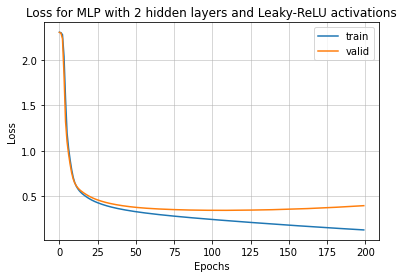

In [ ]:
plt.clf()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss for MLP with 2 hidden layers and Leaky-ReLU activations")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

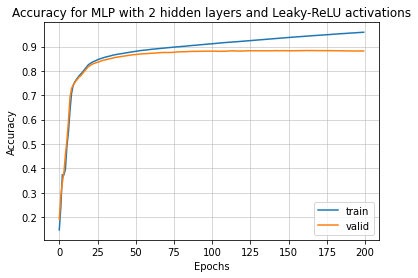

In [ ]:
plt.clf()
plt.plot(train_acc_list, label='train')
plt.plot(val_acc_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy for MLP with 2 hidden layers and Leaky-ReLU activations")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
y_test_probs = mlp_two_hidden_leakyrelu.predict(x_test, is_test=True)

test_loss = EvaluationUtils.calculate_ce_loss(y_test_probs, y_test)
test_acc = EvaluationUtils.calculate_multi_accuracy(y_test_probs, y_test)

print("Test loss: {}".format(test_loss))
print("Test accuracy: {}".format(test_acc))

Test loss: 0.3671088014132807
Test accuracy: 0.8713


## Sub-task 3

### MLP with two hidden layers (128 units) and ReLU activations, with L2 regularization

#### L2 regularization with lambda 0.1

In [ ]:
mlp_two_hidden_l2_0_1 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE, l2_lambda=0.1),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE, l2_lambda=0.1),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, FASHION_MNIST_N_CLASSES, l2_lambda=0.1),
    SoftmaxOutputLayer()
)

opt_two_hidden_l2_0_1 = GradientDescentOptimizer(mlp_two_hidden_l2_0_1, MLP_LR)
train_loss_list, val_loss_list, train_acc_list, val_acc_list = mlp_two_hidden_l2_0_1.fit(opt_two_hidden_l2_0_1, x_train, y_train, x_val, y_val,
                                                                                  batch_size=MLP_BATCH_SIZE, epochs=MLP_EPOCHS)

  0%|          | 1/200 [00:01<06:17,  1.89s/it]

Epoch: 1, train loss: 2.3019998926583423, train acc: 0.10085714285714295, val loss: 2.301730393526179, val acc: 0.098


  1%|          | 2/200 [00:03<06:15,  1.89s/it]

Epoch: 2, train loss: 2.301395877746576, train acc: 0.10085714285714295, val loss: 2.3012919504089346, val acc: 0.098


  2%|▏         | 3/200 [00:05<06:11,  1.89s/it]

Epoch: 3, train loss: 2.300952316898588, train acc: 0.10085714285714295, val loss: 2.3008306995212795, val acc: 0.098


  2%|▏         | 4/200 [00:07<06:10,  1.89s/it]

Epoch: 4, train loss: 2.300313340987027, train acc: 0.10085714285714295, val loss: 2.2999509869108135, val acc: 0.098


  2%|▎         | 5/200 [00:09<06:30,  2.00s/it]

Epoch: 5, train loss: 2.2987776700921287, train acc: 0.10085714285714295, val loss: 2.297380194824818, val acc: 0.098


  3%|▎         | 6/200 [00:12<07:43,  2.39s/it]

Epoch: 6, train loss: 2.2924374942737225, train acc: 0.10685714285714289, val loss: 2.2832247455774803, val acc: 0.14844444444444443


  4%|▎         | 7/200 [00:14<07:10,  2.23s/it]

Epoch: 7, train loss: 2.219969826315907, train acc: 0.18269047619047626, val loss: 2.088973393433033, val acc: 0.18155555555555555


  4%|▍         | 8/200 [00:16<06:48,  2.13s/it]

Epoch: 8, train loss: 2.004895612581286, train acc: 0.1975714285714286, val loss: 1.9571179433831307, val acc: 0.1971111111111111


  4%|▍         | 9/200 [00:18<06:33,  2.06s/it]

Epoch: 9, train loss: 1.9309337537531899, train acc: 0.20719047619047612, val loss: 1.9085105816765398, val acc: 0.2096111111111111


  5%|▌         | 10/200 [00:20<06:21,  2.01s/it]

Epoch: 10, train loss: 1.8913558962572772, train acc: 0.2160476190476189, val loss: 1.8749415191351089, val acc: 0.21655555555555556


  6%|▌         | 11/200 [00:22<06:15,  1.98s/it]

Epoch: 11, train loss: 1.860925111006139, train acc: 0.22459523809523807, val loss: 1.8472253308541946, val acc: 0.22344444444444445


  6%|▌         | 12/200 [00:24<06:07,  1.95s/it]

Epoch: 12, train loss: 1.8351169541647863, train acc: 0.2311190476190475, val loss: 1.8235272660584139, val acc: 0.22755555555555557


  6%|▋         | 13/200 [00:26<06:00,  1.93s/it]

Epoch: 13, train loss: 1.8129972605659397, train acc: 0.23549999999999993, val loss: 1.8029783457290014, val acc: 0.23116666666666666


  7%|▋         | 14/200 [00:28<05:53,  1.90s/it]

Epoch: 14, train loss: 1.7933683586697653, train acc: 0.23888095238095242, val loss: 1.7838965934654396, val acc: 0.23372222222222222


  8%|▊         | 15/200 [00:29<05:52,  1.90s/it]

Epoch: 15, train loss: 1.7733759570188272, train acc: 0.25671428571428584, val loss: 1.7613052149388952, val acc: 0.2867222222222222


  8%|▊         | 16/200 [00:31<05:50,  1.91s/it]

Epoch: 16, train loss: 1.738488107682972, train acc: 0.25669047619047625, val loss: 1.7005125277061075, val acc: 0.24622222222222223


  8%|▊         | 17/200 [00:33<05:47,  1.90s/it]

Epoch: 17, train loss: 1.635638494670884, train acc: 0.24742857142857133, val loss: 1.5822662050206444, val acc: 0.25166666666666665


  9%|▉         | 18/200 [00:35<05:44,  1.89s/it]

Epoch: 18, train loss: 1.5588285547151552, train acc: 0.30630952380952375, val loss: 1.5365644746775275, val acc: 0.3463888888888889


 10%|▉         | 19/200 [00:37<05:41,  1.89s/it]

Epoch: 19, train loss: 1.5217205336796888, train acc: 0.35423809523809546, val loss: 1.5045796148467592, val acc: 0.3632222222222222


 10%|█         | 20/200 [00:39<05:38,  1.88s/it]

Epoch: 20, train loss: 1.4924732738981623, train acc: 0.370190476190476, val loss: 1.4778558774402406, val acc: 0.3789444444444444


 10%|█         | 21/200 [00:41<05:38,  1.89s/it]

Epoch: 21, train loss: 1.468755426044172, train acc: 0.3843571428571428, val loss: 1.456476417239293, val acc: 0.3928888888888889


 11%|█         | 22/200 [00:43<05:37,  1.90s/it]

Epoch: 22, train loss: 1.4489092567953756, train acc: 0.39742857142857124, val loss: 1.4378163969733881, val acc: 0.4051111111111111


 12%|█▏        | 23/200 [00:45<05:36,  1.90s/it]

Epoch: 23, train loss: 1.4313357956382298, train acc: 0.4086666666666665, val loss: 1.421145321637723, val acc: 0.4176666666666667


 12%|█▏        | 24/200 [00:47<05:35,  1.91s/it]

Epoch: 24, train loss: 1.4155400790219743, train acc: 0.4186904761904759, val loss: 1.4060850749996707, val acc: 0.427


 12%|█▎        | 25/200 [00:48<05:33,  1.90s/it]

Epoch: 25, train loss: 1.401205834914686, train acc: 0.4271666666666663, val loss: 1.392390638070151, val acc: 0.43577777777777776


 13%|█▎        | 26/200 [00:50<05:31,  1.90s/it]

Epoch: 26, train loss: 1.3881295652798789, train acc: 0.43745238095238054, val loss: 1.3798811629560934, val acc: 0.44533333333333336


 14%|█▎        | 27/200 [00:52<05:28,  1.90s/it]

Epoch: 27, train loss: 1.3761626100397355, train acc: 0.4463809523809519, val loss: 1.3684167465050374, val acc: 0.45222222222222225


 14%|█▍        | 28/200 [00:54<05:25,  1.89s/it]

Epoch: 28, train loss: 1.365167577972003, train acc: 0.4533333333333332, val loss: 1.3578663159244893, val acc: 0.4585


 14%|█▍        | 29/200 [00:56<05:22,  1.89s/it]

Epoch: 29, train loss: 1.3550114558260165, train acc: 0.4609999999999997, val loss: 1.3480996127378289, val acc: 0.4652777777777778


 15%|█▌        | 30/200 [00:58<05:22,  1.90s/it]

Epoch: 30, train loss: 1.3455862636565232, train acc: 0.4676904761904756, val loss: 1.3390219407000974, val acc: 0.473


 16%|█▌        | 31/200 [01:00<05:20,  1.90s/it]

Epoch: 31, train loss: 1.3368019481921771, train acc: 0.4738095238095231, val loss: 1.3305493162966497, val acc: 0.4807222222222222


 16%|█▌        | 32/200 [01:02<05:17,  1.89s/it]

Epoch: 32, train loss: 1.328586462043472, train acc: 0.48028571428571387, val loss: 1.3226119178361866, val acc: 0.4865


 16%|█▋        | 33/200 [01:04<05:16,  1.89s/it]

Epoch: 33, train loss: 1.3208745231743428, train acc: 0.4865000000000002, val loss: 1.3151489354154844, val acc: 0.4926111111111111


 17%|█▋        | 34/200 [01:05<05:13,  1.89s/it]

Epoch: 34, train loss: 1.313606196546332, train acc: 0.49169047619047657, val loss: 1.3081078450299344, val acc: 0.4978888888888889


 18%|█▊        | 35/200 [01:07<05:12,  1.89s/it]

Epoch: 35, train loss: 1.3067351105690979, train acc: 0.49628571428571455, val loss: 1.3014401438640257, val acc: 0.5025


 18%|█▊        | 36/200 [01:09<05:10,  1.89s/it]

Epoch: 36, train loss: 1.3002042628885935, train acc: 0.5011190476190479, val loss: 1.2950858656410034, val acc: 0.5066666666666667


 18%|█▊        | 37/200 [01:11<05:07,  1.88s/it]

Epoch: 37, train loss: 1.293961956658563, train acc: 0.5058095238095238, val loss: 1.288995923034464, val acc: 0.5108333333333334


 19%|█▉        | 38/200 [01:13<05:07,  1.90s/it]

Epoch: 38, train loss: 1.2879550813275533, train acc: 0.5109523809523808, val loss: 1.2831171006320528, val acc: 0.5153333333333333


 20%|█▉        | 39/200 [01:15<05:06,  1.90s/it]

Epoch: 39, train loss: 1.2821223006450562, train acc: 0.5154285714285717, val loss: 1.277370048118079, val acc: 0.5196111111111111


 20%|██        | 40/200 [01:17<05:02,  1.89s/it]

Epoch: 40, train loss: 1.2763661634250307, train acc: 0.5206904761904758, val loss: 1.2716390061386038, val acc: 0.5238333333333334


 20%|██        | 41/200 [01:19<05:00,  1.89s/it]

Epoch: 41, train loss: 1.2705118866168996, train acc: 0.5256904761904765, val loss: 1.2656806204230446, val acc: 0.53


 21%|██        | 42/200 [01:21<04:59,  1.90s/it]

Epoch: 42, train loss: 1.2642050076957074, train acc: 0.5302857142857148, val loss: 1.2589840699395767, val acc: 0.5356666666666666


 22%|██▏       | 43/200 [01:23<04:58,  1.90s/it]

Epoch: 43, train loss: 1.256510377496748, train acc: 0.5368333333333338, val loss: 1.2500536556231592, val acc: 0.5435555555555556


 22%|██▏       | 44/200 [01:24<04:57,  1.91s/it]

Epoch: 44, train loss: 1.244884647011351, train acc: 0.5463095238095246, val loss: 1.234797998474919, val acc: 0.5555


 22%|██▎       | 45/200 [01:26<04:53,  1.89s/it]

Epoch: 45, train loss: 1.2208805829610945, train acc: 0.5610952380952389, val loss: 1.1986970121104084, val acc: 0.5765555555555556


 23%|██▎       | 46/200 [01:28<04:51,  1.89s/it]

Epoch: 46, train loss: 1.1679220204754721, train acc: 0.581166666666667, val loss: 1.1362021343711721, val acc: 0.5909444444444445


 24%|██▎       | 47/200 [01:30<04:48,  1.88s/it]

Epoch: 47, train loss: 1.115107814427422, train acc: 0.5857142857142863, val loss: 1.1001000780008163, val acc: 0.5827222222222223


 24%|██▍       | 48/200 [01:32<04:47,  1.89s/it]

Epoch: 48, train loss: 1.0892815040915442, train acc: 0.582428571428572, val loss: 1.0824581896710876, val acc: 0.5827777777777777


 24%|██▍       | 49/200 [01:34<04:46,  1.90s/it]

Epoch: 49, train loss: 1.074782050591947, train acc: 0.5860714285714291, val loss: 1.0709657629019764, val acc: 0.5889444444444445


 25%|██▌       | 50/200 [01:36<04:44,  1.90s/it]

Epoch: 50, train loss: 1.064461407676567, train acc: 0.59252380952381, val loss: 1.0620705750788086, val acc: 0.5957777777777777


 26%|██▌       | 51/200 [01:38<04:43,  1.91s/it]

Epoch: 51, train loss: 1.0559467613156823, train acc: 0.6004761904761909, val loss: 1.05424284923031, val acc: 0.6041666666666666


 26%|██▌       | 52/200 [01:40<04:42,  1.91s/it]

Epoch: 52, train loss: 1.0480937962585182, train acc: 0.6078095238095246, val loss: 1.046673965491246, val acc: 0.6122222222222222


 26%|██▋       | 53/200 [01:42<04:40,  1.91s/it]

Epoch: 53, train loss: 1.0402871784083718, train acc: 0.6150476190476194, val loss: 1.0389217521409309, val acc: 0.619


 27%|██▋       | 54/200 [01:43<04:37,  1.90s/it]

Epoch: 54, train loss: 1.0321669181933648, train acc: 0.6212142857142862, val loss: 1.0307603753469146, val acc: 0.6247222222222222


 28%|██▊       | 55/200 [01:45<04:36,  1.90s/it]

Epoch: 55, train loss: 1.0237818100041685, train acc: 0.6266666666666674, val loss: 1.0224955075624882, val acc: 0.6289444444444444


 28%|██▊       | 56/200 [01:47<04:34,  1.91s/it]

Epoch: 56, train loss: 1.0154878940258656, train acc: 0.6297619047619052, val loss: 1.014474580489659, val acc: 0.6325555555555555


 28%|██▊       | 57/200 [01:49<04:33,  1.91s/it]

Epoch: 57, train loss: 1.007651486474809, train acc: 0.632333333333333, val loss: 1.0070374184895443, val acc: 0.634


 29%|██▉       | 58/200 [01:51<04:30,  1.90s/it]

Epoch: 58, train loss: 1.0004083171965075, train acc: 0.6351428571428573, val loss: 1.000162829888591, val acc: 0.6356111111111111


 30%|██▉       | 59/200 [01:53<04:27,  1.90s/it]

Epoch: 59, train loss: 0.9936620219039813, train acc: 0.6380238095238099, val loss: 0.9936607215980544, val acc: 0.6383888888888889


 30%|███       | 60/200 [01:55<04:25,  1.90s/it]

Epoch: 60, train loss: 0.9871880235225867, train acc: 0.6405238095238097, val loss: 0.9873063133777775, val acc: 0.6405555555555555


 30%|███       | 61/200 [01:57<04:25,  1.91s/it]

Epoch: 61, train loss: 0.9807276233131431, train acc: 0.6441428571428567, val loss: 0.9808109471131204, val acc: 0.644


 31%|███       | 62/200 [01:59<04:23,  1.91s/it]

Epoch: 62, train loss: 0.9739558928486349, train acc: 0.6473571428571425, val loss: 0.9738528334934329, val acc: 0.6460555555555556


 32%|███▏      | 63/200 [02:01<04:19,  1.89s/it]

Epoch: 63, train loss: 0.966525318375617, train acc: 0.6493571428571424, val loss: 0.9660442134462915, val acc: 0.6467777777777778


 32%|███▏      | 64/200 [02:04<05:27,  2.41s/it]

Epoch: 64, train loss: 0.9580553845885661, train acc: 0.6505952380952374, val loss: 0.9569940774497349, val acc: 0.6495


 32%|███▎      | 65/200 [02:08<06:35,  2.93s/it]

Epoch: 65, train loss: 0.948214716362857, train acc: 0.6520714285714277, val loss: 0.9464668342746027, val acc: 0.6516666666666666


 33%|███▎      | 66/200 [02:12<07:08,  3.20s/it]

Epoch: 66, train loss: 0.9368058241352301, train acc: 0.6545238095238095, val loss: 0.9344074799621592, val acc: 0.6546111111111111


 34%|███▎      | 67/200 [02:14<06:14,  2.82s/it]

Epoch: 67, train loss: 0.9238802036149124, train acc: 0.6592857142857139, val loss: 0.9211096588162466, val acc: 0.6593888888888889


 34%|███▍      | 68/200 [02:16<05:37,  2.55s/it]

Epoch: 68, train loss: 0.9100718440015101, train acc: 0.6641666666666662, val loss: 0.9075981840354216, val acc: 0.6645555555555556


 34%|███▍      | 69/200 [02:18<05:09,  2.36s/it]

Epoch: 69, train loss: 0.8965123182093988, train acc: 0.6704999999999992, val loss: 0.8949606100545308, val acc: 0.6703333333333333


 35%|███▌      | 70/200 [02:20<04:48,  2.22s/it]

Epoch: 70, train loss: 0.8839574330396552, train acc: 0.6771190476190467, val loss: 0.883368503073029, val acc: 0.6763333333333333


 36%|███▌      | 71/200 [02:22<04:33,  2.12s/it]

Epoch: 71, train loss: 0.8722306065837581, train acc: 0.6839523809523805, val loss: 0.8724222270421337, val acc: 0.6819444444444445


 36%|███▌      | 72/200 [02:24<04:24,  2.07s/it]

Epoch: 72, train loss: 0.8610501528375845, train acc: 0.6905714285714286, val loss: 0.8619267760975489, val acc: 0.6873333333333334


 36%|███▋      | 73/200 [02:26<04:16,  2.02s/it]

Epoch: 73, train loss: 0.8502513265464382, train acc: 0.6969047619047615, val loss: 0.8518057759778146, val acc: 0.6921111111111111


 37%|███▋      | 74/200 [02:27<04:11,  2.00s/it]

Epoch: 74, train loss: 0.8399372882069327, train acc: 0.7014761904761903, val loss: 0.8423360046594206, val acc: 0.6956111111111111


 38%|███▊      | 75/200 [02:29<04:06,  1.97s/it]

Epoch: 75, train loss: 0.8304652951139672, train acc: 0.7040714285714289, val loss: 0.833851780987448, val acc: 0.6993333333333334


 38%|███▊      | 76/200 [02:31<04:00,  1.94s/it]

Epoch: 76, train loss: 0.8221388929301311, train acc: 0.7060714285714285, val loss: 0.8265978691486934, val acc: 0.7016111111111111


 38%|███▊      | 77/200 [02:33<03:57,  1.93s/it]

Epoch: 77, train loss: 0.8151014517296166, train acc: 0.7083809523809521, val loss: 0.8205163388107194, val acc: 0.7037777777777777


 39%|███▉      | 78/200 [02:35<03:54,  1.92s/it]

Epoch: 78, train loss: 0.8092439556658639, train acc: 0.7106190476190475, val loss: 0.8155200037970992, val acc: 0.7053888888888888


 40%|███▉      | 79/200 [02:37<03:51,  1.91s/it]

Epoch: 79, train loss: 0.8043967505358675, train acc: 0.7131190476190478, val loss: 0.8113377910192224, val acc: 0.7074444444444444


 40%|████      | 80/200 [02:39<03:47,  1.90s/it]

Epoch: 80, train loss: 0.8003003438661725, train acc: 0.715428571428571, val loss: 0.8077768167850906, val acc: 0.7090555555555556


 40%|████      | 81/200 [02:41<03:44,  1.89s/it]

Epoch: 81, train loss: 0.7967886857227395, train acc: 0.7176904761904758, val loss: 0.8047262690740254, val acc: 0.7122777777777778


 41%|████      | 82/200 [02:43<03:42,  1.89s/it]

Epoch: 82, train loss: 0.7937639071165976, train acc: 0.7197619047619038, val loss: 0.8020525817323281, val acc: 0.7139444444444445


 42%|████▏     | 83/200 [02:44<03:42,  1.90s/it]

Epoch: 83, train loss: 0.7911127211931568, train acc: 0.7207619047619043, val loss: 0.7996845453896159, val acc: 0.7166666666666667


 42%|████▏     | 84/200 [02:46<03:40,  1.90s/it]

Epoch: 84, train loss: 0.7887577721109321, train acc: 0.7223571428571427, val loss: 0.7975863213833819, val acc: 0.7184444444444444


 42%|████▎     | 85/200 [02:48<03:37,  1.89s/it]

Epoch: 85, train loss: 0.7866720992120102, train acc: 0.7232142857142855, val loss: 0.7957023524095096, val acc: 0.7188333333333333


 43%|████▎     | 86/200 [02:50<03:34,  1.88s/it]

Epoch: 86, train loss: 0.7847902411712351, train acc: 0.7243571428571429, val loss: 0.7939835348507671, val acc: 0.7193333333333334


 44%|████▎     | 87/200 [02:52<03:32,  1.88s/it]

Epoch: 87, train loss: 0.7830791606634787, train acc: 0.7253095238095241, val loss: 0.7924155746286156, val acc: 0.7203888888888889


 44%|████▍     | 88/200 [02:54<03:31,  1.89s/it]

Epoch: 88, train loss: 0.7815123292679053, train acc: 0.7262380952380953, val loss: 0.7909618330049464, val acc: 0.7215555555555555


 44%|████▍     | 89/200 [02:56<03:29,  1.89s/it]

Epoch: 89, train loss: 0.7800640094793866, train acc: 0.7274047619047624, val loss: 0.7896202245826696, val acc: 0.7224444444444444


 45%|████▌     | 90/200 [02:58<03:28,  1.90s/it]

Epoch: 90, train loss: 0.7787048722958968, train acc: 0.728285714285715, val loss: 0.788342995440625, val acc: 0.7232777777777778


 46%|████▌     | 91/200 [03:00<03:27,  1.90s/it]

Epoch: 91, train loss: 0.7774178269892579, train acc: 0.7289047619047628, val loss: 0.7871301394576843, val acc: 0.7236666666666667


 46%|████▌     | 92/200 [03:02<03:26,  1.92s/it]

Epoch: 92, train loss: 0.7761946604374638, train acc: 0.7296428571428579, val loss: 0.7859750874277158, val acc: 0.7246111111111111


 46%|████▋     | 93/200 [03:04<03:31,  1.98s/it]

Epoch: 93, train loss: 0.7750032791220128, train acc: 0.7304285714285719, val loss: 0.7848317573956711, val acc: 0.7253888888888889


 47%|████▋     | 94/200 [03:06<03:28,  1.97s/it]

Epoch: 94, train loss: 0.7738259079956874, train acc: 0.7314285714285725, val loss: 0.7837102719816689, val acc: 0.7268333333333333


 48%|████▊     | 95/200 [03:08<03:24,  1.95s/it]

Epoch: 95, train loss: 0.772684694202451, train acc: 0.7326190476190484, val loss: 0.782616753769629, val acc: 0.7275555555555555


 48%|████▊     | 96/200 [03:10<03:39,  2.11s/it]

Epoch: 96, train loss: 0.7715787501229774, train acc: 0.7335476190476199, val loss: 0.7815503129107757, val acc: 0.7285555555555555


 48%|████▊     | 97/200 [03:12<03:39,  2.13s/it]

Epoch: 97, train loss: 0.7704942152457994, train acc: 0.7341904761904767, val loss: 0.7805033840648747, val acc: 0.7291111111111112


 49%|████▉     | 98/200 [03:14<03:29,  2.06s/it]

Epoch: 98, train loss: 0.7694316734606959, train acc: 0.7352619047619053, val loss: 0.7794718453046084, val acc: 0.7299444444444444


 50%|████▉     | 99/200 [03:16<03:24,  2.03s/it]

Epoch: 99, train loss: 0.7683739525118384, train acc: 0.7359285714285715, val loss: 0.7784447143004506, val acc: 0.7306666666666667


 50%|█████     | 100/200 [03:18<03:18,  1.99s/it]

Epoch: 100, train loss: 0.7673267447251705, train acc: 0.7372142857142856, val loss: 0.777432899778323, val acc: 0.7315


 50%|█████     | 101/200 [03:20<03:13,  1.95s/it]

Epoch: 101, train loss: 0.7662969040480729, train acc: 0.7381904761904764, val loss: 0.7764333031097268, val acc: 0.7317777777777777


 51%|█████     | 102/200 [03:22<03:09,  1.93s/it]

Epoch: 102, train loss: 0.7652788874524423, train acc: 0.7392857142857144, val loss: 0.7754453404842455, val acc: 0.7322222222222222


 52%|█████▏    | 103/200 [03:24<03:05,  1.91s/it]

Epoch: 103, train loss: 0.764260124513958, train acc: 0.7400476190476196, val loss: 0.7744526026282165, val acc: 0.7331666666666666


 52%|█████▏    | 104/200 [03:25<03:02,  1.91s/it]

Epoch: 104, train loss: 0.7632276562583186, train acc: 0.741119047619048, val loss: 0.7734597573859641, val acc: 0.7336666666666667


 52%|█████▎    | 105/200 [03:27<02:59,  1.89s/it]

Epoch: 105, train loss: 0.7622031744268519, train acc: 0.7420476190476195, val loss: 0.7724793033101901, val acc: 0.7353333333333333


 53%|█████▎    | 106/200 [03:29<02:57,  1.89s/it]

Epoch: 106, train loss: 0.7611974874733126, train acc: 0.7429761904761907, val loss: 0.7715121345705085, val acc: 0.7363333333333333


 54%|█████▎    | 107/200 [03:31<02:55,  1.88s/it]

Epoch: 107, train loss: 0.7602143683453164, train acc: 0.7435952380952382, val loss: 0.7705584323994462, val acc: 0.7371666666666666


 54%|█████▍    | 108/200 [03:33<02:53,  1.88s/it]

Epoch: 108, train loss: 0.7592439686548099, train acc: 0.7445238095238093, val loss: 0.7696116386376234, val acc: 0.7380555555555556


 55%|█████▍    | 109/200 [03:35<02:51,  1.89s/it]

Epoch: 109, train loss: 0.7582932463995349, train acc: 0.745285714285714, val loss: 0.7686773171680259, val acc: 0.7388333333333333


 55%|█████▌    | 110/200 [03:37<02:51,  1.90s/it]

Epoch: 110, train loss: 0.7573554327091669, train acc: 0.7461666666666668, val loss: 0.7677361597026003, val acc: 0.7402777777777778


 56%|█████▌    | 111/200 [03:39<02:48,  1.90s/it]

Epoch: 111, train loss: 0.7564168510657583, train acc: 0.7468095238095236, val loss: 0.7668107589259163, val acc: 0.7412777777777778


 56%|█████▌    | 112/200 [03:41<02:47,  1.90s/it]

Epoch: 112, train loss: 0.7554822013362088, train acc: 0.7478095238095234, val loss: 0.7658855148215891, val acc: 0.7424444444444445


 56%|█████▋    | 113/200 [03:42<02:44,  1.89s/it]

Epoch: 113, train loss: 0.7545506083699858, train acc: 0.7488571428571424, val loss: 0.7649576065719496, val acc: 0.7431666666666666


 57%|█████▋    | 114/200 [03:44<02:41,  1.88s/it]

Epoch: 114, train loss: 0.7536164123433917, train acc: 0.7498809523809521, val loss: 0.7640307539018437, val acc: 0.7445555555555555


 57%|█████▊    | 115/200 [03:46<02:40,  1.89s/it]

Epoch: 115, train loss: 0.7526946207431452, train acc: 0.7504285714285709, val loss: 0.7631211014778376, val acc: 0.7457222222222222


 58%|█████▊    | 116/200 [03:48<02:39,  1.90s/it]

Epoch: 116, train loss: 0.7517827764909525, train acc: 0.7513333333333327, val loss: 0.7622219169936291, val acc: 0.746


 58%|█████▊    | 117/200 [03:50<02:37,  1.90s/it]

Epoch: 117, train loss: 0.7508876046694442, train acc: 0.7522619047619045, val loss: 0.7613577029486218, val acc: 0.7470555555555556


 59%|█████▉    | 118/200 [03:52<02:36,  1.91s/it]

Epoch: 118, train loss: 0.7500134391512016, train acc: 0.7528571428571427, val loss: 0.7604947835921578, val acc: 0.7472777777777778


 60%|█████▉    | 119/200 [03:54<02:33,  1.90s/it]

Epoch: 119, train loss: 0.7491536659104154, train acc: 0.7532619047619045, val loss: 0.759650507513178, val acc: 0.7484444444444445


 60%|██████    | 120/200 [03:56<02:34,  1.94s/it]

Epoch: 120, train loss: 0.7483162604694547, train acc: 0.7538571428571428, val loss: 0.7588301874006868, val acc: 0.7492222222222222


 60%|██████    | 121/200 [03:58<02:30,  1.91s/it]

Epoch: 121, train loss: 0.7475012334824829, train acc: 0.7543571428571425, val loss: 0.758026306972088, val acc: 0.7497777777777778


 61%|██████    | 122/200 [04:00<02:28,  1.90s/it]

Epoch: 122, train loss: 0.7467108193347138, train acc: 0.7549999999999996, val loss: 0.7572468182374816, val acc: 0.7505555555555555


 62%|██████▏   | 123/200 [04:01<02:25,  1.89s/it]

Epoch: 123, train loss: 0.7459433947962987, train acc: 0.7554523809523805, val loss: 0.7564933784835634, val acc: 0.7508333333333334


 62%|██████▏   | 124/200 [04:03<02:23,  1.88s/it]

Epoch: 124, train loss: 0.7452019113180465, train acc: 0.7558571428571427, val loss: 0.7557677373752698, val acc: 0.7512222222222222


 62%|██████▎   | 125/200 [04:05<02:21,  1.88s/it]

Epoch: 125, train loss: 0.7444803682144279, train acc: 0.7560714285714286, val loss: 0.755056393150179, val acc: 0.7517777777777778


 63%|██████▎   | 126/200 [04:07<02:19,  1.88s/it]

Epoch: 126, train loss: 0.743778761563032, train acc: 0.7567619047619045, val loss: 0.7543676018867054, val acc: 0.7523888888888889


 64%|██████▎   | 127/200 [04:09<02:17,  1.89s/it]

Epoch: 127, train loss: 0.7431040792910731, train acc: 0.7570714285714281, val loss: 0.7537025717784264, val acc: 0.7525555555555555


 64%|██████▍   | 128/200 [04:11<02:16,  1.89s/it]

Epoch: 128, train loss: 0.7424535543765901, train acc: 0.7572142857142851, val loss: 0.7530667571046082, val acc: 0.7528888888888889


 64%|██████▍   | 129/200 [04:13<02:14,  1.90s/it]

Epoch: 129, train loss: 0.7418236286459273, train acc: 0.7574523809523805, val loss: 0.7524451634225288, val acc: 0.753


 65%|██████▌   | 130/200 [04:15<02:14,  1.92s/it]

Epoch: 130, train loss: 0.7412082867833717, train acc: 0.7577380952380949, val loss: 0.7518355526559667, val acc: 0.7531111111111111


 66%|██████▌   | 131/200 [04:17<02:13,  1.93s/it]

Epoch: 131, train loss: 0.7406055639598575, train acc: 0.7580952380952378, val loss: 0.7512463634657821, val acc: 0.7532777777777778


 66%|██████▌   | 132/200 [04:19<02:10,  1.92s/it]

Epoch: 132, train loss: 0.7400205266130305, train acc: 0.7584523809523805, val loss: 0.7506707457763494, val acc: 0.7535


 66%|██████▋   | 133/200 [04:21<02:08,  1.92s/it]

Epoch: 133, train loss: 0.7394489754041048, train acc: 0.7586190476190473, val loss: 0.7501093791904839, val acc: 0.7537777777777778


 67%|██████▋   | 134/200 [04:22<02:06,  1.92s/it]

Epoch: 134, train loss: 0.7388930703102832, train acc: 0.7588809523809523, val loss: 0.7495640699333264, val acc: 0.7538333333333334


 68%|██████▊   | 135/200 [04:24<02:05,  1.93s/it]

Epoch: 135, train loss: 0.738346322166263, train acc: 0.7593571428571426, val loss: 0.749027954159624, val acc: 0.7538888888888889


 68%|██████▊   | 136/200 [04:26<02:03,  1.93s/it]

Epoch: 136, train loss: 0.7378165176433904, train acc: 0.7595238095238093, val loss: 0.7485043016596951, val acc: 0.7542777777777778


 68%|██████▊   | 137/200 [04:28<02:01,  1.93s/it]

Epoch: 137, train loss: 0.7372971312816423, train acc: 0.7595714285714283, val loss: 0.7479875489885254, val acc: 0.7545


 69%|██████▉   | 138/200 [04:30<02:00,  1.94s/it]

Epoch: 138, train loss: 0.7367912914689109, train acc: 0.7597857142857142, val loss: 0.7474932788452799, val acc: 0.7546111111111111


 70%|██████▉   | 139/200 [04:32<01:57,  1.93s/it]

Epoch: 139, train loss: 0.7362907954093634, train acc: 0.7599761904761905, val loss: 0.7469946475301636, val acc: 0.7549444444444444


 70%|███████   | 140/200 [04:34<01:55,  1.92s/it]

Epoch: 140, train loss: 0.7357931514998864, train acc: 0.7601666666666664, val loss: 0.7465037712584746, val acc: 0.7548888888888889


 70%|███████   | 141/200 [04:36<01:52,  1.91s/it]

Epoch: 141, train loss: 0.7353063299163451, train acc: 0.760238095238095, val loss: 0.7460213048759313, val acc: 0.7552222222222222


 71%|███████   | 142/200 [04:38<01:50,  1.90s/it]

Epoch: 142, train loss: 0.7348226369715929, train acc: 0.760357142857143, val loss: 0.7455388352814898, val acc: 0.7551111111111111


 72%|███████▏  | 143/200 [04:40<01:48,  1.91s/it]

Epoch: 143, train loss: 0.7343445605319067, train acc: 0.7605, val loss: 0.7450705716329101, val acc: 0.7553333333333333


 72%|███████▏  | 144/200 [04:42<01:46,  1.91s/it]

Epoch: 144, train loss: 0.733881088159079, train acc: 0.7606428571428571, val loss: 0.7446199530327143, val acc: 0.7552777777777778


 72%|███████▎  | 145/200 [04:44<01:44,  1.90s/it]

Epoch: 145, train loss: 0.7334343249618528, train acc: 0.7608095238095238, val loss: 0.7441795118837702, val acc: 0.7552777777777778


 73%|███████▎  | 146/200 [04:45<01:42,  1.89s/it]

Epoch: 146, train loss: 0.7329935390381827, train acc: 0.7609761904761905, val loss: 0.7437478479417453, val acc: 0.7553888888888889


 74%|███████▎  | 147/200 [04:47<01:40,  1.90s/it]

Epoch: 147, train loss: 0.7325605604737196, train acc: 0.7611428571428571, val loss: 0.7433216704398389, val acc: 0.7554444444444445


 74%|███████▍  | 148/200 [04:49<01:38,  1.89s/it]

Epoch: 148, train loss: 0.7321353731018441, train acc: 0.7614047619047621, val loss: 0.7429034437332254, val acc: 0.7554444444444445


 74%|███████▍  | 149/200 [04:51<01:36,  1.89s/it]

Epoch: 149, train loss: 0.7317178685400074, train acc: 0.7615238095238097, val loss: 0.7424950750827634, val acc: 0.7551666666666667


 75%|███████▌  | 150/200 [04:53<01:34,  1.89s/it]

Epoch: 150, train loss: 0.731307310834753, train acc: 0.7615714285714289, val loss: 0.742088570635557, val acc: 0.7549444444444444


 76%|███████▌  | 151/200 [04:55<01:32,  1.88s/it]

Epoch: 151, train loss: 0.7309017940443905, train acc: 0.7617142857142859, val loss: 0.7416906524704563, val acc: 0.7550555555555556


 76%|███████▌  | 152/200 [04:57<01:29,  1.87s/it]

Epoch: 152, train loss: 0.730502526482348, train acc: 0.7616666666666667, val loss: 0.7413005292404723, val acc: 0.7551111111111111


 76%|███████▋  | 153/200 [04:59<01:27,  1.87s/it]

Epoch: 153, train loss: 0.7301081082760931, train acc: 0.761761904761905, val loss: 0.7409107919268378, val acc: 0.7548888888888889


 77%|███████▋  | 154/200 [05:00<01:25,  1.87s/it]

Epoch: 154, train loss: 0.7297165394677448, train acc: 0.7618333333333334, val loss: 0.7405215708484661, val acc: 0.7549444444444444


 78%|███████▊  | 155/200 [05:02<01:23,  1.87s/it]

Epoch: 155, train loss: 0.7293297592597454, train acc: 0.7618095238095239, val loss: 0.7401401183534148, val acc: 0.7549444444444444


 78%|███████▊  | 156/200 [05:04<01:22,  1.87s/it]

Epoch: 156, train loss: 0.7289455358216766, train acc: 0.7617380952380955, val loss: 0.7397656260385365, val acc: 0.7550555555555556


 78%|███████▊  | 157/200 [05:06<01:20,  1.87s/it]

Epoch: 157, train loss: 0.7285676928557505, train acc: 0.7617619047619048, val loss: 0.7393978172690249, val acc: 0.7551111111111111


 79%|███████▉  | 158/200 [05:08<01:18,  1.87s/it]

Epoch: 158, train loss: 0.7281989456486059, train acc: 0.7618095238095235, val loss: 0.7390436424011261, val acc: 0.7549444444444444


 80%|███████▉  | 159/200 [05:10<01:16,  1.87s/it]

Epoch: 159, train loss: 0.727834830367955, train acc: 0.7619047619047619, val loss: 0.738685238885048, val acc: 0.7548888888888889


 80%|████████  | 160/200 [05:12<01:14,  1.87s/it]

Epoch: 160, train loss: 0.727470089951364, train acc: 0.7619285714285714, val loss: 0.7383267284379248, val acc: 0.7548333333333334


 80%|████████  | 161/200 [05:13<01:12,  1.87s/it]

Epoch: 161, train loss: 0.72710994415745, train acc: 0.7621904761904762, val loss: 0.7379739521384198, val acc: 0.7549444444444444


 81%|████████  | 162/200 [05:15<01:11,  1.87s/it]

Epoch: 162, train loss: 0.7267521899264853, train acc: 0.7622619047619047, val loss: 0.7376268455455858, val acc: 0.7550555555555556


 82%|████████▏ | 163/200 [05:18<01:14,  2.01s/it]

Epoch: 163, train loss: 0.7263977252577489, train acc: 0.7622857142857142, val loss: 0.7372833709719867, val acc: 0.7553333333333333


 82%|████████▏ | 164/200 [05:20<01:20,  2.24s/it]

Epoch: 164, train loss: 0.7260489207401939, train acc: 0.7624047619047617, val loss: 0.7369438942490475, val acc: 0.7552777777777778


 82%|████████▎ | 165/200 [05:22<01:14,  2.13s/it]

Epoch: 165, train loss: 0.7257015710701855, train acc: 0.7624285714285712, val loss: 0.73660634484656, val acc: 0.7551666666666667


 83%|████████▎ | 166/200 [05:24<01:09,  2.05s/it]

Epoch: 166, train loss: 0.7253597745761788, train acc: 0.7624999999999996, val loss: 0.7362749681364688, val acc: 0.7553888888888889


 84%|████████▎ | 167/200 [05:26<01:05,  2.00s/it]

Epoch: 167, train loss: 0.7250276279800729, train acc: 0.7624999999999996, val loss: 0.7359513921022299, val acc: 0.7553333333333333


 84%|████████▍ | 168/200 [05:28<01:02,  1.96s/it]

Epoch: 168, train loss: 0.7246998563662405, train acc: 0.7627142857142853, val loss: 0.7356338154031162, val acc: 0.7554444444444445


 84%|████████▍ | 169/200 [05:30<00:59,  1.93s/it]

Epoch: 169, train loss: 0.7243743264915332, train acc: 0.7627619047619044, val loss: 0.7353126487338035, val acc: 0.7557222222222222


 85%|████████▌ | 170/200 [05:32<00:57,  1.92s/it]

Epoch: 170, train loss: 0.7240493935147431, train acc: 0.7627380952380948, val loss: 0.7350009780772898, val acc: 0.7556666666666667


 86%|████████▌ | 171/200 [05:34<00:55,  1.90s/it]

Epoch: 171, train loss: 0.7237298328991907, train acc: 0.762928571428571, val loss: 0.7346937305575936, val acc: 0.7559444444444444


 86%|████████▌ | 172/200 [05:35<00:53,  1.90s/it]

Epoch: 172, train loss: 0.7234142197320271, train acc: 0.7629761904761901, val loss: 0.7343916852512815, val acc: 0.7561666666666667


 86%|████████▋ | 173/200 [05:37<00:51,  1.90s/it]

Epoch: 173, train loss: 0.7231063643292255, train acc: 0.7632380952380949, val loss: 0.7340940594730999, val acc: 0.7563333333333333


 87%|████████▋ | 174/200 [05:39<00:49,  1.88s/it]

Epoch: 174, train loss: 0.7228025883440047, train acc: 0.7633809523809522, val loss: 0.7337952000431164, val acc: 0.7565


 88%|████████▊ | 175/200 [05:41<00:47,  1.89s/it]

Epoch: 175, train loss: 0.7225033617146189, train acc: 0.7633571428571425, val loss: 0.7335039811353637, val acc: 0.7565555555555555


 88%|████████▊ | 176/200 [05:43<00:45,  1.89s/it]

Epoch: 176, train loss: 0.7222093252068433, train acc: 0.7634999999999997, val loss: 0.7332159098094618, val acc: 0.7565555555555555


 88%|████████▊ | 177/200 [05:45<00:43,  1.89s/it]

Epoch: 177, train loss: 0.7219093972208384, train acc: 0.7634999999999995, val loss: 0.7329256123038593, val acc: 0.7566666666666667


 89%|████████▉ | 178/200 [05:47<00:41,  1.90s/it]

Epoch: 178, train loss: 0.7216102732511536, train acc: 0.7635714285714281, val loss: 0.7326371469944176, val acc: 0.7567777777777778


 90%|████████▉ | 179/200 [05:49<00:39,  1.90s/it]

Epoch: 179, train loss: 0.721317264031923, train acc: 0.7634047619047614, val loss: 0.7323553319439083, val acc: 0.7570555555555556


 90%|█████████ | 180/200 [05:51<00:37,  1.89s/it]

Epoch: 180, train loss: 0.7210288989907229, train acc: 0.7633571428571424, val loss: 0.7320757826978664, val acc: 0.7569444444444444


 90%|█████████ | 181/200 [05:52<00:35,  1.89s/it]

Epoch: 181, train loss: 0.7207395792254814, train acc: 0.7634523809523808, val loss: 0.7317985249536363, val acc: 0.7567777777777778


 91%|█████████ | 182/200 [05:54<00:34,  1.89s/it]

Epoch: 182, train loss: 0.720456401767444, train acc: 0.7635238095238094, val loss: 0.7315284150263058, val acc: 0.7567777777777778


 92%|█████████▏| 183/200 [05:56<00:32,  1.90s/it]

Epoch: 183, train loss: 0.7201790660990675, train acc: 0.7636190476190475, val loss: 0.7312648618032146, val acc: 0.7567777777777778


 92%|█████████▏| 184/200 [05:58<00:30,  1.88s/it]

Epoch: 184, train loss: 0.7199040309602172, train acc: 0.7635714285714286, val loss: 0.7309969859041209, val acc: 0.7568888888888889


 92%|█████████▎| 185/200 [06:00<00:28,  1.87s/it]

Epoch: 185, train loss: 0.719633571370949, train acc: 0.7637142857142857, val loss: 0.7307428022087236, val acc: 0.7568333333333334


 93%|█████████▎| 186/200 [06:02<00:26,  1.87s/it]

Epoch: 186, train loss: 0.7193770548163452, train acc: 0.7637619047619046, val loss: 0.7304932172404418, val acc: 0.7571666666666667


 94%|█████████▎| 187/200 [06:04<00:24,  1.87s/it]

Epoch: 187, train loss: 0.7191201545037668, train acc: 0.7637380952380954, val loss: 0.7302416891561342, val acc: 0.7573333333333333


 94%|█████████▍| 188/200 [06:06<00:22,  1.89s/it]

Epoch: 188, train loss: 0.7188574135417548, train acc: 0.7639523809523812, val loss: 0.7299874141646163, val acc: 0.7574444444444445


 94%|█████████▍| 189/200 [06:08<00:20,  1.89s/it]

Epoch: 189, train loss: 0.7185944060189859, train acc: 0.7641904761904763, val loss: 0.7297351805384709, val acc: 0.7575555555555555


 95%|█████████▌| 190/200 [06:09<00:18,  1.90s/it]

Epoch: 190, train loss: 0.7183431678326891, train acc: 0.7642380952380957, val loss: 0.7294945499233279, val acc: 0.7576666666666667


 96%|█████████▌| 191/200 [06:11<00:17,  1.90s/it]

Epoch: 191, train loss: 0.7180997660892862, train acc: 0.7643095238095244, val loss: 0.7292591472646507, val acc: 0.7579444444444444


 96%|█████████▌| 192/200 [06:13<00:15,  1.88s/it]

Epoch: 192, train loss: 0.7178614013014277, train acc: 0.7643333333333339, val loss: 0.7290250905491463, val acc: 0.7578888888888888


 96%|█████████▋| 193/200 [06:15<00:13,  1.89s/it]

Epoch: 193, train loss: 0.7176221726284667, train acc: 0.764476190476191, val loss: 0.7287908026039923, val acc: 0.7577222222222222


 97%|█████████▋| 194/200 [06:17<00:11,  1.90s/it]

Epoch: 194, train loss: 0.71738782046698, train acc: 0.7645714285714291, val loss: 0.7285690709882999, val acc: 0.7577222222222222


 98%|█████████▊| 195/200 [06:19<00:09,  1.90s/it]

Epoch: 195, train loss: 0.7171575366705226, train acc: 0.7648095238095244, val loss: 0.7283436705352204, val acc: 0.7577777777777778


 98%|█████████▊| 196/200 [06:21<00:07,  1.90s/it]

Epoch: 196, train loss: 0.716924948354295, train acc: 0.7648333333333338, val loss: 0.7281179006360528, val acc: 0.7578333333333334


 98%|█████████▊| 197/200 [06:23<00:05,  1.89s/it]

Epoch: 197, train loss: 0.7166890290735101, train acc: 0.7649285714285716, val loss: 0.7278878824404132, val acc: 0.7577777777777778


 99%|█████████▉| 198/200 [06:25<00:03,  1.89s/it]

Epoch: 198, train loss: 0.7164539678059186, train acc: 0.7650476190476193, val loss: 0.7276597392940073, val acc: 0.7577777777777778


100%|█████████▉| 199/200 [06:26<00:01,  1.89s/it]

Epoch: 199, train loss: 0.7162264418870605, train acc: 0.7652857142857146, val loss: 0.7274411437666576, val acc: 0.7578888888888888


100%|██████████| 200/200 [06:28<00:00,  1.94s/it]

Epoch: 200, train loss: 0.716005059846991, train acc: 0.7655714285714288, val loss: 0.7272311976561431, val acc: 0.758


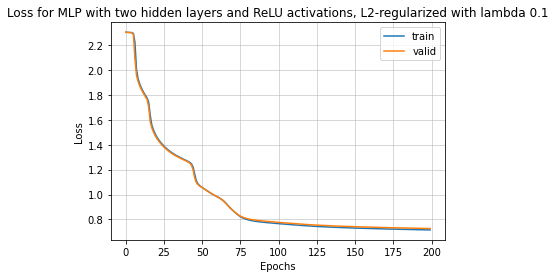

In [ ]:
plt.clf()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss for MLP with two hidden layers and ReLU activations, L2-regularized with lambda 0.1")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

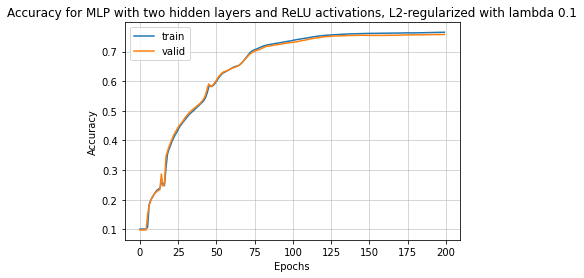

In [ ]:
plt.clf()
plt.plot(train_acc_list, label='train')
plt.plot(val_acc_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy for MLP with two hidden layers and ReLU activations, L2-regularized with lambda 0.1")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
y_test_probs = mlp_two_hidden_l2_0_1.predict(x_test, is_test=True)

test_loss = EvaluationUtils.calculate_ce_loss(y_test_probs, y_test)
test_acc = EvaluationUtils.calculate_multi_accuracy(y_test_probs, y_test)

print("Test loss: {}".format(test_loss))
print("Test accuracy: {}".format(test_acc))

Test loss: 0.734226148739179
Test accuracy: 0.7562


#### L2 regularization with lambda 0.5

In [ ]:
mlp_two_hidden_l2_0_5 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE, l2_lambda=0.5),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE, l2_lambda=0.5),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, FASHION_MNIST_N_CLASSES, l2_lambda=0.5),
    SoftmaxOutputLayer()
)

opt_two_hidden_l2_0_5 = GradientDescentOptimizer(mlp_two_hidden_l2_0_5, MLP_LR)
train_loss_list, val_loss_list, train_acc_list, val_acc_list = mlp_two_hidden_l2_0_5.fit(opt_two_hidden_l2_0_5, x_train, y_train, x_val, y_val,
                                                                                  batch_size=MLP_BATCH_SIZE, epochs=MLP_EPOCHS)

  0%|          | 1/200 [00:01<06:16,  1.89s/it]

Epoch: 1, train loss: 2.3025149091439334, train acc: 0.1068333333333333, val loss: 2.3026517141933613, val acc: 0.09688888888888889


  1%|          | 2/200 [00:03<06:15,  1.90s/it]

Epoch: 2, train loss: 2.3025939417900223, train acc: 0.10133333333333325, val loss: 2.3027047572481405, val acc: 0.09688888888888889


  2%|▏         | 3/200 [00:05<06:14,  1.90s/it]

Epoch: 3, train loss: 2.302598503571799, train acc: 0.10133333333333325, val loss: 2.3027155424343784, val acc: 0.09688888888888889


  2%|▏         | 4/200 [00:07<06:12,  1.90s/it]

Epoch: 4, train loss: 2.3025913723529956, train acc: 0.10133333333333325, val loss: 2.3027235471915874, val acc: 0.09688888888888889


  2%|▎         | 5/200 [00:09<06:11,  1.90s/it]

Epoch: 5, train loss: 2.3025860388281334, train acc: 0.10133333333333325, val loss: 2.3027309200358617, val acc: 0.09688888888888889


  3%|▎         | 6/200 [00:11<06:06,  1.89s/it]

Epoch: 6, train loss: 2.3025824568213373, train acc: 0.10133333333333325, val loss: 2.302737526566222, val acc: 0.09688888888888889


  4%|▎         | 7/200 [00:13<06:03,  1.88s/it]

Epoch: 7, train loss: 2.3025800613452665, train acc: 0.10133333333333325, val loss: 2.302743292183617, val acc: 0.09688888888888889


  4%|▍         | 8/200 [00:15<06:01,  1.88s/it]

Epoch: 8, train loss: 2.3025784547422963, train acc: 0.10133333333333325, val loss: 2.3027482328154023, val acc: 0.09688888888888889


  4%|▍         | 9/200 [00:17<06:01,  1.89s/it]

Epoch: 9, train loss: 2.3025773729042824, train acc: 0.10133333333333325, val loss: 2.3027524117859066, val acc: 0.09688888888888889


  5%|▌         | 10/200 [00:18<06:01,  1.90s/it]

Epoch: 10, train loss: 2.3025766409331743, train acc: 0.10133333333333325, val loss: 2.3027559128397197, val acc: 0.09688888888888889


  6%|▌         | 11/200 [00:20<05:58,  1.90s/it]

Epoch: 11, train loss: 2.3025761429009366, train acc: 0.10133333333333325, val loss: 2.3027588248637523, val acc: 0.09688888888888889


  6%|▌         | 12/200 [00:22<05:55,  1.89s/it]

Epoch: 12, train loss: 2.3025758018436373, train acc: 0.10133333333333325, val loss: 2.3027612335960423, val acc: 0.09688888888888889


  6%|▋         | 13/200 [00:24<05:52,  1.88s/it]

Epoch: 13, train loss: 2.3025755665603533, train acc: 0.10133333333333325, val loss: 2.3027632174804644, val acc: 0.09688888888888889


  7%|▋         | 14/200 [00:26<05:50,  1.88s/it]

Epoch: 14, train loss: 2.3025754029032637, train acc: 0.10133333333333325, val loss: 2.302764845957071, val acc: 0.09688888888888889


  8%|▊         | 15/200 [00:28<05:47,  1.88s/it]

Epoch: 15, train loss: 2.3025752880284105, train acc: 0.10133333333333325, val loss: 2.302766179145858, val acc: 0.09688888888888889


  8%|▊         | 16/200 [00:30<05:45,  1.88s/it]

Epoch: 16, train loss: 2.302575206598027, train acc: 0.10133333333333325, val loss: 2.302767268287959, val acc: 0.09688888888888889


  8%|▊         | 17/200 [00:32<05:43,  1.88s/it]

Epoch: 17, train loss: 2.302575148269498, train acc: 0.10133333333333325, val loss: 2.3027681565596345, val acc: 0.09688888888888889


  9%|▉         | 18/200 [00:33<05:41,  1.88s/it]

Epoch: 18, train loss: 2.3025751060330752, train acc: 0.10133333333333325, val loss: 2.3027688800311696, val acc: 0.09688888888888889


 10%|▉         | 19/200 [00:35<05:42,  1.89s/it]

Epoch: 19, train loss: 2.3025750751097753, train acc: 0.10133333333333325, val loss: 2.3027694686402835, val acc: 0.09688888888888889


 10%|█         | 20/200 [00:37<05:39,  1.88s/it]

Epoch: 20, train loss: 2.302575052219342, train acc: 0.10133333333333325, val loss: 2.302769947109811, val acc: 0.09688888888888889


 10%|█         | 21/200 [00:39<05:37,  1.89s/it]

Epoch: 21, train loss: 2.3025750350929317, train acc: 0.10133333333333325, val loss: 2.3027703357759375, val acc: 0.09688888888888889


 11%|█         | 22/200 [00:41<05:35,  1.89s/it]

Epoch: 22, train loss: 2.302575022147798, train acc: 0.10133333333333325, val loss: 2.3027706513148534, val acc: 0.09688888888888889


 12%|█▏        | 23/200 [00:43<05:34,  1.89s/it]

Epoch: 23, train loss: 2.302575012269456, train acc: 0.10133333333333325, val loss: 2.3027709073680085, val acc: 0.09688888888888889


 12%|█▏        | 24/200 [00:45<05:31,  1.88s/it]

Epoch: 24, train loss: 2.3025750046652056, train acc: 0.10133333333333325, val loss: 2.3027711150726557, val acc: 0.09688888888888889


 12%|█▎        | 25/200 [00:47<05:29,  1.88s/it]

Epoch: 25, train loss: 2.3025749987652286, train acc: 0.10133333333333325, val loss: 2.302771283507411, val acc: 0.09688888888888889


 13%|█▎        | 26/200 [00:49<05:29,  1.89s/it]

Epoch: 26, train loss: 2.302574994155415, train acc: 0.10133333333333325, val loss: 2.3027714200635576, val acc: 0.09688888888888889


 14%|█▎        | 27/200 [00:50<05:26,  1.89s/it]

Epoch: 27, train loss: 2.30257499053147, train acc: 0.10133333333333325, val loss: 2.302771530752621, val acc: 0.09688888888888889


 14%|█▍        | 28/200 [00:52<05:24,  1.89s/it]

Epoch: 28, train loss: 2.302574987667355, train acc: 0.10133333333333325, val loss: 2.302771620459993, val acc: 0.09688888888888889


 14%|█▍        | 29/200 [00:54<05:23,  1.89s/it]

Epoch: 29, train loss: 2.302574985393379, train acc: 0.10133333333333325, val loss: 2.3027716931533107, val acc: 0.09688888888888889


 15%|█▌        | 30/200 [00:56<05:21,  1.89s/it]

Epoch: 30, train loss: 2.3025749835808753, train acc: 0.10133333333333325, val loss: 2.3027717520531654, val acc: 0.09688888888888889


 16%|█▌        | 31/200 [00:58<05:20,  1.89s/it]

Epoch: 31, train loss: 2.3025749821313743, train acc: 0.10133333333333325, val loss: 2.3027717997726547, val acc: 0.09688888888888889


 16%|█▌        | 32/200 [01:00<05:15,  1.88s/it]

Epoch: 32, train loss: 2.3025749809688882, train acc: 0.10133333333333325, val loss: 2.302771838431239, val acc: 0.09688888888888889


 16%|█▋        | 33/200 [01:02<05:14,  1.88s/it]

Epoch: 33, train loss: 2.302574980034328, train acc: 0.10133333333333325, val loss: 2.3027718697475192, val acc: 0.09688888888888889


 17%|█▋        | 34/200 [01:04<05:12,  1.88s/it]

Epoch: 34, train loss: 2.302574979281433, train acc: 0.10133333333333325, val loss: 2.302771895114734, val acc: 0.09688888888888889


 18%|█▊        | 35/200 [01:06<05:12,  1.89s/it]

Epoch: 35, train loss: 2.302574978673792, train acc: 0.10133333333333325, val loss: 2.30277191566215, val acc: 0.09688888888888889


 18%|█▊        | 36/200 [01:07<05:10,  1.89s/it]

Epoch: 36, train loss: 2.302574978182587, train acc: 0.10133333333333325, val loss: 2.302771932304943, val acc: 0.09688888888888889


 18%|█▊        | 37/200 [01:09<05:06,  1.88s/it]

Epoch: 37, train loss: 2.302574977784915, train acc: 0.10133333333333325, val loss: 2.3027719457846896, val acc: 0.09688888888888889


 19%|█▉        | 38/200 [01:11<05:05,  1.89s/it]

Epoch: 38, train loss: 2.302574977462516, train acc: 0.10133333333333325, val loss: 2.3027719567022427, val acc: 0.09688888888888889


 20%|█▉        | 39/200 [01:13<05:04,  1.89s/it]

Epoch: 39, train loss: 2.3025749772007873, train acc: 0.10133333333333325, val loss: 2.3027719655443954, val acc: 0.09688888888888889


 20%|██        | 40/200 [01:15<05:01,  1.88s/it]

Epoch: 40, train loss: 2.3025749769880117, train acc: 0.10133333333333325, val loss: 2.3027719727055063, val acc: 0.09688888888888889


 20%|██        | 41/200 [01:17<05:00,  1.89s/it]

Epoch: 41, train loss: 2.302574976814773, train acc: 0.10133333333333325, val loss: 2.302771978505034, val acc: 0.09688888888888889


 21%|██        | 42/200 [01:19<04:58,  1.89s/it]

Epoch: 42, train loss: 2.302574976673498, train acc: 0.10133333333333325, val loss: 2.3027719832017515, val acc: 0.09688888888888889


 22%|██▏       | 43/200 [01:21<04:57,  1.89s/it]

Epoch: 43, train loss: 2.3025749765580774, train acc: 0.10133333333333325, val loss: 2.3027719870052676, val acc: 0.09688888888888889


 22%|██▏       | 44/200 [01:23<04:53,  1.88s/it]

Epoch: 44, train loss: 2.3025749764635814, train acc: 0.10133333333333325, val loss: 2.302771990085362, val acc: 0.09688888888888889


 22%|██▎       | 45/200 [01:24<04:53,  1.90s/it]

Epoch: 45, train loss: 2.302574976386025, train acc: 0.10133333333333325, val loss: 2.3027719925795496, val acc: 0.09688888888888889


 23%|██▎       | 46/200 [01:26<04:51,  1.89s/it]

Epoch: 46, train loss: 2.3025749763221937, train acc: 0.10133333333333325, val loss: 2.302771994599211, val acc: 0.09688888888888889


 24%|██▎       | 47/200 [01:28<04:48,  1.88s/it]

Epoch: 47, train loss: 2.3025749762694816, train acc: 0.10133333333333325, val loss: 2.302771996234555, val acc: 0.09688888888888889


 24%|██▍       | 48/200 [01:30<04:45,  1.88s/it]

Epoch: 48, train loss: 2.30257497622578, train acc: 0.10133333333333325, val loss: 2.3027719975586463, val acc: 0.09688888888888889


 24%|██▍       | 49/200 [01:32<04:43,  1.88s/it]

Epoch: 49, train loss: 2.3025749761893812, train acc: 0.10133333333333325, val loss: 2.3027719986306585, val acc: 0.09688888888888889


 25%|██▌       | 50/200 [01:34<04:43,  1.89s/it]

Epoch: 50, train loss: 2.3025749761589025, train acc: 0.10133333333333325, val loss: 2.302771999498518, val acc: 0.09688888888888889


 26%|██▌       | 51/200 [01:36<04:42,  1.89s/it]

Epoch: 51, train loss: 2.3025749761332244, train acc: 0.10133333333333325, val loss: 2.3027720002010392, val acc: 0.09688888888888889


 26%|██▌       | 52/200 [01:38<04:39,  1.89s/it]

Epoch: 52, train loss: 2.3025749761114427, train acc: 0.10133333333333325, val loss: 2.3027720007696586, val acc: 0.09688888888888889


 26%|██▋       | 53/200 [01:40<04:39,  1.90s/it]

Epoch: 53, train loss: 2.3025749760928145, train acc: 0.10133333333333325, val loss: 2.302772001229836, val acc: 0.09688888888888889


 27%|██▋       | 54/200 [01:41<04:36,  1.90s/it]

Epoch: 54, train loss: 2.302574976076747, train acc: 0.10133333333333325, val loss: 2.3027720016021886, val acc: 0.09688888888888889


 28%|██▊       | 55/200 [01:43<04:34,  1.89s/it]

Epoch: 55, train loss: 2.3025749760627567, train acc: 0.10133333333333325, val loss: 2.302772001903417, val acc: 0.09688888888888889


 28%|██▊       | 56/200 [01:45<04:31,  1.89s/it]

Epoch: 56, train loss: 2.302574976050451, train acc: 0.10133333333333325, val loss: 2.302772002147045, val acc: 0.09688888888888889


 28%|██▊       | 57/200 [01:47<04:30,  1.89s/it]

Epoch: 57, train loss: 2.3025749760395122, train acc: 0.10133333333333325, val loss: 2.3027720023440237, val acc: 0.09688888888888889


 29%|██▉       | 58/200 [01:49<04:29,  1.90s/it]

Epoch: 58, train loss: 2.3025749760296788, train acc: 0.10133333333333325, val loss: 2.3027720025032252, val acc: 0.09688888888888889


 30%|██▉       | 59/200 [01:51<04:27,  1.90s/it]

Epoch: 59, train loss: 2.3025749760207455, train acc: 0.10133333333333325, val loss: 2.302772002631832, val acc: 0.09688888888888889


 30%|███       | 60/200 [01:53<04:26,  1.90s/it]

Epoch: 60, train loss: 2.302574976012543, train acc: 0.10133333333333325, val loss: 2.302772002735662, val acc: 0.09688888888888889


 30%|███       | 61/200 [01:55<04:24,  1.90s/it]

Epoch: 61, train loss: 2.302574976004932, train acc: 0.10133333333333325, val loss: 2.3027720028194265, val acc: 0.09688888888888889


 31%|███       | 62/200 [01:57<04:21,  1.90s/it]

Epoch: 62, train loss: 2.3025749759978007, train acc: 0.10133333333333325, val loss: 2.302772002886941, val acc: 0.09688888888888889


 32%|███▏      | 63/200 [01:59<04:19,  1.90s/it]

Epoch: 63, train loss: 2.3025749759910594, train acc: 0.10133333333333325, val loss: 2.302772002941296, val acc: 0.09688888888888889


 32%|███▏      | 64/200 [02:00<04:16,  1.89s/it]

Epoch: 64, train loss: 2.302574975984636, train acc: 0.10133333333333325, val loss: 2.302772002984995, val acc: 0.09688888888888889


 32%|███▎      | 65/200 [02:02<04:13,  1.88s/it]

Epoch: 65, train loss: 2.3025749759784655, train acc: 0.10133333333333325, val loss: 2.302772003020062, val acc: 0.09688888888888889


 33%|███▎      | 66/200 [02:04<04:11,  1.87s/it]

Epoch: 66, train loss: 2.302574975972504, train acc: 0.10133333333333325, val loss: 2.302772003048141, val acc: 0.09688888888888889


 34%|███▎      | 67/200 [02:06<04:09,  1.87s/it]

Epoch: 67, train loss: 2.3025749759667127, train acc: 0.10133333333333325, val loss: 2.302772003070559, val acc: 0.09688888888888889


 34%|███▍      | 68/200 [02:08<04:08,  1.89s/it]

Epoch: 68, train loss: 2.302574975961059, train acc: 0.10133333333333325, val loss: 2.3027720030883936, val acc: 0.09688888888888889


 34%|███▍      | 69/200 [02:10<04:07,  1.89s/it]

Epoch: 69, train loss: 2.3025749759555154, train acc: 0.10133333333333325, val loss: 2.3027720031025165, val acc: 0.09688888888888889


 35%|███▌      | 70/200 [02:12<04:05,  1.89s/it]

Epoch: 70, train loss: 2.302574975950062, train acc: 0.10133333333333325, val loss: 2.3027720031136334, val acc: 0.09688888888888889


 36%|███▌      | 71/200 [02:14<04:03,  1.89s/it]

Epoch: 71, train loss: 2.302574975944685, train acc: 0.10133333333333325, val loss: 2.302772003122316, val acc: 0.09688888888888889


 36%|███▌      | 72/200 [02:15<04:01,  1.89s/it]

Epoch: 72, train loss: 2.302574975939363, train acc: 0.10133333333333325, val loss: 2.302772003129027, val acc: 0.09688888888888889


 36%|███▋      | 73/200 [02:17<03:58,  1.88s/it]

Epoch: 73, train loss: 2.302574975934095, train acc: 0.10133333333333325, val loss: 2.302772003134142, val acc: 0.09688888888888889


 37%|███▋      | 74/200 [02:19<03:56,  1.88s/it]

Epoch: 74, train loss: 2.3025749759288616, train acc: 0.10133333333333325, val loss: 2.302772003137964, val acc: 0.09688888888888889


 38%|███▊      | 75/200 [02:21<03:55,  1.88s/it]

Epoch: 75, train loss: 2.302574975923664, train acc: 0.10133333333333325, val loss: 2.3027720031407397, val acc: 0.09688888888888889


 38%|███▊      | 76/200 [02:23<03:54,  1.89s/it]

Epoch: 76, train loss: 2.30257497591849, train acc: 0.10133333333333325, val loss: 2.3027720031426666, val acc: 0.09688888888888889


 38%|███▊      | 77/200 [02:25<03:52,  1.89s/it]

Epoch: 77, train loss: 2.302574975913338, train acc: 0.10133333333333325, val loss: 2.3027720031439087, val acc: 0.09688888888888889


 39%|███▉      | 78/200 [02:27<03:49,  1.89s/it]

Epoch: 78, train loss: 2.3025749759082013, train acc: 0.10133333333333325, val loss: 2.3027720031445935, val acc: 0.09688888888888889


 40%|███▉      | 79/200 [02:29<03:47,  1.88s/it]

Epoch: 79, train loss: 2.3025749759030814, train acc: 0.10133333333333325, val loss: 2.302772003144829, val acc: 0.09688888888888889


 40%|████      | 80/200 [02:31<03:45,  1.88s/it]

Epoch: 80, train loss: 2.30257497589797, train acc: 0.10133333333333325, val loss: 2.302772003144699, val acc: 0.09688888888888889


 40%|████      | 81/200 [02:32<03:43,  1.88s/it]

Epoch: 81, train loss: 2.30257497589287, train acc: 0.10133333333333325, val loss: 2.302772003144275, val acc: 0.09688888888888889


 41%|████      | 82/200 [02:34<03:41,  1.88s/it]

Epoch: 82, train loss: 2.3025749758877754, train acc: 0.10133333333333325, val loss: 2.302772003143612, val acc: 0.09688888888888889


 42%|████▏     | 83/200 [02:36<03:39,  1.88s/it]

Epoch: 83, train loss: 2.3025749758826923, train acc: 0.10133333333333325, val loss: 2.302772003142755, val acc: 0.09688888888888889


 42%|████▏     | 84/200 [02:38<03:37,  1.88s/it]

Epoch: 84, train loss: 2.3025749758776097, train acc: 0.10133333333333325, val loss: 2.302772003141741, val acc: 0.09688888888888889


 42%|████▎     | 85/200 [02:40<03:35,  1.87s/it]

Epoch: 85, train loss: 2.302574975872535, train acc: 0.10133333333333325, val loss: 2.3027720031406007, val acc: 0.09688888888888889


 43%|████▎     | 86/200 [02:42<03:34,  1.88s/it]

Epoch: 86, train loss: 2.3025749758674596, train acc: 0.10133333333333325, val loss: 2.3027720031393577, val acc: 0.09688888888888889


 44%|████▎     | 87/200 [02:44<03:33,  1.89s/it]

Epoch: 87, train loss: 2.3025749758623895, train acc: 0.10133333333333325, val loss: 2.302772003138031, val acc: 0.09688888888888889


 44%|████▍     | 88/200 [02:46<03:31,  1.89s/it]

Epoch: 88, train loss: 2.3025749758573224, train acc: 0.10133333333333325, val loss: 2.3027720031366377, val acc: 0.09688888888888889


 44%|████▍     | 89/200 [02:47<03:29,  1.89s/it]

Epoch: 89, train loss: 2.302574975852257, train acc: 0.10133333333333325, val loss: 2.30277200313519, val acc: 0.09688888888888889


 45%|████▌     | 90/200 [02:49<03:26,  1.88s/it]

Epoch: 90, train loss: 2.3025749758471936, train acc: 0.10133333333333325, val loss: 2.302772003133698, val acc: 0.09688888888888889


 46%|████▌     | 91/200 [02:51<03:24,  1.88s/it]

Epoch: 91, train loss: 2.3025749758421306, train acc: 0.10133333333333325, val loss: 2.30277200313217, val acc: 0.09688888888888889


 46%|████▌     | 92/200 [02:53<03:23,  1.88s/it]

Epoch: 92, train loss: 2.3025749758370693, train acc: 0.10133333333333325, val loss: 2.3027720031306136, val acc: 0.09688888888888889


 46%|████▋     | 93/200 [02:55<03:20,  1.88s/it]

Epoch: 93, train loss: 2.3025749758320115, train acc: 0.10133333333333325, val loss: 2.302772003129033, val acc: 0.09688888888888889


 47%|████▋     | 94/200 [02:57<03:18,  1.87s/it]

Epoch: 94, train loss: 2.3025749758269525, train acc: 0.10133333333333325, val loss: 2.302772003127435, val acc: 0.09688888888888889


 48%|████▊     | 95/200 [02:59<03:16,  1.87s/it]

Epoch: 95, train loss: 2.3025749758218925, train acc: 0.10133333333333325, val loss: 2.3027720031258205, val acc: 0.09688888888888889


 48%|████▊     | 96/200 [03:01<03:16,  1.89s/it]

Epoch: 96, train loss: 2.302574975816836, train acc: 0.10133333333333325, val loss: 2.302772003124194, val acc: 0.09688888888888889


 48%|████▊     | 97/200 [03:03<03:15,  1.90s/it]

Epoch: 97, train loss: 2.30257497581178, train acc: 0.10133333333333325, val loss: 2.3027720031225583, val acc: 0.09688888888888889


 49%|████▉     | 98/200 [03:04<03:14,  1.91s/it]

Epoch: 98, train loss: 2.3025749758067278, train acc: 0.10133333333333325, val loss: 2.3027720031209133, val acc: 0.09688888888888889


 50%|████▉     | 99/200 [03:06<03:12,  1.91s/it]

Epoch: 99, train loss: 2.3025749758016687, train acc: 0.10133333333333325, val loss: 2.3027720031192627, val acc: 0.09688888888888889


 50%|█████     | 100/200 [03:08<03:11,  1.91s/it]

Epoch: 100, train loss: 2.302574975796614, train acc: 0.10133333333333325, val loss: 2.302772003117606, val acc: 0.09688888888888889


 50%|█████     | 101/200 [03:10<03:09,  1.92s/it]

Epoch: 101, train loss: 2.302574975791559, train acc: 0.10133333333333325, val loss: 2.302772003115946, val acc: 0.09688888888888889


 51%|█████     | 102/200 [03:12<03:08,  1.93s/it]

Epoch: 102, train loss: 2.302574975786506, train acc: 0.10133333333333325, val loss: 2.3027720031142827, val acc: 0.09688888888888889


 52%|█████▏    | 103/200 [03:14<03:07,  1.93s/it]

Epoch: 103, train loss: 2.302574975781453, train acc: 0.10133333333333325, val loss: 2.3027720031126155, val acc: 0.09688888888888889


 52%|█████▏    | 104/200 [03:16<03:05,  1.93s/it]

Epoch: 104, train loss: 2.3025749757764022, train acc: 0.10133333333333325, val loss: 2.3027720031109475, val acc: 0.09688888888888889


 52%|█████▎    | 105/200 [03:18<03:04,  1.95s/it]

Epoch: 105, train loss: 2.302574975771349, train acc: 0.10133333333333325, val loss: 2.302772003109277, val acc: 0.09688888888888889


 53%|█████▎    | 106/200 [03:20<03:01,  1.93s/it]

Epoch: 106, train loss: 2.302574975766298, train acc: 0.10133333333333325, val loss: 2.3027720031076058, val acc: 0.09688888888888889


 54%|█████▎    | 107/200 [03:22<02:59,  1.93s/it]

Epoch: 107, train loss: 2.3025749757612464, train acc: 0.10133333333333325, val loss: 2.3027720031059324, val acc: 0.09688888888888889


 54%|█████▍    | 108/200 [03:24<02:57,  1.93s/it]

Epoch: 108, train loss: 2.3025749757561926, train acc: 0.10133333333333325, val loss: 2.3027720031042587, val acc: 0.09688888888888889


 55%|█████▍    | 109/200 [03:26<02:54,  1.92s/it]

Epoch: 109, train loss: 2.3025749757511433, train acc: 0.10133333333333325, val loss: 2.3027720031025845, val acc: 0.09688888888888889


 55%|█████▌    | 110/200 [03:28<02:51,  1.91s/it]

Epoch: 110, train loss: 2.302574975746094, train acc: 0.10133333333333325, val loss: 2.3027720031009093, val acc: 0.09688888888888889


 56%|█████▌    | 111/200 [03:29<02:50,  1.91s/it]

Epoch: 111, train loss: 2.3025749757410456, train acc: 0.10133333333333325, val loss: 2.3027720030992342, val acc: 0.09688888888888889


 56%|█████▌    | 112/200 [03:31<02:46,  1.90s/it]

Epoch: 112, train loss: 2.302574975735996, train acc: 0.10133333333333325, val loss: 2.3027720030975587, val acc: 0.09688888888888889


 56%|█████▋    | 113/200 [03:33<02:44,  1.89s/it]

Epoch: 113, train loss: 2.3025749757309484, train acc: 0.10133333333333325, val loss: 2.3027720030958827, val acc: 0.09688888888888889


 57%|█████▋    | 114/200 [03:35<02:43,  1.90s/it]

Epoch: 114, train loss: 2.3025749757258995, train acc: 0.10133333333333325, val loss: 2.3027720030942067, val acc: 0.09688888888888889


 57%|█████▊    | 115/200 [03:37<02:41,  1.90s/it]

Epoch: 115, train loss: 2.302574975720851, train acc: 0.10133333333333325, val loss: 2.302772003092531, val acc: 0.09688888888888889


 58%|█████▊    | 116/200 [03:39<02:39,  1.90s/it]

Epoch: 116, train loss: 2.3025749757158036, train acc: 0.10133333333333325, val loss: 2.3027720030908547, val acc: 0.09688888888888889


 58%|█████▊    | 117/200 [03:41<02:38,  1.90s/it]

Epoch: 117, train loss: 2.3025749757107556, train acc: 0.10133333333333325, val loss: 2.3027720030891787, val acc: 0.09688888888888889


 59%|█████▉    | 118/200 [03:43<02:36,  1.91s/it]

Epoch: 118, train loss: 2.3025749757057103, train acc: 0.10133333333333325, val loss: 2.3027720030875027, val acc: 0.09688888888888889


 60%|█████▉    | 119/200 [03:45<02:36,  1.93s/it]

Epoch: 119, train loss: 2.3025749757006597, train acc: 0.10133333333333325, val loss: 2.3027720030858267, val acc: 0.09688888888888889


 60%|██████    | 120/200 [03:47<02:35,  1.94s/it]

Epoch: 120, train loss: 2.302574975695617, train acc: 0.10133333333333325, val loss: 2.3027720030841508, val acc: 0.09688888888888889


 60%|██████    | 121/200 [03:49<02:33,  1.94s/it]

Epoch: 121, train loss: 2.3025749756905713, train acc: 0.10133333333333325, val loss: 2.3027720030824748, val acc: 0.09688888888888889


 61%|██████    | 122/200 [03:51<02:29,  1.92s/it]

Epoch: 122, train loss: 2.302574975685526, train acc: 0.10133333333333325, val loss: 2.3027720030807983, val acc: 0.09688888888888889


 62%|██████▏   | 123/200 [03:52<02:27,  1.92s/it]

Epoch: 123, train loss: 2.30257497568048, train acc: 0.10133333333333325, val loss: 2.302772003079123, val acc: 0.09688888888888889


 62%|██████▏   | 124/200 [03:54<02:27,  1.95s/it]

Epoch: 124, train loss: 2.3025749756754363, train acc: 0.10133333333333325, val loss: 2.3027720030774477, val acc: 0.09688888888888889


 62%|██████▎   | 125/200 [03:56<02:24,  1.93s/it]

Epoch: 125, train loss: 2.302574975670393, train acc: 0.10133333333333325, val loss: 2.3027720030757717, val acc: 0.09688888888888889


 63%|██████▎   | 126/200 [03:58<02:22,  1.92s/it]

Epoch: 126, train loss: 2.3025749756653515, train acc: 0.10133333333333325, val loss: 2.3027720030740966, val acc: 0.09688888888888889


 64%|██████▎   | 127/200 [04:01<02:43,  2.24s/it]

Epoch: 127, train loss: 2.3025749756603076, train acc: 0.10133333333333325, val loss: 2.302772003072421, val acc: 0.09688888888888889


 64%|██████▍   | 128/200 [04:04<02:41,  2.25s/it]

Epoch: 128, train loss: 2.302574975655262, train acc: 0.10133333333333325, val loss: 2.3027720030707455, val acc: 0.09688888888888889


 64%|██████▍   | 129/200 [04:05<02:31,  2.13s/it]

Epoch: 129, train loss: 2.3025749756502187, train acc: 0.10133333333333325, val loss: 2.302772003069071, val acc: 0.09688888888888889


 65%|██████▌   | 130/200 [04:07<02:23,  2.06s/it]

Epoch: 130, train loss: 2.3025749756451783, train acc: 0.10133333333333325, val loss: 2.302772003067396, val acc: 0.09688888888888889


 66%|██████▌   | 131/200 [04:09<02:18,  2.01s/it]

Epoch: 131, train loss: 2.302574975640139, train acc: 0.10133333333333325, val loss: 2.302772003065721, val acc: 0.09688888888888889


 66%|██████▌   | 132/200 [04:11<02:13,  1.97s/it]

Epoch: 132, train loss: 2.302574975635095, train acc: 0.10133333333333325, val loss: 2.3027720030640464, val acc: 0.09688888888888889


 66%|██████▋   | 133/200 [04:13<02:10,  1.94s/it]

Epoch: 133, train loss: 2.3025749756300558, train acc: 0.10133333333333325, val loss: 2.3027720030623717, val acc: 0.09688888888888889


 67%|██████▋   | 134/200 [04:15<02:07,  1.93s/it]

Epoch: 134, train loss: 2.302574975625012, train acc: 0.10133333333333325, val loss: 2.3027720030606975, val acc: 0.09688888888888889


 68%|██████▊   | 135/200 [04:17<02:05,  1.92s/it]

Epoch: 135, train loss: 2.3025749756199727, train acc: 0.10133333333333325, val loss: 2.302772003059023, val acc: 0.09688888888888889


 68%|██████▊   | 136/200 [04:19<02:02,  1.91s/it]

Epoch: 136, train loss: 2.3025749756149354, train acc: 0.10133333333333325, val loss: 2.3027720030573486, val acc: 0.09688888888888889


 68%|██████▊   | 137/200 [04:21<02:00,  1.91s/it]

Epoch: 137, train loss: 2.3025749756098937, train acc: 0.10133333333333325, val loss: 2.302772003055675, val acc: 0.09688888888888889


 69%|██████▉   | 138/200 [04:22<01:57,  1.90s/it]

Epoch: 138, train loss: 2.302574975604857, train acc: 0.10133333333333325, val loss: 2.3027720030540006, val acc: 0.09688888888888889


 70%|██████▉   | 139/200 [04:24<01:55,  1.90s/it]

Epoch: 139, train loss: 2.302574975599817, train acc: 0.10133333333333325, val loss: 2.302772003052327, val acc: 0.09688888888888889


 70%|███████   | 140/200 [04:26<01:53,  1.89s/it]

Epoch: 140, train loss: 2.30257497559478, train acc: 0.10133333333333325, val loss: 2.3027720030506535, val acc: 0.09688888888888889


 70%|███████   | 141/200 [04:28<01:51,  1.89s/it]

Epoch: 141, train loss: 2.3025749755897422, train acc: 0.10133333333333325, val loss: 2.3027720030489793, val acc: 0.09688888888888889


 71%|███████   | 142/200 [04:30<01:49,  1.89s/it]

Epoch: 142, train loss: 2.302574975584702, train acc: 0.10133333333333325, val loss: 2.3027720030473064, val acc: 0.09688888888888889


 72%|███████▏  | 143/200 [04:32<01:47,  1.88s/it]

Epoch: 143, train loss: 2.302574975579666, train acc: 0.10133333333333325, val loss: 2.3027720030456327, val acc: 0.09688888888888889


 72%|███████▏  | 144/200 [04:34<01:45,  1.88s/it]

Epoch: 144, train loss: 2.3025749755746294, train acc: 0.10133333333333325, val loss: 2.3027720030439593, val acc: 0.09688888888888889


 72%|███████▎  | 145/200 [04:36<01:43,  1.89s/it]

Epoch: 145, train loss: 2.3025749755695917, train acc: 0.10133333333333325, val loss: 2.3027720030422865, val acc: 0.09688888888888889


 73%|███████▎  | 146/200 [04:37<01:42,  1.90s/it]

Epoch: 146, train loss: 2.3025749755645597, train acc: 0.10133333333333325, val loss: 2.3027720030406136, val acc: 0.09688888888888889


 74%|███████▎  | 147/200 [04:39<01:41,  1.91s/it]

Epoch: 147, train loss: 2.302574975559522, train acc: 0.10133333333333325, val loss: 2.3027720030389407, val acc: 0.09688888888888889


 74%|███████▍  | 148/200 [04:41<01:38,  1.89s/it]

Epoch: 148, train loss: 2.302574975554488, train acc: 0.10133333333333325, val loss: 2.3027720030372683, val acc: 0.09688888888888889


 74%|███████▍  | 149/200 [04:43<01:36,  1.90s/it]

Epoch: 149, train loss: 2.3025749755494562, train acc: 0.10133333333333325, val loss: 2.3027720030355954, val acc: 0.09688888888888889


 75%|███████▌  | 150/200 [04:45<01:34,  1.89s/it]

Epoch: 150, train loss: 2.3025749755444216, train acc: 0.10133333333333325, val loss: 2.3027720030339234, val acc: 0.09688888888888889


 76%|███████▌  | 151/200 [04:47<01:32,  1.90s/it]

Epoch: 151, train loss: 2.302574975539385, train acc: 0.10133333333333325, val loss: 2.302772003032251, val acc: 0.09688888888888889


 76%|███████▌  | 152/200 [04:49<01:32,  1.92s/it]

Epoch: 152, train loss: 2.3025749755343523, train acc: 0.10133333333333325, val loss: 2.3027720030305785, val acc: 0.09688888888888889


 76%|███████▋  | 153/200 [04:51<01:29,  1.90s/it]

Epoch: 153, train loss: 2.302574975529317, train acc: 0.10133333333333325, val loss: 2.302772003028907, val acc: 0.09688888888888889


 77%|███████▋  | 154/200 [04:53<01:27,  1.90s/it]

Epoch: 154, train loss: 2.302574975524284, train acc: 0.10133333333333325, val loss: 2.3027720030272354, val acc: 0.09688888888888889


 78%|███████▊  | 155/200 [04:55<01:25,  1.90s/it]

Epoch: 155, train loss: 2.302574975519252, train acc: 0.10133333333333325, val loss: 2.302772003025563, val acc: 0.09688888888888889


 78%|███████▊  | 156/200 [04:56<01:22,  1.88s/it]

Epoch: 156, train loss: 2.3025749755142226, train acc: 0.10133333333333325, val loss: 2.302772003023892, val acc: 0.09688888888888889


 78%|███████▊  | 157/200 [04:58<01:20,  1.88s/it]

Epoch: 157, train loss: 2.30257497550919, train acc: 0.10133333333333325, val loss: 2.3027720030222203, val acc: 0.09688888888888889


 79%|███████▉  | 158/200 [05:00<01:18,  1.88s/it]

Epoch: 158, train loss: 2.30257497550416, train acc: 0.10133333333333325, val loss: 2.3027720030205487, val acc: 0.09688888888888889


 80%|███████▉  | 159/200 [05:02<01:17,  1.89s/it]

Epoch: 159, train loss: 2.302574975499131, train acc: 0.10133333333333325, val loss: 2.3027720030188776, val acc: 0.09688888888888889


 80%|████████  | 160/200 [05:04<01:15,  1.89s/it]

Epoch: 160, train loss: 2.3025749754941, train acc: 0.10133333333333325, val loss: 2.3027720030172065, val acc: 0.09688888888888889


 80%|████████  | 161/200 [05:06<01:13,  1.88s/it]

Epoch: 161, train loss: 2.30257497548907, train acc: 0.10133333333333325, val loss: 2.3027720030155354, val acc: 0.09688888888888889


 81%|████████  | 162/200 [05:08<01:11,  1.88s/it]

Epoch: 162, train loss: 2.302574975484041, train acc: 0.10133333333333325, val loss: 2.3027720030138648, val acc: 0.09688888888888889


 82%|████████▏ | 163/200 [05:10<01:09,  1.87s/it]

Epoch: 163, train loss: 2.3025749754790095, train acc: 0.10133333333333325, val loss: 2.302772003012194, val acc: 0.09688888888888889


 82%|████████▏ | 164/200 [05:11<01:07,  1.88s/it]

Epoch: 164, train loss: 2.302574975473982, train acc: 0.10133333333333325, val loss: 2.3027720030105234, val acc: 0.09688888888888889


 82%|████████▎ | 165/200 [05:13<01:05,  1.88s/it]

Epoch: 165, train loss: 2.3025749754689526, train acc: 0.10133333333333325, val loss: 2.302772003008853, val acc: 0.09688888888888889


 83%|████████▎ | 166/200 [05:15<01:03,  1.87s/it]

Epoch: 166, train loss: 2.3025749754639246, train acc: 0.10133333333333325, val loss: 2.302772003007183, val acc: 0.09688888888888889


 84%|████████▎ | 167/200 [05:17<01:01,  1.88s/it]

Epoch: 167, train loss: 2.3025749754588967, train acc: 0.10133333333333325, val loss: 2.3027720030055123, val acc: 0.09688888888888889


 84%|████████▍ | 168/200 [05:19<00:59,  1.87s/it]

Epoch: 168, train loss: 2.30257497545387, train acc: 0.10133333333333325, val loss: 2.3027720030038425, val acc: 0.09688888888888889


 84%|████████▍ | 169/200 [05:21<00:57,  1.87s/it]

Epoch: 169, train loss: 2.3025749754488434, train acc: 0.10133333333333325, val loss: 2.3027720030021723, val acc: 0.09688888888888889


 85%|████████▌ | 170/200 [05:23<00:56,  1.87s/it]

Epoch: 170, train loss: 2.302574975443819, train acc: 0.10133333333333325, val loss: 2.3027720030005026, val acc: 0.09688888888888889


 86%|████████▌ | 171/200 [05:25<00:54,  1.88s/it]

Epoch: 171, train loss: 2.302574975438791, train acc: 0.10133333333333325, val loss: 2.3027720029988332, val acc: 0.09688888888888889


 86%|████████▌ | 172/200 [05:26<00:52,  1.88s/it]

Epoch: 172, train loss: 2.3025749754337648, train acc: 0.10133333333333325, val loss: 2.3027720029971634, val acc: 0.09688888888888889


 86%|████████▋ | 173/200 [05:28<00:50,  1.87s/it]

Epoch: 173, train loss: 2.3025749754287403, train acc: 0.10133333333333325, val loss: 2.302772002995494, val acc: 0.09688888888888889


 87%|████████▋ | 174/200 [05:30<00:48,  1.87s/it]

Epoch: 174, train loss: 2.3025749754237173, train acc: 0.10133333333333325, val loss: 2.302772002993825, val acc: 0.09688888888888889


 88%|████████▊ | 175/200 [05:32<00:46,  1.87s/it]

Epoch: 175, train loss: 2.302574975418692, train acc: 0.10133333333333325, val loss: 2.3027720029921555, val acc: 0.09688888888888889


 88%|████████▊ | 176/200 [05:34<00:45,  1.88s/it]

Epoch: 176, train loss: 2.302574975413668, train acc: 0.10133333333333325, val loss: 2.302772002990487, val acc: 0.09688888888888889


 88%|████████▊ | 177/200 [05:36<00:43,  1.89s/it]

Epoch: 177, train loss: 2.3025749754086426, train acc: 0.10133333333333325, val loss: 2.3027720029888177, val acc: 0.09688888888888889


 89%|████████▉ | 178/200 [05:38<00:41,  1.90s/it]

Epoch: 178, train loss: 2.302574975403622, train acc: 0.10133333333333325, val loss: 2.3027720029871492, val acc: 0.09688888888888889


 90%|████████▉ | 179/200 [05:40<00:40,  1.92s/it]

Epoch: 179, train loss: 2.302574975398599, train acc: 0.10133333333333325, val loss: 2.302772002985481, val acc: 0.09688888888888889


 90%|█████████ | 180/200 [05:42<00:38,  1.92s/it]

Epoch: 180, train loss: 2.3025749753935756, train acc: 0.10133333333333325, val loss: 2.302772002983812, val acc: 0.09688888888888889


 90%|█████████ | 181/200 [05:44<00:36,  1.92s/it]

Epoch: 181, train loss: 2.302574975388553, train acc: 0.10133333333333325, val loss: 2.302772002982144, val acc: 0.09688888888888889


 91%|█████████ | 182/200 [05:46<00:34,  1.92s/it]

Epoch: 182, train loss: 2.302574975383533, train acc: 0.10133333333333325, val loss: 2.302772002980475, val acc: 0.09688888888888889


 92%|█████████▏| 183/200 [05:47<00:32,  1.92s/it]

Epoch: 183, train loss: 2.3025749753785125, train acc: 0.10133333333333325, val loss: 2.3027720029788075, val acc: 0.09688888888888889


 92%|█████████▏| 184/200 [05:49<00:30,  1.91s/it]

Epoch: 184, train loss: 2.3025749753734894, train acc: 0.10133333333333325, val loss: 2.3027720029771395, val acc: 0.09688888888888889


 92%|█████████▎| 185/200 [05:51<00:28,  1.91s/it]

Epoch: 185, train loss: 2.3025749753684694, train acc: 0.10133333333333325, val loss: 2.302772002975472, val acc: 0.09688888888888889


 93%|█████████▎| 186/200 [05:53<00:26,  1.91s/it]

Epoch: 186, train loss: 2.30257497536345, train acc: 0.10133333333333325, val loss: 2.302772002973804, val acc: 0.09688888888888889


 94%|█████████▎| 187/200 [05:55<00:24,  1.92s/it]

Epoch: 187, train loss: 2.302574975358428, train acc: 0.10133333333333325, val loss: 2.3027720029721364, val acc: 0.09688888888888889


 94%|█████████▍| 188/200 [05:57<00:22,  1.92s/it]

Epoch: 188, train loss: 2.3025749753534104, train acc: 0.10133333333333325, val loss: 2.302772002970469, val acc: 0.09688888888888889


 94%|█████████▍| 189/200 [05:59<00:20,  1.91s/it]

Epoch: 189, train loss: 2.3025749753483904, train acc: 0.10133333333333325, val loss: 2.3027720029688017, val acc: 0.09688888888888889


 95%|█████████▌| 190/200 [06:01<00:18,  1.90s/it]

Epoch: 190, train loss: 2.302574975343373, train acc: 0.10133333333333325, val loss: 2.302772002967134, val acc: 0.09688888888888889


 96%|█████████▌| 191/200 [06:03<00:17,  1.90s/it]

Epoch: 191, train loss: 2.302574975338357, train acc: 0.10133333333333325, val loss: 2.3027720029654675, val acc: 0.09688888888888889


 96%|█████████▌| 192/200 [06:05<00:15,  1.90s/it]

Epoch: 192, train loss: 2.302574975333338, train acc: 0.10133333333333325, val loss: 2.3027720029638004, val acc: 0.09688888888888889


 96%|█████████▋| 193/200 [06:07<00:13,  1.91s/it]

Epoch: 193, train loss: 2.30257497532832, train acc: 0.10133333333333325, val loss: 2.3027720029621337, val acc: 0.09688888888888889


 97%|█████████▋| 194/200 [06:08<00:11,  1.91s/it]

Epoch: 194, train loss: 2.302574975323304, train acc: 0.10133333333333325, val loss: 2.302772002960467, val acc: 0.09688888888888889


 98%|█████████▊| 195/200 [06:10<00:09,  1.91s/it]

Epoch: 195, train loss: 2.3025749753182856, train acc: 0.10133333333333325, val loss: 2.3027720029588, val acc: 0.09688888888888889


 98%|█████████▊| 196/200 [06:12<00:07,  1.90s/it]

Epoch: 196, train loss: 2.3025749753132683, train acc: 0.10133333333333325, val loss: 2.302772002957134, val acc: 0.09688888888888889


 98%|█████████▊| 197/200 [06:14<00:05,  1.91s/it]

Epoch: 197, train loss: 2.3025749753082536, train acc: 0.10133333333333325, val loss: 2.302772002955468, val acc: 0.09688888888888889


 99%|█████████▉| 198/200 [06:16<00:03,  1.90s/it]

Epoch: 198, train loss: 2.302574975303239, train acc: 0.10133333333333325, val loss: 2.3027720029538017, val acc: 0.09688888888888889


100%|█████████▉| 199/200 [06:18<00:01,  1.90s/it]

Epoch: 199, train loss: 2.3025749752982247, train acc: 0.10133333333333325, val loss: 2.302772002952136, val acc: 0.09688888888888889


100%|██████████| 200/200 [06:20<00:00,  1.90s/it]

Epoch: 200, train loss: 2.3025749752932096, train acc: 0.10133333333333325, val loss: 2.30277200295047, val acc: 0.09688888888888889


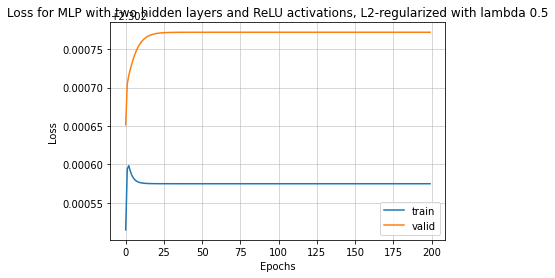

In [ ]:
plt.clf()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss for MLP with two hidden layers and ReLU activations, L2-regularized with lambda 0.5")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

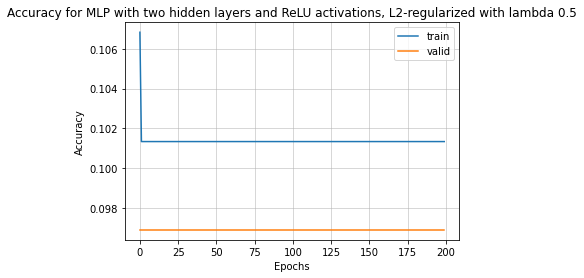

In [ ]:
plt.clf()
plt.plot(train_acc_list, label='train')
plt.plot(val_acc_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy for MLP with two hidden layers and ReLU activations, L2-regularized with lambda 0.5")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
y_test_probs = mlp_two_hidden_l2_0_5.predict(x_test, is_test=True)

test_loss = EvaluationUtils.calculate_ce_loss(y_test_probs, y_test)
test_acc = EvaluationUtils.calculate_multi_accuracy(y_test_probs, y_test)

print("Test loss: {}".format(test_loss))
print("Test accuracy: {}".format(test_acc))

Test loss: 2.3025787393215107
Test accuracy: 0.1


#### L2 regularization with lambda 0.5, more hidden layers and units

Since the model with $\lambda$ = 0.5 performed extremely poorly, let's try adding layers and hidden units to see if it makes a difference. Let's have 3 hidden layers with 256 units each, while keeping ReLU activations.

In [ ]:
mlp_three_hidden_l2_0_5 = MLP(
    LinearLayer(n_features, 2*HIDDEN_SIZE, l2_lambda=0.5),
    ReLULayer(),
    LinearLayer(2*HIDDEN_SIZE, 2*HIDDEN_SIZE, l2_lambda=0.5),
    ReLULayer(),
    LinearLayer(2*HIDDEN_SIZE, 2*HIDDEN_SIZE, l2_lambda=0.5),
    ReLULayer(),
    LinearLayer(2*HIDDEN_SIZE, FASHION_MNIST_N_CLASSES, l2_lambda=0.5),
    SoftmaxOutputLayer()
)

opt_three_hidden_l2_0_5 = GradientDescentOptimizer(mlp_three_hidden_l2_0_5, MLP_LR)
train_loss_list, val_loss_list, train_acc_list, val_acc_list = mlp_three_hidden_l2_0_5.fit(opt_three_hidden_l2_0_5, x_train, y_train, x_val, y_val,
                                                                                  batch_size=MLP_BATCH_SIZE, epochs=MLP_EPOCHS)

  0%|          | 1/200 [00:03<10:45,  3.24s/it]

Epoch: 1, train loss: 2.3026402045741277, train acc: 0.09935714285714295, val loss: 2.3025946845150305, val acc: 0.1015


  1%|          | 2/200 [00:06<10:40,  3.24s/it]

Epoch: 2, train loss: 2.3026182667427713, train acc: 0.0990000000000001, val loss: 2.3026196891017623, val acc: 0.1015


  2%|▏         | 3/200 [00:09<10:38,  3.24s/it]

Epoch: 3, train loss: 2.302603942655338, train acc: 0.10066666666666657, val loss: 2.3026428549435196, val acc: 0.09688888888888889


  2%|▏         | 4/200 [00:12<10:34,  3.24s/it]

Epoch: 4, train loss: 2.30259418697376, train acc: 0.10133333333333325, val loss: 2.302663591638868, val acc: 0.09688888888888889


  2%|▎         | 5/200 [00:16<10:32,  3.24s/it]

Epoch: 5, train loss: 2.302587672452437, train acc: 0.10133333333333325, val loss: 2.3026816833355657, val acc: 0.09688888888888889


  3%|▎         | 6/200 [00:19<10:28,  3.24s/it]

Epoch: 6, train loss: 2.3025833587595774, train acc: 0.10133333333333325, val loss: 2.302697185220244, val acc: 0.09688888888888889


  4%|▎         | 7/200 [00:22<10:24,  3.24s/it]

Epoch: 7, train loss: 2.3025805127780625, train acc: 0.10133333333333325, val loss: 2.3027102982373324, val acc: 0.09688888888888889


  4%|▍         | 8/200 [00:25<10:22,  3.24s/it]

Epoch: 8, train loss: 2.302578638015745, train acc: 0.10133333333333325, val loss: 2.302721286659117, val acc: 0.09688888888888889


  4%|▍         | 9/200 [00:29<10:19,  3.24s/it]

Epoch: 9, train loss: 2.3025774037823767, train acc: 0.10133333333333325, val loss: 2.302730430119935, val acc: 0.09688888888888889


  5%|▌         | 10/200 [00:32<10:16,  3.25s/it]

Epoch: 10, train loss: 2.302576591386571, train acc: 0.10133333333333325, val loss: 2.302737997658477, val acc: 0.09688888888888889


  6%|▌         | 11/200 [00:35<10:14,  3.25s/it]

Epoch: 11, train loss: 2.302576056646918, train acc: 0.10133333333333325, val loss: 2.302744234942471, val acc: 0.09688888888888889


  6%|▌         | 12/200 [00:38<10:09,  3.24s/it]

Epoch: 12, train loss: 2.3025757046292985, train acc: 0.10133333333333325, val loss: 2.30274935914969, val acc: 0.09688888888888889


  6%|▋         | 13/200 [00:42<10:06,  3.24s/it]

Epoch: 13, train loss: 2.302575472858363, train acc: 0.10133333333333325, val loss: 2.302753558159237, val acc: 0.09688888888888889


  7%|▋         | 14/200 [00:45<10:01,  3.24s/it]

Epoch: 14, train loss: 2.3025753202267305, train acc: 0.10133333333333325, val loss: 2.302756992047598, val acc: 0.09688888888888889


  8%|▊         | 15/200 [00:48<09:58,  3.24s/it]

Epoch: 15, train loss: 2.302575219687014, train acc: 0.10133333333333325, val loss: 2.302759795697934, val acc: 0.09688888888888889


  8%|▊         | 16/200 [00:51<09:55,  3.24s/it]

Epoch: 16, train loss: 2.3025751534416763, train acc: 0.10133333333333325, val loss: 2.302762081826651, val acc: 0.09688888888888889


  8%|▊         | 17/200 [00:55<09:53,  3.24s/it]

Epoch: 17, train loss: 2.3025751097784264, train acc: 0.10133333333333325, val loss: 2.3027639440337158, val acc: 0.09688888888888889


  9%|▉         | 18/200 [00:58<09:49,  3.24s/it]

Epoch: 18, train loss: 2.3025750809884795, train acc: 0.10133333333333325, val loss: 2.3027654596671163, val acc: 0.09688888888888889


 10%|▉         | 19/200 [01:01<09:46,  3.24s/it]

Epoch: 19, train loss: 2.3025750619972087, train acc: 0.10133333333333325, val loss: 2.30276669240242, val acc: 0.09688888888888889


 10%|█         | 20/200 [01:04<09:43,  3.24s/it]

Epoch: 20, train loss: 2.3025750494633908, train acc: 0.10133333333333325, val loss: 2.3027676945032898, val acc: 0.09688888888888889


 10%|█         | 21/200 [01:08<09:39,  3.24s/it]

Epoch: 21, train loss: 2.3025750411865937, train acc: 0.10133333333333325, val loss: 2.302768508765519, val acc: 0.09688888888888889


 11%|█         | 22/200 [01:11<09:36,  3.24s/it]

Epoch: 22, train loss: 2.3025750357173047, train acc: 0.10133333333333325, val loss: 2.302769170166458, val acc: 0.09688888888888889


 12%|█▏        | 23/200 [01:14<09:32,  3.24s/it]

Epoch: 23, train loss: 2.3025750321003797, train acc: 0.10133333333333325, val loss: 2.302769707250581, val acc: 0.09688888888888889


 12%|█▏        | 24/200 [01:17<09:29,  3.23s/it]

Epoch: 24, train loss: 2.302575029706227, train acc: 0.10133333333333325, val loss: 2.302770143284678, val acc: 0.09688888888888889


 12%|█▎        | 25/200 [01:20<09:26,  3.24s/it]

Epoch: 25, train loss: 2.302575028119677, train acc: 0.10133333333333325, val loss: 2.3027704972154233, val acc: 0.09688888888888889


 13%|█▎        | 26/200 [01:24<09:23,  3.24s/it]

Epoch: 26, train loss: 2.3025750270668315, train acc: 0.10133333333333325, val loss: 2.302770784459599, val acc: 0.09688888888888889


 14%|█▎        | 27/200 [01:27<09:20,  3.24s/it]

Epoch: 27, train loss: 2.302575026366911, train acc: 0.10133333333333325, val loss: 2.3027710175539284, val acc: 0.09688888888888889


 14%|█▍        | 28/200 [01:30<09:17,  3.24s/it]

Epoch: 28, train loss: 2.302575025900518, train acc: 0.10133333333333325, val loss: 2.302771206687999, val acc: 0.09688888888888889


 14%|█▍        | 29/200 [01:33<09:14,  3.24s/it]

Epoch: 29, train loss: 2.302575025588757, train acc: 0.10133333333333325, val loss: 2.302771360140341, val acc: 0.09688888888888889


 15%|█▌        | 30/200 [01:37<09:10,  3.24s/it]

Epoch: 30, train loss: 2.3025750253794515, train acc: 0.10133333333333325, val loss: 2.3027714846346523, val acc: 0.09688888888888889


 16%|█▌        | 31/200 [01:40<09:06,  3.24s/it]

Epoch: 31, train loss: 2.302575025238068, train acc: 0.10133333333333325, val loss: 2.3027715856303774, val acc: 0.09688888888888889


 16%|█▌        | 32/200 [01:43<09:03,  3.23s/it]

Epoch: 32, train loss: 2.302575025141736, train acc: 0.10133333333333325, val loss: 2.3027716675594823, val acc: 0.09688888888888889


 16%|█▋        | 33/200 [01:46<09:00,  3.24s/it]

Epoch: 33, train loss: 2.302575025075296, train acc: 0.10133333333333325, val loss: 2.302771734019209, val acc: 0.09688888888888889


 17%|█▋        | 34/200 [01:50<08:57,  3.24s/it]

Epoch: 34, train loss: 2.3025750250286876, train acc: 0.10133333333333325, val loss: 2.3027717879288807, val acc: 0.09688888888888889


 18%|█▊        | 35/200 [01:53<08:54,  3.24s/it]

Epoch: 35, train loss: 2.3025750249952326, train acc: 0.10133333333333325, val loss: 2.302771831657396, val acc: 0.09688888888888889


 18%|█▊        | 36/200 [01:56<08:50,  3.24s/it]

Epoch: 36, train loss: 2.3025750249704933, train acc: 0.10133333333333325, val loss: 2.3027718671268365, val acc: 0.09688888888888889


 18%|█▊        | 37/200 [01:59<08:48,  3.24s/it]

Epoch: 37, train loss: 2.3025750249515156, train acc: 0.10133333333333325, val loss: 2.3027718958966252, val acc: 0.09688888888888889


 19%|█▉        | 38/200 [02:03<08:44,  3.24s/it]

Epoch: 38, train loss: 2.3025750249363304, train acc: 0.10133333333333325, val loss: 2.302771919231885, val acc: 0.09688888888888889


 20%|█▉        | 39/200 [02:06<08:42,  3.24s/it]

Epoch: 39, train loss: 2.302575024923643, train acc: 0.10133333333333325, val loss: 2.302771938158928, val acc: 0.09688888888888889


 20%|██        | 40/200 [02:09<08:38,  3.24s/it]

Epoch: 40, train loss: 2.3025750249125787, train acc: 0.10133333333333325, val loss: 2.302771953510303, val acc: 0.09688888888888889


 20%|██        | 41/200 [02:12<08:35,  3.24s/it]

Epoch: 41, train loss: 2.302575024902558, train acc: 0.10133333333333325, val loss: 2.3027719659613575, val acc: 0.09688888888888889


 21%|██        | 42/200 [02:16<08:32,  3.24s/it]

Epoch: 42, train loss: 2.3025750248931973, train acc: 0.10133333333333325, val loss: 2.302771976059909, val acc: 0.09688888888888889


 22%|██▏       | 43/200 [02:19<08:28,  3.24s/it]

Epoch: 43, train loss: 2.3025750248842485, train acc: 0.10133333333333325, val loss: 2.302771984250314, val acc: 0.09688888888888889


 22%|██▏       | 44/200 [02:22<08:25,  3.24s/it]

Epoch: 44, train loss: 2.302575024875541, train acc: 0.10133333333333325, val loss: 2.3027719908930067, val acc: 0.09688888888888889


 22%|██▎       | 45/200 [02:25<08:21,  3.24s/it]

Epoch: 45, train loss: 2.302575024866971, train acc: 0.10133333333333325, val loss: 2.302771996280343, val acc: 0.09688888888888889


 23%|██▎       | 46/200 [02:29<08:19,  3.24s/it]

Epoch: 46, train loss: 2.302575024858467, train acc: 0.10133333333333325, val loss: 2.302772000649457, val acc: 0.09688888888888889


 24%|██▎       | 47/200 [02:32<08:15,  3.24s/it]

Epoch: 47, train loss: 2.302575024849982, train acc: 0.10133333333333325, val loss: 2.3027720041926907, val acc: 0.09688888888888889


 24%|██▍       | 48/200 [02:35<08:12,  3.24s/it]

Epoch: 48, train loss: 2.302575024841493, train acc: 0.10133333333333325, val loss: 2.302772007066054, val acc: 0.09688888888888889


 24%|██▍       | 49/200 [02:38<08:09,  3.24s/it]

Epoch: 49, train loss: 2.302575024832987, train acc: 0.10133333333333325, val loss: 2.3027720093960866, val acc: 0.09688888888888889


 25%|██▌       | 50/200 [02:42<08:06,  3.24s/it]

Epoch: 50, train loss: 2.302575024824446, train acc: 0.10133333333333325, val loss: 2.3027720112854237, val acc: 0.09688888888888889


 26%|██▌       | 51/200 [02:45<08:02,  3.24s/it]

Epoch: 51, train loss: 2.3025750248158765, train acc: 0.10133333333333325, val loss: 2.3027720128173144, val acc: 0.09688888888888889


 26%|██▌       | 52/200 [02:48<08:08,  3.30s/it]

Epoch: 52, train loss: 2.302575024807272, train acc: 0.10133333333333325, val loss: 2.30277201405928, val acc: 0.09688888888888889


 26%|██▋       | 53/200 [02:52<08:21,  3.41s/it]

Epoch: 53, train loss: 2.302575024798635, train acc: 0.10133333333333325, val loss: 2.302772015066088, val acc: 0.09688888888888889


 27%|██▋       | 54/200 [02:55<08:09,  3.36s/it]

Epoch: 54, train loss: 2.3025750247899692, train acc: 0.10133333333333325, val loss: 2.3027720158821596, val acc: 0.09688888888888889


 28%|██▊       | 55/200 [02:58<08:01,  3.32s/it]

Epoch: 55, train loss: 2.302575024781276, train acc: 0.10133333333333325, val loss: 2.302772016543525, val acc: 0.09688888888888889


 28%|██▊       | 56/200 [03:02<07:54,  3.30s/it]

Epoch: 56, train loss: 2.3025750247725583, train acc: 0.10133333333333325, val loss: 2.3027720170794073, val acc: 0.09688888888888889


 28%|██▊       | 57/200 [03:05<07:49,  3.28s/it]

Epoch: 57, train loss: 2.3025750247638186, train acc: 0.10133333333333325, val loss: 2.30277201751351, val acc: 0.09688888888888889


 29%|██▉       | 58/200 [03:08<07:43,  3.27s/it]

Epoch: 58, train loss: 2.3025750247550576, train acc: 0.10133333333333325, val loss: 2.3027720178650593, val acc: 0.09688888888888889


 30%|██▉       | 59/200 [03:11<07:39,  3.26s/it]

Epoch: 59, train loss: 2.302575024746282, train acc: 0.10133333333333325, val loss: 2.302772018149648, val acc: 0.09688888888888889


 30%|███       | 60/200 [03:15<07:35,  3.25s/it]

Epoch: 60, train loss: 2.3025750247374948, train acc: 0.10133333333333325, val loss: 2.302772018379926, val acc: 0.09688888888888889


 30%|███       | 61/200 [03:18<07:31,  3.25s/it]

Epoch: 61, train loss: 2.3025750247286925, train acc: 0.10133333333333325, val loss: 2.302772018566151, val acc: 0.09688888888888889


 31%|███       | 62/200 [03:21<07:27,  3.25s/it]

Epoch: 62, train loss: 2.3025750247198817, train acc: 0.10133333333333325, val loss: 2.3027720187166443, val acc: 0.09688888888888889


 32%|███▏      | 63/200 [03:24<07:25,  3.25s/it]

Epoch: 63, train loss: 2.3025750247110617, train acc: 0.10133333333333325, val loss: 2.3027720188381555, val acc: 0.09688888888888889


 32%|███▏      | 64/200 [03:27<07:21,  3.25s/it]

Epoch: 64, train loss: 2.3025750247022305, train acc: 0.10133333333333325, val loss: 2.3027720189361593, val acc: 0.09688888888888889


 32%|███▎      | 65/200 [03:31<07:18,  3.24s/it]

Epoch: 65, train loss: 2.302575024693399, train acc: 0.10133333333333325, val loss: 2.3027720190150958, val acc: 0.09688888888888889


 33%|███▎      | 66/200 [03:34<07:14,  3.24s/it]

Epoch: 66, train loss: 2.3025750246845593, train acc: 0.10133333333333325, val loss: 2.3027720190785663, val acc: 0.09688888888888889


 34%|███▎      | 67/200 [03:37<07:11,  3.25s/it]

Epoch: 67, train loss: 2.302575024675716, train acc: 0.10133333333333325, val loss: 2.302772019129492, val acc: 0.09688888888888889


 34%|███▍      | 68/200 [03:40<07:09,  3.25s/it]

Epoch: 68, train loss: 2.3025750246668686, train acc: 0.10133333333333325, val loss: 2.3027720191702428, val acc: 0.09688888888888889


 34%|███▍      | 69/200 [03:44<07:05,  3.25s/it]

Epoch: 69, train loss: 2.3025750246580206, train acc: 0.10133333333333325, val loss: 2.3027720192027403, val acc: 0.09688888888888889


 35%|███▌      | 70/200 [03:47<07:01,  3.24s/it]

Epoch: 70, train loss: 2.302575024649166, train acc: 0.10133333333333325, val loss: 2.3027720192285437, val acc: 0.09688888888888889


 36%|███▌      | 71/200 [03:50<06:58,  3.24s/it]

Epoch: 71, train loss: 2.3025750246403134, train acc: 0.10133333333333325, val loss: 2.3027720192489167, val acc: 0.09688888888888889


 36%|███▌      | 72/200 [03:53<06:54,  3.24s/it]

Epoch: 72, train loss: 2.302575024631457, train acc: 0.10133333333333325, val loss: 2.3027720192648857, val acc: 0.09688888888888889


 36%|███▋      | 73/200 [03:57<06:51,  3.24s/it]

Epoch: 73, train loss: 2.302575024622601, train acc: 0.10133333333333325, val loss: 2.3027720192772825, val acc: 0.09688888888888889


 37%|███▋      | 74/200 [04:00<06:48,  3.25s/it]

Epoch: 74, train loss: 2.3025750246137426, train acc: 0.10133333333333325, val loss: 2.3027720192867815, val acc: 0.09688888888888889


 38%|███▊      | 75/200 [04:03<06:46,  3.25s/it]

Epoch: 75, train loss: 2.3025750246048844, train acc: 0.10133333333333325, val loss: 2.30277201929393, val acc: 0.09688888888888889


 38%|███▊      | 76/200 [04:06<06:42,  3.25s/it]

Epoch: 76, train loss: 2.302575024596026, train acc: 0.10133333333333325, val loss: 2.3027720192991725, val acc: 0.09688888888888889


 38%|███▊      | 77/200 [04:10<06:38,  3.24s/it]

Epoch: 77, train loss: 2.3025750245871657, train acc: 0.10133333333333325, val loss: 2.3027720193028687, val acc: 0.09688888888888889


 39%|███▉      | 78/200 [04:13<06:35,  3.24s/it]

Epoch: 78, train loss: 2.3025750245783105, train acc: 0.10133333333333325, val loss: 2.3027720193053103, val acc: 0.09688888888888889


 40%|███▉      | 79/200 [04:16<06:32,  3.24s/it]

Epoch: 79, train loss: 2.3025750245694505, train acc: 0.10133333333333325, val loss: 2.302772019306735, val acc: 0.09688888888888889


 40%|████      | 80/200 [04:19<06:28,  3.24s/it]

Epoch: 80, train loss: 2.3025750245605936, train acc: 0.10133333333333325, val loss: 2.3027720193073344, val acc: 0.09688888888888889


 40%|████      | 81/200 [04:23<06:25,  3.24s/it]

Epoch: 81, train loss: 2.3025750245517345, train acc: 0.10133333333333325, val loss: 2.3027720193072647, val acc: 0.09688888888888889


 41%|████      | 82/200 [04:26<06:21,  3.24s/it]

Epoch: 82, train loss: 2.302575024542875, train acc: 0.10133333333333325, val loss: 2.3027720193066523, val acc: 0.09688888888888889


 42%|████▏     | 83/200 [04:29<06:18,  3.23s/it]

Epoch: 83, train loss: 2.3025750245340197, train acc: 0.10133333333333325, val loss: 2.3027720193055994, val acc: 0.09688888888888889


 42%|████▏     | 84/200 [04:32<06:15,  3.24s/it]

Epoch: 84, train loss: 2.3025750245251615, train acc: 0.10133333333333325, val loss: 2.3027720193041894, val acc: 0.09688888888888889


 42%|████▎     | 85/200 [04:36<06:12,  3.24s/it]

Epoch: 85, train loss: 2.3025750245163064, train acc: 0.10133333333333325, val loss: 2.3027720193024903, val acc: 0.09688888888888889


 43%|████▎     | 86/200 [04:39<06:08,  3.24s/it]

Epoch: 86, train loss: 2.3025750245074517, train acc: 0.10133333333333325, val loss: 2.302772019300556, val acc: 0.09688888888888889


 44%|████▎     | 87/200 [04:42<06:05,  3.23s/it]

Epoch: 87, train loss: 2.3025750244985947, train acc: 0.10133333333333325, val loss: 2.302772019298431, val acc: 0.09688888888888889


 44%|████▍     | 88/200 [04:45<06:02,  3.23s/it]

Epoch: 88, train loss: 2.3025750244897423, train acc: 0.10133333333333325, val loss: 2.3027720192961523, val acc: 0.09688888888888889


 44%|████▍     | 89/200 [04:48<05:59,  3.23s/it]

Epoch: 89, train loss: 2.3025750244808867, train acc: 0.10133333333333325, val loss: 2.3027720192937475, val acc: 0.09688888888888889


 45%|████▌     | 90/200 [04:52<05:55,  3.24s/it]

Epoch: 90, train loss: 2.302575024472037, train acc: 0.10133333333333325, val loss: 2.3027720192912415, val acc: 0.09688888888888889


 46%|████▌     | 91/200 [04:55<05:52,  3.23s/it]

Epoch: 91, train loss: 2.302575024463182, train acc: 0.10133333333333325, val loss: 2.302772019288653, val acc: 0.09688888888888889


 46%|████▌     | 92/200 [04:58<05:49,  3.24s/it]

Epoch: 92, train loss: 2.3025750244543297, train acc: 0.10133333333333325, val loss: 2.302772019285998, val acc: 0.09688888888888889


 46%|████▋     | 93/200 [05:01<05:46,  3.24s/it]

Epoch: 93, train loss: 2.3025750244454755, train acc: 0.10133333333333325, val loss: 2.302772019283289, val acc: 0.09688888888888889


 47%|████▋     | 94/200 [05:05<05:43,  3.24s/it]

Epoch: 94, train loss: 2.302575024436626, train acc: 0.10133333333333325, val loss: 2.302772019280536, val acc: 0.09688888888888889


 48%|████▊     | 95/200 [05:08<05:39,  3.23s/it]

Epoch: 95, train loss: 2.3025750244277776, train acc: 0.10133333333333325, val loss: 2.3027720192777474, val acc: 0.09688888888888889


 48%|████▊     | 96/200 [05:11<05:36,  3.24s/it]

Epoch: 96, train loss: 2.302575024418926, train acc: 0.10133333333333325, val loss: 2.3027720192749306, val acc: 0.09688888888888889


 48%|████▊     | 97/200 [05:14<05:33,  3.24s/it]

Epoch: 97, train loss: 2.302575024410079, train acc: 0.10133333333333325, val loss: 2.3027720192720897, val acc: 0.09688888888888889


 49%|████▉     | 98/200 [05:18<05:30,  3.24s/it]

Epoch: 98, train loss: 2.3025750244012317, train acc: 0.10133333333333325, val loss: 2.3027720192692307, val acc: 0.09688888888888889


 50%|████▉     | 99/200 [05:21<05:27,  3.24s/it]

Epoch: 99, train loss: 2.302575024392382, train acc: 0.10133333333333325, val loss: 2.302772019266356, val acc: 0.09688888888888889


 50%|█████     | 100/200 [05:24<05:23,  3.24s/it]

Epoch: 100, train loss: 2.3025750243835343, train acc: 0.10133333333333325, val loss: 2.302772019263469, val acc: 0.09688888888888889


 50%|█████     | 101/200 [05:27<05:21,  3.25s/it]

Epoch: 101, train loss: 2.30257502437469, train acc: 0.10133333333333325, val loss: 2.3027720192605723, val acc: 0.09688888888888889


 51%|█████     | 102/200 [05:31<05:18,  3.25s/it]

Epoch: 102, train loss: 2.3025750243658445, train acc: 0.10133333333333325, val loss: 2.3027720192576675, val acc: 0.09688888888888889


 52%|█████▏    | 103/200 [05:34<05:14,  3.25s/it]

Epoch: 103, train loss: 2.3025750243569982, train acc: 0.10133333333333325, val loss: 2.302772019254756, val acc: 0.09688888888888889


 52%|█████▏    | 104/200 [05:37<05:11,  3.24s/it]

Epoch: 104, train loss: 2.3025750243481573, train acc: 0.10133333333333325, val loss: 2.3027720192518393, val acc: 0.09688888888888889


 52%|█████▎    | 105/200 [05:40<05:07,  3.24s/it]

Epoch: 105, train loss: 2.302575024339312, train acc: 0.10133333333333325, val loss: 2.3027720192489185, val acc: 0.09688888888888889


 53%|█████▎    | 106/200 [05:44<05:04,  3.24s/it]

Epoch: 106, train loss: 2.302575024330469, train acc: 0.10133333333333325, val loss: 2.3027720192459946, val acc: 0.09688888888888889


 54%|█████▎    | 107/200 [05:47<05:01,  3.24s/it]

Epoch: 107, train loss: 2.3025750243216265, train acc: 0.10133333333333325, val loss: 2.302772019243068, val acc: 0.09688888888888889


 54%|█████▍    | 108/200 [05:50<04:57,  3.24s/it]

Epoch: 108, train loss: 2.3025750243127865, train acc: 0.10133333333333325, val loss: 2.3027720192401393, val acc: 0.09688888888888889


 55%|█████▍    | 109/200 [05:53<04:54,  3.24s/it]

Epoch: 109, train loss: 2.3025750243039473, train acc: 0.10133333333333325, val loss: 2.302772019237208, val acc: 0.09688888888888889


 55%|█████▌    | 110/200 [05:57<04:51,  3.24s/it]

Epoch: 110, train loss: 2.302575024295104, train acc: 0.10133333333333325, val loss: 2.3027720192342764, val acc: 0.09688888888888889


 56%|█████▌    | 111/200 [06:00<04:48,  3.24s/it]

Epoch: 111, train loss: 2.3025750242862664, train acc: 0.10133333333333325, val loss: 2.3027720192313437, val acc: 0.09688888888888889


 56%|█████▌    | 112/200 [06:03<04:45,  3.24s/it]

Epoch: 112, train loss: 2.3025750242774286, train acc: 0.10133333333333325, val loss: 2.3027720192284096, val acc: 0.09688888888888889


 56%|█████▋    | 113/200 [06:06<04:41,  3.24s/it]

Epoch: 113, train loss: 2.302575024268589, train acc: 0.10133333333333325, val loss: 2.3027720192254755, val acc: 0.09688888888888889


 57%|█████▋    | 114/200 [06:10<04:39,  3.25s/it]

Epoch: 114, train loss: 2.3025750242597547, train acc: 0.10133333333333325, val loss: 2.302772019222541, val acc: 0.09688888888888889


 57%|█████▊    | 115/200 [06:13<04:35,  3.24s/it]

Epoch: 115, train loss: 2.302575024250916, train acc: 0.10133333333333325, val loss: 2.302772019219606, val acc: 0.09688888888888889


 58%|█████▊    | 116/200 [06:16<04:32,  3.24s/it]

Epoch: 116, train loss: 2.3025750242420804, train acc: 0.10133333333333325, val loss: 2.3027720192166705, val acc: 0.09688888888888889


 58%|█████▊    | 117/200 [06:19<04:29,  3.24s/it]

Epoch: 117, train loss: 2.3025750242332452, train acc: 0.10133333333333325, val loss: 2.302772019213735, val acc: 0.09688888888888889


 59%|█████▉    | 118/200 [06:22<04:25,  3.24s/it]

Epoch: 118, train loss: 2.3025750242244096, train acc: 0.10133333333333325, val loss: 2.3027720192107997, val acc: 0.09688888888888889


 60%|█████▉    | 119/200 [06:26<04:22,  3.24s/it]

Epoch: 119, train loss: 2.3025750242155776, train acc: 0.10133333333333325, val loss: 2.3027720192078642, val acc: 0.09688888888888889


 60%|██████    | 120/200 [06:29<04:19,  3.24s/it]

Epoch: 120, train loss: 2.3025750242067424, train acc: 0.10133333333333325, val loss: 2.3027720192049284, val acc: 0.09688888888888889


 60%|██████    | 121/200 [06:32<04:16,  3.24s/it]

Epoch: 121, train loss: 2.302575024197912, train acc: 0.10133333333333325, val loss: 2.3027720192019934, val acc: 0.09688888888888889


 61%|██████    | 122/200 [06:35<04:12,  3.24s/it]

Epoch: 122, train loss: 2.302575024189079, train acc: 0.10133333333333325, val loss: 2.3027720191990584, val acc: 0.09688888888888889


 62%|██████▏   | 123/200 [06:39<04:09,  3.24s/it]

Epoch: 123, train loss: 2.3025750241802494, train acc: 0.10133333333333325, val loss: 2.302772019196123, val acc: 0.09688888888888889


 62%|██████▏   | 124/200 [06:42<04:06,  3.24s/it]

Epoch: 124, train loss: 2.30257502417142, train acc: 0.10133333333333325, val loss: 2.3027720191931884, val acc: 0.09688888888888889


 62%|██████▎   | 125/200 [06:45<04:02,  3.24s/it]

Epoch: 125, train loss: 2.3025750241625897, train acc: 0.10133333333333325, val loss: 2.3027720191902534, val acc: 0.09688888888888889


 63%|██████▎   | 126/200 [06:48<03:59,  3.24s/it]

Epoch: 126, train loss: 2.3025750241537604, train acc: 0.10133333333333325, val loss: 2.302772019187319, val acc: 0.09688888888888889


 64%|██████▎   | 127/200 [06:52<03:56,  3.24s/it]

Epoch: 127, train loss: 2.3025750241449296, train acc: 0.10133333333333325, val loss: 2.302772019184384, val acc: 0.09688888888888889


 64%|██████▍   | 128/200 [06:55<03:55,  3.27s/it]

Epoch: 128, train loss: 2.3025750241361043, train acc: 0.10133333333333325, val loss: 2.3027720191814502, val acc: 0.09688888888888889


 64%|██████▍   | 129/200 [06:58<03:51,  3.26s/it]

Epoch: 129, train loss: 2.302575024127278, train acc: 0.10133333333333325, val loss: 2.302772019178516, val acc: 0.09688888888888889


 65%|██████▌   | 130/200 [07:01<03:47,  3.25s/it]

Epoch: 130, train loss: 2.3025750241184504, train acc: 0.10133333333333325, val loss: 2.302772019175582, val acc: 0.09688888888888889


 66%|██████▌   | 131/200 [07:05<03:44,  3.25s/it]

Epoch: 131, train loss: 2.3025750241096254, train acc: 0.10133333333333325, val loss: 2.3027720191726484, val acc: 0.09688888888888889


 66%|██████▌   | 132/200 [07:08<03:40,  3.24s/it]

Epoch: 132, train loss: 2.302575024100802, train acc: 0.10133333333333325, val loss: 2.3027720191697147, val acc: 0.09688888888888889


 66%|██████▋   | 133/200 [07:11<03:37,  3.25s/it]

Epoch: 133, train loss: 2.302575024091976, train acc: 0.10133333333333325, val loss: 2.302772019166782, val acc: 0.09688888888888889


 67%|██████▋   | 134/200 [07:14<03:34,  3.25s/it]

Epoch: 134, train loss: 2.3025750240831533, train acc: 0.10133333333333325, val loss: 2.3027720191638488, val acc: 0.09688888888888889


 68%|██████▊   | 135/200 [07:18<03:30,  3.25s/it]

Epoch: 135, train loss: 2.3025750240743306, train acc: 0.10133333333333325, val loss: 2.3027720191609165, val acc: 0.09688888888888889


 68%|██████▊   | 136/200 [07:21<03:27,  3.24s/it]

Epoch: 136, train loss: 2.3025750240655083, train acc: 0.10133333333333325, val loss: 2.3027720191579832, val acc: 0.09688888888888889


 68%|██████▊   | 137/200 [07:24<03:23,  3.24s/it]

Epoch: 137, train loss: 2.302575024056687, train acc: 0.10133333333333325, val loss: 2.302772019155051, val acc: 0.09688888888888889


 69%|██████▉   | 138/200 [07:27<03:20,  3.24s/it]

Epoch: 138, train loss: 2.3025750240478695, train acc: 0.10133333333333325, val loss: 2.302772019152119, val acc: 0.09688888888888889


 70%|██████▉   | 139/200 [07:31<03:17,  3.24s/it]

Epoch: 139, train loss: 2.302575024039045, train acc: 0.10133333333333325, val loss: 2.3027720191491876, val acc: 0.09688888888888889


 70%|███████   | 140/200 [07:34<03:14,  3.24s/it]

Epoch: 140, train loss: 2.302575024030227, train acc: 0.10133333333333325, val loss: 2.302772019146256, val acc: 0.09688888888888889


 70%|███████   | 141/200 [07:37<03:10,  3.23s/it]

Epoch: 141, train loss: 2.3025750240214093, train acc: 0.10133333333333325, val loss: 2.302772019143324, val acc: 0.09688888888888889


 71%|███████   | 142/200 [07:40<03:07,  3.24s/it]

Epoch: 142, train loss: 2.30257502401259, train acc: 0.10133333333333325, val loss: 2.3027720191403933, val acc: 0.09688888888888889


 72%|███████▏  | 143/200 [07:44<03:05,  3.25s/it]

Epoch: 143, train loss: 2.30257502400377, train acc: 0.10133333333333325, val loss: 2.302772019137462, val acc: 0.09688888888888889


 72%|███████▏  | 144/200 [07:47<03:01,  3.24s/it]

Epoch: 144, train loss: 2.3025750239949576, train acc: 0.10133333333333325, val loss: 2.3027720191345313, val acc: 0.09688888888888889


 72%|███████▎  | 145/200 [07:50<02:58,  3.24s/it]

Epoch: 145, train loss: 2.3025750239861402, train acc: 0.10133333333333325, val loss: 2.3027720191316012, val acc: 0.09688888888888889


 73%|███████▎  | 146/200 [07:53<02:58,  3.31s/it]

Epoch: 146, train loss: 2.302575023977326, train acc: 0.10133333333333325, val loss: 2.3027720191286702, val acc: 0.09688888888888889


 74%|███████▎  | 147/200 [07:57<02:58,  3.37s/it]

Epoch: 147, train loss: 2.302575023968512, train acc: 0.10133333333333325, val loss: 2.30277201912574, val acc: 0.09688888888888889


 74%|███████▍  | 148/200 [08:00<02:53,  3.33s/it]

Epoch: 148, train loss: 2.3025750239596965, train acc: 0.10133333333333325, val loss: 2.302772019122811, val acc: 0.09688888888888889


 74%|███████▍  | 149/200 [08:04<02:48,  3.31s/it]

Epoch: 149, train loss: 2.302575023950884, train acc: 0.10133333333333325, val loss: 2.3027720191198813, val acc: 0.09688888888888889


 75%|███████▌  | 150/200 [08:07<02:44,  3.29s/it]

Epoch: 150, train loss: 2.3025750239420746, train acc: 0.10133333333333325, val loss: 2.3027720191169516, val acc: 0.09688888888888889


 76%|███████▌  | 151/200 [08:10<02:40,  3.27s/it]

Epoch: 151, train loss: 2.3025750239332603, train acc: 0.10133333333333325, val loss: 2.302772019114023, val acc: 0.09688888888888889


 76%|███████▌  | 152/200 [08:13<02:36,  3.26s/it]

Epoch: 152, train loss: 2.3025750239244482, train acc: 0.10133333333333325, val loss: 2.3027720191110936, val acc: 0.09688888888888889


 76%|███████▋  | 153/200 [08:16<02:32,  3.25s/it]

Epoch: 153, train loss: 2.302575023915637, train acc: 0.10133333333333325, val loss: 2.302772019108165, val acc: 0.09688888888888889


 77%|███████▋  | 154/200 [08:20<02:29,  3.25s/it]

Epoch: 154, train loss: 2.302575023906827, train acc: 0.10133333333333325, val loss: 2.3027720191052365, val acc: 0.09688888888888889


 78%|███████▊  | 155/200 [08:23<02:25,  3.24s/it]

Epoch: 155, train loss: 2.30257502389802, train acc: 0.10133333333333325, val loss: 2.3027720191023087, val acc: 0.09688888888888889


 78%|███████▊  | 156/200 [08:26<02:22,  3.25s/it]

Epoch: 156, train loss: 2.3025750238892124, train acc: 0.10133333333333325, val loss: 2.3027720190993803, val acc: 0.09688888888888889


 78%|███████▊  | 157/200 [08:29<02:19,  3.25s/it]

Epoch: 157, train loss: 2.3025750238804052, train acc: 0.10133333333333325, val loss: 2.302772019096452, val acc: 0.09688888888888889


 79%|███████▉  | 158/200 [08:33<02:16,  3.24s/it]

Epoch: 158, train loss: 2.302575023871597, train acc: 0.10133333333333325, val loss: 2.302772019093525, val acc: 0.09688888888888889


 80%|███████▉  | 159/200 [08:36<02:12,  3.24s/it]

Epoch: 159, train loss: 2.302575023862792, train acc: 0.10133333333333325, val loss: 2.302772019090598, val acc: 0.09688888888888889


 80%|████████  | 160/200 [08:39<02:09,  3.24s/it]

Epoch: 160, train loss: 2.3025750238539855, train acc: 0.10133333333333325, val loss: 2.302772019087671, val acc: 0.09688888888888889


 80%|████████  | 161/200 [08:42<02:06,  3.24s/it]

Epoch: 161, train loss: 2.3025750238451828, train acc: 0.10133333333333325, val loss: 2.302772019084744, val acc: 0.09688888888888889


 81%|████████  | 162/200 [08:46<02:03,  3.24s/it]

Epoch: 162, train loss: 2.3025750238363782, train acc: 0.10133333333333325, val loss: 2.3027720190818175, val acc: 0.09688888888888889


 82%|████████▏ | 163/200 [08:49<01:59,  3.24s/it]

Epoch: 163, train loss: 2.3025750238275715, train acc: 0.10133333333333325, val loss: 2.3027720190788914, val acc: 0.09688888888888889


 82%|████████▏ | 164/200 [08:52<01:56,  3.24s/it]

Epoch: 164, train loss: 2.30257502381877, train acc: 0.10133333333333325, val loss: 2.302772019075965, val acc: 0.09688888888888889


 82%|████████▎ | 165/200 [08:55<01:53,  3.24s/it]

Epoch: 165, train loss: 2.30257502380997, train acc: 0.10133333333333325, val loss: 2.3027720190730387, val acc: 0.09688888888888889


 83%|████████▎ | 166/200 [08:59<01:50,  3.24s/it]

Epoch: 166, train loss: 2.302575023801168, train acc: 0.10133333333333325, val loss: 2.302772019070113, val acc: 0.09688888888888889


 84%|████████▎ | 167/200 [09:02<01:46,  3.24s/it]

Epoch: 167, train loss: 2.3025750237923663, train acc: 0.10133333333333325, val loss: 2.3027720190671874, val acc: 0.09688888888888889


 84%|████████▍ | 168/200 [09:05<01:43,  3.24s/it]

Epoch: 168, train loss: 2.302575023783566, train acc: 0.10133333333333325, val loss: 2.3027720190642627, val acc: 0.09688888888888889


 84%|████████▍ | 169/200 [09:08<01:40,  3.24s/it]

Epoch: 169, train loss: 2.302575023774767, train acc: 0.10133333333333325, val loss: 2.3027720190613374, val acc: 0.09688888888888889


 85%|████████▌ | 170/200 [09:12<01:37,  3.24s/it]

Epoch: 170, train loss: 2.3025750237659683, train acc: 0.10133333333333325, val loss: 2.3027720190584127, val acc: 0.09688888888888889


 86%|████████▌ | 171/200 [09:15<01:34,  3.24s/it]

Epoch: 171, train loss: 2.30257502375717, train acc: 0.10133333333333325, val loss: 2.3027720190554883, val acc: 0.09688888888888889


 86%|████████▌ | 172/200 [09:18<01:30,  3.24s/it]

Epoch: 172, train loss: 2.302575023748374, train acc: 0.10133333333333325, val loss: 2.302772019052564, val acc: 0.09688888888888889


 86%|████████▋ | 173/200 [09:21<01:27,  3.25s/it]

Epoch: 173, train loss: 2.3025750237395775, train acc: 0.10133333333333325, val loss: 2.3027720190496392, val acc: 0.09688888888888889


 87%|████████▋ | 174/200 [09:25<01:24,  3.25s/it]

Epoch: 174, train loss: 2.3025750237307814, train acc: 0.10133333333333325, val loss: 2.3027720190467162, val acc: 0.09688888888888889


 88%|████████▊ | 175/200 [09:28<01:21,  3.24s/it]

Epoch: 175, train loss: 2.3025750237219866, train acc: 0.10133333333333325, val loss: 2.3027720190437924, val acc: 0.09688888888888889


 88%|████████▊ | 176/200 [09:31<01:17,  3.24s/it]

Epoch: 176, train loss: 2.30257502371319, train acc: 0.10133333333333325, val loss: 2.3027720190408685, val acc: 0.09688888888888889


 88%|████████▊ | 177/200 [09:34<01:14,  3.24s/it]

Epoch: 177, train loss: 2.302575023704396, train acc: 0.10133333333333325, val loss: 2.3027720190379455, val acc: 0.09688888888888889


 89%|████████▉ | 178/200 [09:37<01:11,  3.24s/it]

Epoch: 178, train loss: 2.302575023695605, train acc: 0.10133333333333325, val loss: 2.302772019035023, val acc: 0.09688888888888889


 90%|████████▉ | 179/200 [09:41<01:08,  3.24s/it]

Epoch: 179, train loss: 2.3025750236868117, train acc: 0.10133333333333325, val loss: 2.3027720190321, val acc: 0.09688888888888889


 90%|█████████ | 180/200 [09:44<01:04,  3.24s/it]

Epoch: 180, train loss: 2.3025750236780196, train acc: 0.10133333333333325, val loss: 2.3027720190291774, val acc: 0.09688888888888889


 90%|█████████ | 181/200 [09:47<01:01,  3.24s/it]

Epoch: 181, train loss: 2.3025750236692293, train acc: 0.10133333333333325, val loss: 2.3027720190262553, val acc: 0.09688888888888889


 91%|█████████ | 182/200 [09:50<00:58,  3.24s/it]

Epoch: 182, train loss: 2.302575023660439, train acc: 0.10133333333333325, val loss: 2.302772019023333, val acc: 0.09688888888888889


 92%|█████████▏| 183/200 [09:54<00:55,  3.24s/it]

Epoch: 183, train loss: 2.3025750236516465, train acc: 0.10133333333333325, val loss: 2.302772019020411, val acc: 0.09688888888888889


 92%|█████████▏| 184/200 [09:57<00:51,  3.23s/it]

Epoch: 184, train loss: 2.3025750236428606, train acc: 0.10133333333333325, val loss: 2.3027720190174903, val acc: 0.09688888888888889


 92%|█████████▎| 185/200 [10:00<00:48,  3.23s/it]

Epoch: 185, train loss: 2.302575023634072, train acc: 0.10133333333333325, val loss: 2.3027720190145686, val acc: 0.09688888888888889


 93%|█████████▎| 186/200 [10:03<00:45,  3.24s/it]

Epoch: 186, train loss: 2.3025750236252835, train acc: 0.10133333333333325, val loss: 2.3027720190116474, val acc: 0.09688888888888889


 94%|█████████▎| 187/200 [10:07<00:42,  3.24s/it]

Epoch: 187, train loss: 2.3025750236164977, train acc: 0.10133333333333325, val loss: 2.302772019008726, val acc: 0.09688888888888889


 94%|█████████▍| 188/200 [10:10<00:38,  3.24s/it]

Epoch: 188, train loss: 2.30257502360771, train acc: 0.10133333333333325, val loss: 2.3027720190058054, val acc: 0.09688888888888889


 94%|█████████▍| 189/200 [10:13<00:35,  3.24s/it]

Epoch: 189, train loss: 2.3025750235989237, train acc: 0.10133333333333325, val loss: 2.3027720190028855, val acc: 0.09688888888888889


 95%|█████████▌| 190/200 [10:16<00:32,  3.24s/it]

Epoch: 190, train loss: 2.302575023590141, train acc: 0.10133333333333325, val loss: 2.302772018999965, val acc: 0.09688888888888889


 96%|█████████▌| 191/200 [10:20<00:29,  3.24s/it]

Epoch: 191, train loss: 2.3025750235813542, train acc: 0.10133333333333325, val loss: 2.3027720189970453, val acc: 0.09688888888888889


 96%|█████████▌| 192/200 [10:23<00:25,  3.25s/it]

Epoch: 192, train loss: 2.3025750235725715, train acc: 0.10133333333333325, val loss: 2.302772018994125, val acc: 0.09688888888888889


 96%|█████████▋| 193/200 [10:26<00:22,  3.24s/it]

Epoch: 193, train loss: 2.30257502356379, train acc: 0.10133333333333325, val loss: 2.302772018991206, val acc: 0.09688888888888889


 97%|█████████▋| 194/200 [10:29<00:19,  3.24s/it]

Epoch: 194, train loss: 2.302575023555004, train acc: 0.10133333333333325, val loss: 2.3027720189882865, val acc: 0.09688888888888889


 98%|█████████▊| 195/200 [10:33<00:16,  3.24s/it]

Epoch: 195, train loss: 2.3025750235462255, train acc: 0.10133333333333325, val loss: 2.3027720189853667, val acc: 0.09688888888888889


 98%|█████████▊| 196/200 [10:36<00:12,  3.24s/it]

Epoch: 196, train loss: 2.3025750235374445, train acc: 0.10133333333333325, val loss: 2.302772018982449, val acc: 0.09688888888888889


 98%|█████████▊| 197/200 [10:39<00:09,  3.24s/it]

Epoch: 197, train loss: 2.302575023528666, train acc: 0.10133333333333325, val loss: 2.3027720189795304, val acc: 0.09688888888888889


 99%|█████████▉| 198/200 [10:42<00:06,  3.24s/it]

Epoch: 198, train loss: 2.302575023519884, train acc: 0.10133333333333325, val loss: 2.3027720189766114, val acc: 0.09688888888888889


100%|█████████▉| 199/200 [10:45<00:03,  3.24s/it]

Epoch: 199, train loss: 2.302575023511107, train acc: 0.10133333333333325, val loss: 2.3027720189736938, val acc: 0.09688888888888889


100%|██████████| 200/200 [10:49<00:00,  3.25s/it]

Epoch: 200, train loss: 2.302575023502328, train acc: 0.10133333333333325, val loss: 2.302772018970775, val acc: 0.09688888888888889


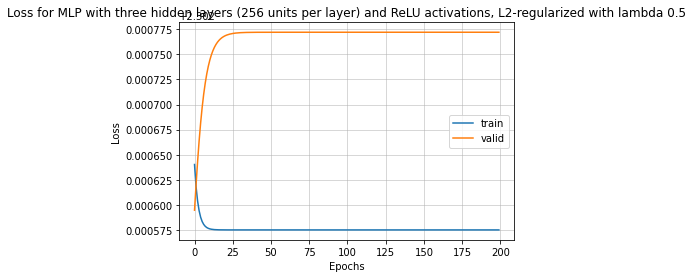

In [ ]:
plt.clf()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss for MLP with three hidden layers (256 units per layer) and ReLU activations, L2-regularized with lambda 0.5")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

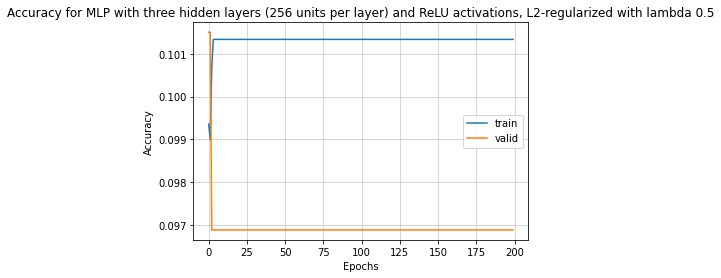

In [ ]:
plt.clf()
plt.plot(train_acc_list, label='train')
plt.plot(val_acc_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy for MLP with three hidden layers (256 units per layer) and ReLU activations, L2-regularized with lambda 0.5")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
y_test_probs = mlp_three_hidden_l2_0_5.predict(x_test, is_test=True)

test_loss = EvaluationUtils.calculate_ce_loss(y_test_probs, y_test)
test_acc = EvaluationUtils.calculate_multi_accuracy(y_test_probs, y_test)

print("Test loss: {}".format(test_loss))
print("Test accuracy: {}".format(test_acc))

Test loss: 2.3026019508564217
Test accuracy: 0.1


## Sub-task 4:

### MLP with two hidden layers (128 units) and ReLU activations, trained with unnormalized images

In [ ]:
mlp_two_hidden_unnormalized = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, FASHION_MNIST_N_CLASSES),
    SoftmaxOutputLayer()
)

opt_two_hidden_unnormalized = GradientDescentOptimizer(mlp_two_hidden_unnormalized, MLP_LR)
train_loss_list, val_loss_list, train_acc_list, val_acc_list = mlp_two_hidden_unnormalized.fit(opt_two_hidden_unnormalized, x_train_unnormalized, 
                                                                                  y_train, x_val_unnormalized, y_val,
                                                                                  batch_size=MLP_BATCH_SIZE, epochs=MLP_EPOCHS)

  0%|          | 1/200 [00:02<07:05,  2.14s/it]

Epoch: 1, train loss: 0.7209355726419509, train acc: 0.733309523809524, val loss: 0.6153881477221254, val acc: 0.7630555555555556


  1%|          | 2/200 [00:04<06:38,  2.01s/it]

Epoch: 2, train loss: 0.46319169984920855, train acc: 0.8305952380952377, val loss: 0.49897630917305996, val acc: 0.8165


  2%|▏         | 3/200 [00:05<06:29,  1.98s/it]

Epoch: 3, train loss: 0.40550064543301273, train acc: 0.8504047619047631, val loss: 0.4421889721643032, val acc: 0.8378333333333333


  2%|▏         | 4/200 [00:07<06:23,  1.95s/it]

Epoch: 4, train loss: 0.37185237371758345, train acc: 0.8631666666666662, val loss: 0.4021016151984123, val acc: 0.8567222222222223


  2%|▎         | 5/200 [00:09<06:17,  1.94s/it]

Epoch: 5, train loss: 0.3483028399848325, train acc: 0.8719285714285704, val loss: 0.39422707830230375, val acc: 0.8600555555555556


  3%|▎         | 6/200 [00:11<06:12,  1.92s/it]

Epoch: 6, train loss: 0.32984122354800527, train acc: 0.8783571428571428, val loss: 0.38259679245889167, val acc: 0.8647777777777778


  4%|▎         | 7/200 [00:13<06:09,  1.91s/it]

Epoch: 7, train loss: 0.3139098180298431, train acc: 0.8835714285714288, val loss: 0.37181034580976374, val acc: 0.869


  4%|▍         | 8/200 [00:15<06:07,  1.92s/it]

Epoch: 8, train loss: 0.30072967032518055, train acc: 0.8885714285714289, val loss: 0.36065171359336246, val acc: 0.8731111111111111


  4%|▍         | 9/200 [00:17<06:05,  1.91s/it]

Epoch: 9, train loss: 0.2884146291001715, train acc: 0.8942857142857144, val loss: 0.3641211281341098, val acc: 0.8723888888888889


  5%|▌         | 10/200 [00:19<06:03,  1.91s/it]

Epoch: 10, train loss: 0.276619270032069, train acc: 0.8984285714285714, val loss: 0.3688490701783878, val acc: 0.8704444444444445


  6%|▌         | 11/200 [00:21<06:00,  1.91s/it]

Epoch: 11, train loss: 0.2667088519311218, train acc: 0.9011666666666666, val loss: 0.3755132456867126, val acc: 0.8715555555555555


  6%|▌         | 12/200 [00:23<05:58,  1.90s/it]

Epoch: 12, train loss: 0.26064009344272343, train acc: 0.9043809523809526, val loss: 0.3631702317944225, val acc: 0.8746111111111111


  6%|▋         | 13/200 [00:25<05:59,  1.92s/it]

Epoch: 13, train loss: 0.25065165740232437, train acc: 0.9086904761904762, val loss: 0.35710509791211054, val acc: 0.8776111111111111


  7%|▋         | 14/200 [00:27<05:58,  1.93s/it]

Epoch: 14, train loss: 0.2414532181158193, train acc: 0.9103333333333329, val loss: 0.3849845893456656, val acc: 0.8712777777777778


  8%|▊         | 15/200 [00:28<05:53,  1.91s/it]

Epoch: 15, train loss: 0.23426747785646346, train acc: 0.9125238095238096, val loss: 0.3857522023270089, val acc: 0.8724444444444445


  8%|▊         | 16/200 [00:30<05:50,  1.91s/it]

Epoch: 16, train loss: 0.22748441260603375, train acc: 0.9159761904761903, val loss: 0.3724715384692905, val acc: 0.8742222222222222


  8%|▊         | 17/200 [00:32<05:48,  1.90s/it]

Epoch: 17, train loss: 0.22324147944414025, train acc: 0.9174523809523805, val loss: 0.3875119824639046, val acc: 0.8695


  9%|▉         | 18/200 [00:34<05:47,  1.91s/it]

Epoch: 18, train loss: 0.21563971013663574, train acc: 0.9195952380952377, val loss: 0.4228623708595878, val acc: 0.8606666666666667


 10%|▉         | 19/200 [00:36<05:50,  1.94s/it]

Epoch: 19, train loss: 0.2099468081242248, train acc: 0.9226666666666671, val loss: 0.41058875145031665, val acc: 0.8668333333333333


 10%|█         | 20/200 [00:38<05:46,  1.92s/it]

Epoch: 20, train loss: 0.20174645239020492, train acc: 0.9257142857142863, val loss: 0.4051665035630916, val acc: 0.8698888888888889


 10%|█         | 21/200 [00:40<05:41,  1.91s/it]

Epoch: 21, train loss: 0.19801155999881492, train acc: 0.9275476190476187, val loss: 0.4134378629754231, val acc: 0.8709444444444444


 11%|█         | 22/200 [00:42<05:39,  1.91s/it]

Epoch: 22, train loss: 0.2201945734838684, train acc: 0.9208571428571433, val loss: 0.38841375142381923, val acc: 0.8771111111111111


 12%|█▏        | 23/200 [00:44<05:37,  1.91s/it]

Epoch: 23, train loss: 0.1931892673300211, train acc: 0.927857142857143, val loss: 0.38905494240015537, val acc: 0.8779444444444444


 12%|█▏        | 24/200 [00:46<05:36,  1.91s/it]

Epoch: 24, train loss: 0.18301022347826634, train acc: 0.931119047619047, val loss: 0.4127785066225888, val acc: 0.8710555555555556


 12%|█▎        | 25/200 [00:48<05:35,  1.92s/it]

Epoch: 25, train loss: 0.17781781942929553, train acc: 0.9336428571428559, val loss: 0.40094864559568194, val acc: 0.8762777777777778


 13%|█▎        | 26/200 [00:49<05:32,  1.91s/it]

Epoch: 26, train loss: 0.17244572799919544, train acc: 0.9361904761904761, val loss: 0.4054834864987165, val acc: 0.8757777777777778


 14%|█▎        | 27/200 [00:51<05:31,  1.91s/it]

Epoch: 27, train loss: 0.16767562271988373, train acc: 0.9368095238095233, val loss: 0.4160926860855931, val acc: 0.8768888888888889


 14%|█▍        | 28/200 [00:53<05:30,  1.92s/it]

Epoch: 28, train loss: 0.27835927755818995, train acc: 0.9175714285714284, val loss: 0.4456028519652106, val acc: 0.8475


 14%|█▍        | 29/200 [00:55<05:27,  1.91s/it]

Epoch: 29, train loss: 0.24299324801452257, train acc: 0.9090238095238098, val loss: 0.388904732266893, val acc: 0.8736666666666667


 15%|█▌        | 30/200 [00:57<05:27,  1.93s/it]

Epoch: 30, train loss: 0.203208424754095, train acc: 0.9235238095238095, val loss: 0.3952878258772723, val acc: 0.8738333333333334


 16%|█▌        | 31/200 [00:59<05:24,  1.92s/it]

Epoch: 31, train loss: 0.187300239553028, train acc: 0.9302619047619036, val loss: 0.4049654578064332, val acc: 0.8710555555555556


 16%|█▌        | 32/200 [01:01<05:19,  1.90s/it]

Epoch: 32, train loss: 0.17742361686978952, train acc: 0.9329047619047621, val loss: 0.4024329193714029, val acc: 0.8713333333333333


 16%|█▋        | 33/200 [01:03<05:16,  1.89s/it]

Epoch: 33, train loss: 0.16854638843660588, train acc: 0.9373333333333324, val loss: 0.3942444252316468, val acc: 0.8777222222222222


 17%|█▋        | 34/200 [01:05<05:14,  1.89s/it]

Epoch: 34, train loss: 0.16160496874811456, train acc: 0.939595238095238, val loss: 0.4380518507368528, val acc: 0.8691111111111111


 18%|█▊        | 35/200 [01:07<05:12,  1.89s/it]

Epoch: 35, train loss: 0.15805545959379325, train acc: 0.941452380952381, val loss: 0.4332663955422513, val acc: 0.8706111111111111


 18%|█▊        | 36/200 [01:09<05:11,  1.90s/it]

Epoch: 36, train loss: 0.151991577204964, train acc: 0.9429047619047607, val loss: 0.44299854728469107, val acc: 0.8706111111111111


 18%|█▊        | 37/200 [01:10<05:10,  1.90s/it]

Epoch: 37, train loss: 0.1507198414626486, train acc: 0.9441428571428572, val loss: 0.45148230505173365, val acc: 0.8713888888888889


 19%|█▉        | 38/200 [01:12<05:08,  1.91s/it]

Epoch: 38, train loss: 0.14363624163817976, train acc: 0.9464999999999999, val loss: 0.435178513400751, val acc: 0.8759444444444444


 20%|█▉        | 39/200 [01:14<05:06,  1.90s/it]

Epoch: 39, train loss: 0.13692692452358632, train acc: 0.9487857142857141, val loss: 0.45251744267487337, val acc: 0.8736666666666667


 20%|██        | 40/200 [01:16<05:04,  1.91s/it]

Epoch: 40, train loss: 0.13378469928564132, train acc: 0.9504523809523813, val loss: 0.454317713629956, val acc: 0.8737777777777778


 20%|██        | 41/200 [01:18<05:01,  1.89s/it]

Epoch: 41, train loss: 0.1318572414616889, train acc: 0.9507857142857148, val loss: 0.4415881231162062, val acc: 0.8757222222222222


 21%|██        | 42/200 [01:20<04:57,  1.88s/it]

Epoch: 42, train loss: 0.13506790741961805, train acc: 0.9504999999999998, val loss: 0.4553759677687875, val acc: 0.8741111111111111


 22%|██▏       | 43/200 [01:22<04:56,  1.89s/it]

Epoch: 43, train loss: 0.13343202250477545, train acc: 0.9504523809523813, val loss: 0.44116415347695614, val acc: 0.8774444444444445


 22%|██▏       | 44/200 [01:24<04:54,  1.89s/it]

Epoch: 44, train loss: 0.12958075098580468, train acc: 0.9519523809523814, val loss: 0.48126556939814075, val acc: 0.8716666666666667


 22%|██▎       | 45/200 [01:26<04:53,  1.90s/it]

Epoch: 45, train loss: 0.13204715944015016, train acc: 0.9514523809523809, val loss: 0.46279374827046416, val acc: 0.8759444444444444


 23%|██▎       | 46/200 [01:28<04:54,  1.91s/it]

Epoch: 46, train loss: 0.11533043503776004, train acc: 0.9580714285714296, val loss: 0.4882702574079457, val acc: 0.8733888888888889


 24%|██▎       | 47/200 [01:29<04:52,  1.91s/it]

Epoch: 47, train loss: 0.11383983218632018, train acc: 0.958928571428572, val loss: 0.5228470859289407, val acc: 0.8657222222222222


 24%|██▍       | 48/200 [01:31<04:50,  1.91s/it]

Epoch: 48, train loss: 0.10672229557482063, train acc: 0.961333333333335, val loss: 0.5235944080839615, val acc: 0.8727222222222222


 24%|██▍       | 49/200 [01:33<04:47,  1.91s/it]

Epoch: 49, train loss: 0.10705753611997314, train acc: 0.9607857142857149, val loss: 0.5379729704330544, val acc: 0.8665555555555555


 25%|██▌       | 50/200 [01:35<04:45,  1.90s/it]

Epoch: 50, train loss: 0.10464677965972861, train acc: 0.9595714285714286, val loss: 0.5423137392122847, val acc: 0.8726111111111111


 26%|██▌       | 51/200 [01:37<04:44,  1.91s/it]

Epoch: 51, train loss: 0.10372383428015845, train acc: 0.9621190476190488, val loss: 0.5355472537384544, val acc: 0.8722222222222222


 26%|██▌       | 52/200 [01:39<04:42,  1.91s/it]

Epoch: 52, train loss: 0.10580930055617359, train acc: 0.9622380952380958, val loss: 0.515226666348897, val acc: 0.8803888888888889


 26%|██▋       | 53/200 [01:41<04:42,  1.92s/it]

Epoch: 53, train loss: 0.10231668415765917, train acc: 0.961857142857144, val loss: 0.48690840036552074, val acc: 0.8826666666666667


 27%|██▋       | 54/200 [01:43<04:40,  1.92s/it]

Epoch: 54, train loss: 0.10154387766908196, train acc: 0.9629047619047639, val loss: 0.5104023255796265, val acc: 0.8754444444444445


 28%|██▊       | 55/200 [01:45<04:37,  1.91s/it]

Epoch: 55, train loss: 0.1015631258551172, train acc: 0.9627142857142865, val loss: 0.5364329171174799, val acc: 0.8786111111111111


 28%|██▊       | 56/200 [01:47<04:35,  1.91s/it]

Epoch: 56, train loss: 0.09519697358584138, train acc: 0.9640000000000022, val loss: 0.5446875727403373, val acc: 0.8751111111111111


 28%|██▊       | 57/200 [01:49<04:32,  1.90s/it]

Epoch: 57, train loss: 0.09029448037166375, train acc: 0.9664761904761914, val loss: 0.55897170260521, val acc: 0.8755


 29%|██▉       | 58/200 [01:50<04:30,  1.91s/it]

Epoch: 58, train loss: 0.09276819806509981, train acc: 0.9663809523809529, val loss: 0.548700604310197, val acc: 0.875


 30%|██▉       | 59/200 [01:52<04:27,  1.90s/it]

Epoch: 59, train loss: 0.09033413394048072, train acc: 0.9666190476190497, val loss: 0.5852177972828912, val acc: 0.874


 30%|███       | 60/200 [01:54<04:24,  1.89s/it]

Epoch: 60, train loss: 0.09109313066110448, train acc: 0.9658571428571446, val loss: 0.5519536075066157, val acc: 0.8837777777777778


 30%|███       | 61/200 [01:56<04:21,  1.88s/it]

Epoch: 61, train loss: 0.08596539454181724, train acc: 0.9683333333333352, val loss: 0.5487889228120626, val acc: 0.8741666666666666


 31%|███       | 62/200 [01:58<04:21,  1.90s/it]

Epoch: 62, train loss: 0.09440944968835924, train acc: 0.965261904761907, val loss: 0.5763365170574585, val acc: 0.8752777777777778


 32%|███▏      | 63/200 [02:00<04:19,  1.89s/it]

Epoch: 63, train loss: 0.08924307269199254, train acc: 0.9673095238095252, val loss: 0.6232655935646635, val acc: 0.8678888888888889


 32%|███▏      | 64/200 [02:02<04:17,  1.89s/it]

Epoch: 64, train loss: 0.0833786901635471, train acc: 0.9691190476190507, val loss: 0.5908252623388475, val acc: 0.8693333333333333


 32%|███▎      | 65/200 [02:04<04:15,  1.89s/it]

Epoch: 65, train loss: 0.07731729346641383, train acc: 0.9720000000000019, val loss: 0.584807354028177, val acc: 0.8797222222222222


 33%|███▎      | 66/200 [02:06<04:14,  1.90s/it]

Epoch: 66, train loss: 0.0831791107290993, train acc: 0.9692619047619069, val loss: 0.5909567449876704, val acc: 0.8751111111111111


 34%|███▎      | 67/200 [02:07<04:13,  1.91s/it]

Epoch: 67, train loss: 0.07520465289110267, train acc: 0.9723809523809549, val loss: 0.5965628416566559, val acc: 0.8756111111111111


 34%|███▍      | 68/200 [02:10<04:31,  2.06s/it]

Epoch: 68, train loss: 0.07814039426041608, train acc: 0.9716904761904779, val loss: 0.5858968617065029, val acc: 0.8797222222222222


 34%|███▍      | 69/200 [02:13<04:58,  2.28s/it]

Epoch: 69, train loss: 0.07607448172115025, train acc: 0.9720476190476199, val loss: 0.5762287457869415, val acc: 0.8808888888888889


 35%|███▌      | 70/200 [02:15<04:41,  2.17s/it]

Epoch: 70, train loss: 0.06905275021082453, train acc: 0.9754047619047649, val loss: 0.7405419423624751, val acc: 0.8651666666666666


 36%|███▌      | 71/200 [02:16<04:29,  2.09s/it]

Epoch: 71, train loss: 0.06833950490031107, train acc: 0.9751666666666692, val loss: 0.6179221656232383, val acc: 0.8788888888888889


 36%|███▌      | 72/200 [02:18<04:21,  2.04s/it]

Epoch: 72, train loss: 0.08709336390787184, train acc: 0.9680952380952399, val loss: 0.6231738694546063, val acc: 0.8795


 36%|███▋      | 73/200 [02:20<04:13,  2.00s/it]

Epoch: 73, train loss: 0.0818942866187913, train acc: 0.9705000000000022, val loss: 0.6277156374412673, val acc: 0.874


 37%|███▋      | 74/200 [02:22<04:08,  1.97s/it]

Epoch: 74, train loss: 0.07342251838717724, train acc: 0.9724523809523836, val loss: 0.6702087885705306, val acc: 0.8603888888888889


 38%|███▊      | 75/200 [02:24<04:03,  1.94s/it]

Epoch: 75, train loss: 0.06840112720701558, train acc: 0.9762619047619088, val loss: 0.6271221684984966, val acc: 0.8793333333333333


 38%|███▊      | 76/200 [02:26<03:58,  1.93s/it]

Epoch: 76, train loss: 0.07182566551151777, train acc: 0.9733095238095265, val loss: 0.6359716101468639, val acc: 0.8763888888888889


 38%|███▊      | 77/200 [02:28<03:58,  1.94s/it]

Epoch: 77, train loss: 0.07316828131668554, train acc: 0.9742142857142886, val loss: 0.6373296007420015, val acc: 0.8756666666666667


 39%|███▉      | 78/200 [02:30<03:54,  1.92s/it]

Epoch: 78, train loss: 0.06890829478846386, train acc: 0.9745238095238129, val loss: 0.663189527023118, val acc: 0.8789444444444444


 40%|███▉      | 79/200 [02:32<03:51,  1.91s/it]

Epoch: 79, train loss: 0.06267182413205784, train acc: 0.9773095238095274, val loss: 0.6379986374639134, val acc: 0.883


 40%|████      | 80/200 [02:34<03:49,  1.91s/it]

Epoch: 80, train loss: 0.061218486821151864, train acc: 0.9790238095238126, val loss: 0.6413652950418317, val acc: 0.8833333333333333


 40%|████      | 81/200 [02:36<03:46,  1.91s/it]

Epoch: 81, train loss: 0.05364030996920059, train acc: 0.9803571428571464, val loss: 0.6704254875673068, val acc: 0.8761111111111111


 41%|████      | 82/200 [02:37<03:46,  1.92s/it]

Epoch: 82, train loss: 0.05610084276014744, train acc: 0.9802380952380987, val loss: 0.6381796695178993, val acc: 0.8806666666666667


 42%|████▏     | 83/200 [02:39<03:44,  1.91s/it]

Epoch: 83, train loss: 0.055820497453550395, train acc: 0.9799047619047649, val loss: 0.6682033543226504, val acc: 0.8796111111111111


 42%|████▏     | 84/200 [02:41<03:41,  1.91s/it]

Epoch: 84, train loss: 0.0682402313478113, train acc: 0.976452380952384, val loss: 0.7742467619296741, val acc: 0.8668333333333333


 42%|████▎     | 85/200 [02:43<03:38,  1.90s/it]

Epoch: 85, train loss: 0.06340274510843386, train acc: 0.9766428571428596, val loss: 0.674220214430777, val acc: 0.8775555555555555


 43%|████▎     | 86/200 [02:45<03:35,  1.89s/it]

Epoch: 86, train loss: 0.0576712295245992, train acc: 0.978976190476194, val loss: 0.7191440109586743, val acc: 0.8763333333333333


 44%|████▎     | 87/200 [02:47<03:33,  1.89s/it]

Epoch: 87, train loss: 0.048529819061670615, train acc: 0.9823571428571461, val loss: 0.7766709325077091, val acc: 0.8631666666666666


 44%|████▍     | 88/200 [02:49<03:32,  1.90s/it]

Epoch: 88, train loss: 0.06135055499681351, train acc: 0.9789523809523839, val loss: 0.6750709634632118, val acc: 0.8794444444444445


 44%|████▍     | 89/200 [02:51<03:29,  1.89s/it]

Epoch: 89, train loss: 0.04685809852950053, train acc: 0.9827857142857186, val loss: 0.7055087397895723, val acc: 0.8813888888888889


 45%|████▌     | 90/200 [02:53<03:28,  1.89s/it]

Epoch: 90, train loss: 0.05527269823705189, train acc: 0.980785714285717, val loss: 0.6596499250030973, val acc: 0.8801666666666667


 46%|████▌     | 91/200 [02:55<03:27,  1.90s/it]

Epoch: 91, train loss: 0.05089938568255075, train acc: 0.9824523809523841, val loss: 0.7187128000669986, val acc: 0.8750555555555556


 46%|████▌     | 92/200 [02:56<03:24,  1.89s/it]

Epoch: 92, train loss: 0.046585780793108454, train acc: 0.9827380952380994, val loss: 0.6871589241752072, val acc: 0.8813888888888889


 46%|████▋     | 93/200 [02:58<03:22,  1.89s/it]

Epoch: 93, train loss: 0.041861305071144196, train acc: 0.9856190476190508, val loss: 0.7414140119181398, val acc: 0.8772222222222222


 47%|████▋     | 94/200 [03:00<03:19,  1.88s/it]

Epoch: 94, train loss: 0.050702380618495156, train acc: 0.9821666666666699, val loss: 0.7319339181032111, val acc: 0.8781666666666667


 48%|████▊     | 95/200 [03:02<03:18,  1.89s/it]

Epoch: 95, train loss: 0.05974790333496234, train acc: 0.9782142857142886, val loss: 0.8464971000438487, val acc: 0.8622777777777778


 48%|████▊     | 96/200 [03:04<03:16,  1.89s/it]

Epoch: 96, train loss: 0.0435075852654055, train acc: 0.9846666666666704, val loss: 0.719031647148936, val acc: 0.8804444444444445


 48%|████▊     | 97/200 [03:06<03:14,  1.89s/it]

Epoch: 97, train loss: 0.04022308293070444, train acc: 0.9857619047619081, val loss: 0.750943868327988, val acc: 0.8762777777777778


 49%|████▉     | 98/200 [03:08<03:13,  1.89s/it]

Epoch: 98, train loss: 0.07164638558332989, train acc: 0.9755952380952403, val loss: 0.7482938100666768, val acc: 0.8750555555555556


 50%|████▉     | 99/200 [03:10<03:11,  1.89s/it]

Epoch: 99, train loss: 0.05500934263213383, train acc: 0.9799285714285754, val loss: 0.734436323231461, val acc: 0.8772222222222222


 50%|█████     | 100/200 [03:12<03:09,  1.89s/it]

Epoch: 100, train loss: 0.040070357189768466, train acc: 0.9848333333333369, val loss: 0.7678791758287241, val acc: 0.8767222222222222


 50%|█████     | 101/200 [03:13<03:07,  1.89s/it]

Epoch: 101, train loss: 0.04081663951023452, train acc: 0.9856666666666701, val loss: 0.6959481337817475, val acc: 0.8819444444444444


 51%|█████     | 102/200 [03:15<03:05,  1.89s/it]

Epoch: 102, train loss: 0.04492259471808369, train acc: 0.983714285714289, val loss: 0.7462564877954121, val acc: 0.8788333333333334


 52%|█████▏    | 103/200 [03:17<03:04,  1.90s/it]

Epoch: 103, train loss: 0.03872651767736099, train acc: 0.9857142857142884, val loss: 0.7227318206430849, val acc: 0.8829444444444444


 52%|█████▏    | 104/200 [03:19<03:02,  1.90s/it]

Epoch: 104, train loss: 0.04108994178430658, train acc: 0.9862142857142888, val loss: 0.7428716047488523, val acc: 0.8811111111111111


 52%|█████▎    | 105/200 [03:21<02:59,  1.89s/it]

Epoch: 105, train loss: 0.0467924214525121, train acc: 0.9840000000000025, val loss: 0.749574310708749, val acc: 0.8776666666666667


 53%|█████▎    | 106/200 [03:23<02:57,  1.89s/it]

Epoch: 106, train loss: 0.04194399351573072, train acc: 0.9843571428571465, val loss: 0.7563749698402855, val acc: 0.8741111111111111


 54%|█████▎    | 107/200 [03:25<02:56,  1.90s/it]

Epoch: 107, train loss: 0.07446878001069045, train acc: 0.9808809523809552, val loss: 0.698266606394415, val acc: 0.8708888888888889


 54%|█████▍    | 108/200 [03:27<02:55,  1.91s/it]

Epoch: 108, train loss: 0.08403986899989745, train acc: 0.9708333333333372, val loss: 0.7252328238535711, val acc: 0.8779444444444444


 55%|█████▍    | 109/200 [03:29<02:53,  1.91s/it]

Epoch: 109, train loss: 0.047350748393188015, train acc: 0.9829047619047645, val loss: 0.7250108154351598, val acc: 0.8837222222222222


 55%|█████▌    | 110/200 [03:31<02:51,  1.91s/it]

Epoch: 110, train loss: 0.03352270067550126, train acc: 0.9882619047619084, val loss: 0.7574162752336354, val acc: 0.8815555555555555


 56%|█████▌    | 111/200 [03:32<02:50,  1.91s/it]

Epoch: 111, train loss: 0.03089679601754846, train acc: 0.9894285714285748, val loss: 0.7458325221993796, val acc: 0.8817777777777778


 56%|█████▌    | 112/200 [03:34<02:48,  1.91s/it]

Epoch: 112, train loss: 0.0343228654279181, train acc: 0.987809523809527, val loss: 0.8034193088454425, val acc: 0.8786666666666667


 56%|█████▋    | 113/200 [03:36<02:45,  1.91s/it]

Epoch: 113, train loss: 0.03656733669848753, train acc: 0.9873333333333368, val loss: 0.7923117060694773, val acc: 0.8804444444444445


 57%|█████▋    | 114/200 [03:38<02:45,  1.92s/it]

Epoch: 114, train loss: 0.0498596463046939, train acc: 0.982285714285718, val loss: 0.7785561441480425, val acc: 0.8778333333333334


 57%|█████▊    | 115/200 [03:40<02:42,  1.91s/it]

Epoch: 115, train loss: 0.03844322852840393, train acc: 0.9864047619047654, val loss: 0.7907330336035076, val acc: 0.8782777777777778


 58%|█████▊    | 116/200 [03:42<02:40,  1.91s/it]

Epoch: 116, train loss: 0.030645758218397618, train acc: 0.9897142857142894, val loss: 0.7895674339019948, val acc: 0.8771111111111111


 58%|█████▊    | 117/200 [03:44<02:38,  1.92s/it]

Epoch: 117, train loss: 0.04482502260344435, train acc: 0.9855238095238131, val loss: 0.756215356969667, val acc: 0.8827777777777778


 59%|█████▉    | 118/200 [03:46<02:37,  1.92s/it]

Epoch: 118, train loss: 0.02756061769251041, train acc: 0.9905476190476218, val loss: 0.8597549618876148, val acc: 0.8747777777777778


 60%|█████▉    | 119/200 [03:48<02:34,  1.90s/it]

Epoch: 119, train loss: 0.03569879286323159, train acc: 0.9868809523809556, val loss: 0.7880891390981415, val acc: 0.8818888888888889


 60%|██████    | 120/200 [03:50<02:32,  1.90s/it]

Epoch: 120, train loss: 0.03726147226727043, train acc: 0.9871904761904795, val loss: 0.7949532464001065, val acc: 0.8757222222222222


 60%|██████    | 121/200 [03:52<02:30,  1.90s/it]

Epoch: 121, train loss: 0.03343201045791402, train acc: 0.9884761904761938, val loss: 0.8206894543378087, val acc: 0.8743888888888889


 61%|██████    | 122/200 [03:53<02:28,  1.91s/it]

Epoch: 122, train loss: 0.03458598188536164, train acc: 0.9880238095238124, val loss: 0.810760115238212, val acc: 0.8825


 62%|██████▏   | 123/200 [03:55<02:26,  1.90s/it]

Epoch: 123, train loss: 0.04592041674007947, train acc: 0.9837380952380986, val loss: 0.822952629865605, val acc: 0.8786111111111111


 62%|██████▏   | 124/200 [03:57<02:24,  1.90s/it]

Epoch: 124, train loss: 0.04149713576143629, train acc: 0.9850238095238122, val loss: 0.8409321350670084, val acc: 0.878


 62%|██████▎   | 125/200 [03:59<02:22,  1.90s/it]

Epoch: 125, train loss: 0.032379387124663546, train acc: 0.9888095238095261, val loss: 0.874883533115009, val acc: 0.8772777777777778


 63%|██████▎   | 126/200 [04:01<02:20,  1.90s/it]

Epoch: 126, train loss: 0.03282716735052929, train acc: 0.9886666666666699, val loss: 0.8128413147658343, val acc: 0.8767777777777778


 64%|██████▎   | 127/200 [04:03<02:18,  1.90s/it]

Epoch: 127, train loss: 0.025662109080575018, train acc: 0.9909523809523838, val loss: 0.8117756248980973, val acc: 0.8812777777777778


 64%|██████▍   | 128/200 [04:05<02:19,  1.94s/it]

Epoch: 128, train loss: 0.06253951069152609, train acc: 0.9801190476190507, val loss: 0.8364364727438076, val acc: 0.8774444444444445


 64%|██████▍   | 129/200 [04:07<02:17,  1.93s/it]

Epoch: 129, train loss: 0.03878836706948896, train acc: 0.9864523809523849, val loss: 0.7944099562007579, val acc: 0.8795555555555555


 65%|██████▌   | 130/200 [04:09<02:14,  1.92s/it]

Epoch: 130, train loss: 0.0262316260439782, train acc: 0.9911904761904792, val loss: 0.8167222708741384, val acc: 0.8784444444444445


 66%|██████▌   | 131/200 [04:11<02:11,  1.91s/it]

Epoch: 131, train loss: 0.02126811502965312, train acc: 0.9923333333333354, val loss: 0.8165078495097048, val acc: 0.8821666666666667


 66%|██████▌   | 132/200 [04:13<02:10,  1.92s/it]

Epoch: 132, train loss: 0.027554830682952464, train acc: 0.9909285714285737, val loss: 0.8643774425004145, val acc: 0.8757777777777778


 66%|██████▋   | 133/200 [04:15<02:09,  1.93s/it]

Epoch: 133, train loss: 0.03674048376705499, train acc: 0.9871190476190508, val loss: 0.839657397052615, val acc: 0.8818333333333334


 67%|██████▋   | 134/200 [04:16<02:06,  1.92s/it]

Epoch: 134, train loss: 0.03823097377373718, train acc: 0.9868809523809557, val loss: 0.8409478081992054, val acc: 0.8812777777777778


 68%|██████▊   | 135/200 [04:18<02:04,  1.91s/it]

Epoch: 135, train loss: 0.028563806378161225, train acc: 0.9903571428571455, val loss: 0.8218654725511716, val acc: 0.8812777777777778


 68%|██████▊   | 136/200 [04:20<02:01,  1.90s/it]

Epoch: 136, train loss: 0.02728783105792931, train acc: 0.9907619047619077, val loss: 0.85890691864332, val acc: 0.8801111111111111


 68%|██████▊   | 137/200 [04:22<01:59,  1.89s/it]

Epoch: 137, train loss: 0.027870932211841115, train acc: 0.9901190476190507, val loss: 0.8374689191890652, val acc: 0.8771666666666667


 69%|██████▉   | 138/200 [04:24<01:57,  1.89s/it]

Epoch: 138, train loss: 0.023692845249434283, train acc: 0.9917380952380983, val loss: 0.8761383178168745, val acc: 0.8793333333333333


 70%|██████▉   | 139/200 [04:26<01:56,  1.91s/it]

Epoch: 139, train loss: 0.020692186564937425, train acc: 0.9930238095238126, val loss: 0.8384588378586674, val acc: 0.8836666666666667


 70%|███████   | 140/200 [04:28<01:54,  1.90s/it]

Epoch: 140, train loss: 0.023569069302914848, train acc: 0.9922380952380979, val loss: 0.8686271537466075, val acc: 0.8777222222222222


 70%|███████   | 141/200 [04:30<01:52,  1.90s/it]

Epoch: 141, train loss: 0.03539351932998632, train acc: 0.9888095238095271, val loss: 0.8555233880163496, val acc: 0.8807777777777778


 71%|███████   | 142/200 [04:32<01:50,  1.90s/it]

Epoch: 142, train loss: 0.047116334610434726, train acc: 0.9845000000000027, val loss: 0.8460016867718334, val acc: 0.8809444444444444


 72%|███████▏  | 143/200 [04:34<01:48,  1.91s/it]

Epoch: 143, train loss: 0.056802321174295387, train acc: 0.9830952380952405, val loss: 0.8277439034463334, val acc: 0.8774444444444445


 72%|███████▏  | 144/200 [04:35<01:46,  1.90s/it]

Epoch: 144, train loss: 0.03239146127507904, train acc: 0.9894047619047648, val loss: 0.8332097974496422, val acc: 0.8826666666666667


 72%|███████▎  | 145/200 [04:37<01:44,  1.90s/it]

Epoch: 145, train loss: 0.018243894523436728, train acc: 0.9936190476190506, val loss: 0.8130396432748884, val acc: 0.8818333333333334


 73%|███████▎  | 146/200 [04:39<01:42,  1.90s/it]

Epoch: 146, train loss: 0.021403550024055567, train acc: 0.993119047619051, val loss: 0.8549798695735378, val acc: 0.8811666666666667


 74%|███████▎  | 147/200 [04:41<01:40,  1.90s/it]

Epoch: 147, train loss: 0.028698278738951737, train acc: 0.990166666666669, val loss: 0.8550890504642619, val acc: 0.8785


 74%|███████▍  | 148/200 [04:43<01:38,  1.89s/it]

Epoch: 148, train loss: 0.02944172889228046, train acc: 0.9901904761904791, val loss: 0.9059969616250354, val acc: 0.8791666666666667


 74%|███████▍  | 149/200 [04:45<01:36,  1.90s/it]

Epoch: 149, train loss: 0.032824571017676454, train acc: 0.9891190476190505, val loss: 0.8869011433464825, val acc: 0.8725


 75%|███████▌  | 150/200 [04:47<01:34,  1.90s/it]

Epoch: 150, train loss: 0.0317763278560568, train acc: 0.9899523809523836, val loss: 0.9365962314038807, val acc: 0.8732222222222222


 76%|███████▌  | 151/200 [04:49<01:33,  1.90s/it]

Epoch: 151, train loss: 0.022902395944675528, train acc: 0.9919523809523838, val loss: 0.8723847536064032, val acc: 0.8801666666666667


 76%|███████▌  | 152/200 [04:51<01:31,  1.91s/it]

Epoch: 152, train loss: 0.02582740408374102, train acc: 0.9916428571428606, val loss: 0.8975102186984191, val acc: 0.8790555555555556


 76%|███████▋  | 153/200 [04:53<01:29,  1.91s/it]

Epoch: 153, train loss: 0.022086858473657937, train acc: 0.9928333333333366, val loss: 0.9090559531146211, val acc: 0.8782222222222222


 77%|███████▋  | 154/200 [04:55<01:28,  1.92s/it]

Epoch: 154, train loss: 0.02377278176135887, train acc: 0.9916190476190504, val loss: 0.8520659267941338, val acc: 0.8797222222222222


 78%|███████▊  | 155/200 [04:56<01:26,  1.93s/it]

Epoch: 155, train loss: 0.022210542688561177, train acc: 0.9926428571428598, val loss: 0.8663915628224842, val acc: 0.8830555555555556


 78%|███████▊  | 156/200 [04:58<01:24,  1.93s/it]

Epoch: 156, train loss: 0.03043329927304813, train acc: 0.9896190476190513, val loss: 0.8977653765231769, val acc: 0.8803333333333333


 78%|███████▊  | 157/200 [05:00<01:22,  1.93s/it]

Epoch: 157, train loss: 0.02004445146151119, train acc: 0.993309523809526, val loss: 0.8942832433480533, val acc: 0.8796666666666667


 79%|███████▉  | 158/200 [05:02<01:20,  1.93s/it]

Epoch: 158, train loss: 0.02489814539019504, train acc: 0.9915238095238117, val loss: 0.8703320389991239, val acc: 0.8825


 80%|███████▉  | 159/200 [05:04<01:18,  1.92s/it]

Epoch: 159, train loss: 0.020835004776242, train acc: 0.9928333333333357, val loss: 0.8852201923128018, val acc: 0.8812777777777778


 80%|████████  | 160/200 [05:06<01:16,  1.91s/it]

Epoch: 160, train loss: 0.016235597875512747, train acc: 0.9946190476190498, val loss: 0.8817891742349406, val acc: 0.8821666666666667


 80%|████████  | 161/200 [05:08<01:14,  1.91s/it]

Epoch: 161, train loss: 0.022842795532320565, train acc: 0.9923333333333353, val loss: 0.8836675051494619, val acc: 0.8825


 81%|████████  | 162/200 [05:10<01:12,  1.91s/it]

Epoch: 162, train loss: 0.043503141309717816, train acc: 0.9888571428571462, val loss: 0.8836512883312106, val acc: 0.8806111111111111


 82%|████████▏ | 163/200 [05:12<01:10,  1.90s/it]

Epoch: 163, train loss: 0.028744237269651467, train acc: 0.9903571428571453, val loss: 0.9128546265041093, val acc: 0.8805555555555555


 82%|████████▏ | 164/200 [05:14<01:08,  1.91s/it]

Epoch: 164, train loss: 0.028055936699191604, train acc: 0.990595238095241, val loss: 0.865450198336399, val acc: 0.8811666666666667


 82%|████████▎ | 165/200 [05:16<01:06,  1.91s/it]

Epoch: 165, train loss: 0.018624117686687112, train acc: 0.9934523809523834, val loss: 0.9096432167694767, val acc: 0.8783333333333333


 83%|████████▎ | 166/200 [05:17<01:04,  1.91s/it]

Epoch: 166, train loss: 0.02720591001469163, train acc: 0.9906904761904793, val loss: 0.8713997659905262, val acc: 0.8831666666666667


 84%|████████▎ | 167/200 [05:19<01:02,  1.90s/it]

Epoch: 167, train loss: 0.03594896665555095, train acc: 0.989214285714288, val loss: 0.9100951774734727, val acc: 0.885


 84%|████████▍ | 168/200 [05:21<01:00,  1.89s/it]

Epoch: 168, train loss: 0.0268440025828316, train acc: 0.9906666666666695, val loss: 0.9260415256947179, val acc: 0.8842222222222222


 84%|████████▍ | 169/200 [05:23<00:58,  1.89s/it]

Epoch: 169, train loss: 0.024560985038370096, train acc: 0.9920238095238121, val loss: 0.8661722899843333, val acc: 0.8841111111111111


 85%|████████▌ | 170/200 [05:25<00:57,  1.90s/it]

Epoch: 170, train loss: 0.018415362101067024, train acc: 0.9936904761904787, val loss: 0.9366439979683736, val acc: 0.8821666666666667


 86%|████████▌ | 171/200 [05:27<00:55,  1.90s/it]

Epoch: 171, train loss: 0.021329068980116536, train acc: 0.9927857142857169, val loss: 1.0883463350565847, val acc: 0.8661666666666666


 86%|████████▌ | 172/200 [05:29<00:53,  1.90s/it]

Epoch: 172, train loss: 0.016167841425797542, train acc: 0.9948571428571444, val loss: 0.9075353121713383, val acc: 0.882


 86%|████████▋ | 173/200 [05:31<00:51,  1.90s/it]

Epoch: 173, train loss: 0.01683650654624492, train acc: 0.9951904761904785, val loss: 0.9307130665621852, val acc: 0.8758888888888889


 87%|████████▋ | 174/200 [05:33<00:49,  1.91s/it]

Epoch: 174, train loss: 0.01850896848305326, train acc: 0.9936904761904787, val loss: 0.9764272333937738, val acc: 0.8780555555555556


 88%|████████▊ | 175/200 [05:35<00:47,  1.90s/it]

Epoch: 175, train loss: 0.011920035987303176, train acc: 0.9963333333333345, val loss: 0.9052079305985189, val acc: 0.8819444444444444


 88%|████████▊ | 176/200 [05:36<00:45,  1.90s/it]

Epoch: 176, train loss: 0.01247771247920019, train acc: 0.9958809523809542, val loss: 0.9211517945426319, val acc: 0.8847222222222222


 88%|████████▊ | 177/200 [05:38<00:43,  1.90s/it]

Epoch: 177, train loss: 0.010178309816067875, train acc: 0.9965714285714303, val loss: 0.9276989331311392, val acc: 0.8855555555555555


 89%|████████▉ | 178/200 [05:40<00:41,  1.89s/it]

Epoch: 178, train loss: 0.0334342249504712, train acc: 0.9902380952380982, val loss: 0.9596340561882417, val acc: 0.8792222222222222


 90%|████████▉ | 179/200 [05:42<00:39,  1.89s/it]

Epoch: 179, train loss: 0.03117023297784144, train acc: 0.990523809523813, val loss: 0.9471157413646158, val acc: 0.8811666666666667


 90%|█████████ | 180/200 [05:44<00:38,  1.92s/it]

Epoch: 180, train loss: 0.017754041786267532, train acc: 0.993952380952383, val loss: 0.9017803863634688, val acc: 0.8826666666666667


 90%|█████████ | 181/200 [05:46<00:36,  1.92s/it]

Epoch: 181, train loss: 0.046641891694229325, train acc: 0.9865000000000025, val loss: 0.9218607822709237, val acc: 0.8813333333333333


 91%|█████████ | 182/200 [05:48<00:34,  1.90s/it]

Epoch: 182, train loss: 0.018326297125498044, train acc: 0.9940476190476215, val loss: 0.9449376715713984, val acc: 0.8835


 92%|█████████▏| 183/200 [05:50<00:32,  1.90s/it]

Epoch: 183, train loss: 0.0171570127668218, train acc: 0.9941428571428585, val loss: 0.9702865442490399, val acc: 0.8808888888888889


 92%|█████████▏| 184/200 [05:52<00:30,  1.91s/it]

Epoch: 184, train loss: 0.02363683165369014, train acc: 0.9924761904761942, val loss: 0.9738444723698593, val acc: 0.8752222222222222


 92%|█████████▎| 185/200 [05:54<00:28,  1.92s/it]

Epoch: 185, train loss: 0.020885394173496132, train acc: 0.9929047619047632, val loss: 0.9350013219368557, val acc: 0.8833888888888889


 93%|█████████▎| 186/200 [05:56<00:26,  1.90s/it]

Epoch: 186, train loss: 0.024108720505171946, train acc: 0.9919047619047636, val loss: 0.9677866030796605, val acc: 0.8827777777777778


 94%|█████████▎| 187/200 [05:57<00:24,  1.91s/it]

Epoch: 187, train loss: 0.015512870810983147, train acc: 0.9944285714285731, val loss: 0.9328266869647733, val acc: 0.885


 94%|█████████▍| 188/200 [05:59<00:22,  1.91s/it]

Epoch: 188, train loss: 0.038636735895915916, train acc: 0.9876666666666705, val loss: 0.9283376112633288, val acc: 0.8834444444444445


 94%|█████████▍| 189/200 [06:01<00:21,  1.93s/it]

Epoch: 189, train loss: 0.030605087006273214, train acc: 0.9909047619047652, val loss: 0.993712289697816, val acc: 0.8776111111111111


 95%|█████████▌| 190/200 [06:03<00:19,  1.93s/it]

Epoch: 190, train loss: 0.03188376731855269, train acc: 0.99009523809524, val loss: 0.915191637822058, val acc: 0.8818888888888889


 96%|█████████▌| 191/200 [06:05<00:17,  1.92s/it]

Epoch: 191, train loss: 0.019083955888286895, train acc: 0.993976190476193, val loss: 0.9349658454976828, val acc: 0.8830555555555556


 96%|█████████▌| 192/200 [06:08<00:16,  2.09s/it]

Epoch: 192, train loss: 0.012672479266546851, train acc: 0.9960238095238112, val loss: 0.9139303475206143, val acc: 0.8819444444444444


 96%|█████████▋| 193/200 [06:10<00:14,  2.04s/it]

Epoch: 193, train loss: 0.011469066123489285, train acc: 0.996238095238097, val loss: 0.956015607459066, val acc: 0.883


 97%|█████████▋| 194/200 [06:11<00:12,  2.00s/it]

Epoch: 194, train loss: 0.01166236059179165, train acc: 0.9963571428571444, val loss: 0.9364681675513998, val acc: 0.8846111111111111


 98%|█████████▊| 195/200 [06:13<00:09,  1.98s/it]

Epoch: 195, train loss: 0.016535598681628787, train acc: 0.9945952380952399, val loss: 0.9336702187229223, val acc: 0.8846111111111111


 98%|█████████▊| 196/200 [06:15<00:07,  1.98s/it]

Epoch: 196, train loss: 0.01621272239254459, train acc: 0.99414285714286, val loss: 0.9885215521556745, val acc: 0.8803888888888889


 98%|█████████▊| 197/200 [06:17<00:05,  1.96s/it]

Epoch: 197, train loss: 0.013574195694929523, train acc: 0.9954523809523826, val loss: 0.970478593929351, val acc: 0.8828888888888888


 99%|█████████▉| 198/200 [06:19<00:03,  1.94s/it]

Epoch: 198, train loss: 0.011515062145135476, train acc: 0.9963095238095253, val loss: 0.9912966678819909, val acc: 0.8846111111111111


100%|█████████▉| 199/200 [06:21<00:01,  1.94s/it]

Epoch: 199, train loss: 0.03791333254053537, train acc: 0.9879285714285752, val loss: 0.9660635170723421, val acc: 0.8821666666666667


100%|██████████| 200/200 [06:23<00:00,  1.92s/it]

Epoch: 200, train loss: 0.018876851206705954, train acc: 0.9938809523809539, val loss: 0.957781107642795, val acc: 0.8793333333333333


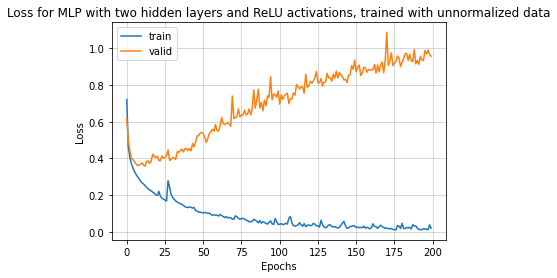

In [ ]:
plt.clf()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss for MLP with two hidden layers and ReLU activations, trained with unnormalized data")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

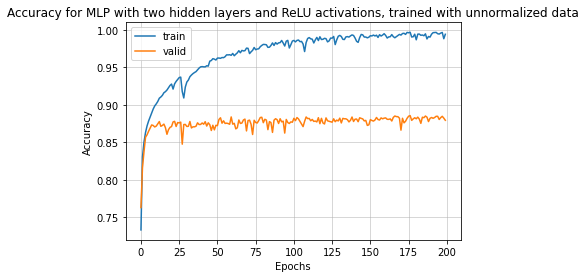

In [ ]:
plt.clf()
plt.plot(train_acc_list, label='train')
plt.plot(val_acc_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy for MLP with two hidden layers and ReLU activations, trained with unnormalized data")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
y_test_probs = mlp_two_hidden_unnormalized.predict(x_test_unnormalized, is_test=True)

test_loss = EvaluationUtils.calculate_ce_loss(y_test_probs, y_test)
test_acc = EvaluationUtils.calculate_multi_accuracy(y_test_probs, y_test)

print("Test loss: {}".format(test_loss))
print("Test accuracy: {}".format(test_acc))

Test loss: 0.3833311815495196
Test accuracy: 0.8683


## Data processing for the CNN and ResNet

In [ ]:
from torch.utils.data import Dataset, DataLoader

class FashionMnistDataset(Dataset):
    
    def __init__(self, x, y):
        self._x = x[:, None, :, :]
        self._y = y
    
    def __len__(self):
        return len(self._y)
    
    def __getitem__(self, idx):
        return self._x[idx], self._y[idx]

In [ ]:
import copy

def train_model(model, 
                criterion, 
                optimizer,
                train_data_loader,
                val_data_loader,
                num_epochs,
                device):

    best_model_weights = copy.deepcopy(model.state_dict())
    best_val_loss = float("inf")
    
    train_loss_hist = []
    train_acc_hist = []
    
    val_loss_hist = []
    val_acc_hist = []

    data_loaders = {
        'train': train_data_loader,
        'val': val_data_loader
    }

    for epoch in range(num_epochs):
        
        train_epoch_loss = 0.0
        train_epoch_acc = 0.0
        
        val_epoch_loss = 0.0
        val_epoch_acc = 0.0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            batch_loss = 0.0
            batch_acc = 0.0

            # Iterate over data
            for x_batch, y_batch in data_loaders[phase]:
                
                x_batch = x_batch.float()
                
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    
                    y_probs = model(x_batch)
                    loss = criterion(y_probs, y_batch)

                    # Backward
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                batch_loss += loss.item()
                batch_acc += EvaluationUtils.calculate_multi_accuracy(y_probs, y_batch)

            epoch_loss = batch_loss / len(data_loaders[phase])
            epoch_acc = batch_acc / len(data_loaders[phase])

            if phase == 'train':
                train_epoch_loss = epoch_loss
                train_epoch_acc = epoch_acc
            else:
                val_epoch_loss = epoch_loss
                val_epoch_acc = epoch_acc

            # Copy the model
            if phase == 'val' and val_epoch_loss < best_val_loss:
                best_val_loss = val_epoch_loss
                best_model_weights = copy.deepcopy(model.state_dict())
        
        train_loss_hist.append(train_epoch_loss)
        train_acc_hist.append(train_epoch_acc)
        
        val_loss_hist.append(val_epoch_loss)
        val_acc_hist.append(val_epoch_acc)
        
        print("Epoch: {}, train loss: {}, train acc: {}, val loss: {}, val acc: {}".format(epoch, train_epoch_loss, train_epoch_acc, val_epoch_loss, val_epoch_acc))
        
    print("Best val loss: {}".format(best_val_loss))

    # Load best model weights
    model.load_state_dict(best_model_weights)

    return model, train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist

In [ ]:
def test_model(best_model, criterion, test_data_loader, device):
    
    best_model.eval()
    
    batch_loss = 0.0
    batch_acc = 0.0
    
    for x_batch, y_batch in test_data_loader:
        
        x_batch = x_batch.float()
                
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        with torch.set_grad_enabled(False):
                    
            y_probs = best_model(x_batch)
            loss = criterion(y_probs, y_batch)
            
        batch_loss += loss.item()
        batch_acc += EvaluationUtils.calculate_multi_accuracy(y_probs, y_batch)
        
    test_loss = batch_loss / len(test_data_loader)
    test_acc = batch_acc / len(test_data_loader)
    
    return test_loss, test_acc

In [ ]:
train_dataset = FashionMnistDataset(x_train_original.get(), y_train.get())
val_dataset = FashionMnistDataset(x_val_original.get(), y_val.get())
test_dataset = FashionMnistDataset(x_test_original.get(), y_test.get())

train_data_loader = DataLoader(train_dataset, batch_size=MLP_BATCH_SIZE)
val_data_loader = DataLoader(val_dataset, batch_size=MLP_BATCH_SIZE)
test_data_loader = DataLoader(test_dataset, batch_size=MLP_BATCH_SIZE)

## Sub-task 5: CNN

### CNN model 1: no padding

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.convo_layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2)
    )

    self.convo_layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2)
    )

    self.fc_layers = nn.Sequential(
        nn.Linear(in_features = 64*6*6, out_features=128),
        nn.Dropout2d(0.5),
        nn.ReLU(),

        nn.Linear(in_features = 128, out_features=128),
        nn.ReLU(),

        nn.Linear(in_features = 128, out_features = 10)
    )

  def forward(self, x):
    x = self.convo_layer1(x)
    x = self.convo_layer2(x)
    # flattern
    x = x.view(x.size(0), -1)
    x = self.fc_layers(x)

    return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_model1 = CNN()
cnn_model1.to(device)
print(cnn_model1)

CNN(
  (convo_layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convo_layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=2304, out_features=128, bias=True)
    (1): Dropout2d(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
criterion_ce = nn.CrossEntropyLoss()
optimizer_sgd = optim.SGD(cnn_model1.parameters(), lr=0.0001)

# Train
best_model, train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train_model(cnn_model1, 
                                                                                       criterion_ce, optimizer_sgd,
                                                                                       train_data_loader, val_data_loader,
                                                                                       100, device)

Epoch: 0, train loss: 2.2879405208882857, train acc: 0.12480952590703964, val loss: 2.2547751473320847, val acc: 0.22255556285381317
Epoch: 1, train loss: 2.248584670325121, train acc: 0.1760713905096054, val loss: 2.2123886106146706, val acc: 0.33966681361198425
Epoch: 2, train loss: 2.2097215511174433, train acc: 0.23204749822616577, val loss: 2.168460179885229, val acc: 0.4393332302570343
Epoch: 3, train loss: 2.1722572763164822, train acc: 0.2732856869697571, val loss: 2.1235977618098243, val acc: 0.49055540561676025
Epoch: 4, train loss: 2.132144451453572, train acc: 0.3151189386844635, val loss: 2.0772274292177624, val acc: 0.5155000686645508
Epoch: 5, train loss: 2.0916552220951954, train acc: 0.34819042682647705, val loss: 2.028625624272557, val acc: 0.5340557098388672
Epoch: 6, train loss: 2.0503286395101314, train acc: 0.38290485739707947, val loss: 1.9774857084751127, val acc: 0.5532779097557068
Epoch: 7, train loss: 2.005229350476039, train acc: 0.40402376651763916, val los

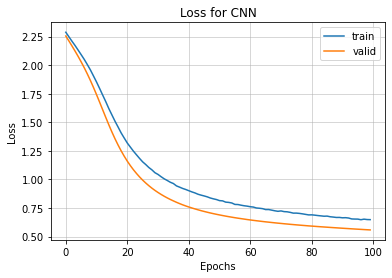

In [ ]:
plt.clf()
plt.plot(train_loss_hist, label='train')
plt.plot(val_loss_hist, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss for CNN")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = test_model(best_model, criterion_ce, 
                                 test_data_loader, 
                                 device)
print("Test loss: {}, test acc: {}".format(test_loss, test_acc))

Test loss: 0.5735888873421208, test acc: 0.7842999696731567


### CNN model 2: padding = 1

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.convo_layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2)
    )

    self.convo_layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2)
    )

    self.fc_layers = nn.Sequential(
        nn.Linear(in_features = 64*7*7, out_features=128),
        nn.Dropout2d(0.5),
        nn.ReLU(),
        
        nn.Linear(in_features = 128, out_features=128),
        nn.ReLU(),

        nn.Linear(in_features = 128, out_features = 10)
    )

  def forward(self, x):
    x = self.convo_layer1(x)
    x = self.convo_layer2(x)
    # flattern
    x = x.view(x.size(0), -1)
    x = self.fc_layers(x)

    return x

In [ ]:
cnn_model2 = CNN()
cnn_model2.to(device)
print(cnn_model2)

CNN(
  (convo_layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convo_layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): Dropout2d(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
criterion_ce = nn.CrossEntropyLoss()
optimizer_sgd = optim.SGD(cnn_model2.parameters(), lr=0.0001)

# Train
best_model, train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train_model(cnn_model2, 
                                                                                       criterion_ce, optimizer_sgd,
                                                                                       train_data_loader, val_data_loader,
                                                                                       100, device)

Epoch: 0, train loss: 2.28641763691959, train acc: 0.14369043707847595, val loss: 2.2564007526834815, val acc: 0.2440555840730667
Epoch: 1, train loss: 2.2441089653770137, train acc: 0.2107619345188141, val loss: 2.20893463387092, val acc: 0.3160001337528229
Epoch: 2, train loss: 2.1994378296080086, train acc: 0.2602856457233429, val loss: 2.155831751234, val acc: 0.4015555679798126
Epoch: 3, train loss: 2.149661574349519, train acc: 0.30726173520088196, val loss: 2.096587603476313, val acc: 0.46550023555755615
Epoch: 4, train loss: 2.0961959954329883, train acc: 0.3491429388523102, val loss: 2.032337983628115, val acc: 0.5210555791854858
Epoch: 5, train loss: 2.038422639386994, train acc: 0.38426196575164795, val loss: 1.963977576076985, val acc: 0.5549443960189819
Epoch: 6, train loss: 1.979413971661103, train acc: 0.4116427004337311, val loss: 1.8936140465868856, val acc: 0.568888783454895
Epoch: 7, train loss: 1.9176433151144359, train acc: 0.43709513545036316, val loss: 1.82192962

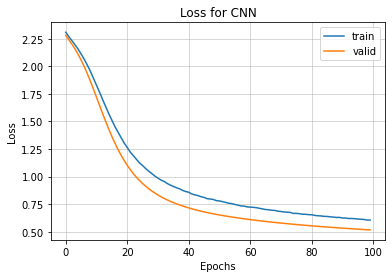

In [ ]:
plt.clf()
plt.plot(train_acc_hist, label='train')
plt.plot(val_a_hist, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss for CNN")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = test_model(best_model, criterion_ce, 
                                 test_data_loader, 
                                 device)
print("Test loss: {}, test acc: {}".format(test_loss, test_acc))

Test loss: 0.5317517978103214, test acc: 0.8081998229026794


### CNN model 3: padding = 2

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.convo_layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2, padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2)
    )

    self.convo_layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2)
    )

    self.fc_layers = nn.Sequential(
        nn.Linear(in_features = 64*9*9, out_features=128),
        nn.Dropout2d(0.5),
        nn.ReLU(),
        
        nn.Linear(in_features = 128, out_features=128),
        nn.ReLU(),

        nn.Linear(in_features = 128, out_features = 10)
    )

  def forward(self, x):
    x = self.convo_layer1(x)
    x = self.convo_layer2(x)
    # flattern
    x = x.view(x.size(0), -1)
    x = self.fc_layers(x)

    return x

In [ ]:
cnn_model6 = CNN()
cnn_model6.to(device)
print(cnn_model6)

CNN(
  (convo_layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convo_layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=5184, out_features=128, bias=True)
    (1): Dropout2d(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
criterion_ce = nn.CrossEntropyLoss()
optimizer_sgd = optim.SGD(cnn_model6.parameters(), lr=0.0001)

# Train
best_model, train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train_model(cnn_model6, 
                                                                                       criterion_ce, optimizer_sgd,
                                                                                       train_data_loader, val_data_loader,
                                                                                       100, device)

Epoch: 0, train loss: 1.7895299677948158, train acc: 0.46961912512779236, val loss: 1.651260831611024, val acc: 0.6189999580383301
Epoch: 1, train loss: 1.7052927149576795, train acc: 0.4862619936466217, val loss: 1.5584291995068393, val acc: 0.6291110515594482
Epoch: 2, train loss: 1.6255482327001438, train acc: 0.50090491771698, val loss: 1.4718027314411266, val acc: 0.6449443697929382
Epoch: 3, train loss: 1.5507404240128546, train acc: 0.5197622776031494, val loss: 1.3923380458255616, val acc: 0.6537221670150757
Epoch: 4, train loss: 1.4876674285506226, train acc: 0.5290951728820801, val loss: 1.321924629830652, val acc: 0.6635556221008301
Epoch: 5, train loss: 1.4229431142581719, train acc: 0.5438811182975769, val loss: 1.2588545336822665, val acc: 0.6727221608161926
Epoch: 6, train loss: 1.3699346918036186, train acc: 0.5563811659812927, val loss: 1.2029916860610237, val acc: 0.6837777495384216
Epoch: 7, train loss: 1.3230736917471964, train acc: 0.5626429915428162, val loss: 1.1

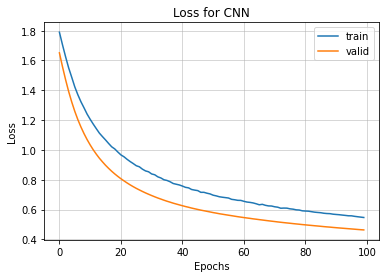

In [ ]:
plt.clf()
plt.plot(train_loss_hist, label='train')
plt.plot(val_loss_hist, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss for CNN")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = test_model(best_model, criterion_ce, 
                                 test_data_loader, 
                                 device)
print("Test loss: {}, test acc: {}".format(test_loss, test_acc))

Test loss: 0.48012553067819475, test acc: 0.8295000791549683


## Sub-task 6: Modified MLP (Adam Optimizer)

In [ ]:
mlp_two_hidden_l2_0_1 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, FASHION_MNIST_N_CLASSES),
    SoftmaxOutputLayer()
)

opt_two_hidden_l2_0_1 = AdamOptimizer(mlp_two_hidden_l2_0_1, 0.0001)
train_loss_list, val_loss_list, train_acc_list, val_acc_list = mlp_two_hidden_l2_0_1.fit(opt_two_hidden_l2_0_1, x_train, y_train, x_val, y_val,
                                                                                  batch_size=MLP_BATCH_SIZE, epochs=MLP_EPOCHS)

  0%|          | 1/200 [00:02<07:39,  2.31s/it]

Epoch: 1, train loss: 0.9458557975710792, train acc: 0.7099761904761906, val loss: 0.6600683532447328, val acc: 0.7647222222222222


  1%|          | 2/200 [00:04<07:22,  2.24s/it]

Epoch: 2, train loss: 0.6139868583623871, train acc: 0.7789523809523808, val loss: 0.5844556511829876, val acc: 0.7884444444444444


  2%|▏         | 3/200 [00:06<07:11,  2.19s/it]

Epoch: 3, train loss: 0.5611386490529221, train acc: 0.7956428571428574, val loss: 0.5483597916349147, val acc: 0.8011666666666667


  2%|▏         | 4/200 [00:08<07:07,  2.18s/it]

Epoch: 4, train loss: 0.5314288556702724, train acc: 0.8079285714285716, val loss: 0.52512736601354, val acc: 0.8117777777777778


  2%|▎         | 5/200 [00:10<07:02,  2.17s/it]

Epoch: 5, train loss: 0.5108846477599265, train acc: 0.8160952380952381, val loss: 0.5081390661723713, val acc: 0.8177777777777778


  3%|▎         | 6/200 [00:13<06:58,  2.16s/it]

Epoch: 6, train loss: 0.4951274670537604, train acc: 0.8227857142857133, val loss: 0.4947143236671404, val acc: 0.8232777777777778


  4%|▎         | 7/200 [00:15<06:56,  2.16s/it]

Epoch: 7, train loss: 0.48227182851466743, train acc: 0.8265476190476183, val loss: 0.48360332976821047, val acc: 0.8270555555555555


  4%|▍         | 8/200 [00:17<06:54,  2.16s/it]

Epoch: 8, train loss: 0.4714839137686152, train acc: 0.8308333333333341, val loss: 0.4742094240657998, val acc: 0.8308888888888889


  4%|▍         | 9/200 [00:19<06:50,  2.15s/it]

Epoch: 9, train loss: 0.4622386100979653, train acc: 0.8350000000000006, val loss: 0.466102774691345, val acc: 0.833


  5%|▌         | 10/200 [00:21<06:47,  2.15s/it]

Epoch: 10, train loss: 0.45413723876478584, train acc: 0.8375714285714285, val loss: 0.45895696429766564, val acc: 0.8359444444444445


  6%|▌         | 11/200 [00:23<06:44,  2.14s/it]

Epoch: 11, train loss: 0.4469072832691832, train acc: 0.8399761904761909, val loss: 0.4525652852062187, val acc: 0.8387222222222223


  6%|▌         | 12/200 [00:25<06:44,  2.15s/it]

Epoch: 12, train loss: 0.4403784569515312, train acc: 0.8426904761904764, val loss: 0.4468312093189822, val acc: 0.8407777777777777


  6%|▋         | 13/200 [00:28<06:40,  2.14s/it]

Epoch: 13, train loss: 0.43444579626541213, train acc: 0.8451666666666656, val loss: 0.4416397399386717, val acc: 0.8428888888888889


  7%|▋         | 14/200 [00:30<06:39,  2.15s/it]

Epoch: 14, train loss: 0.4289887507160113, train acc: 0.8474285714285716, val loss: 0.43689395699135375, val acc: 0.8445555555555555


  8%|▊         | 15/200 [00:32<06:37,  2.15s/it]

Epoch: 15, train loss: 0.42392457410491907, train acc: 0.8484523809523805, val loss: 0.4325283421865282, val acc: 0.8459444444444445


  8%|▊         | 16/200 [00:34<06:33,  2.14s/it]

Epoch: 16, train loss: 0.41918780277390455, train acc: 0.8504523809523811, val loss: 0.42845936361740916, val acc: 0.8477777777777777


  8%|▊         | 17/200 [00:36<06:32,  2.15s/it]

Epoch: 17, train loss: 0.4147350709597616, train acc: 0.8522142857142861, val loss: 0.4246651080717972, val acc: 0.8490555555555556


  9%|▉         | 18/200 [00:38<06:30,  2.14s/it]

Epoch: 18, train loss: 0.4105263819416122, train acc: 0.8536428571428575, val loss: 0.4211031297528057, val acc: 0.8501111111111112


 10%|▉         | 19/200 [00:40<06:27,  2.14s/it]

Epoch: 19, train loss: 0.4065358031451235, train acc: 0.8550238095238094, val loss: 0.41776189952991843, val acc: 0.8513333333333334


 10%|█         | 20/200 [00:43<06:23,  2.13s/it]

Epoch: 20, train loss: 0.4027364802032464, train acc: 0.8563571428571426, val loss: 0.4146078317810171, val acc: 0.8523888888888889


 10%|█         | 21/200 [00:45<06:21,  2.13s/it]

Epoch: 21, train loss: 0.399102240652646, train acc: 0.8577619047619052, val loss: 0.41160123656388603, val acc: 0.8532777777777778


 11%|█         | 22/200 [00:47<06:23,  2.16s/it]

Epoch: 22, train loss: 0.39561343146397027, train acc: 0.8592380952380958, val loss: 0.4087417220650242, val acc: 0.8538888888888889


 12%|█▏        | 23/200 [00:49<06:20,  2.15s/it]

Epoch: 23, train loss: 0.3922685194497329, train acc: 0.860619047619048, val loss: 0.4060113046723989, val acc: 0.855


 12%|█▏        | 24/200 [00:51<06:17,  2.15s/it]

Epoch: 24, train loss: 0.38904739767656243, train acc: 0.8618333333333339, val loss: 0.40339358765549505, val acc: 0.8561111111111112


 12%|█▎        | 25/200 [00:53<06:14,  2.14s/it]

Epoch: 25, train loss: 0.38593364803578184, train acc: 0.8626904761904767, val loss: 0.4008885624071164, val acc: 0.8568333333333333


 13%|█▎        | 26/200 [00:55<06:13,  2.14s/it]

Epoch: 26, train loss: 0.38291681624092355, train acc: 0.8638333333333336, val loss: 0.39847773235313266, val acc: 0.8574444444444445


 14%|█▎        | 27/200 [00:58<06:10,  2.14s/it]

Epoch: 27, train loss: 0.37999295916665565, train acc: 0.8646904761904762, val loss: 0.396149650550921, val acc: 0.8583333333333333


 14%|█▍        | 28/200 [01:00<06:06,  2.13s/it]

Epoch: 28, train loss: 0.37715400995273246, train acc: 0.8657380952380951, val loss: 0.3939005998538837, val acc: 0.8587777777777778


 14%|█▍        | 29/200 [01:02<06:04,  2.13s/it]

Epoch: 29, train loss: 0.3743889406282438, train acc: 0.8668571428571425, val loss: 0.3917303202536922, val acc: 0.8597777777777778


 15%|█▌        | 30/200 [01:04<06:01,  2.13s/it]

Epoch: 30, train loss: 0.3716987221774753, train acc: 0.8676190476190475, val loss: 0.3896381442711289, val acc: 0.8602777777777778


 16%|█▌        | 31/200 [01:06<05:59,  2.13s/it]

Epoch: 31, train loss: 0.3690779631669541, train acc: 0.8682619047619049, val loss: 0.3876286542504115, val acc: 0.8612777777777778


 16%|█▌        | 32/200 [01:08<05:56,  2.12s/it]

Epoch: 32, train loss: 0.36652090157812633, train acc: 0.8690952380952387, val loss: 0.38567036325416043, val acc: 0.8622777777777778


 16%|█▋        | 33/200 [01:10<05:55,  2.13s/it]

Epoch: 33, train loss: 0.3640240980557898, train acc: 0.8701428571428582, val loss: 0.38377819721332407, val acc: 0.8626111111111111


 17%|█▋        | 34/200 [01:13<05:55,  2.14s/it]

Epoch: 34, train loss: 0.3615776161817834, train acc: 0.8709523809523817, val loss: 0.3819336288944875, val acc: 0.8633333333333333


 18%|█▊        | 35/200 [01:15<05:52,  2.14s/it]

Epoch: 35, train loss: 0.35918361789486114, train acc: 0.8719047619047623, val loss: 0.38013362126509836, val acc: 0.8636666666666667


 18%|█▊        | 36/200 [01:17<05:55,  2.16s/it]

Epoch: 36, train loss: 0.35683325336496247, train acc: 0.8731190476190478, val loss: 0.37837415630274873, val acc: 0.8639444444444444


 18%|█▊        | 37/200 [01:19<05:52,  2.16s/it]

Epoch: 37, train loss: 0.35452732278152743, train acc: 0.874142857142857, val loss: 0.37666794970438916, val acc: 0.8645555555555555


 19%|█▉        | 38/200 [01:21<05:50,  2.16s/it]

Epoch: 38, train loss: 0.35227273361826056, train acc: 0.8746190476190475, val loss: 0.37500951300506585, val acc: 0.8649444444444444


 20%|█▉        | 39/200 [01:23<05:48,  2.17s/it]

Epoch: 39, train loss: 0.3500538318321087, train acc: 0.8751190476190478, val loss: 0.3733862107788058, val acc: 0.8652222222222222


 20%|██        | 40/200 [01:26<05:48,  2.18s/it]

Epoch: 40, train loss: 0.347878702448299, train acc: 0.8760952380952385, val loss: 0.3718012376712972, val acc: 0.8655


 20%|██        | 41/200 [01:28<05:43,  2.16s/it]

Epoch: 41, train loss: 0.345742957558921, train acc: 0.877095238095238, val loss: 0.37026451365422103, val acc: 0.8663888888888889


 21%|██        | 42/200 [01:30<05:41,  2.16s/it]

Epoch: 42, train loss: 0.34364241616043756, train acc: 0.8779285714285714, val loss: 0.3687610742987129, val acc: 0.8667777777777778


 22%|██▏       | 43/200 [01:32<05:37,  2.15s/it]

Epoch: 43, train loss: 0.34158139322001513, train acc: 0.8787380952380951, val loss: 0.36729007662898305, val acc: 0.8672777777777778


 22%|██▏       | 44/200 [01:34<05:34,  2.14s/it]

Epoch: 44, train loss: 0.3395525944432234, train acc: 0.879428571428571, val loss: 0.365859371000708, val acc: 0.8675555555555555


 22%|██▎       | 45/200 [01:36<05:31,  2.14s/it]

Epoch: 45, train loss: 0.3375603714939233, train acc: 0.8797857142857143, val loss: 0.3644672552220375, val acc: 0.8678888888888889


 23%|██▎       | 46/200 [01:38<05:28,  2.13s/it]

Epoch: 46, train loss: 0.3355999491146628, train acc: 0.8805238095238095, val loss: 0.36310940695977206, val acc: 0.8685


 24%|██▎       | 47/200 [01:40<05:26,  2.14s/it]

Epoch: 47, train loss: 0.33366577537735415, train acc: 0.8810238095238098, val loss: 0.36178063440750174, val acc: 0.8690555555555556


 24%|██▍       | 48/200 [01:43<05:23,  2.13s/it]

Epoch: 48, train loss: 0.3317565311018053, train acc: 0.8816666666666674, val loss: 0.36049744654882127, val acc: 0.87


 24%|██▍       | 49/200 [01:45<05:21,  2.13s/it]

Epoch: 49, train loss: 0.3298757561832452, train acc: 0.882285714285715, val loss: 0.3592366759765655, val acc: 0.8707777777777778


 25%|██▌       | 50/200 [01:47<05:46,  2.31s/it]

Epoch: 50, train loss: 0.3280191690266912, train acc: 0.8831666666666673, val loss: 0.3580141189537581, val acc: 0.8707777777777778


 26%|██▌       | 51/200 [01:50<05:35,  2.25s/it]

Epoch: 51, train loss: 0.32619752314178946, train acc: 0.8837142857142866, val loss: 0.3568125195321381, val acc: 0.8714444444444445


 26%|██▌       | 52/200 [01:52<05:28,  2.22s/it]

Epoch: 52, train loss: 0.3243949343422894, train acc: 0.884285714285715, val loss: 0.3556368822035818, val acc: 0.8716111111111111


 26%|██▋       | 53/200 [01:54<05:22,  2.20s/it]

Epoch: 53, train loss: 0.3226155285915306, train acc: 0.884880952380953, val loss: 0.3544830492685798, val acc: 0.8722222222222222


 27%|██▋       | 54/200 [01:56<05:18,  2.18s/it]

Epoch: 54, train loss: 0.32085782685717007, train acc: 0.8857380952380959, val loss: 0.3533636167997408, val acc: 0.8726666666666667


 28%|██▊       | 55/200 [01:58<05:13,  2.16s/it]

Epoch: 55, train loss: 0.31912431829006427, train acc: 0.8862619047619053, val loss: 0.35227147952085297, val acc: 0.8727222222222222


 28%|██▊       | 56/200 [02:00<05:09,  2.15s/it]

Epoch: 56, train loss: 0.31740650267438136, train acc: 0.886833333333334, val loss: 0.35121893420197553, val acc: 0.873


 28%|██▊       | 57/200 [02:02<05:07,  2.15s/it]

Epoch: 57, train loss: 0.3157119887976578, train acc: 0.8877857142857148, val loss: 0.3501803255547921, val acc: 0.8732222222222222


 29%|██▉       | 58/200 [02:05<05:05,  2.15s/it]

Epoch: 58, train loss: 0.31404023953621124, train acc: 0.8884047619047623, val loss: 0.34916379331592046, val acc: 0.8737222222222222


 30%|██▉       | 59/200 [02:07<05:03,  2.15s/it]

Epoch: 59, train loss: 0.31237958245993636, train acc: 0.8890952380952384, val loss: 0.3481752060848193, val acc: 0.8740555555555556


 30%|███       | 60/200 [02:09<05:03,  2.17s/it]

Epoch: 60, train loss: 0.31073481819534515, train acc: 0.8897380952380958, val loss: 0.34721365853453207, val acc: 0.8745


 30%|███       | 61/200 [02:11<04:59,  2.15s/it]

Epoch: 61, train loss: 0.30910468827692394, train acc: 0.8902380952380953, val loss: 0.3462684917088586, val acc: 0.8746666666666667


 31%|███       | 62/200 [02:13<04:56,  2.15s/it]

Epoch: 62, train loss: 0.30749258460360746, train acc: 0.8908095238095236, val loss: 0.34535217421189157, val acc: 0.8751111111111111


 32%|███▏      | 63/200 [02:15<04:54,  2.15s/it]

Epoch: 63, train loss: 0.30589400569804764, train acc: 0.891380952380952, val loss: 0.34447247341326465, val acc: 0.8757222222222222


 32%|███▏      | 64/200 [02:18<04:54,  2.17s/it]

Epoch: 64, train loss: 0.30431870062346406, train acc: 0.8921904761904759, val loss: 0.3436008623870119, val acc: 0.8762222222222222


 32%|███▎      | 65/200 [02:20<04:50,  2.15s/it]

Epoch: 65, train loss: 0.30274854563533965, train acc: 0.8929285714285715, val loss: 0.3427573854643485, val acc: 0.8767777777777778


 33%|███▎      | 66/200 [02:22<04:49,  2.16s/it]

Epoch: 66, train loss: 0.30119699666235206, train acc: 0.8934761904761909, val loss: 0.34191327223705387, val acc: 0.8770555555555556


 34%|███▎      | 67/200 [02:24<04:49,  2.17s/it]

Epoch: 67, train loss: 0.29965580369316397, train acc: 0.8940238095238096, val loss: 0.34110592418734165, val acc: 0.8775555555555555


 34%|███▍      | 68/200 [02:26<04:47,  2.17s/it]

Epoch: 68, train loss: 0.29812767505578347, train acc: 0.8946428571428569, val loss: 0.340321314060298, val acc: 0.878


 34%|███▍      | 69/200 [02:28<04:44,  2.17s/it]

Epoch: 69, train loss: 0.2966137619054127, train acc: 0.8953571428571423, val loss: 0.3395516155900156, val acc: 0.8782222222222222


 35%|███▌      | 70/200 [02:30<04:40,  2.15s/it]

Epoch: 70, train loss: 0.29510899647273203, train acc: 0.895833333333333, val loss: 0.3387976389282223, val acc: 0.8781666666666667


 36%|███▌      | 71/200 [02:33<04:36,  2.14s/it]

Epoch: 71, train loss: 0.29361507303598894, train acc: 0.8964047619047619, val loss: 0.3380606382478914, val acc: 0.8780555555555556


 36%|███▌      | 72/200 [02:35<04:33,  2.14s/it]

Epoch: 72, train loss: 0.2921338609889361, train acc: 0.8968571428571431, val loss: 0.3373473717805846, val acc: 0.878


 36%|███▋      | 73/200 [02:37<04:32,  2.14s/it]

Epoch: 73, train loss: 0.2906720417030558, train acc: 0.8971904761904765, val loss: 0.3366433747310051, val acc: 0.8780555555555556


 37%|███▋      | 74/200 [02:39<04:30,  2.14s/it]

Epoch: 74, train loss: 0.2892102965167729, train acc: 0.8973809523809527, val loss: 0.33596185370016723, val acc: 0.8785


 38%|███▊      | 75/200 [02:41<04:28,  2.15s/it]

Epoch: 75, train loss: 0.2877609669392422, train acc: 0.8978095238095242, val loss: 0.3352834497332375, val acc: 0.8783333333333333


 38%|███▊      | 76/200 [02:43<04:27,  2.15s/it]

Epoch: 76, train loss: 0.2863169340812926, train acc: 0.898357142857143, val loss: 0.33461616276484474, val acc: 0.8787222222222222


 38%|███▊      | 77/200 [02:46<04:25,  2.16s/it]

Epoch: 77, train loss: 0.2848840171233459, train acc: 0.8988571428571431, val loss: 0.33395813574336547, val acc: 0.8791111111111111


 39%|███▉      | 78/200 [02:48<04:23,  2.16s/it]

Epoch: 78, train loss: 0.28345786066426004, train acc: 0.8994285714285717, val loss: 0.3333152803393599, val acc: 0.8795555555555555


 40%|███▉      | 79/200 [02:50<04:19,  2.15s/it]

Epoch: 79, train loss: 0.2820385501246791, train acc: 0.8998333333333334, val loss: 0.332692556897115, val acc: 0.8798333333333334


 40%|████      | 80/200 [02:52<04:17,  2.14s/it]

Epoch: 80, train loss: 0.2806328039927994, train acc: 0.9002857142857145, val loss: 0.33207985879944324, val acc: 0.8805


 40%|████      | 81/200 [02:54<04:15,  2.15s/it]

Epoch: 81, train loss: 0.27923109978398014, train acc: 0.9006666666666667, val loss: 0.33148983805224636, val acc: 0.8806111111111111


 41%|████      | 82/200 [02:56<04:12,  2.14s/it]

Epoch: 82, train loss: 0.2778385349831301, train acc: 0.9009523809523812, val loss: 0.33090889381947164, val acc: 0.8808333333333334


 42%|████▏     | 83/200 [02:58<04:10,  2.15s/it]

Epoch: 83, train loss: 0.27645239309472414, train acc: 0.901476190476191, val loss: 0.3303393871290009, val acc: 0.8808888888888889


 42%|████▏     | 84/200 [03:01<04:07,  2.14s/it]

Epoch: 84, train loss: 0.2750720860851245, train acc: 0.9019761904761909, val loss: 0.32977859477998966, val acc: 0.8811111111111111


 42%|████▎     | 85/200 [03:03<04:05,  2.13s/it]

Epoch: 85, train loss: 0.27370059050845374, train acc: 0.9024047619047623, val loss: 0.329227822801039, val acc: 0.8815555555555555


 43%|████▎     | 86/200 [03:05<04:03,  2.13s/it]

Epoch: 86, train loss: 0.27232996413278565, train acc: 0.9029523809523815, val loss: 0.3286980063352007, val acc: 0.8815


 44%|████▎     | 87/200 [03:07<04:01,  2.14s/it]

Epoch: 87, train loss: 0.27097249086338626, train acc: 0.9034285714285718, val loss: 0.32817884414706866, val acc: 0.8815555555555555


 44%|████▍     | 88/200 [03:09<04:00,  2.15s/it]

Epoch: 88, train loss: 0.2696250036806864, train acc: 0.9038333333333335, val loss: 0.32766600329641943, val acc: 0.8815555555555555


 44%|████▍     | 89/200 [03:11<03:58,  2.15s/it]

Epoch: 89, train loss: 0.2682786635734995, train acc: 0.904357142857143, val loss: 0.32716623202931666, val acc: 0.8817777777777778


 45%|████▌     | 90/200 [03:13<03:56,  2.15s/it]

Epoch: 90, train loss: 0.26694145931176455, train acc: 0.9049761904761908, val loss: 0.3266816509831631, val acc: 0.8817222222222222


 46%|████▌     | 91/200 [03:16<03:54,  2.15s/it]

Epoch: 91, train loss: 0.2656042049361224, train acc: 0.9053809523809524, val loss: 0.3261823968222896, val acc: 0.8817777777777778


 46%|████▌     | 92/200 [03:18<03:54,  2.17s/it]

Epoch: 92, train loss: 0.2642757190788854, train acc: 0.9061428571428569, val loss: 0.3257277989951972, val acc: 0.882


 46%|████▋     | 93/200 [03:20<03:52,  2.17s/it]

Epoch: 93, train loss: 0.26295389009337644, train acc: 0.906547619047619, val loss: 0.3252508457394774, val acc: 0.8821666666666667


 47%|████▋     | 94/200 [03:22<03:49,  2.16s/it]

Epoch: 94, train loss: 0.2616330047964693, train acc: 0.9070714285714285, val loss: 0.3248012520304805, val acc: 0.8824444444444445


 48%|████▊     | 95/200 [03:24<03:46,  2.16s/it]

Epoch: 95, train loss: 0.26032087221946454, train acc: 0.9074047619047615, val loss: 0.3243654313433107, val acc: 0.8822222222222222


 48%|████▊     | 96/200 [03:26<03:43,  2.15s/it]

Epoch: 96, train loss: 0.25901601385178413, train acc: 0.9080714285714284, val loss: 0.32393010388812904, val acc: 0.8825555555555555


 48%|████▊     | 97/200 [03:29<03:42,  2.16s/it]

Epoch: 97, train loss: 0.2577142196355747, train acc: 0.9083571428571425, val loss: 0.323499012512447, val acc: 0.8828888888888888


 49%|████▉     | 98/200 [03:31<04:02,  2.38s/it]

Epoch: 98, train loss: 0.2564180375758655, train acc: 0.9089285714285715, val loss: 0.323091423646087, val acc: 0.8830555555555556


 50%|████▉     | 99/200 [03:35<04:33,  2.71s/it]

Epoch: 99, train loss: 0.2551246409667936, train acc: 0.9093571428571429, val loss: 0.3226808327259318, val acc: 0.8834444444444445


 50%|█████     | 100/200 [03:37<04:13,  2.53s/it]

Epoch: 100, train loss: 0.2538327296270533, train acc: 0.909904761904762, val loss: 0.32229549823298487, val acc: 0.8835555555555555


 50%|█████     | 101/200 [03:39<03:59,  2.42s/it]

Epoch: 101, train loss: 0.2525506938924515, train acc: 0.9101904761904765, val loss: 0.321933280241758, val acc: 0.8836111111111111


 51%|█████     | 102/200 [03:41<03:49,  2.34s/it]

Epoch: 102, train loss: 0.2512732835219404, train acc: 0.9105238095238095, val loss: 0.3215755057922169, val acc: 0.8840555555555556


 52%|█████▏    | 103/200 [03:43<03:41,  2.28s/it]

Epoch: 103, train loss: 0.25000013434585044, train acc: 0.9110476190476193, val loss: 0.32122171228205854, val acc: 0.8842777777777778


 52%|█████▏    | 104/200 [03:46<03:36,  2.26s/it]

Epoch: 104, train loss: 0.24873594928945814, train acc: 0.9113095238095238, val loss: 0.3208874725797404, val acc: 0.8843333333333333


 52%|█████▎    | 105/200 [03:48<03:33,  2.25s/it]

Epoch: 105, train loss: 0.24747303514310132, train acc: 0.912142857142857, val loss: 0.32054001562478457, val acc: 0.8845


 53%|█████▎    | 106/200 [03:50<03:28,  2.22s/it]

Epoch: 106, train loss: 0.246210705467729, train acc: 0.9126190476190478, val loss: 0.3201989117931648, val acc: 0.8846666666666667


 54%|█████▎    | 107/200 [03:52<03:26,  2.22s/it]

Epoch: 107, train loss: 0.24496345491906968, train acc: 0.9131904761904767, val loss: 0.3198713362682984, val acc: 0.8847777777777778


 54%|█████▍    | 108/200 [03:54<03:22,  2.21s/it]

Epoch: 108, train loss: 0.2437190516027097, train acc: 0.9135476190476195, val loss: 0.3195637133359128, val acc: 0.8845555555555555


 55%|█████▍    | 109/200 [03:57<03:20,  2.20s/it]

Epoch: 109, train loss: 0.24248101389211443, train acc: 0.9139761904761907, val loss: 0.319247438388671, val acc: 0.8847222222222222


 55%|█████▌    | 110/200 [03:59<03:17,  2.20s/it]

Epoch: 110, train loss: 0.2412431375080542, train acc: 0.9145238095238094, val loss: 0.3189458879336324, val acc: 0.8846111111111111


 56%|█████▌    | 111/200 [04:01<03:15,  2.20s/it]

Epoch: 111, train loss: 0.24001860264661132, train acc: 0.9149999999999999, val loss: 0.3186385610111688, val acc: 0.8845


 56%|█████▌    | 112/200 [04:03<03:13,  2.19s/it]

Epoch: 112, train loss: 0.23878378022324084, train acc: 0.9154523809523806, val loss: 0.3183781135549594, val acc: 0.8846666666666667


 56%|█████▋    | 113/200 [04:05<03:10,  2.20s/it]

Epoch: 113, train loss: 0.2375595861424619, train acc: 0.9158333333333332, val loss: 0.3181003783898254, val acc: 0.8848888888888888


 57%|█████▋    | 114/200 [04:08<03:08,  2.19s/it]

Epoch: 114, train loss: 0.23634497605699947, train acc: 0.9162619047619046, val loss: 0.317829470418077, val acc: 0.8851666666666667


 57%|█████▊    | 115/200 [04:10<03:06,  2.20s/it]

Epoch: 115, train loss: 0.23513492254824922, train acc: 0.9168333333333335, val loss: 0.3175797062063214, val acc: 0.8854444444444445


 58%|█████▊    | 116/200 [04:12<03:03,  2.18s/it]

Epoch: 116, train loss: 0.23392429227576772, train acc: 0.9173095238095239, val loss: 0.31731074858305963, val acc: 0.8856111111111111


 58%|█████▊    | 117/200 [04:14<03:00,  2.17s/it]

Epoch: 117, train loss: 0.23272676857877514, train acc: 0.9175952380952384, val loss: 0.31705941028382767, val acc: 0.8861666666666667


 59%|█████▉    | 118/200 [04:16<02:58,  2.18s/it]

Epoch: 118, train loss: 0.2315266622759867, train acc: 0.9180714285714286, val loss: 0.31682927544833955, val acc: 0.8863888888888889


 60%|█████▉    | 119/200 [04:19<02:57,  2.19s/it]

Epoch: 119, train loss: 0.23034191481236124, train acc: 0.9185714285714287, val loss: 0.31657539451592676, val acc: 0.8865555555555555


 60%|██████    | 120/200 [04:21<02:58,  2.24s/it]

Epoch: 120, train loss: 0.22915622925459453, train acc: 0.9192857142857146, val loss: 0.31634262459625595, val acc: 0.8867222222222222


 60%|██████    | 121/200 [04:23<02:55,  2.22s/it]

Epoch: 121, train loss: 0.2279720518286599, train acc: 0.9197142857142859, val loss: 0.3161279207736054, val acc: 0.8865


 61%|██████    | 122/200 [04:25<02:52,  2.21s/it]

Epoch: 122, train loss: 0.2267934336687431, train acc: 0.9203333333333338, val loss: 0.3159131372362777, val acc: 0.8866666666666667


 62%|██████▏   | 123/200 [04:27<02:48,  2.19s/it]

Epoch: 123, train loss: 0.22562199096374141, train acc: 0.9206904761904763, val loss: 0.3157184957428487, val acc: 0.8868888888888888


 62%|██████▏   | 124/200 [04:30<02:45,  2.18s/it]

Epoch: 124, train loss: 0.22445602792027647, train acc: 0.9211428571428575, val loss: 0.315529544850323, val acc: 0.8869444444444444


 62%|██████▎   | 125/200 [04:32<02:43,  2.18s/it]

Epoch: 125, train loss: 0.22329542536516095, train acc: 0.9216666666666669, val loss: 0.3153362835818721, val acc: 0.8867777777777778


 63%|██████▎   | 126/200 [04:34<02:40,  2.16s/it]

Epoch: 126, train loss: 0.22213050659975667, train acc: 0.9220238095238098, val loss: 0.31516734666359086, val acc: 0.8866666666666667


 64%|██████▎   | 127/200 [04:36<02:37,  2.15s/it]

Epoch: 127, train loss: 0.22097545991385098, train acc: 0.9224761904761904, val loss: 0.3149792455032635, val acc: 0.8867777777777778


 64%|██████▍   | 128/200 [04:38<02:34,  2.14s/it]

Epoch: 128, train loss: 0.21982164941412552, train acc: 0.9230238095238097, val loss: 0.3147867722894631, val acc: 0.8868888888888888


 64%|██████▍   | 129/200 [04:40<02:32,  2.15s/it]

Epoch: 129, train loss: 0.2186767114736397, train acc: 0.9234761904761909, val loss: 0.31463259700304963, val acc: 0.8872222222222222


 65%|██████▌   | 130/200 [04:42<02:30,  2.15s/it]

Epoch: 130, train loss: 0.21753444752510598, train acc: 0.9243333333333339, val loss: 0.31448984535072494, val acc: 0.8876666666666667


 66%|██████▌   | 131/200 [04:45<02:28,  2.15s/it]

Epoch: 131, train loss: 0.2163952465332584, train acc: 0.9248333333333336, val loss: 0.3143337441108956, val acc: 0.8878333333333334


 66%|██████▌   | 132/200 [04:47<02:25,  2.14s/it]

Epoch: 132, train loss: 0.21526429326253477, train acc: 0.9252380952380953, val loss: 0.3142161929308176, val acc: 0.8879444444444444


 66%|██████▋   | 133/200 [04:49<02:24,  2.16s/it]

Epoch: 133, train loss: 0.2141331189994018, train acc: 0.9257619047619049, val loss: 0.31409284440776636, val acc: 0.8881666666666667


 67%|██████▋   | 134/200 [04:51<02:22,  2.16s/it]

Epoch: 134, train loss: 0.21301606655761887, train acc: 0.9262380952380953, val loss: 0.3139852971822638, val acc: 0.8878888888888888


 68%|██████▊   | 135/200 [04:53<02:19,  2.15s/it]

Epoch: 135, train loss: 0.21189025162886174, train acc: 0.926690476190476, val loss: 0.3139072814682127, val acc: 0.8881666666666667


 68%|██████▊   | 136/200 [04:56<02:27,  2.30s/it]

Epoch: 136, train loss: 0.2107765051846401, train acc: 0.9269523809523806, val loss: 0.31383731749709237, val acc: 0.8882777777777778


 68%|██████▊   | 137/200 [04:58<02:22,  2.26s/it]

Epoch: 137, train loss: 0.20966434228543857, train acc: 0.9272857142857139, val loss: 0.313742093104231, val acc: 0.8884444444444445


 69%|██████▉   | 138/200 [05:00<02:18,  2.23s/it]

Epoch: 138, train loss: 0.208551252823022, train acc: 0.9274999999999998, val loss: 0.3136668283313123, val acc: 0.8886111111111111


 70%|██████▉   | 139/200 [05:02<02:13,  2.19s/it]

Epoch: 139, train loss: 0.20744849796990106, train acc: 0.9281904761904757, val loss: 0.31361283183152644, val acc: 0.8888333333333334


 70%|███████   | 140/200 [05:04<02:10,  2.17s/it]

Epoch: 140, train loss: 0.20635327533729503, train acc: 0.9286666666666663, val loss: 0.3135607066280044, val acc: 0.8889444444444444


 70%|███████   | 141/200 [05:07<02:08,  2.18s/it]

Epoch: 141, train loss: 0.20525991687923847, train acc: 0.9289523809523808, val loss: 0.31352628678896044, val acc: 0.8891111111111111


 71%|███████   | 142/200 [05:09<02:05,  2.17s/it]

Epoch: 142, train loss: 0.20416738930497166, train acc: 0.9294047619047617, val loss: 0.3134821525596408, val acc: 0.8891666666666667


 72%|███████▏  | 143/200 [05:11<02:03,  2.17s/it]

Epoch: 143, train loss: 0.20308470481964042, train acc: 0.929738095238095, val loss: 0.3134705038674172, val acc: 0.8893333333333333


 72%|███████▏  | 144/200 [05:13<02:01,  2.16s/it]

Epoch: 144, train loss: 0.20199336920009445, train acc: 0.9301904761904759, val loss: 0.3134573262531483, val acc: 0.8895


 72%|███████▎  | 145/200 [05:15<01:58,  2.15s/it]

Epoch: 145, train loss: 0.20091170209609996, train acc: 0.9305952380952379, val loss: 0.31346510918564663, val acc: 0.8896111111111111


 73%|███████▎  | 146/200 [05:17<01:56,  2.16s/it]

Epoch: 146, train loss: 0.19982907428289906, train acc: 0.930928571428571, val loss: 0.31345453340580265, val acc: 0.8895555555555555


 74%|███████▎  | 147/200 [05:20<01:55,  2.17s/it]

Epoch: 147, train loss: 0.19875152869625112, train acc: 0.9314523809523804, val loss: 0.31348471412229867, val acc: 0.8895


 74%|███████▍  | 148/200 [05:22<01:53,  2.18s/it]

Epoch: 148, train loss: 0.19768005536333452, train acc: 0.931833333333333, val loss: 0.31348388648860265, val acc: 0.8894444444444445


 74%|███████▍  | 149/200 [05:24<01:51,  2.19s/it]

Epoch: 149, train loss: 0.1966186139399705, train acc: 0.9322619047619045, val loss: 0.3134916630261675, val acc: 0.8896111111111111


 75%|███████▌  | 150/200 [05:26<01:49,  2.19s/it]

Epoch: 150, train loss: 0.19555890830604555, train acc: 0.932785714285714, val loss: 0.3134818031256314, val acc: 0.8895


 76%|███████▌  | 151/200 [05:28<01:47,  2.19s/it]

Epoch: 151, train loss: 0.19449420089070107, train acc: 0.93297619047619, val loss: 0.31352959401833463, val acc: 0.8895


 76%|███████▌  | 152/200 [05:31<01:45,  2.19s/it]

Epoch: 152, train loss: 0.19343895611747236, train acc: 0.933285714285714, val loss: 0.3135840805830484, val acc: 0.8893888888888889


 76%|███████▋  | 153/200 [05:33<01:42,  2.18s/it]

Epoch: 153, train loss: 0.19238321574234757, train acc: 0.9337619047619042, val loss: 0.3136118776330635, val acc: 0.8891111111111111


 77%|███████▋  | 154/200 [05:35<01:39,  2.17s/it]

Epoch: 154, train loss: 0.1913345884041823, train acc: 0.934214285714285, val loss: 0.3136182513300827, val acc: 0.8892222222222222


 78%|███████▊  | 155/200 [05:37<01:38,  2.18s/it]

Epoch: 155, train loss: 0.19028848323210107, train acc: 0.934714285714285, val loss: 0.31366887098693874, val acc: 0.8891666666666667


 78%|███████▊  | 156/200 [05:39<01:35,  2.18s/it]

Epoch: 156, train loss: 0.18925825513095312, train acc: 0.9351904761904756, val loss: 0.31370109396557, val acc: 0.8892222222222222


 78%|███████▊  | 157/200 [05:41<01:33,  2.18s/it]

Epoch: 157, train loss: 0.18822833995525867, train acc: 0.9354761904761898, val loss: 0.3137504744835643, val acc: 0.8889444444444444


 79%|███████▉  | 158/200 [05:44<01:31,  2.18s/it]

Epoch: 158, train loss: 0.18719787909075308, train acc: 0.9358809523809516, val loss: 0.3138027738359297, val acc: 0.8892222222222222


 80%|███████▉  | 159/200 [05:46<01:29,  2.18s/it]

Epoch: 159, train loss: 0.1861783309049611, train acc: 0.936119047619047, val loss: 0.31386537916512547, val acc: 0.8893888888888889


 80%|████████  | 160/200 [05:48<01:27,  2.19s/it]

Epoch: 160, train loss: 0.18516691336846633, train acc: 0.9365952380952376, val loss: 0.3139663392088709, val acc: 0.8892777777777777


 80%|████████  | 161/200 [05:50<01:25,  2.20s/it]

Epoch: 161, train loss: 0.1841493024746761, train acc: 0.9369285714285712, val loss: 0.3140259432701403, val acc: 0.8896111111111111


 81%|████████  | 162/200 [05:52<01:22,  2.17s/it]

Epoch: 162, train loss: 0.18313453265612434, train acc: 0.9372619047619042, val loss: 0.3141085759760112, val acc: 0.8895


 82%|████████▏ | 163/200 [05:54<01:20,  2.18s/it]

Epoch: 163, train loss: 0.182144343950549, train acc: 0.9378333333333331, val loss: 0.31420267210814457, val acc: 0.8896111111111111


 82%|████████▏ | 164/200 [05:57<01:18,  2.18s/it]

Epoch: 164, train loss: 0.18113953069643476, train acc: 0.938071428571428, val loss: 0.3143130450850758, val acc: 0.8895555555555555


 82%|████████▎ | 165/200 [05:59<01:15,  2.17s/it]

Epoch: 165, train loss: 0.18013200334486676, train acc: 0.9385476190476182, val loss: 0.31438596871253416, val acc: 0.8895


 83%|████████▎ | 166/200 [06:01<01:13,  2.16s/it]

Epoch: 166, train loss: 0.1791459931744216, train acc: 0.9390476190476184, val loss: 0.3145236240329402, val acc: 0.8895555555555555


 84%|████████▎ | 167/200 [06:03<01:11,  2.15s/it]

Epoch: 167, train loss: 0.178153537551322, train acc: 0.9393571428571421, val loss: 0.3146337903347299, val acc: 0.8897222222222222


 84%|████████▍ | 168/200 [06:05<01:08,  2.15s/it]

Epoch: 168, train loss: 0.1771646494523689, train acc: 0.9398571428571421, val loss: 0.3147369657117543, val acc: 0.8899444444444444


 84%|████████▍ | 169/200 [06:07<01:06,  2.15s/it]

Epoch: 169, train loss: 0.17617603672099094, train acc: 0.9402619047619042, val loss: 0.31484134967635435, val acc: 0.8897222222222222


 85%|████████▌ | 170/200 [06:10<01:04,  2.15s/it]

Epoch: 170, train loss: 0.17518136789417016, train acc: 0.9406666666666662, val loss: 0.3149852872265192, val acc: 0.8896666666666667


 86%|████████▌ | 171/200 [06:12<01:02,  2.16s/it]

Epoch: 171, train loss: 0.1742129541546284, train acc: 0.9409523809523805, val loss: 0.31512225671218674, val acc: 0.8898333333333334


 86%|████████▌ | 172/200 [06:14<01:00,  2.15s/it]

Epoch: 172, train loss: 0.1732352763149968, train acc: 0.941380952380952, val loss: 0.31528267499398094, val acc: 0.8897222222222222


 86%|████████▋ | 173/200 [06:16<00:58,  2.15s/it]

Epoch: 173, train loss: 0.17224773088212753, train acc: 0.9417857142857139, val loss: 0.31541456637626225, val acc: 0.8900555555555556


 87%|████████▋ | 174/200 [06:18<00:55,  2.15s/it]

Epoch: 174, train loss: 0.17127431764974452, train acc: 0.9419999999999996, val loss: 0.3155736108070593, val acc: 0.8904444444444445


 88%|████████▊ | 175/200 [06:20<00:54,  2.16s/it]

Epoch: 175, train loss: 0.17031342909405006, train acc: 0.9424999999999999, val loss: 0.3157231622704866, val acc: 0.8903888888888889


 88%|████████▊ | 176/200 [06:22<00:51,  2.16s/it]

Epoch: 176, train loss: 0.169348245535573, train acc: 0.9428809523809523, val loss: 0.31591148682664255, val acc: 0.8906111111111111


 88%|████████▊ | 177/200 [06:25<00:49,  2.15s/it]

Epoch: 177, train loss: 0.1683921562460152, train acc: 0.9433095238095235, val loss: 0.3160816813281304, val acc: 0.8905


 89%|████████▉ | 178/200 [06:27<00:47,  2.16s/it]

Epoch: 178, train loss: 0.16743505923200264, train acc: 0.9438571428571425, val loss: 0.316258308023251, val acc: 0.8906111111111111


 90%|████████▉ | 179/200 [06:29<00:45,  2.16s/it]

Epoch: 179, train loss: 0.16648151380986628, train acc: 0.9442142857142856, val loss: 0.31644104037271065, val acc: 0.8906666666666667


 90%|█████████ | 180/200 [06:31<00:43,  2.15s/it]

Epoch: 180, train loss: 0.16553273650566105, train acc: 0.9446190476190475, val loss: 0.31664897140934267, val acc: 0.8907222222222222


 90%|█████████ | 181/200 [06:33<00:40,  2.14s/it]

Epoch: 181, train loss: 0.16459283096581295, train acc: 0.9449285714285711, val loss: 0.3168522284836107, val acc: 0.8908333333333334


 91%|█████████ | 182/200 [06:35<00:38,  2.13s/it]

Epoch: 182, train loss: 0.16364631783326145, train acc: 0.9453571428571423, val loss: 0.3170351879291413, val acc: 0.8911111111111111


 92%|█████████▏| 183/200 [06:37<00:36,  2.14s/it]

Epoch: 183, train loss: 0.16270761240860618, train acc: 0.9456428571428562, val loss: 0.31723727298589793, val acc: 0.8908888888888888


 92%|█████████▏| 184/200 [06:40<00:34,  2.15s/it]

Epoch: 184, train loss: 0.16178229673970068, train acc: 0.946214285714285, val loss: 0.31745681978929363, val acc: 0.8906666666666667


 92%|█████████▎| 185/200 [06:42<00:32,  2.15s/it]

Epoch: 185, train loss: 0.16085223123223324, train acc: 0.9463095238095232, val loss: 0.31764958679011607, val acc: 0.8908333333333334


 93%|█████████▎| 186/200 [06:44<00:30,  2.15s/it]

Epoch: 186, train loss: 0.1599189318098018, train acc: 0.9466428571428567, val loss: 0.31788372317456176, val acc: 0.8906666666666667


 94%|█████████▎| 187/200 [06:46<00:27,  2.15s/it]

Epoch: 187, train loss: 0.15899919043005417, train acc: 0.9471190476190473, val loss: 0.3180939708145069, val acc: 0.8907777777777778


 94%|█████████▍| 188/200 [06:48<00:25,  2.16s/it]

Epoch: 188, train loss: 0.15808927517721616, train acc: 0.947690476190476, val loss: 0.31833193460514064, val acc: 0.8907222222222222


 94%|█████████▍| 189/200 [06:50<00:23,  2.17s/it]

Epoch: 189, train loss: 0.15716191819859734, train acc: 0.9481904761904758, val loss: 0.31860961048738523, val acc: 0.8911111111111111


 95%|█████████▌| 190/200 [06:53<00:21,  2.16s/it]

Epoch: 190, train loss: 0.15625620745645985, train acc: 0.9484523809523807, val loss: 0.31885513628560025, val acc: 0.8908888888888888


 96%|█████████▌| 191/200 [06:55<00:19,  2.15s/it]

Epoch: 191, train loss: 0.15535804192318758, train acc: 0.9487857142857141, val loss: 0.3190846209600526, val acc: 0.891


 96%|█████████▌| 192/200 [06:57<00:17,  2.15s/it]

Epoch: 192, train loss: 0.15444634526152926, train acc: 0.9494285714285713, val loss: 0.3193708999432952, val acc: 0.8912222222222222


 96%|█████████▋| 193/200 [06:59<00:14,  2.14s/it]

Epoch: 193, train loss: 0.1535504649122302, train acc: 0.949952380952381, val loss: 0.3196193383910109, val acc: 0.8912777777777777


 97%|█████████▋| 194/200 [07:01<00:12,  2.14s/it]

Epoch: 194, train loss: 0.1526551250384325, train acc: 0.9501904761904761, val loss: 0.31988197407378394, val acc: 0.8912222222222222


 98%|█████████▊| 195/200 [07:03<00:10,  2.13s/it]

Epoch: 195, train loss: 0.1517517642848369, train acc: 0.9506666666666668, val loss: 0.320178153575942, val acc: 0.8915555555555555


 98%|█████████▊| 196/200 [07:05<00:08,  2.13s/it]

Epoch: 196, train loss: 0.15086151896010863, train acc: 0.9509047619047619, val loss: 0.3204419332279156, val acc: 0.8914444444444445


 98%|█████████▊| 197/200 [07:07<00:06,  2.12s/it]

Epoch: 197, train loss: 0.14997711164308844, train acc: 0.9513095238095239, val loss: 0.320763805705476, val acc: 0.8913888888888889


 99%|█████████▉| 198/200 [07:10<00:04,  2.13s/it]

Epoch: 198, train loss: 0.14910130809555802, train acc: 0.9516904761904763, val loss: 0.32107376182127306, val acc: 0.8916111111111111


100%|█████████▉| 199/200 [07:12<00:02,  2.13s/it]

Epoch: 199, train loss: 0.1482289464777541, train acc: 0.952047619047619, val loss: 0.3214176355358683, val acc: 0.8916111111111111


100%|██████████| 200/200 [07:14<00:00,  2.17s/it]

Epoch: 200, train loss: 0.14735768182244624, train acc: 0.9523571428571428, val loss: 0.32167197094071576, val acc: 0.8915


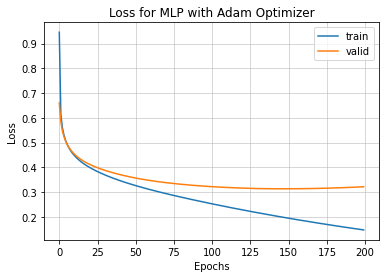

In [ ]:
plt.clf()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss for MLP with Adam Optimizer")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

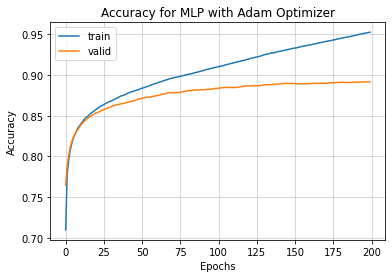

In [ ]:
plt.clf()
plt.plot(train_acc_list, label='train')
plt.plot(val_acc_list, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy for MLP with Adam Optimizer")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
y_test_probs = mlp_two_hidden_l2_0_1.predict(x_test, is_test=True)

test_loss = EvaluationUtils.calculate_ce_loss(y_test_probs, y_test)
test_acc = EvaluationUtils.calculate_multi_accuracy(y_test_probs, y_test)

print("Test loss: {}".format(test_loss))
print("Test accuracy: {}".format(test_acc))

Test loss: 0.34090366655753407
Test accuracy: 0.8804


# ResNet (Creative Point)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class FashionMnistDataset(Dataset):
    
    def __init__(self, x, y):
        self._x = x[:, None, :, :]
        self._y = y
    
    def __len__(self):
        return len(self._y)
    
    def __getitem__(self, idx):
        return self._x[idx], self._y[idx]

In [ ]:
import copy

def train_model(model, 
                criterion, 
                optimizer,
                train_data_loader,
                val_data_loader,
                num_epochs,
                device):

    best_model_weights = copy.deepcopy(model.state_dict())
    best_val_loss = float("inf")
    
    train_loss_hist = []
    train_acc_hist = []
    
    val_loss_hist = []
    val_acc_hist = []

    data_loaders = {
        'train': train_data_loader,
        'val': val_data_loader
    }

    for epoch in range(num_epochs):
        
        train_epoch_loss = 0.0
        train_epoch_acc = 0.0
        
        val_epoch_loss = 0.0
        val_epoch_acc = 0.0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            batch_loss = 0.0
            batch_acc = 0.0

            # Iterate over data
            for x_batch, y_batch in data_loaders[phase]:
                
                x_batch = x_batch.float()
                
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    
                    y_probs = model(x_batch)
                    loss = criterion(y_probs, y_batch)

                    # Backward
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                batch_loss += loss.item()
                batch_acc += EvaluationUtils.calculate_multi_accuracy(y_probs, y_batch)

            epoch_loss = batch_loss / len(data_loaders[phase])
            epoch_acc = batch_acc / len(data_loaders[phase])

            if phase == 'train':
                train_epoch_loss = epoch_loss
                train_epoch_acc = epoch_acc
            else:
                val_epoch_loss = epoch_loss
                val_epoch_acc = epoch_acc

            # Copy the model
            if phase == 'val' and val_epoch_loss < best_val_loss:
                best_val_loss = val_epoch_loss
                best_model_weights = copy.deepcopy(model.state_dict())
        
        train_loss_hist.append(train_epoch_loss)
        train_acc_hist.append(train_epoch_acc)
        
        val_loss_hist.append(val_epoch_loss)
        val_acc_hist.append(val_epoch_acc)
        
        print("Epoch: {}, train loss: {}, train acc: {}, val loss: {}, val acc: {}".format(epoch, train_epoch_loss, train_epoch_acc, val_epoch_loss, val_epoch_acc))
        
    print("Best val loss: {}".format(best_val_loss))

    # Load best model weights
    model.load_state_dict(best_model_weights)

    return model, train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist

In [ ]:
def test_model(best_model, criterion, test_data_loader, device):
    
    best_model.eval()
    
    batch_loss = 0.0
    batch_acc = 0.0
    
    for x_batch, y_batch in test_data_loader:
        
        x_batch = x_batch.float()
                
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        with torch.set_grad_enabled(False):
                    
            y_probs = best_model(x_batch)
            loss = criterion(y_probs, y_batch)
            
        batch_loss += loss.item()
        batch_acc += EvaluationUtils.calculate_multi_accuracy(y_probs, y_batch)
        
    test_loss = batch_loss / len(test_data_loader)
    test_acc = batch_acc / len(test_data_loader)
    
    return test_loss, test_acc

In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torchvision.models as models

resnet18 = models.resnet18(pretrained=True)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet18.fc = nn.Linear(resnet18.fc.in_features, FASHION_MNIST_N_CLASSES)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

print(resnet18)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Note: CNN also can use the following logic
train_dataset = FashionMnistDataset(x_train_original.get(), y_train.get())
val_dataset = FashionMnistDataset(x_val_original.get(), y_val.get())
test_dataset = FashionMnistDataset(x_test_original.get(), y_test.get())

train_data_loader = DataLoader(train_dataset, batch_size=MLP_BATCH_SIZE)
val_data_loader = DataLoader(val_dataset, batch_size=MLP_BATCH_SIZE)
test_data_loader = DataLoader(test_dataset, batch_size=MLP_BATCH_SIZE)

In [ ]:
criterion_ce = nn.CrossEntropyLoss()
optimizer_sgd = optim.SGD(resnet18.parameters(), lr=0.0001)

# Train
best_model, train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train_model(resnet18, 
                                                                                       criterion_ce, optimizer_sgd,
                                                                                       train_data_loader, val_data_loader,
                                                                                       100, device)

Epoch: 0, train loss: 2.0495822026302504, train acc: 0.2907143533229828, val loss: 1.6426236277859907, val acc: 0.4660000801086426
Epoch: 1, train loss: 1.4419655941134857, train acc: 0.5321428179740906, val loss: 1.2752070257548411, val acc: 0.5877223014831543
Epoch: 2, train loss: 1.1824102062144453, train acc: 0.6143568158149719, val loss: 1.0841509100981666, val acc: 0.6425556540489197
Epoch: 3, train loss: 1.0325743714358404, train acc: 0.6580000519752502, val loss: 0.9648438271917115, val acc: 0.675611138343811
Epoch: 4, train loss: 0.9340181551744436, train acc: 0.6873093843460083, val loss: 0.8833180825317579, val acc: 0.6991666555404663
Epoch: 5, train loss: 0.8629396690776491, train acc: 0.7067621350288391, val loss: 0.823884201667113, val acc: 0.716499924659729
Epoch: 6, train loss: 0.8093014533120383, train acc: 0.7226428985595703, val loss: 0.7787522186379967, val acc: 0.7291112542152405
Epoch: 7, train loss: 0.76712800279497, train acc: 0.7348572015762329, val loss: 0.743

In [ ]:
plt.clf()
plt.plot(train_loss_hist, label='train')
plt.plot(val_loss_hist, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss for ResNet")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
plt.clf()
plt.plot(train_acc_hist, label='train')
plt.plot(val_acc_hist, label='valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy for ResNet")
plt.grid(linewidth=0.5)
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = test_model(best_model, criterion_ce, 
                                 test_data_loader, 
                                 device)
print("Test loss: {}, test acc: {}".format(test_loss, test_acc))